In [1]:
import os
import similaritymeasures
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.neighbors import DistanceMetric
import seaborn as sns
from scipy.spatial import minkowski_distance

import pandas as pd

import pylab

In [2]:
def nDTW(exp_data,num_data,d_th=3,p=2):
    r"""
    Parameters
    ----------
    exp_data: list
        experimental trajectory
    num_data: list
        reference trajectory
    d_th: float
        threshold distance for task completion
    p : float, 1 <= p <= infinity
        Which Minkowski p-norm to use. Default is p=2 (Eculidean).
        The manhattan distance is p=1.        
    Returns
    -------
    ndtw : float
        normalized dynamic time warping distance
    """
    dtw = np.ones((len(exp_data)+1,len(num_data)+1))*np.inf
    dtw[0,0] = 0
    for i in range(1,len(exp_data)+1):
        for j in range(1,len(num_data)+1):
            cost = minkowski_distance(exp_data[i-1],num_data[j-1],p=p)
            dtw[i,j] = cost+np.min([dtw[i-1,j],dtw[i,j-1],dtw[i-1,j-1]])
    DTW = dtw[len(exp_data),len(num_data)]
    ndtw = np.exp(-DTW/(len(num_data)*d_th))
    return ndtw

In [3]:
def TC(exp_data,num_data,d_th=3,p=2):
    r"""
    Parameters
    ----------
    exp_data: list
        experimental trajectory
    num_data: list
        reference trajectory
    d_th: float [default = 3 (meters)]
        threshold distance for task completion
    p : float, 1 <= p <= infinity
        Which Minkowski p-norm to use. Default is p=2 (Eculidean).
        The manhattan distance is p=1.        
    Returns
    -------
    tc : bool
        Task Completion score
    """
    return minkowski_distance(exp_data[-1],num_data[-1],p=p)<=d_th
    

In [4]:
def ade_matching(exp_data, num_data, p=2):
    r"""
    Compute the ADE by using matching used in Discrete Frechet Distance
    Compute the ADE between two N-D curves according to matching in
    [1]_. The Frechet distance has been defined as the walking dog problem.
    From Wikipedia: "In mathematics, the Frechet distance is a measure of
    similarity between curves that takes into account the location and
    ordering of the points along the curves. It is named after Maurice Frechet.
    https://en.wikipedia.org/wiki/Fr%C3%A9chet_distance
    Parameters
    ----------
    exp_data : array_like
        Curve from your experimental data. exp_data is of (M, N) shape, where
        M is the number of data points, and N is the number of dimmensions
    num_data : array_like
        Curve from your numerical data. num_data is of (P, N) shape, where P
        is the number of data points, and N is the number of dimmensions
    p : float, 1 <= p <= infinity
        Which Minkowski p-norm to use. Default is p=2 (Eculidean).
        The manhattan distance is p=1.
    Returns
    -------
    df : float
        discrete Frechet distance
    References
    ----------
    .. [1] Thomas Eiter and Heikki Mannila. Computing discrete Frechet
        distance. Technical report, 1994.
        http://www.kr.tuwien.ac.at/staff/eiter/et-archive/cdtr9464.pdf
        http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.90.937&rep=rep1&type=pdf
    """
    n = len(exp_data)
    m = len(num_data)
    ca = np.ones((n, m))
    ca = np.multiply(ca, -1)
    ca[0, 0] = minkowski_distance(exp_data[0], num_data[0], p=p)
    for i in range(1, n):
        ca[i, 0] = ca[i-1, 0]+ minkowski_distance(exp_data[i], num_data[0],
                                                      p=p)
    for j in range(1, m):
        ca[0, j] = ca[0, j-1]+ minkowski_distance(exp_data[0], num_data[j],
                                                      p=p)
    for i in range(1, n):
        for j in range(1, m):
            ca[i, j] = min(ca[i-1, j], ca[i, j-1], ca[i-1, j-1])+minkowski_distance(exp_data[i], num_data[j], p=p)
    return ca[n-1, m-1]/max(n,m)



In [5]:
def get_commands(val_path):
    commands = []
    for episode in os.listdir(val_path):
        filename = os.path.join(val_path,episode,'command.txt')
        with open(filename,'r') as f:
            command = f.readline().strip()
            commands.append(command)
    return commands

In [6]:
def get_scores(val_data_path, val_run_path, save_loc, episodes = None,subplots = False):
    os.makedirs(save_loc,exist_ok=True)
    frechet_dists = []
    fde_dists = []
    ade_dists = []
    ade_match_dists = []
    ndtw_dists = []
    tc_dists = []
    if episodes is None:
        episodes = list(range(50))
    if subplots != False:
        fig = plt.figure(figsize=(10,5))
        handles = []
        labels = []
    for i,episode in enumerate(episodes):
        if subplots != False:
            plt.subplot(subplots[i])
            print('subplotting')
        else:
            plt.figure(figsize=(10,10))
        episode = str(episode)
        filename = os.path.join(val_run_path,episode,'vehicle_positions.txt')
        with open(filename,'r') as f:
            positions = f.readlines()
        run_traj = np.array([ [ float(t.strip()) for t in x.strip().split(',')] for x in positions])

        filename = os.path.join(val_data_path,episode,'vehicle_positions.txt')
        with open(filename,'r') as f:
            positions = f.readlines()
        data_traj = np.array([ [ float(t.strip()) for t in x.strip().split(',')] for x in positions])

        filename = os.path.join(val_run_path,episode,'command.txt')
        with open(filename,'r') as f:
            command = f.readline().strip()

        plt.plot(data_traj[:,0],data_traj[:,1],label='Ground Truth')
        plt.plot(run_traj[:,0],run_traj[:,1],label='Inference on Prediction')
        plt.scatter(data_traj[-1,0],data_traj[-1,1],s=100,label='Ground Truth - End Point')
        plt.scatter(run_traj[-1,0],run_traj[-1,1],s=100,label='Inference - End Point')
        plt.scatter(data_traj[0,0],data_traj[0,1],s=100,label='Starting Point')

        x_min = np.min(np.hstack([data_traj[:,0],run_traj[:,0]]))
        y_min = np.min(np.hstack([data_traj[:,1],run_traj[:,1]]))

        x_max = np.max(np.hstack([data_traj[:,0],run_traj[:,0]]))
        y_max = np.max(np.hstack([data_traj[:,1],run_traj[:,1]]))

        frechet_dists.append(similaritymeasures.frechet_dist(run_traj,data_traj))
        
        min_length = min(run_traj.shape[0],data_traj.shape[0])
        
        r_idx = np.arange(1,run_traj.shape[0]-1)
        np.random.shuffle(r_idx)
        r_idx = [0]+r_idx[:min_length-2].tolist()+[run_traj.shape[0]-1]
        r_idx = sorted(r_idx)
        run_traj_trimmed = run_traj[r_idx]

        d_idx = np.arange(1,data_traj.shape[0]-1)
        np.random.shuffle(d_idx)
        d_idx = [0]+d_idx[:min_length-2].tolist()+[data_traj.shape[0]-1]
        d_idx = sorted(d_idx)
        data_traj_trimmed = data_traj[d_idx]
        print(data_traj_trimmed.shape,run_traj_trimmed.shape)
        
        distances = np.sqrt(np.sum((data_traj_trimmed-run_traj_trimmed)**2,axis=1))
        ade = np.sum(distances)/min_length
        ade_dists.append(ade)
        
        ade_match_dists.append(ade_matching(run_traj,data_traj))

        ndtw_dists.append(nDTW(run_traj,data_traj,5,2))
        tc_dists.append(TC(run_traj,data_traj,5,2))

        fde_dists.append(similaritymeasures.distance.euclidean(data_traj[-1,:],run_traj[-1,:]))
        
        size = max(x_max-x_min+10,y_max-y_min+10)
        if x_max-x_min>y_max-y_min:
            excess_size = size-(y_max-y_min)
            excess_size/=2
            plt.xlim(x_min-5, x_max+5)
            plt.ylim(y_min-excess_size, y_max+excess_size)
        else:
            excess_size = size-(x_max-x_min)
            excess_size/=2
            plt.xlim(x_min-excess_size, x_max+excess_size)
            plt.ylim(y_min-5, y_max+5)
        plt.gca().invert_xaxis()
        plt.gca().set_aspect('equal')
        plt.axis('off')
        plt.title(command)

#         plt.legend()
        if subplots == False:
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=2)
            plt.savefig(os.path.join(save_loc,episode)+'.png') 
        
        print(f'Episode {episode}: {command}')
        print(f'Frechet Distance: {frechet_dists[-1]}')
        print(f'FDE Distance: {fde_dists[-1]}')
        print(f'ADE Distance: {ade_dists[-1]}')
        print(f'ADE Matched Distance: {ade_match_dists[-1]}')
        print(f'nDTW Distance: {ndtw_dists[-1]}')
        print(f'TC Distance: {tc_dists[-1]}')
    #     print(f'Curve Length Measure: {cl_measures[-1]}')
        if subplots == False:
            plt.show()
    if subplots != False:
        lines_labels = [ ax.get_legend_handles_labels() for ax in fig.axes]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
        lines = lines[:5]
        labels = labels[:5]
#         fig.legend(lines, labels)
        
        print(lines,labels)
        
        fig.legend(lines,labels,loc='upper center', bbox_to_anchor=(0.5, 0.15),
          fancybox=True, shadow=True, ncol=2)
        plt.savefig(os.path.join(save_loc,'final')+'.png') 
        plt.show()
        
    return frechet_dists, fde_dists, ade_dists, ade_match_dists, ndtw_dists, tc_dists

In [13]:
def get_scores_comp(val_data_path, val_run_paths, names, save_loc, episodes = None,subplots = False):
    os.makedirs(save_loc,exist_ok=True)
    frechet_dists = []
    fde_dists = []
    ade_dists = []
    ade_match_dists = []
    ndtw_dists = []
    tc_dists = []
    if episodes is None:
        episodes = list(range(50))
    if subplots != False:
        fig = plt.figure(figsize=(10,5))
        handles = []
        labels = []
    for i,episode in enumerate(episodes):
        if subplots != False:
            plt.subplot(subplots[i])
            print('subplotting')
        else:
            plt.figure(figsize=(10,10))
        episode = str(episode)

        filename = os.path.join(val_data_path,episode,'vehicle_positions.txt')
        with open(filename,'r') as f:
            positions = f.readlines()
        data_traj = np.array([ [ float(t.strip()) for t in x.strip().split(',')] for x in positions])
        plt.plot(data_traj[:,0],data_traj[:,1],label='Ground Truth')
        plt.scatter(data_traj[-1,0],data_traj[-1,1],s=100,label='Ground Truth - End Point')
        plt.scatter(data_traj[0,0],data_traj[0,1],s=100,label='Starting Point',color='yellow')
        
        filename = os.path.join(val_data_path,episode,'command.txt')
        with open(filename,'r') as f:
            command = f.readline().strip()

        print(f'Episode {episode}: {command}')
        
        run_trajs = []

        for idx,val_run_path in enumerate(val_run_paths):
        
            filename = os.path.join(val_run_path,episode,'vehicle_positions.txt')
            with open(filename,'r') as f:
                positions = f.readlines()
                
            run_traj = np.array([ [ float(t.strip()) for t in x.strip().split(',')] for x in positions])
            run_trajs.append(run_traj)

            plt.plot(run_traj[:,0],run_traj[:,1],label=f'Inference({names[idx]}) on Prediction')
            plt.scatter(run_traj[-1,0],run_traj[-1,1],s=100,label=f'Inference({names[idx]}) - End Point')


            frechet_dists.append(similaritymeasures.frechet_dist(run_traj,data_traj))
        
            min_length = min(run_traj.shape[0],data_traj.shape[0])

            r_idx = np.arange(1,run_traj.shape[0]-1)
            np.random.shuffle(r_idx)
            r_idx = [0]+r_idx[:min_length-2].tolist()+[run_traj.shape[0]-1]
            r_idx = sorted(r_idx)
            run_traj_trimmed = run_traj[r_idx]

            d_idx = np.arange(1,data_traj.shape[0]-1)
            np.random.shuffle(d_idx)
            d_idx = [0]+d_idx[:min_length-2].tolist()+[data_traj.shape[0]-1]
            d_idx = sorted(d_idx)
            data_traj_trimmed = data_traj[d_idx]
            print(data_traj_trimmed.shape,run_traj_trimmed.shape)

            distances = np.sqrt(np.sum((data_traj_trimmed-run_traj_trimmed)**2,axis=1))
            ade = np.sum(distances)/min_length
            ade_dists.append(ade)

            ade_match_dists.append(ade_matching(run_traj,data_traj))

            ndtw_dists.append(nDTW(run_traj,data_traj,5,2))
            tc_dists.append(TC(run_traj,data_traj,5,2))

            fde_dists.append(similaritymeasures.distance.euclidean(data_traj[-1,:],run_traj[-1,:]))
            
            print(f'{names[idx]}')

            print(f'Frechet Distance: {frechet_dists[-1]}')
            print(f'FDE Distance: {fde_dists[-1]}')
            print(f'ADE Distance: {ade_dists[-1]}')
            print(f'ADE Matched Distance: {ade_match_dists[-1]}')
            print(f'nDTW Distance: {ndtw_dists[-1]}')
            print(f'TC Distance: {tc_dists[-1]}')
        
        all_traj = np.concatenate(run_trajs,axis=0)
        

        x_min = np.min(np.hstack([data_traj[:,0],all_traj[:,0]]))
        y_min = np.min(np.hstack([data_traj[:,1],all_traj[:,1]]))

        x_max = np.max(np.hstack([data_traj[:,0],all_traj[:,0]]))
        y_max = np.max(np.hstack([data_traj[:,1],all_traj[:,1]]))

        
        size = max(x_max-x_min+10,y_max-y_min+10)
        if x_max-x_min>y_max-y_min:
            excess_size = size-(y_max-y_min)
            excess_size/=2
            plt.xlim(x_min-5, x_max+5)
            plt.ylim(y_min-excess_size, y_max+excess_size)
        else:
            excess_size = size-(x_max-x_min)
            excess_size/=2
            plt.xlim(x_min-excess_size, x_max+excess_size)
            plt.ylim(y_min-5, y_max+5)
        plt.gca().invert_xaxis()
        plt.gca().set_aspect('equal')
        plt.axis('off')
        plt.title(command)

        plt.legend()
        if subplots == False:
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=2)
            plt.savefig(os.path.join(save_loc,episode)+'.png') 
        
#         print(f'Episode {episode}: {command}')
#         print(f'Frechet Distance: {frechet_dists[-1]}')
#         print(f'FDE Distance: {fde_dists[-1]}')
#         print(f'ADE Distance: {ade_dists[-1]}')
#         print(f'ADE Matched Distance: {ade_match_dists[-1]}')
#         print(f'nDTW Distance: {ndtw_dists[-1]}')
#         print(f'TC Distance: {tc_dists[-1]}')
    #     print(f'Curve Length Measure: {cl_measures[-1]}')
        if subplots == False:
            plt.show()
    if subplots != False:
        lines_labels = [ ax.get_legend_handles_labels() for ax in fig.axes]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
        lines = lines[:1+2+2*len(names)]
        labels = labels[:1+2+2*len(names)]
#         fig.legend(lines, labels)
        
        print(lines,labels)
        

        fig.legend(lines,labels,loc='upper center', bbox_to_anchor=(0.5, 0.15),
          fancybox=True, shadow=True, ncol=2)
        plt.savefig(os.path.join(save_loc,'final')+'.png') 
        plt.show()
        import pylab

        fig2 = pylab.figure()
        figlegend = pylab.figure(figsize=(15,10))
        ax = fig.add_subplot(111)
        figlegend.legend(lines,labels,loc='center', #bbox_to_anchor=(0.5, 0.15),
          fancybox=True, shadow=True, ncol=2)
        fig2.show()
        figlegend.show()
        figlegend.savefig(os.path.join(save_loc,'legend')+'.png')
        
    return frechet_dists, fde_dists, ade_dists, ade_match_dists, ndtw_dists, tc_dists

In [8]:
def deinterlace(l: list, names: list, df=True, tc_scores = None):
    if tc_scores is not None:
        diction = {name:pd.Series(l[idx::len(names)]).where(
                            np.array(tc_scores[idx::len(names)],dtype=bool)
                            ) 
                   for idx,name in enumerate(names)}
    else:
        diction = {name:pd.Series(l[idx::len(names)]) for idx,name in enumerate(names)}

    if df:
        return pd.DataFrame(diction)
    else:
        return diction

In [9]:
# ! scp varunc@ada:/share3/varunc/val_runs.zip /ssd_scratch/cvit/varunc
# ! unzip /ssd_scratch/cvit/varunc/val_runs.zip
# ! scp varunc@ada:/share3/varunc/val_run_baseline.zip /ssd_scratch/cvit/varunc
# ! unzip /ssd_scratch/cvit/varunc/val_run_baseline.zip
# ! scp varunc@ada:/share3/varunc/val_convlstm.zip /ssd_scratch/cvit/varunc
# ! scp varunc@ada:/share3/varunc/val_framebyframe.zip /ssd_scratch/cvit/varunc
# ! scp varunc@ada:/share3/varunc/val_fbf2.zip /ssd_scratch/cvit/varunc
# ! scp varunc@ada:/share3/varunc/val_temp_convattn.zip /ssd_scratch/cvit/varunc
# ! scp varunc@ada:/share3/varunc/val_run_fbf_network2.zip /ssd_scratch/cvit/varunc
# ! scp varunc@ada:/share3/varunc/val_dual2_fbf_mask.zip /ssd_scratch/cvit/varunc
# unzip /ssd_scratch/cvit/varunc/val_convlstm.zip

scp varunc@ada:/share3/varunc/val_runs.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_runs.zip
scp varunc@ada:/share3/varunc/val_run_baseline.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_run_baseline.zip
scp varunc@ada:/share3/varunc/val_convlstm.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_convlstm.zip
scp varunc@ada:/share3/varunc/val_framebyframe.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_framebyframe.zip
scp varunc@ada:/share3/varunc/val_fbf2.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_fbf2.zip
scp varunc@ada:/share3/varunc/val_temp_convattn.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_temp_convattn.zip
scp varunc@ada:/share3/varunc/val_run_fbf_network2.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_run_fbf_network2.zip

scp varunc@ada:/share3/varunc/val_dual_fgf_mask.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_dual_fgf_mask.zip
scp varunc@ada:/share3/varunc/val_dual_fgf_trajectory.zip /ssd_scratch/cvit/varunc
unzip /ssd_scratch/cvit/varunc/val_dual_fgf_trajectory.zip


(553, 3) (553, 3)
Episode 0: Turn left and stop next to the bus stop.
Frechet Distance: 43.51258063853686
FDE Distance: 43.51258063853686
ADE Distance: 5.0180313257991935
ADE Matched Distance: 2.603935706518025
nDTW Distance: 0.5940527604226482
TC Distance: False


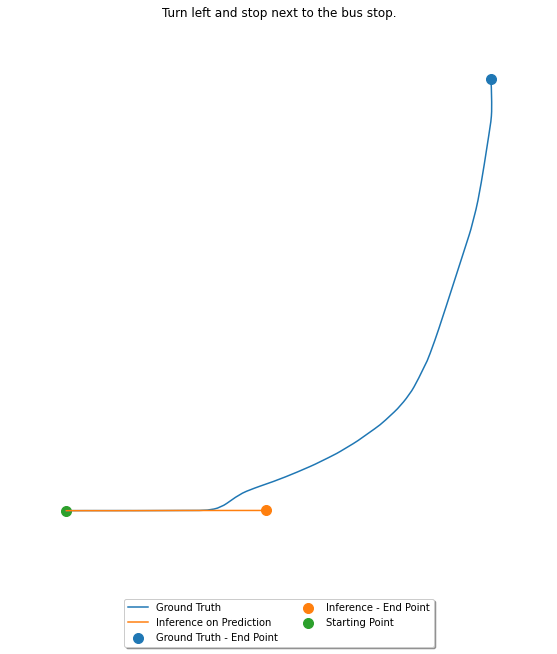

(94, 3) (94, 3)
Episode 1: Take a left from the interection.
Frechet Distance: 18.67360239961607
FDE Distance: 18.67360239961607
ADE Distance: 7.184095504097821
ADE Matched Distance: 2.531467686538739
nDTW Distance: 0.28203225271070426
TC Distance: False


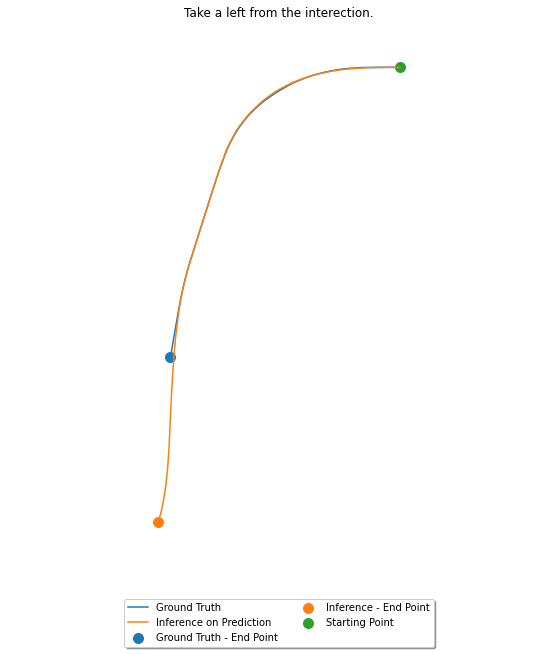

(55, 3) (55, 3)
Episode 2: Drive straight till you see a red coloured board
Frechet Distance: 0.6554414195607362
FDE Distance: 0.6554414195607362
ADE Distance: 1.0085854086034183
ADE Matched Distance: 0.10121567370919969
nDTW Distance: 0.9567943131316504
TC Distance: True


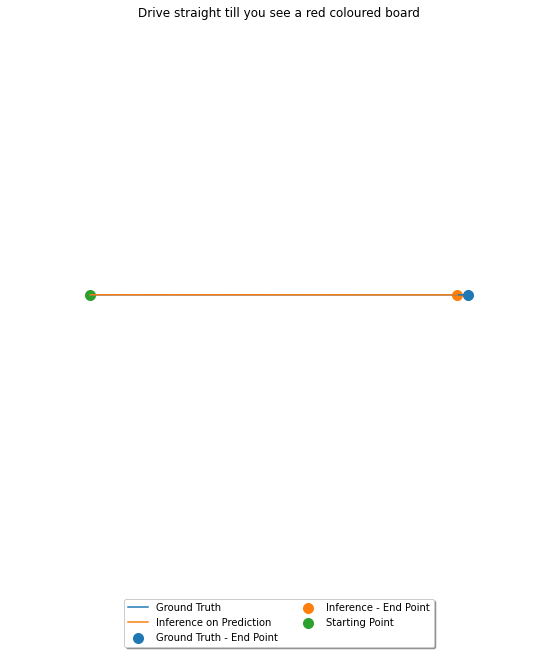

(38, 3) (38, 3)
Episode 3: Park just ahead of the speed signboard
Frechet Distance: 17.453272761888233
FDE Distance: 17.453272761888233
ADE Distance: 6.073382790389333
ADE Matched Distance: 3.852188690567769
nDTW Distance: 0.021233212611652424
TC Distance: False


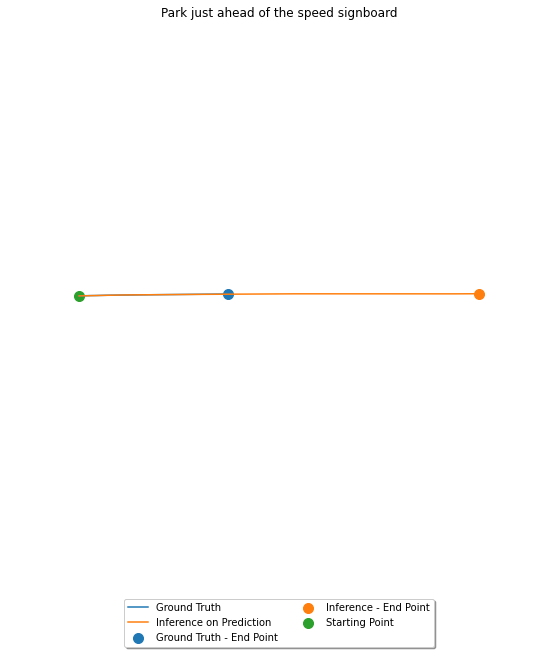

(332, 3) (332, 3)
Episode 4: Take the next right turn.
Frechet Distance: 5.6088478491112195
FDE Distance: 5.6088478491112195
ADE Distance: 8.949143733235843
ADE Matched Distance: 1.3806664020817714
nDTW Distance: 0.5833552483368938
TC Distance: False


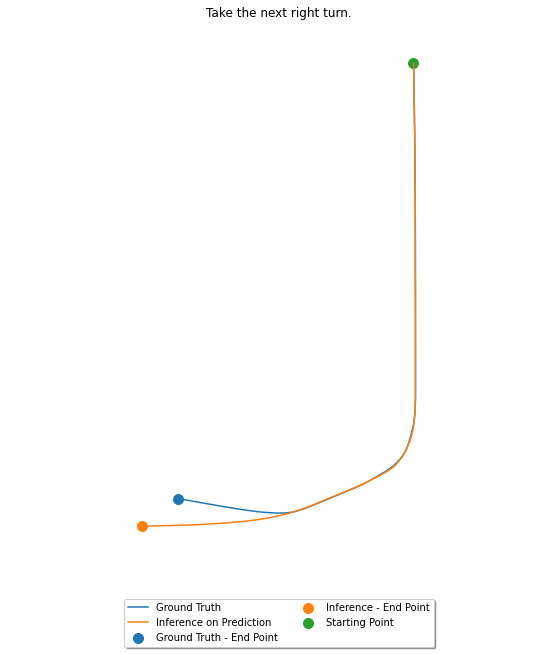

(150, 3) (150, 3)
Episode 5: Drive straight from the next crossroads.
Frechet Distance: 4.476293873391282
FDE Distance: 4.476293873391282
ADE Distance: 3.3647691578943832
ADE Matched Distance: 0.4674502938660115
nDTW Distance: 0.8090368605282297
TC Distance: True


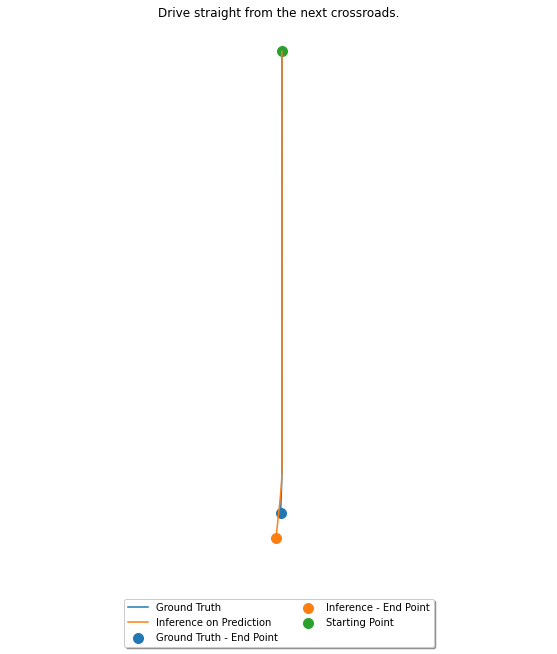

(70, 3) (70, 3)
Episode 6: change to left lane
Frechet Distance: 26.44121240187925
FDE Distance: 26.44121240187925
ADE Distance: 11.597512085349111
ADE Matched Distance: 7.227682048008699
nDTW Distance: 0.0004706748834911383
TC Distance: False


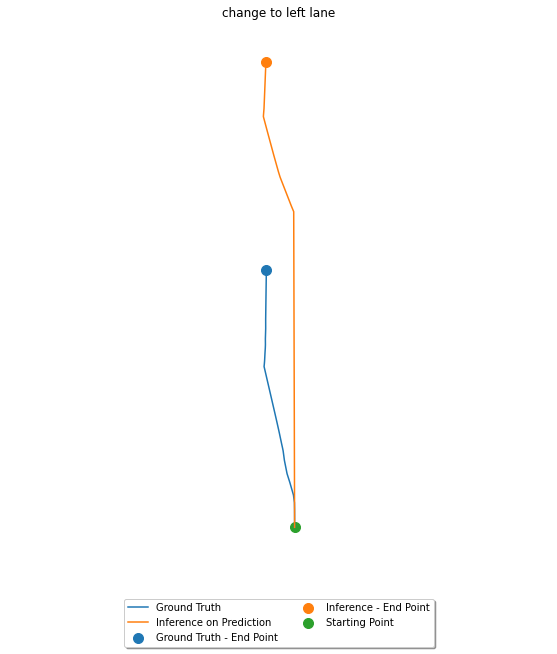

(42, 3) (42, 3)
Episode 7: Stop near the scooty
Frechet Distance: 29.32097266160802
FDE Distance: 29.320972661608025
ADE Distance: 15.659717896939753
ADE Matched Distance: 6.625894214429435
nDTW Distance: 0.0004534352669450631
TC Distance: False


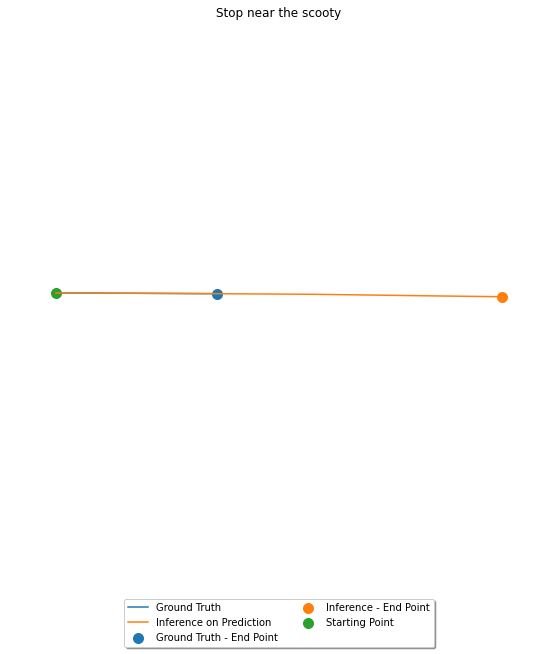

(142, 3) (142, 3)
Episode 8: take right and stop near the speed limit sign
Frechet Distance: 11.533171609885391
FDE Distance: 11.533171609885391
ADE Distance: 11.11384585489489
ADE Matched Distance: 4.956718344166312
nDTW Distance: 0.09644973345085882
TC Distance: False


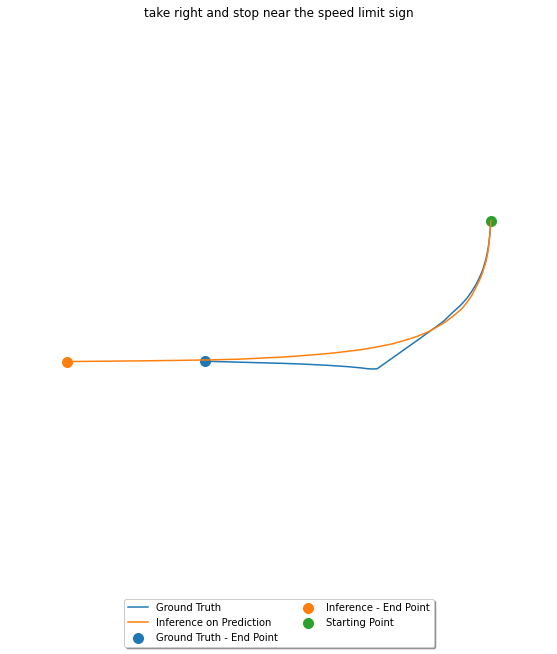

(59, 3) (59, 3)
Episode 9: Turn right and stop near the bus stop.
Frechet Distance: 0.9356895743980193
FDE Distance: 0.9124500717986177
ADE Distance: 1.1802549689190047
ADE Matched Distance: 0.26676932504254924
nDTW Distance: 0.8906971947979863
TC Distance: True


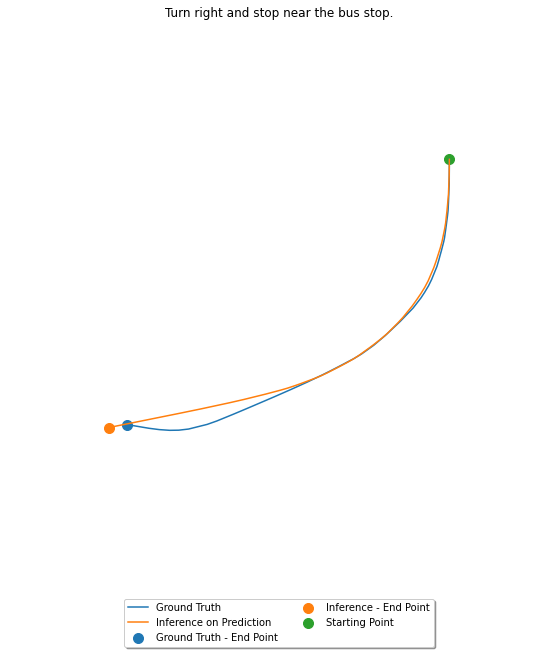

(66, 3) (66, 3)
Episode 10: Shift to the left lane and stop at the intersection.
Frechet Distance: 6.331183820929018
FDE Distance: 6.331183820929018
ADE Distance: 3.9925614050383085
ADE Matched Distance: 2.1852877880296706
nDTW Distance: 0.43414243391702895
TC Distance: False


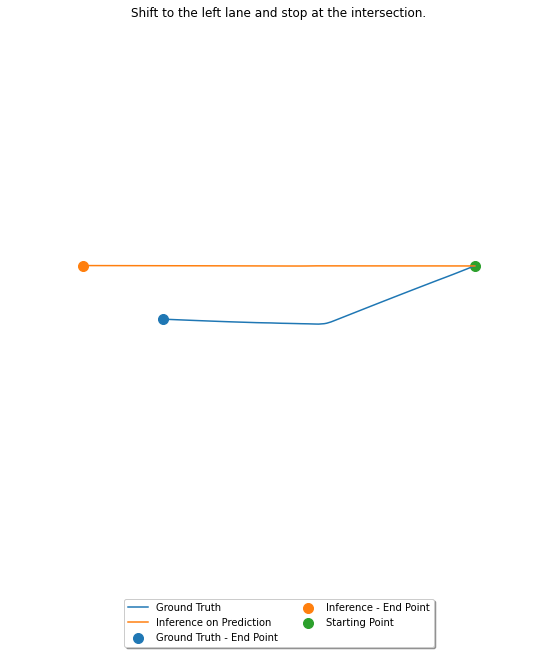

(45, 3) (45, 3)
Episode 11: Stop after crossing the stop signboard
Frechet Distance: 4.292999998566482
FDE Distance: 4.292999998566482
ADE Distance: 1.7944891513076187
ADE Matched Distance: 0.32901731512846294
nDTW Distance: 0.8564119977013522
TC Distance: True


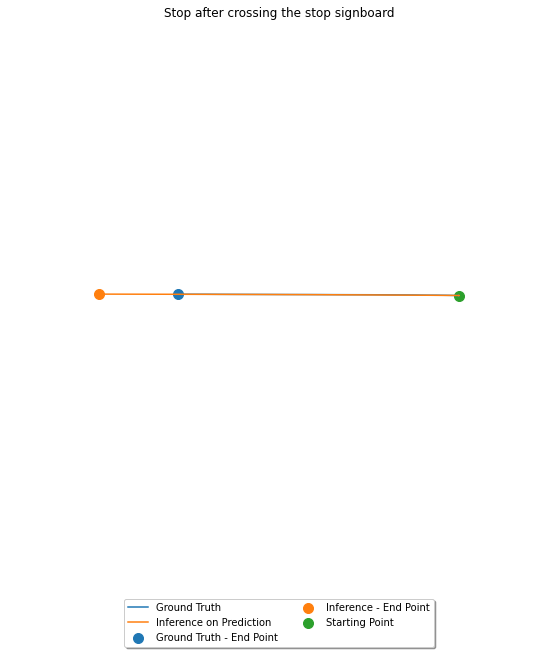

(45, 3) (45, 3)
Episode 12: Park near the red signboard
Frechet Distance: 5.247926855469539
FDE Distance: 5.247926855469539
ADE Distance: 2.28534460886376
ADE Matched Distance: 0.37448867354581633
nDTW Distance: 0.5242508894415512
TC Distance: False


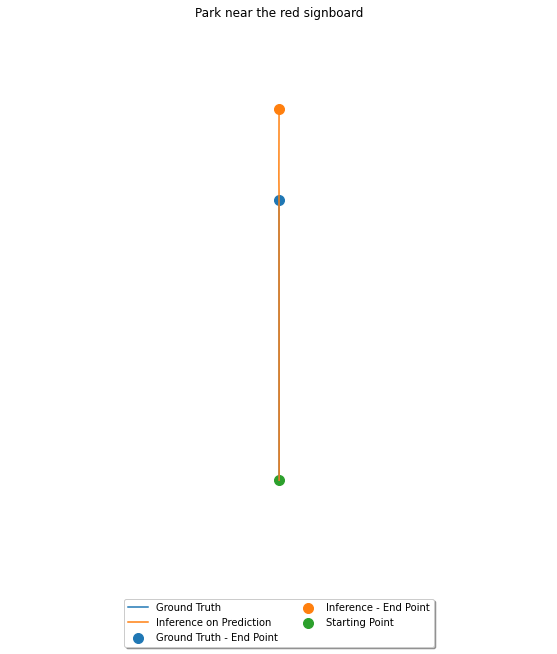

(340, 3) (340, 3)
Episode 13: Wait at the traffic light then go straight.
Frechet Distance: 52.01984067694993
FDE Distance: 52.01984067694993
ADE Distance: 13.89952886178431
ADE Matched Distance: 2.6410938628552523
nDTW Distance: 0.31576412250184394
TC Distance: False


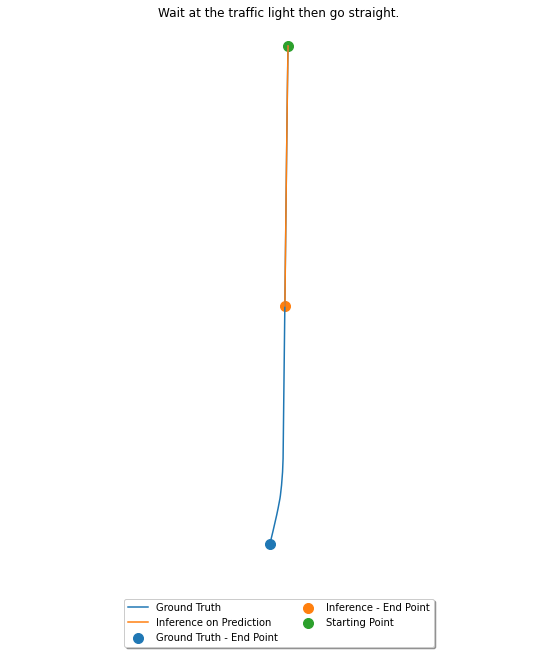

(73, 3) (73, 3)
Episode 14: Drive straight till the intersection and then turn left
Frechet Distance: 10.80607305872367
FDE Distance: 10.80607305872367
ADE Distance: 7.610315528144323
ADE Matched Distance: 0.3058122732603196
nDTW Distance: 0.6297145243847043
TC Distance: False


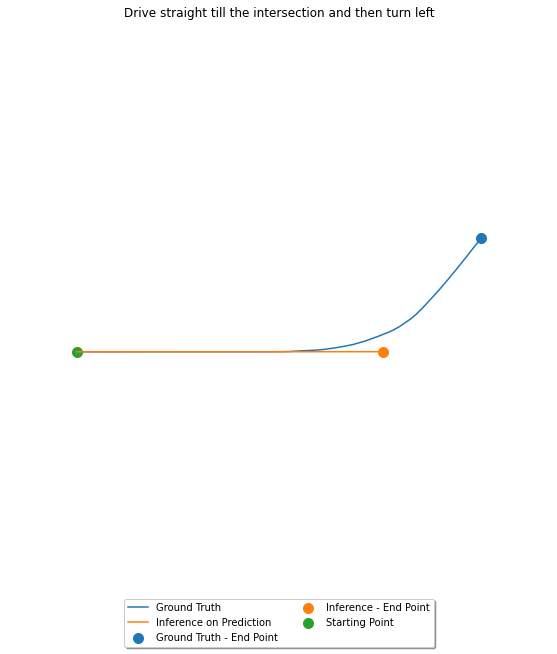

(239, 3) (239, 3)
Episode 15: go straight and take a left
Frechet Distance: 8.52316871708245
FDE Distance: 8.52316871708245
ADE Distance: 2.9221432946523462
ADE Matched Distance: 0.6627953462575656
nDTW Distance: 0.8364452372776583
TC Distance: False


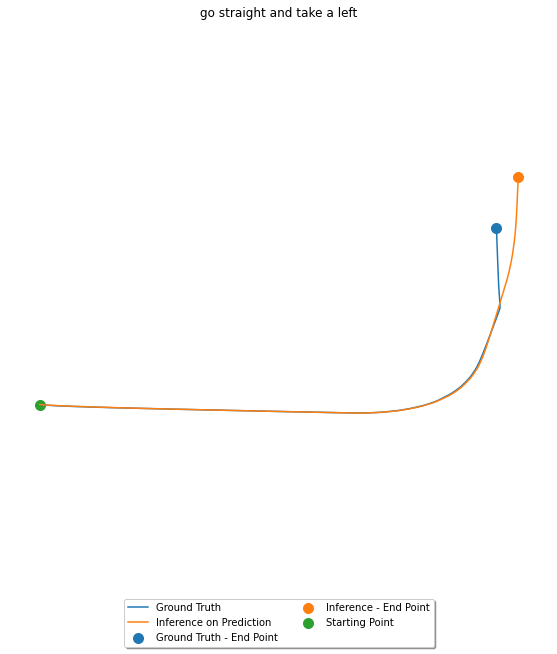

(47, 3) (47, 3)
Episode 16: Stop as soon as you encounter a white car
Frechet Distance: 2.624217095596366
FDE Distance: 2.624217095596366
ADE Distance: 1.6628266166350005
ADE Matched Distance: 0.14278952714151494
nDTW Distance: 0.938193017126227
TC Distance: True


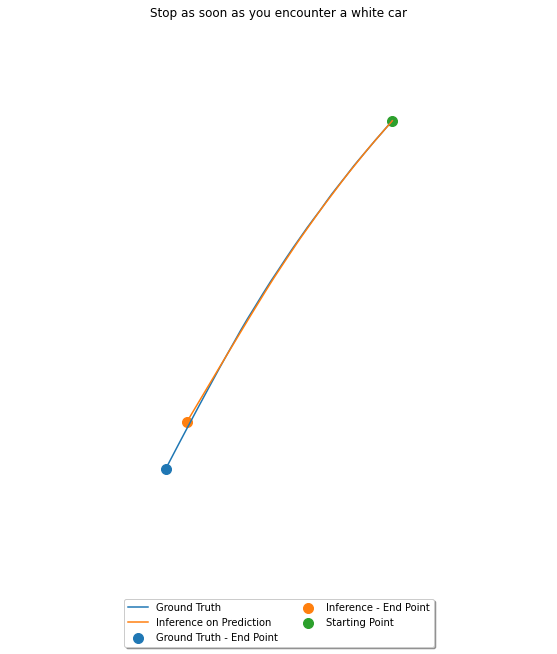

(105, 3) (105, 3)
Episode 17: take a right at the intersection
Frechet Distance: 22.106770483763352
FDE Distance: 22.106770483763356
ADE Distance: 6.626045393855408
ADE Matched Distance: 2.329441469050251
nDTW Distance: 0.37013220483661924
TC Distance: False


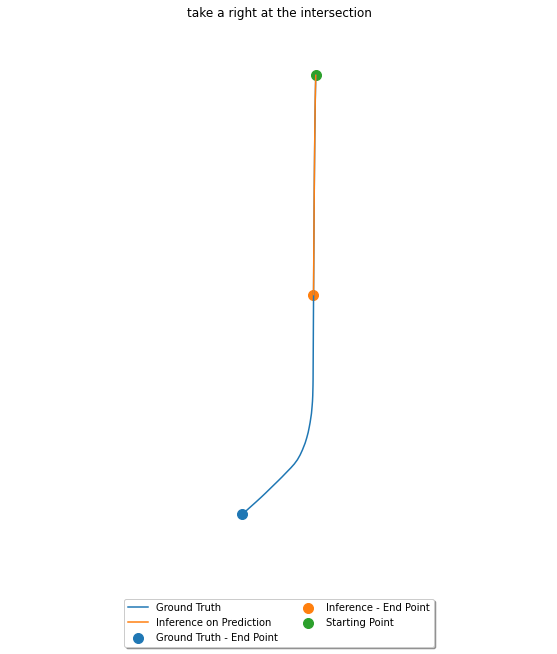

(44, 3) (44, 3)
Episode 18: Stop near the red shelters
Frechet Distance: 6.731877217354998
FDE Distance: 6.731877217354998
ADE Distance: 2.984841504223716
ADE Matched Distance: 1.0327771119236706
nDTW Distance: 0.5483242327029269
TC Distance: False


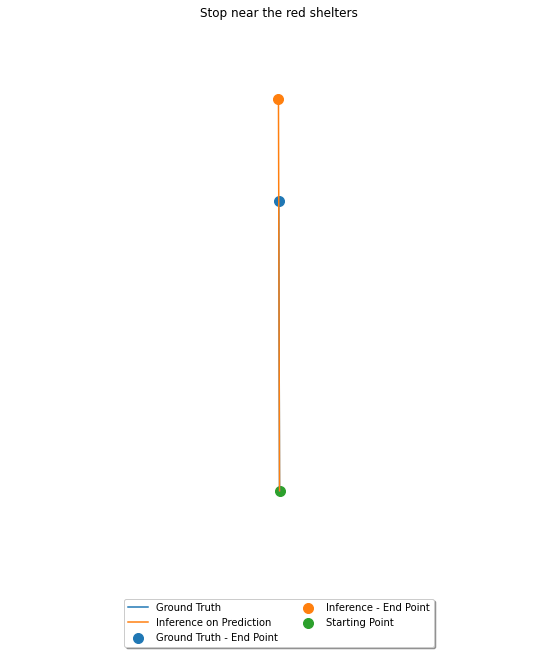

(127, 3) (127, 3)
Episode 19: Turn left from the intersection
Frechet Distance: 14.958527858630832
FDE Distance: 14.958527858630832
ADE Distance: 8.91353594958469
ADE Matched Distance: 0.5000660657941178
nDTW Distance: 0.6214788546397394
TC Distance: False


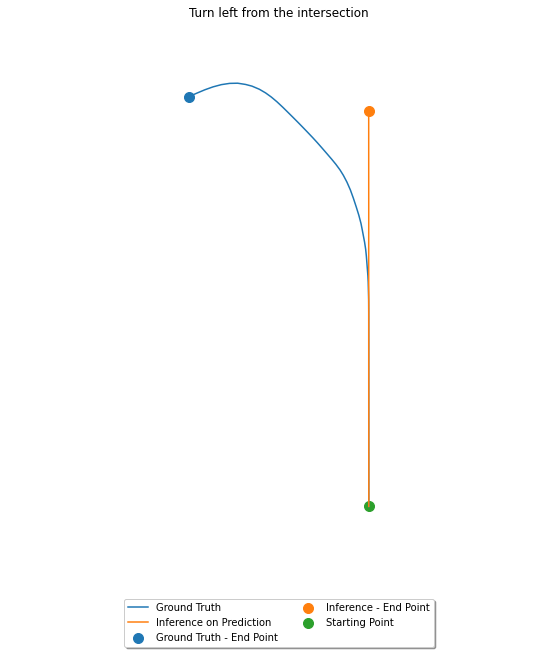

(127, 3) (127, 3)
Episode 20: Drive straight then turn right
Frechet Distance: 5.869629195004398
FDE Distance: 5.869629195004397
ADE Distance: 4.104189438559684
ADE Matched Distance: 0.4940127749030362
nDTW Distance: 0.7274638983638183
TC Distance: False


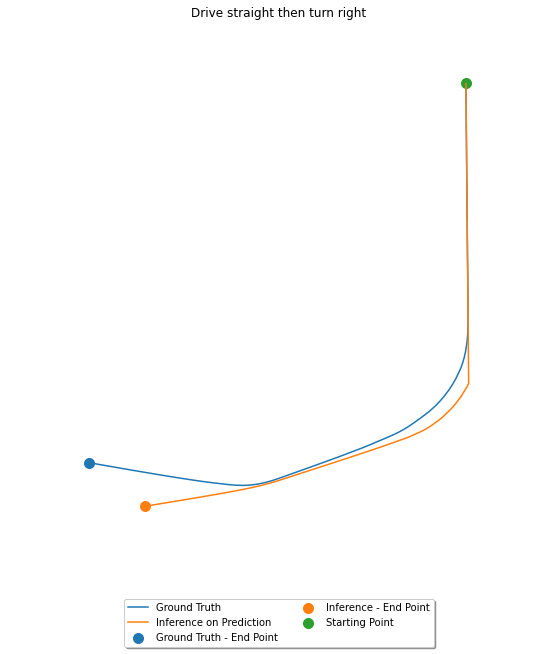

(36, 3) (36, 3)
Episode 21: Park near the hut visible on the right
Frechet Distance: 3.301101618035883
FDE Distance: 3.301101618035883
ADE Distance: 1.9325104722879989
ADE Matched Distance: 0.4567560332240104
nDTW Distance: 0.8080326478644182
TC Distance: True


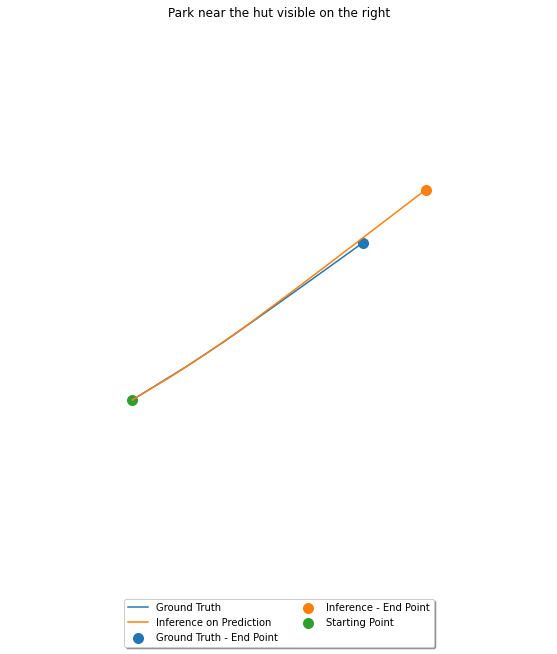

(170, 3) (170, 3)
Episode 22: Go straight and stop before the traffic light.
Frechet Distance: 18.890047461973513
FDE Distance: 18.890047461973516
ADE Distance: 16.172845244894688
ADE Matched Distance: 2.9217131737928526
nDTW Distance: 0.1639776963724648
TC Distance: False


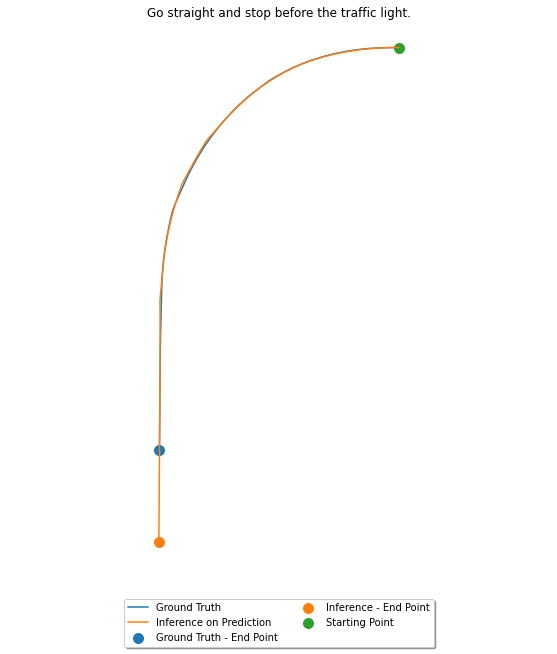

(136, 3) (136, 3)
Episode 23: stop at the bus stand in front
Frechet Distance: 16.67356110854315
FDE Distance: 16.67356110854315
ADE Distance: 10.22558111689182
ADE Matched Distance: 0.6296646039969835
nDTW Distance: 0.7225143100128717
TC Distance: False


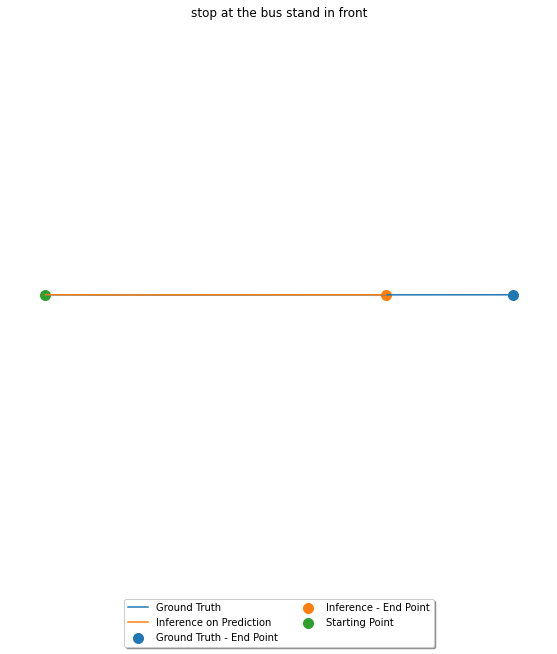

(66, 3) (66, 3)
Episode 24: Turn right from the intersection.
Frechet Distance: 1.4556376959438118
FDE Distance: 1.4556376959438118
ADE Distance: 1.615711582878065
ADE Matched Distance: 0.28653614243005576
nDTW Distance: 0.8832335107801529
TC Distance: True


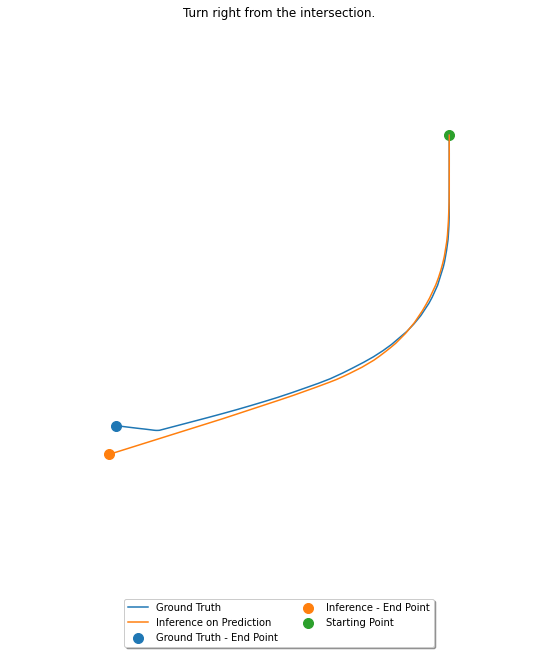

In [42]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/val/'
val_run_path = '/ssd_scratch/cvit/varunc/val_clip_6frames/'
save_loc = '../trajectories_val_clip6/'

frechet_val_clip_6,fde_val_clip_6,ade_val_clip_6, ade_matched_val_clip_6, ndtw_val_clip_6, tc_val_clip_6 = get_scores(val_data_path, val_run_path, save_loc,episodes=list(range(25)))

(58, 3) (58, 3)
Episode 0: Stop before the next right turn.
Frechet Distance: 289.5359727101078
FDE Distance: 289.5359727101078
ADE Distance: 279.19233697593074
ADE Matched Distance: 273.3042236483292
nDTW Distance: 1.7001491379964435e-272
TC Distance: False


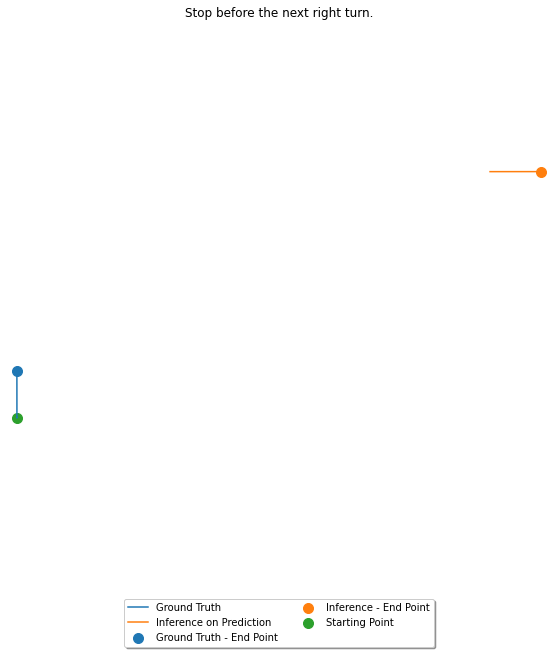

(45, 3) (45, 3)
Episode 1: After crossing the blue car come to a stop
Frechet Distance: 11.244383240717495
FDE Distance: 11.244383240717495
ADE Distance: 4.48245865975365
ADE Matched Distance: 1.704707179088633
nDTW Distance: 0.38204667321761193
TC Distance: False


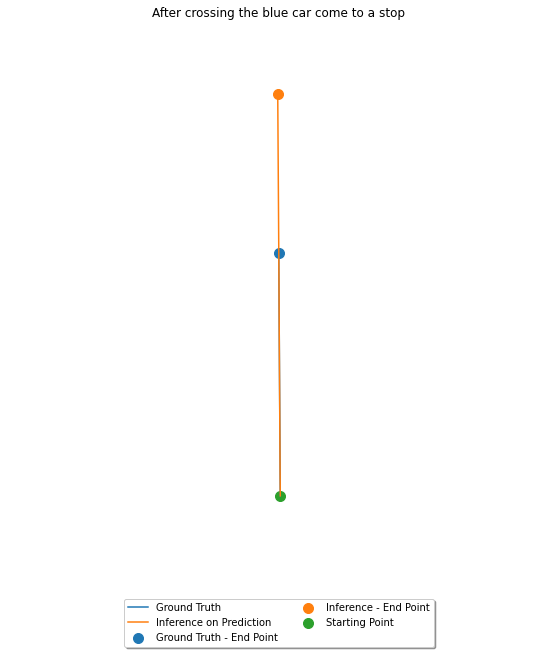

(109, 3) (109, 3)
Episode 2: stop beside the black suv
Frechet Distance: 0.9799679056257724
FDE Distance: 0.9799679056257724
ADE Distance: 2.268488184573349
ADE Matched Distance: 0.11270105182259373
nDTW Distance: 0.9614715775243466
TC Distance: True


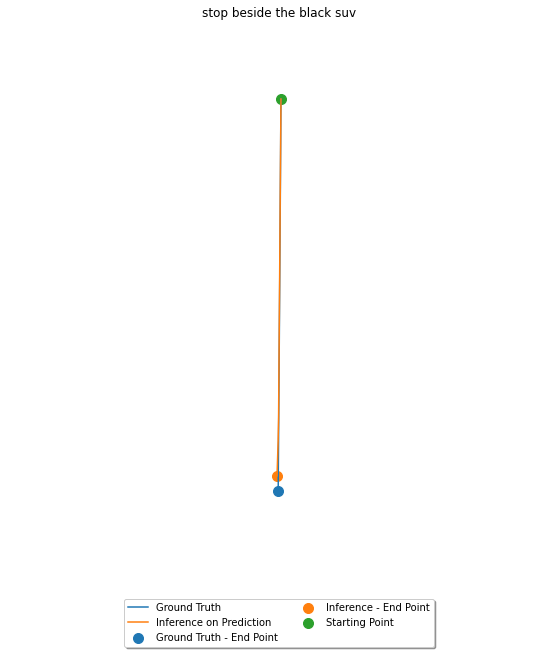

(38, 3) (38, 3)
Episode 3: Stop near the signboard
Frechet Distance: 2.3202248617807157
FDE Distance: 2.3202248617807153
ADE Distance: 1.4103222464704699
ADE Matched Distance: 0.24470090084280155
nDTW Distance: 0.8859785390662455
TC Distance: True


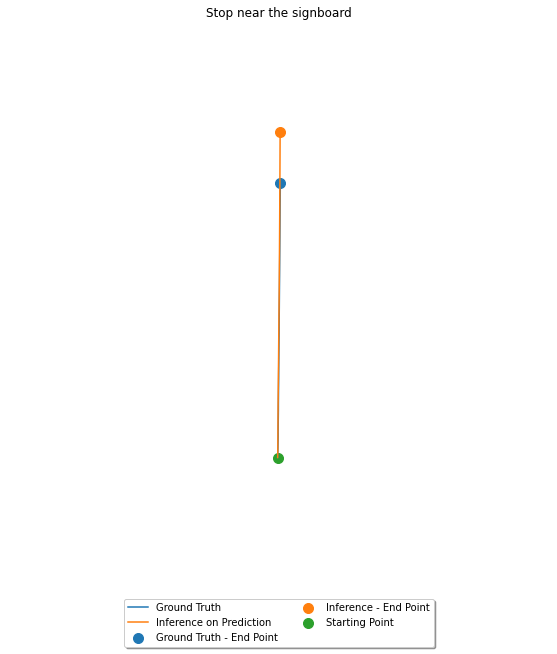

(82, 3) (82, 3)
Episode 4: Take a left at the traffic light
Frechet Distance: 3.2668516526350047
FDE Distance: 3.2668516526350047
ADE Distance: 1.1030430325661695
ADE Matched Distance: 0.19479404082679844
nDTW Distance: 0.9347602000107382
TC Distance: True


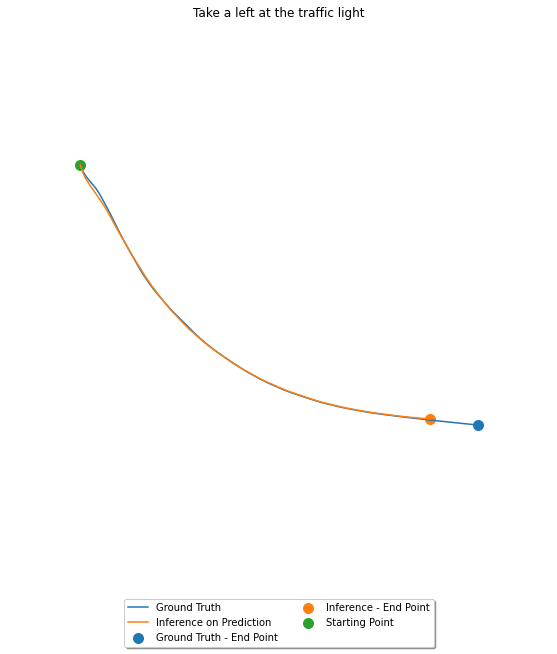

(57, 3) (57, 3)
Episode 5: Turn right from the intersection
Frechet Distance: 5.893298083657999
FDE Distance: 5.893298083657999
ADE Distance: 1.8035224729231392
ADE Matched Distance: 0.5900597498081411
nDTW Distance: 0.7561602255114219
TC Distance: False


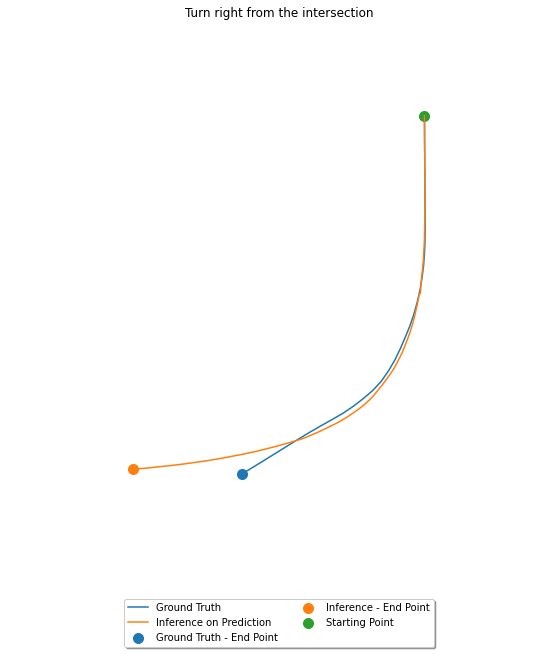

(91, 3) (91, 3)
Episode 6: Take a left from the intersection ahead
Frechet Distance: 4.356750893271458
FDE Distance: 4.356750893271458
ADE Distance: 3.9240766386651864
ADE Matched Distance: 0.9627861621410074
nDTW Distance: 0.6264796463518497
TC Distance: True


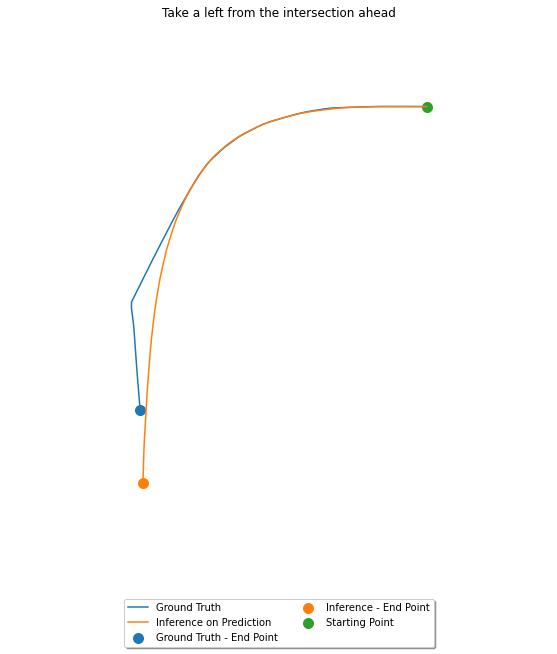

(61, 3) (61, 3)
Episode 7: Drive to the corner and go right
Frechet Distance: 26.428901456967285
FDE Distance: 26.428901456967285
ADE Distance: 8.666677735753916
ADE Matched Distance: 4.027028632127736
nDTW Distance: 0.09164705538307363
TC Distance: False


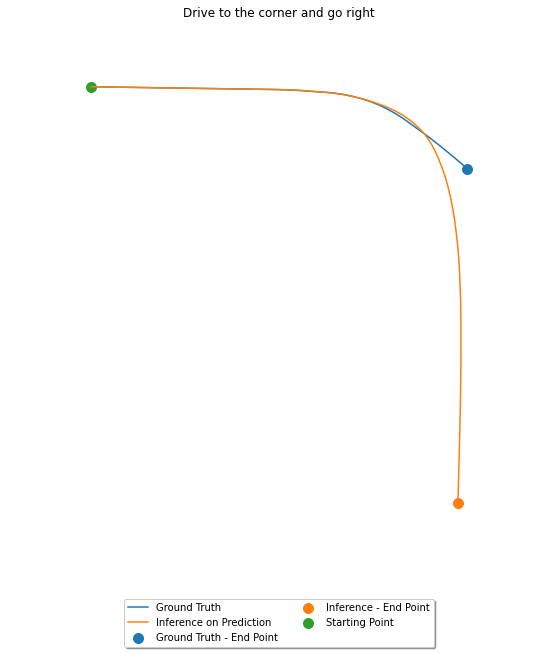

(83, 3) (83, 3)
Episode 8: Drive to the intersection and turn left
Frechet Distance: 9.317058335266461
FDE Distance: 9.317058335266461
ADE Distance: 3.3730213258972914
ADE Matched Distance: 0.8663751427634475
nDTW Distance: 0.7027085806092009
TC Distance: False


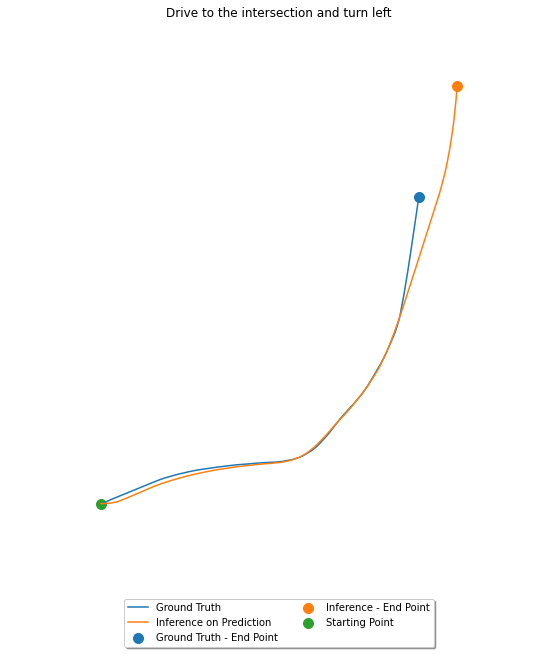

(177, 3) (177, 3)
Episode 9: Go straight and stop a few metres ahead of the bus stop
Frechet Distance: 3.098182922677559
FDE Distance: 3.098182922677559
ADE Distance: 8.115138575142634
ADE Matched Distance: 0.18928223425633967
nDTW Distance: 0.9628511512852208
TC Distance: True


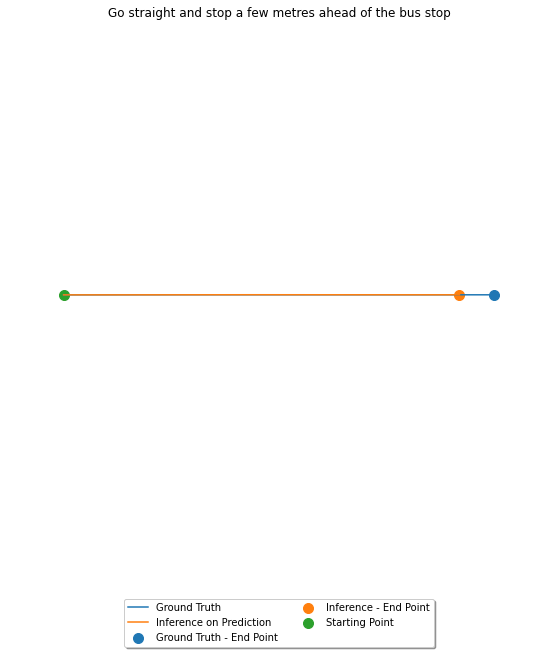

(80, 3) (80, 3)
Episode 10: Stop in front of the garbage dumpsters.
Frechet Distance: 2.574905606142252
FDE Distance: 2.574905606142252
ADE Distance: 3.256946644133513
ADE Matched Distance: 0.1576797181382821
nDTW Distance: 0.9429559641938804
TC Distance: True


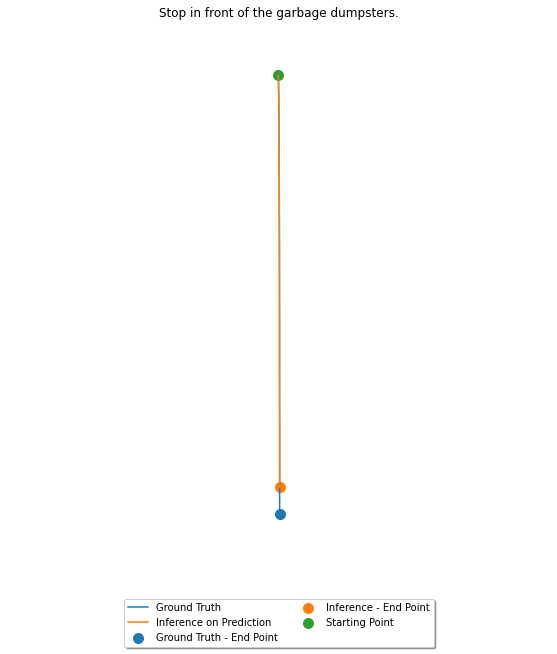

(107, 3) (107, 3)
Episode 11: Go straight and stop next to the grey arch.
Frechet Distance: 39.37425020141003
FDE Distance: 39.37425020141003
ADE Distance: 15.070509192199442
ADE Matched Distance: 9.43306295306722
nDTW Distance: 0.06977943787694336
TC Distance: False


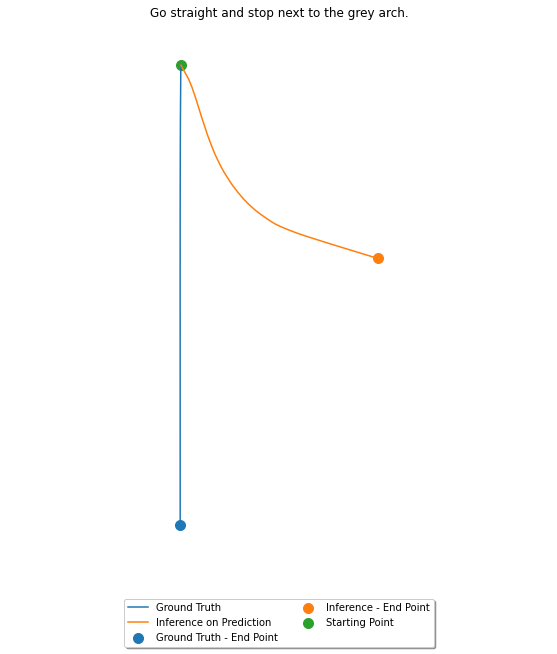

(66, 3) (66, 3)
Episode 12: Change lanes and stop at the junction.
Frechet Distance: 12.074255658160272
FDE Distance: 12.074255658160272
ADE Distance: 4.895097757089346
ADE Matched Distance: 3.1413438928796538
nDTW Distance: 0.2587922154196434
TC Distance: False


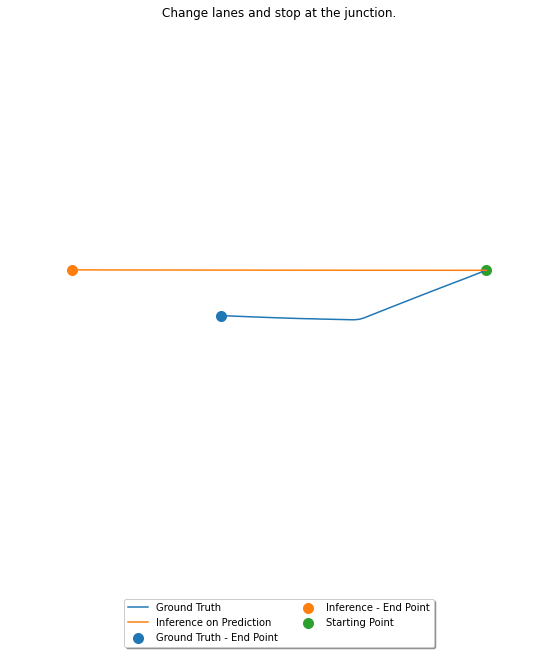

(60, 3) (60, 3)
Episode 13: Park on the roadside after you have crossed the bus stop
Frechet Distance: 13.235917497971958
FDE Distance: 13.23591749797196
ADE Distance: 5.263563310105659
ADE Matched Distance: 2.4884657930663976
nDTW Distance: 0.20851726203577328
TC Distance: False


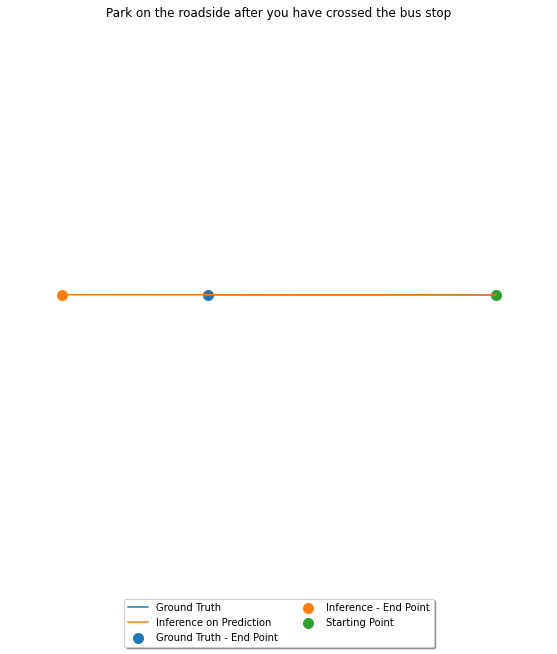

(452, 3) (452, 3)
Episode 14: Wait for the signal to turn green and continue straight
Frechet Distance: 28.93699635577502
FDE Distance: 28.93699635577502
ADE Distance: 3.664705587389743
ADE Matched Distance: 1.472104531724757
nDTW Distance: 0.6831412677144174
TC Distance: False


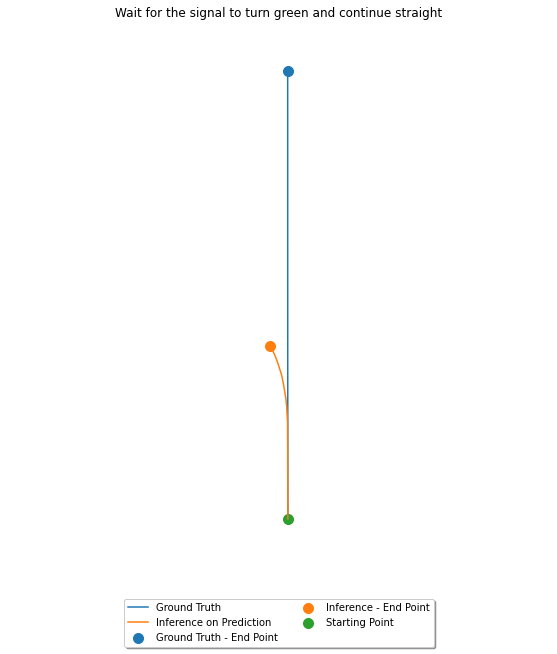

(63, 3) (63, 3)
Episode 15: Drive towards the bus stop and park after crossing it
Frechet Distance: 1.9442843694884497
FDE Distance: 1.9442843694884495
ADE Distance: 3.7628471877660163
ADE Matched Distance: 0.13394131896192055
nDTW Distance: 0.9446146505235758
TC Distance: True


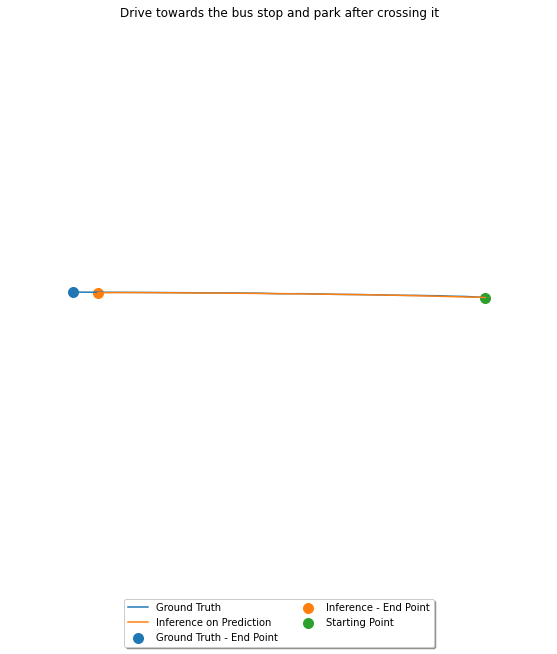

(81, 3) (81, 3)
Episode 16: take a right turn and stop across the bench on left
Frechet Distance: 3.1764986008763008
FDE Distance: 3.176498600876301
ADE Distance: 2.3095903193720586
ADE Matched Distance: 0.2704379919006537
nDTW Distance: 0.8732329938670487
TC Distance: True


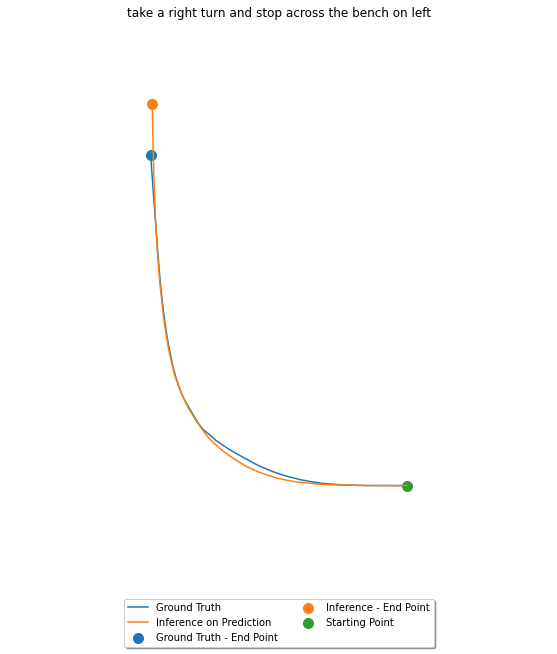

(61, 3) (61, 3)
Episode 17: Turn right from the crossroads ahead
Frechet Distance: 17.492453152472066
FDE Distance: 17.492453152472066
ADE Distance: 6.50043475524779
ADE Matched Distance: 4.022449369958488
nDTW Distance: 0.09069244123875525
TC Distance: False


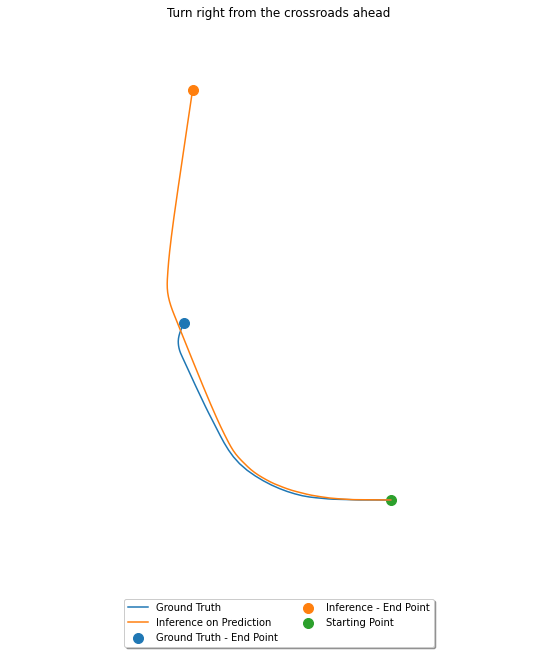

(156, 3) (156, 3)
Episode 18: Turn right and park near the sidewalk.
Frechet Distance: 52.14609446114805
FDE Distance: 3.6967815832184288
ADE Distance: 36.57157848380744
ADE Matched Distance: 33.34082753722543
nDTW Distance: 2.2576978414703938e-30
TC Distance: True


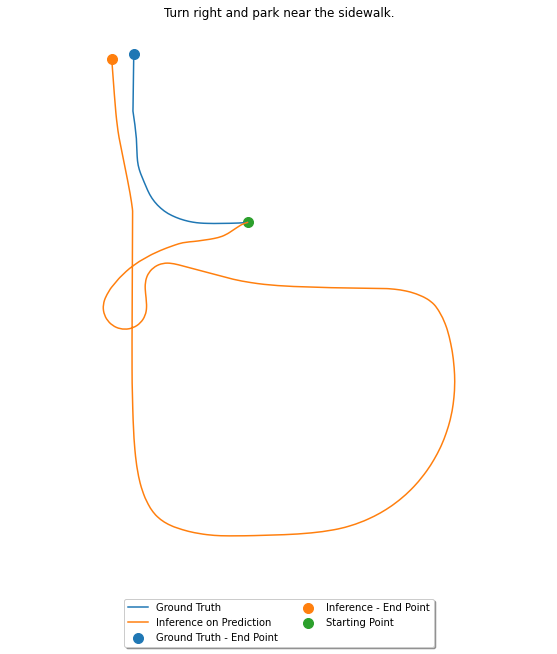

(136, 3) (136, 3)
Episode 19: go straight and take a right
Frechet Distance: 7.550306899089149
FDE Distance: 7.550306899089149
ADE Distance: 3.67683823338298
ADE Matched Distance: 1.1898034427818553
nDTW Distance: 0.6900862284734395
TC Distance: False


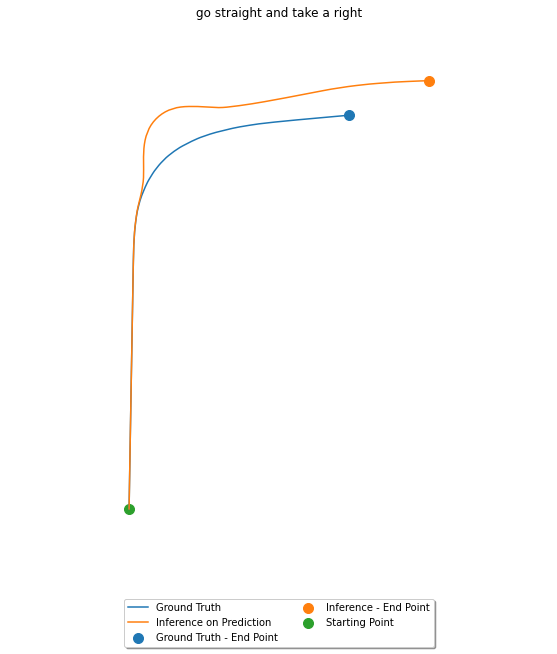

(42, 3) (42, 3)
Episode 20: park beside the red volkswagen
Frechet Distance: 9.763152847526246
FDE Distance: 9.763152847526246
ADE Distance: 3.070357855649623
ADE Matched Distance: 1.4017213150284824
nDTW Distance: 0.4798724332142486
TC Distance: False


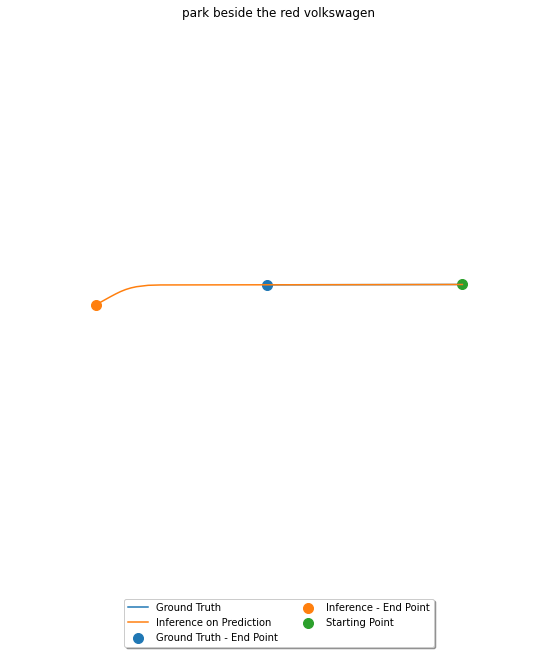

(147, 3) (147, 3)
Episode 21: Turn left from the next crossroads
Frechet Distance: 12.062184856671966
FDE Distance: 12.062184856671966
ADE Distance: 6.743260293431597
ADE Matched Distance: 0.44398995869851104
nDTW Distance: 0.5602897691298593
TC Distance: False


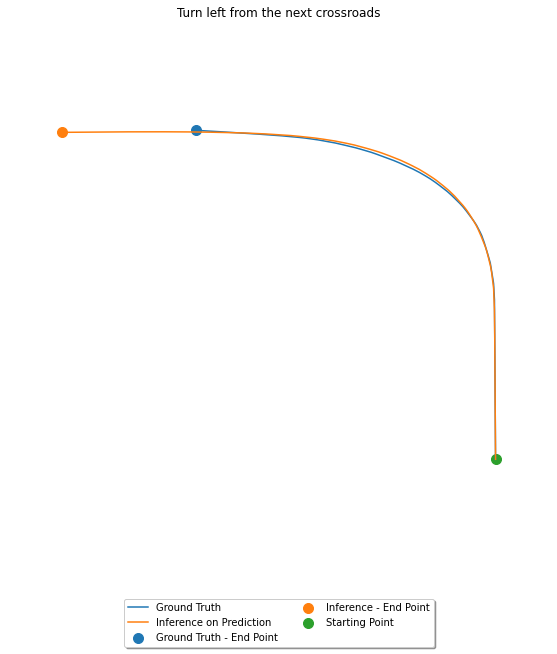

(66, 3) (66, 3)
Episode 22: Turn right from the crossroads.
Frechet Distance: 5.369668918853363
FDE Distance: 5.369668918853363
ADE Distance: 2.2069356371167
ADE Matched Distance: 0.5624979669774022
nDTW Distance: 0.7704392193935654
TC Distance: False


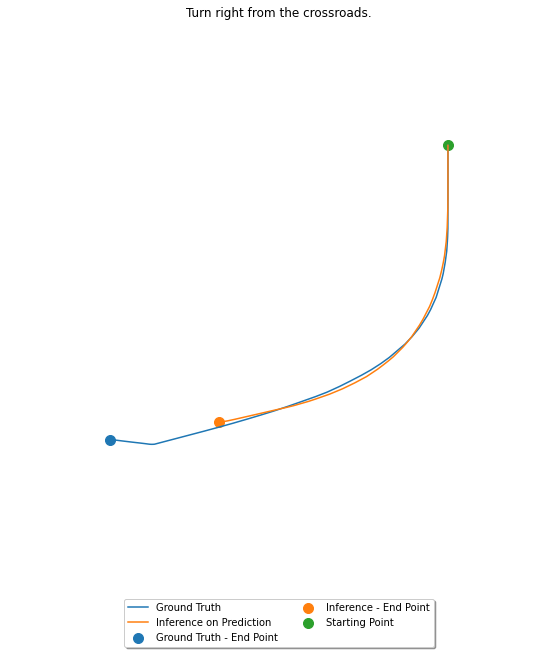

(71, 3) (71, 3)
Episode 23: stop by the lamp post
Frechet Distance: 9.204152843598298
FDE Distance: 9.204152843598298
ADE Distance: 6.665136279898149
ADE Matched Distance: 1.121148427040731
nDTW Distance: 0.5717833424879379
TC Distance: False


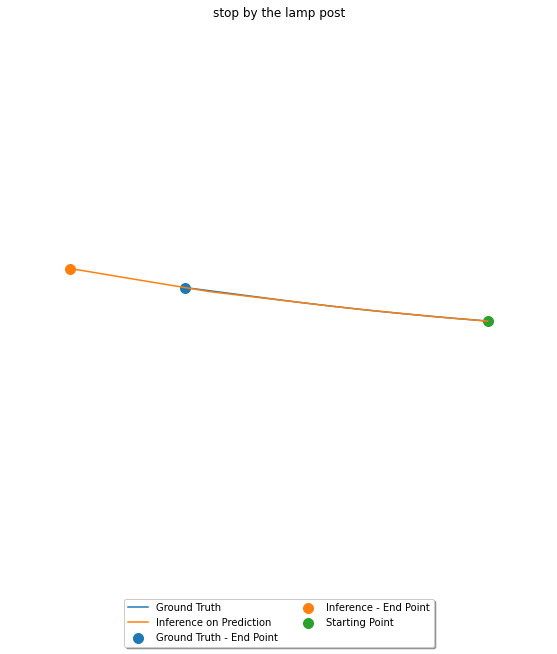

(50, 3) (50, 3)
Episode 24: park immediately after the signboard
Frechet Distance: 1.9351348911650639
FDE Distance: 1.9351348911650639
ADE Distance: 1.9997158699442763
ADE Matched Distance: 0.1081693874705114
nDTW Distance: 0.9601443034825727
TC Distance: True


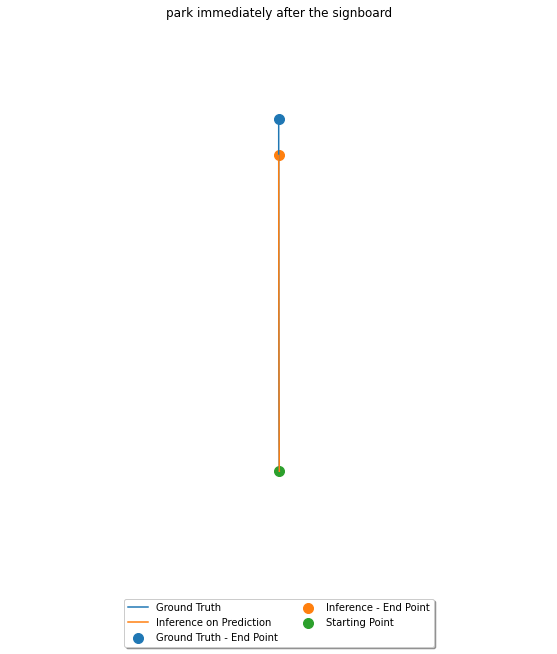

(176, 3) (176, 3)
Episode 25: Turn right and stop beside the traffic signal
Frechet Distance: 6.591470891868005
FDE Distance: 6.591470891868005
ADE Distance: 10.932859896983727
ADE Matched Distance: 0.4420902155738211
nDTW Distance: 0.8463785326464535
TC Distance: False


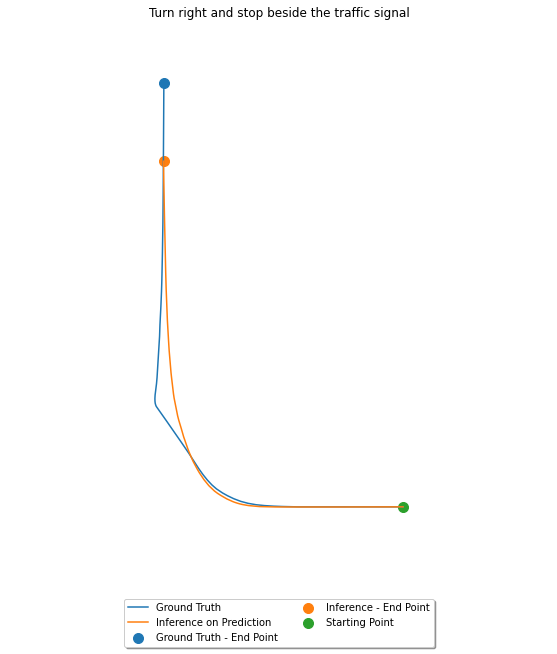

(398, 3) (398, 3)
Episode 26: Turn left and stop near the traffic signal
Frechet Distance: 10.34281159909459
FDE Distance: 10.34281159909459
ADE Distance: 15.72117967570677
ADE Matched Distance: 0.5835690680225394
nDTW Distance: 0.889839816776495
TC Distance: False


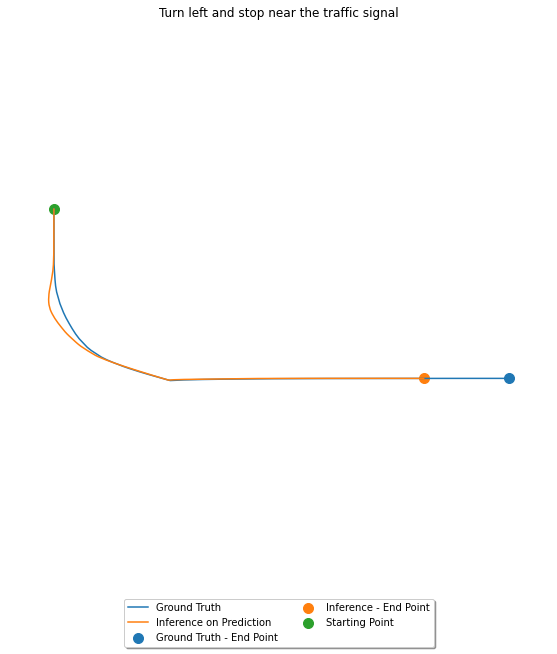

(358, 3) (358, 3)
Episode 27: Turn left and stop near the intersection
Frechet Distance: 8.325129479407924
FDE Distance: 8.325129479407924
ADE Distance: 31.62343043879363
ADE Matched Distance: 2.658515517855259
nDTW Distance: 0.5423172425770337
TC Distance: False


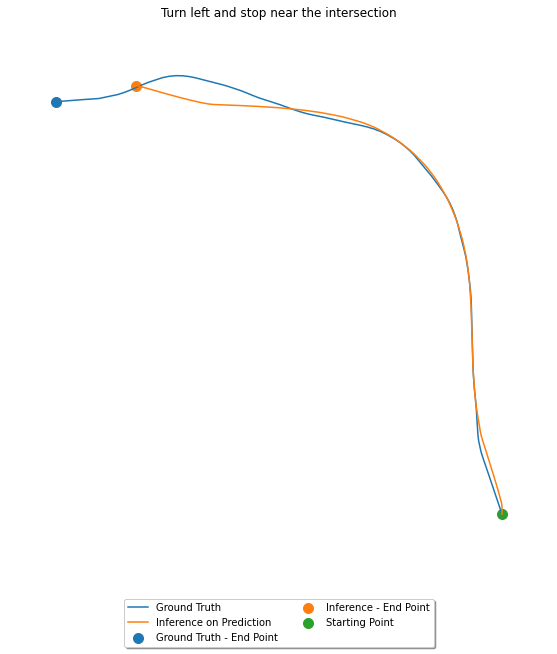

(501, 3) (501, 3)
Episode 28: Turn left and come to a halt at the intersection
Frechet Distance: 38.42952985929697
FDE Distance: 38.42952985929696
ADE Distance: 15.131845393960154
ADE Matched Distance: 2.822385533498976
nDTW Distance: 0.5686574161837058
TC Distance: False


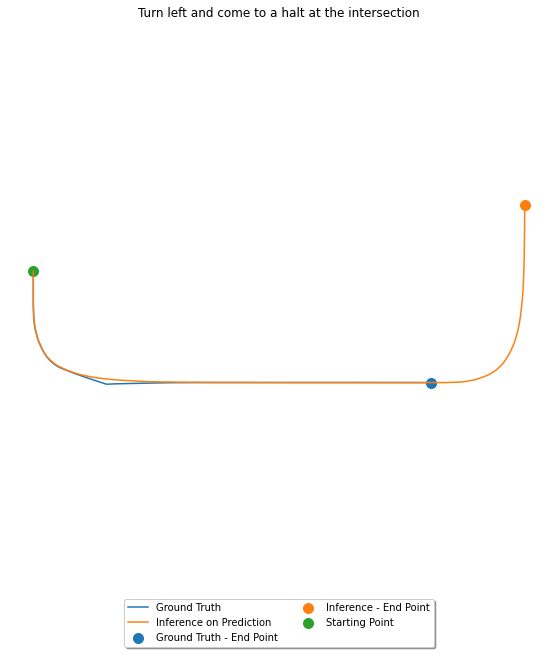

(194, 3) (194, 3)
Episode 29: Turn right and stop before the traffic signal
Frechet Distance: 4.644824785026458
FDE Distance: 4.644824785026458
ADE Distance: 4.591921541228189
ADE Matched Distance: 0.9036502328784043
nDTW Distance: 0.751962335139817
TC Distance: True


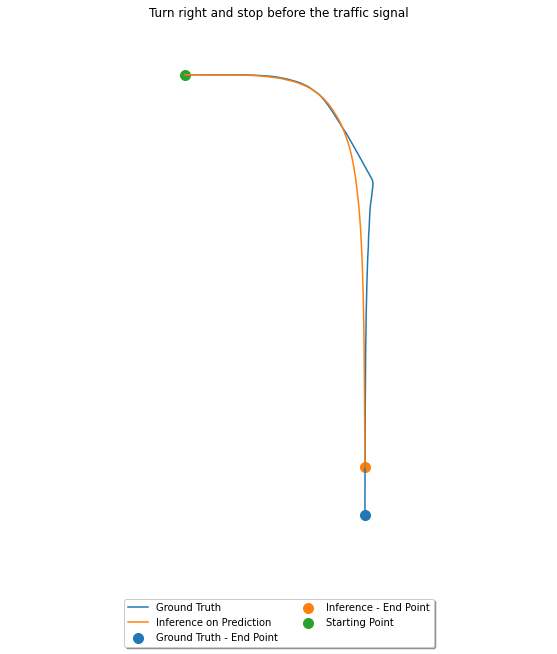

(153, 3) (153, 3)
Episode 30: Turn right and stop just before the traffic signal
Frechet Distance: 72.26843250110707
FDE Distance: 72.26843250110707
ADE Distance: 36.02635429431679
ADE Matched Distance: 28.101156004199172
nDTW Distance: 9.505279841918934e-18
TC Distance: False


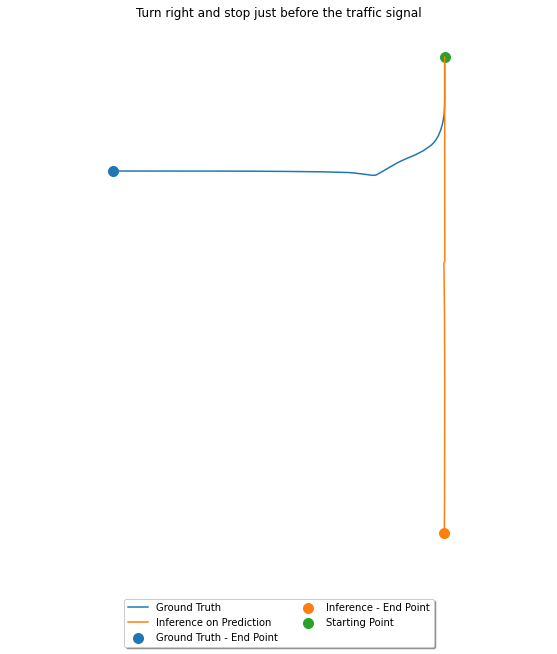

(216, 3) (216, 3)
Episode 31: Turn right and stop near the bus stop
Frechet Distance: 38.09871333687723
FDE Distance: 38.09871333687723
ADE Distance: 14.910618263962604
ADE Matched Distance: 10.330482187120856
nDTW Distance: 0.03653149899483008
TC Distance: False


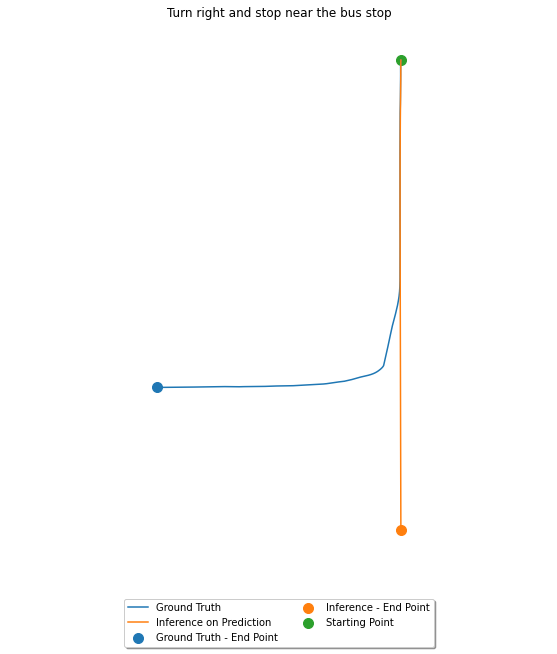

(188, 3) (188, 3)
Episode 32: Turn left and stop beside the traffic signal
Frechet Distance: 6.047905581424782
FDE Distance: 6.047905581424782
ADE Distance: 13.429729278596026
ADE Matched Distance: 0.09219189129959515
nDTW Distance: 0.9289917352892718
TC Distance: False


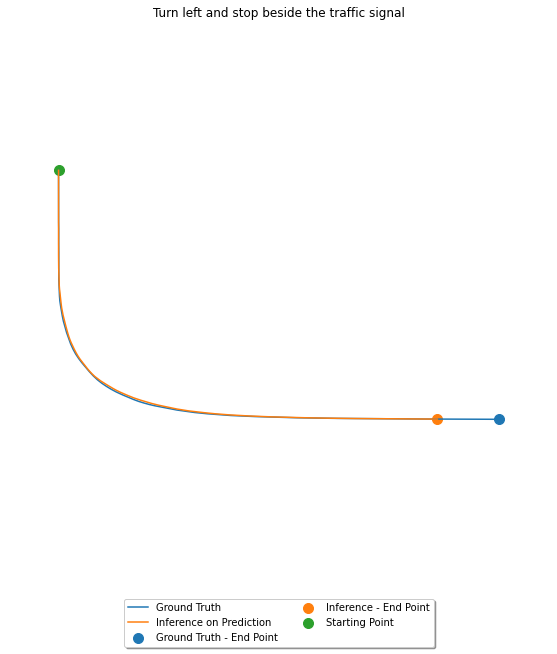

(166, 3) (166, 3)
Episode 33: Turn left and stop near the traffic signal
Frechet Distance: 43.341300475553865
FDE Distance: 43.341300475553865
ADE Distance: 29.794002790028987
ADE Matched Distance: 2.5482097901704694
nDTW Distance: 0.1393139970323864
TC Distance: False


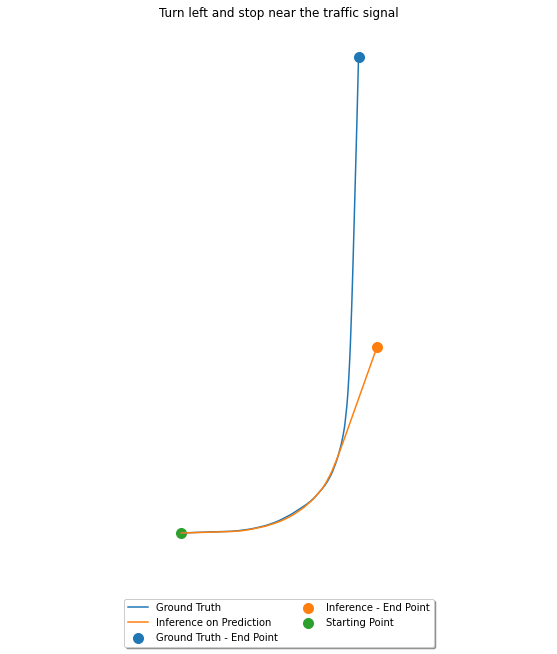

In [46]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/test/'
val_run_path = '/ssd_scratch/cvit/varunc/test_clip_6frames/'
save_loc = '../trajectories_test_clip6/'

frechet_test_clip_6,fde_test_clip_6,ade_test_clip_6, ade_matched_test_clip_6, ndtw_test_clip_6, tc_test_clip_6 = get_scores(val_data_path, val_run_path, save_loc,episodes=list(range(34)))

(364, 3) (364, 3)
Episode 0: Turn left and stop next to the bus stop.
Frechet Distance: 46.105773227392675
FDE Distance: 46.105773227392675
ADE Distance: 4.745712995220007
ADE Matched Distance: 3.1399772897539617
nDTW Distance: 0.5336604744096208
TC Distance: False


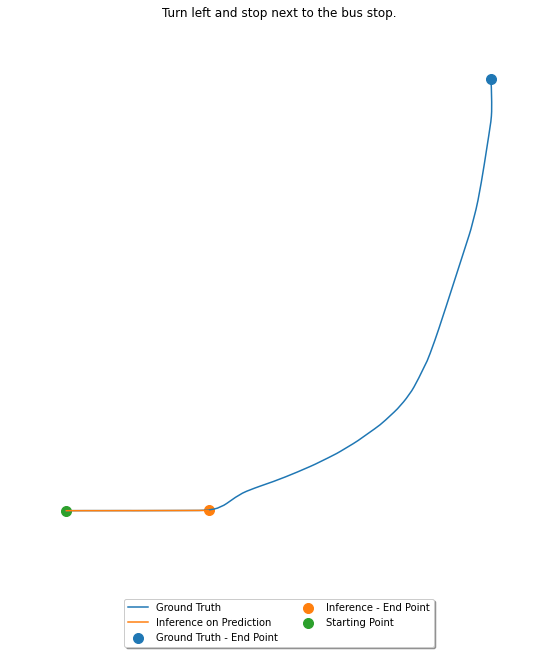

(94, 3) (94, 3)
Episode 1: Take a left from the interection.
Frechet Distance: 3.3662672020830233
FDE Distance: 3.3662672020830233
ADE Distance: 4.3549014889607305
ADE Matched Distance: 0.4192606491558427
nDTW Distance: 0.8639026369550553
TC Distance: True


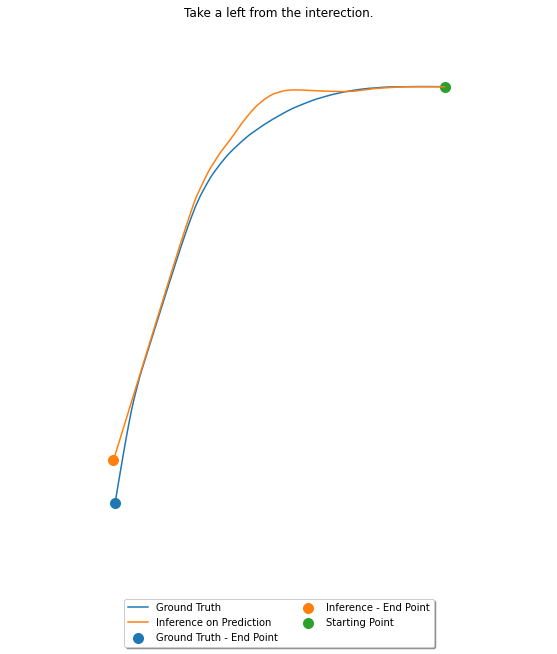

(55, 3) (55, 3)
Episode 2: Drive straight till you see a red coloured board
Frechet Distance: 2.8937378295845715
FDE Distance: 2.8937378295845715
ADE Distance: 5.550932340105299
ADE Matched Distance: 0.17742149680955022
nDTW Distance: 0.8648812689126012
TC Distance: True


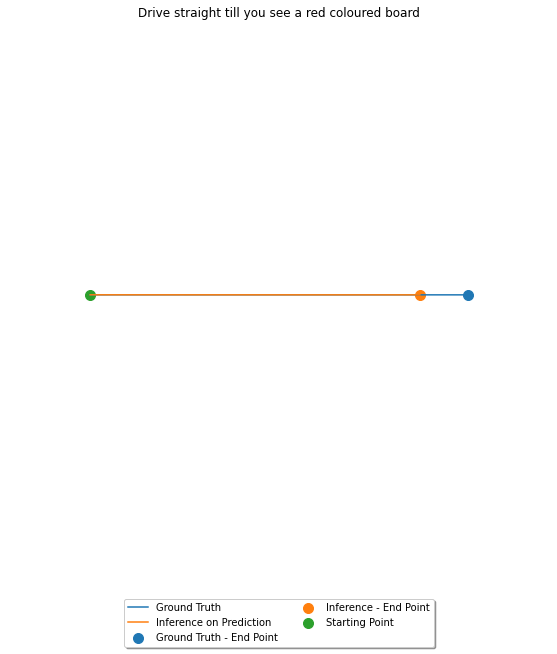

(38, 3) (38, 3)
Episode 3: Park just ahead of the speed signboard
Frechet Distance: 6.04358831626366
FDE Distance: 6.043588316263661
ADE Distance: 1.5353700816708218
ADE Matched Distance: 0.7434570874697337
nDTW Distance: 0.6376363231842228
TC Distance: False


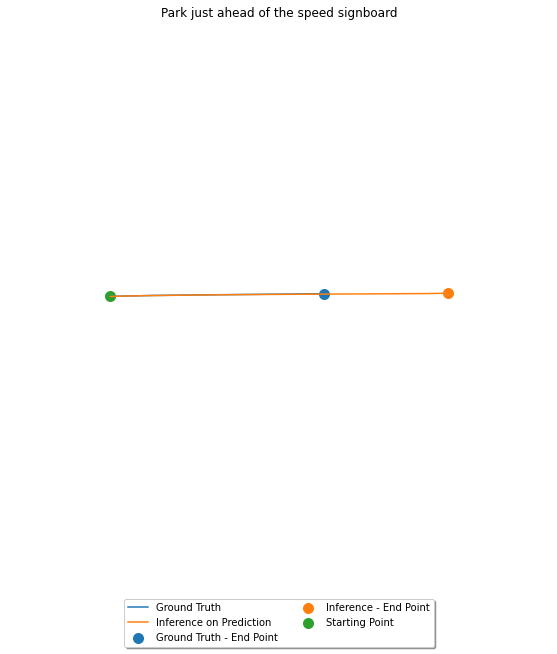

(332, 3) (332, 3)
Episode 4: Take the next right turn.
Frechet Distance: 35.33999393335193
FDE Distance: 35.33999393335193
ADE Distance: 10.256850327279574
ADE Matched Distance: 5.48240726277332
nDTW Distance: 0.30253415406583223
TC Distance: False


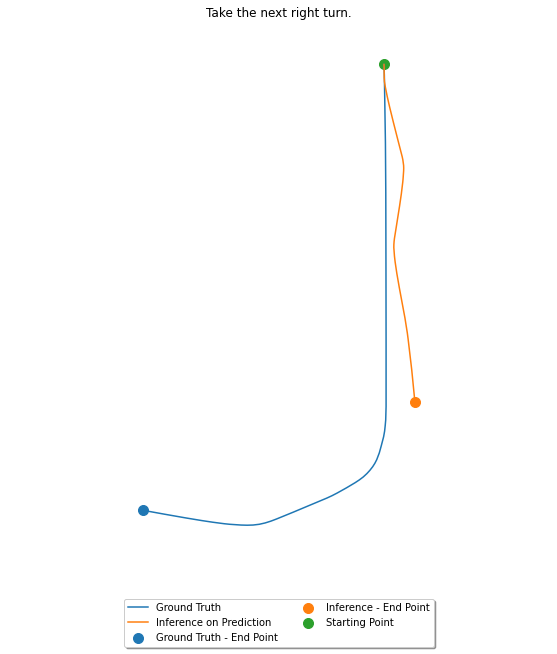

(150, 3) (150, 3)
Episode 5: Drive straight from the next crossroads.
Frechet Distance: 57.45680118027897
FDE Distance: 57.45680118027897
ADE Distance: 21.990350455346892
ADE Matched Distance: 9.659877731570653
nDTW Distance: 0.004771319704189018
TC Distance: False


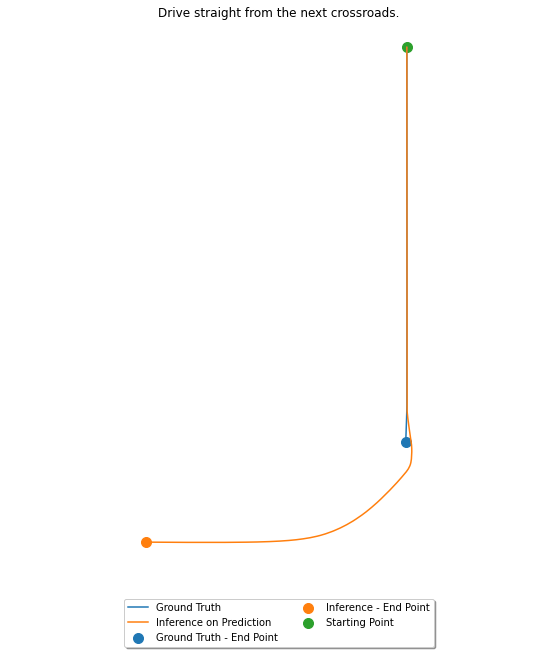

(70, 3) (70, 3)
Episode 6: change to left lane
Frechet Distance: 13.29313286677597
FDE Distance: 13.29313286677597
ADE Distance: 11.513462907543296
ADE Matched Distance: 2.9454703624541336
nDTW Distance: 0.4098120092969727
TC Distance: False


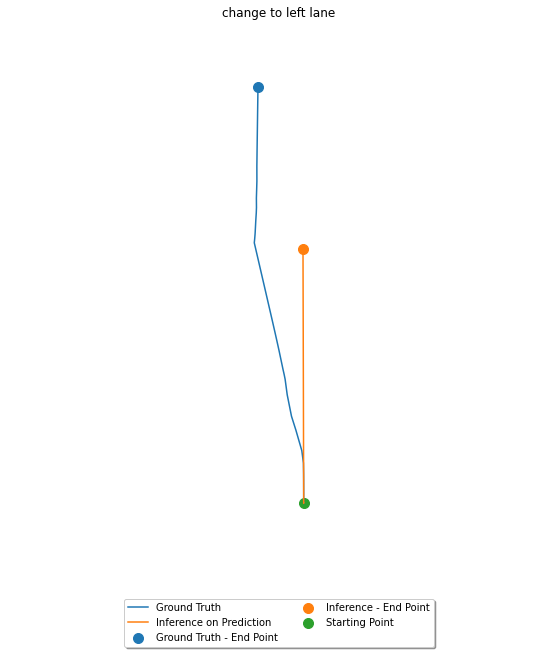

(42, 3) (42, 3)
Episode 7: Stop near the scooty
Frechet Distance: 5.891862617428335
FDE Distance: 5.891862617428334
ADE Distance: 5.151949144869806
ADE Matched Distance: 1.124448531568171
nDTW Distance: 0.5012087142238107
TC Distance: False


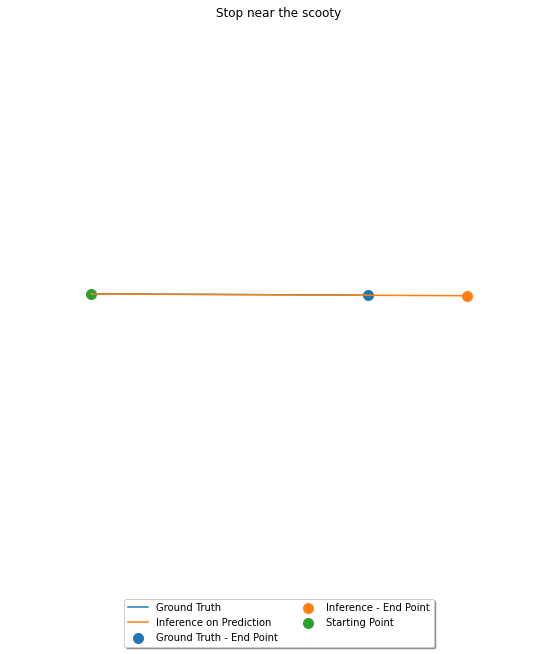

(142, 3) (142, 3)
Episode 8: take right and stop near the speed limit sign
Frechet Distance: 151.84545529267763
FDE Distance: 151.84545529267763
ADE Distance: 62.86428640159965
ADE Matched Distance: 51.12230594086132
nDTW Distance: 1.4874842080155179e-23
TC Distance: False


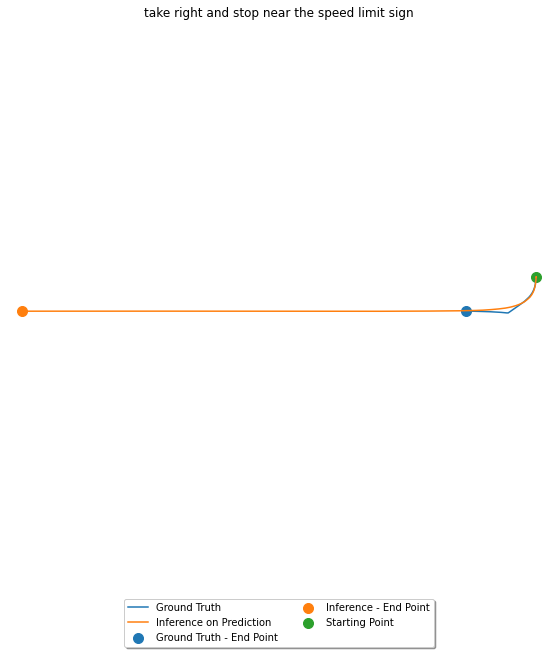

(59, 3) (59, 3)
Episode 9: Turn right and stop near the bus stop.
Frechet Distance: 9.583557818177573
FDE Distance: 9.583557818177573
ADE Distance: 3.7081924168714355
ADE Matched Distance: 1.4502017159647418
nDTW Distance: 0.5124420893472039
TC Distance: False


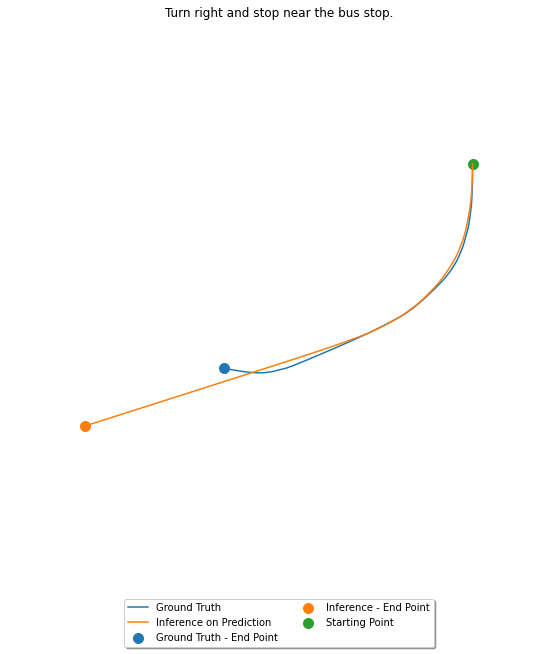

(66, 3) (66, 3)
Episode 10: Shift to the left lane and stop at the intersection.
Frechet Distance: 3.880837264304907
FDE Distance: 3.880837264304907
ADE Distance: 3.3792395702315488
ADE Matched Distance: 1.741111659695256
nDTW Distance: 0.5451190690150824
TC Distance: True


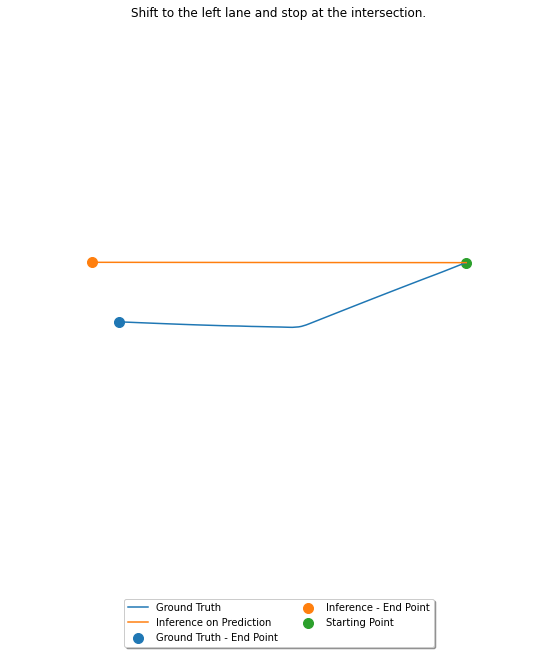

(45, 3) (45, 3)
Episode 11: Stop after crossing the stop signboard
Frechet Distance: 7.0899013942602
FDE Distance: 7.0899013942602
ADE Distance: 3.2280826700749867
ADE Matched Distance: 1.2131141138290178
nDTW Distance: 0.5321556063915531
TC Distance: False


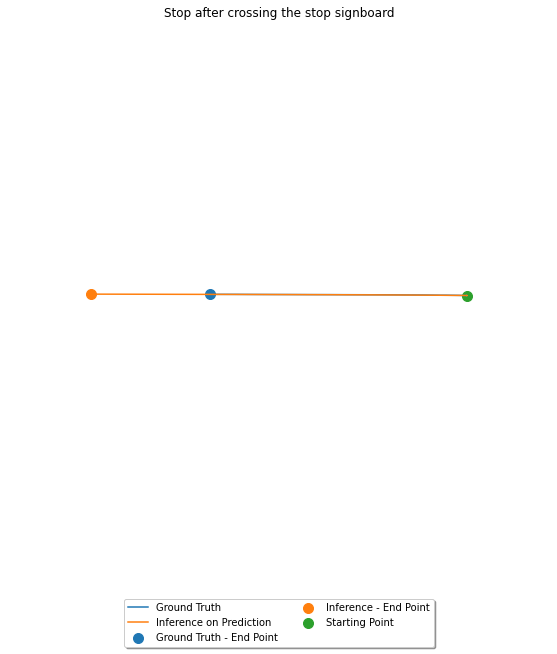

(45, 3) (45, 3)
Episode 12: Park near the red signboard
Frechet Distance: 13.971223052934956
FDE Distance: 13.971223052934956
ADE Distance: 3.5080788861189753
ADE Matched Distance: 2.0130877988958917
nDTW Distance: 0.018995632406097616
TC Distance: False


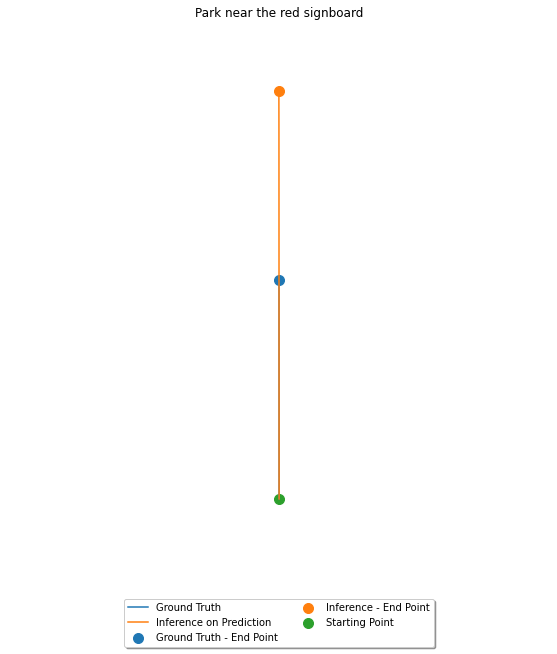

(340, 3) (340, 3)
Episode 13: Wait at the traffic light then go straight.
Frechet Distance: 83.95945581463386
FDE Distance: 83.95945581463386
ADE Distance: 17.837992421428375
ADE Matched Distance: 10.588216143322697
nDTW Distance: 0.03114200034304186
TC Distance: False


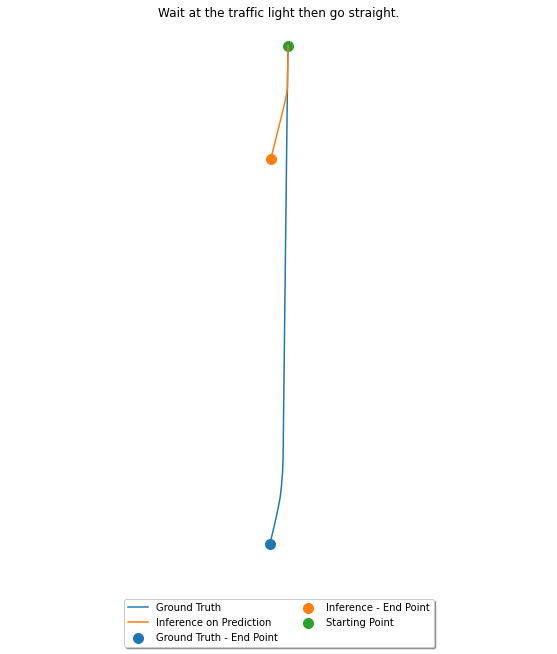

(73, 3) (73, 3)
Episode 14: Drive straight till the intersection and then turn left
Frechet Distance: 12.161433997846839
FDE Distance: 12.161433997846839
ADE Distance: 7.9096327125119865
ADE Matched Distance: 0.37920525211622913
nDTW Distance: 0.6703310245634408
TC Distance: False


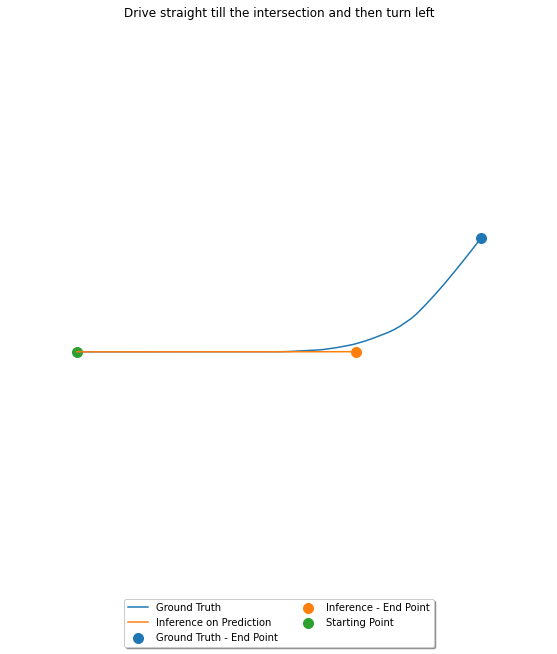

(239, 3) (239, 3)
Episode 15: go straight and take a left
Frechet Distance: 230.7500591056807
FDE Distance: 230.7500591056807
ADE Distance: 120.90243886859304
ADE Matched Distance: 89.24614849974472
nDTW Distance: 2.8617639532235375e-47
TC Distance: False


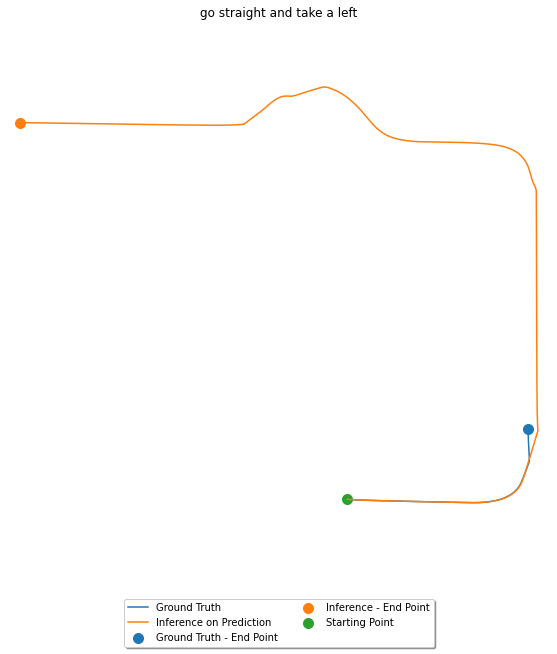

(47, 3) (47, 3)
Episode 16: Stop as soon as you encounter a white car
Frechet Distance: 1.7001118250845144
FDE Distance: 1.7001118250845144
ADE Distance: 1.0904727638278464
ADE Matched Distance: 0.1270835176872123
nDTW Distance: 0.937674007619559
TC Distance: True


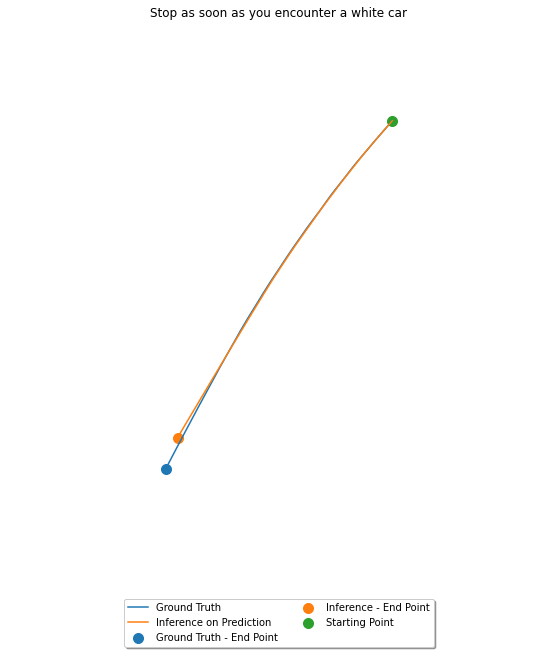

(105, 3) (105, 3)
Episode 17: take a right at the intersection
Frechet Distance: 42.79347740780253
FDE Distance: 42.79347740780253
ADE Distance: 16.584907555555336
ADE Matched Distance: 7.974036024780481
nDTW Distance: 0.00563179952706997
TC Distance: False


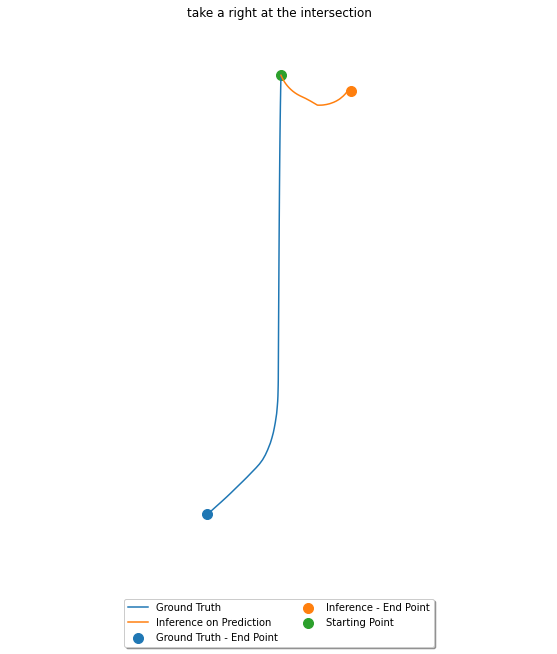

(44, 3) (44, 3)
Episode 18: Stop near the red shelters
Frechet Distance: 3.1737723331842367
FDE Distance: 3.1737723331842367
ADE Distance: 3.195673088020558
ADE Matched Distance: 0.4164830614053492
nDTW Distance: 0.8043610408415055
TC Distance: True


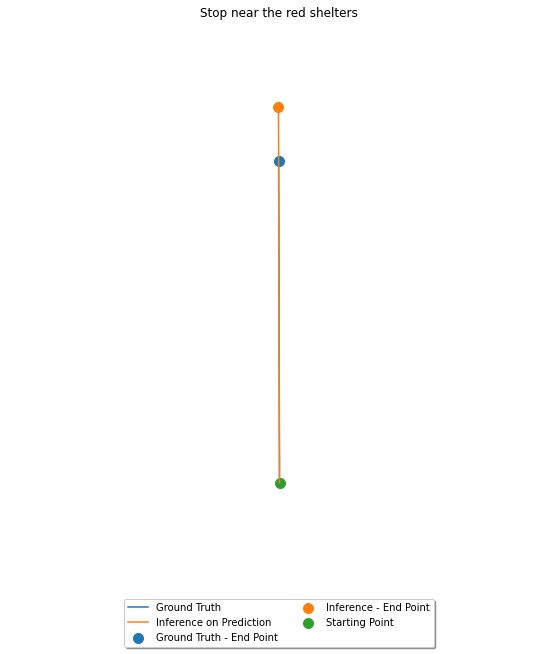

(127, 3) (127, 3)
Episode 19: Turn left from the intersection
Frechet Distance: 296.98877947658707
FDE Distance: 229.16116323646963
ADE Distance: 181.1461600187473
ADE Matched Distance: 155.94432155451702
nDTW Distance: 4.404612384653513e-274
TC Distance: False


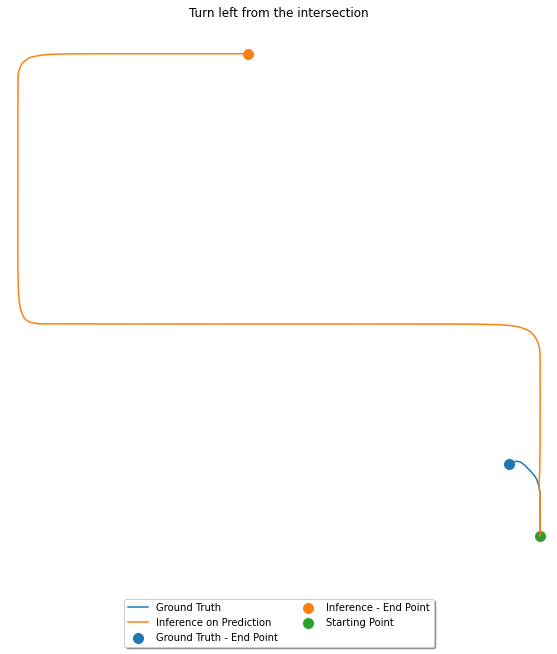

(127, 3) (127, 3)
Episode 20: Drive straight then turn right
Frechet Distance: 34.936026195592646
FDE Distance: 34.936026195592646
ADE Distance: 13.174582849370367
ADE Matched Distance: 8.596225178786847
nDTW Distance: 0.13855957201256341
TC Distance: False


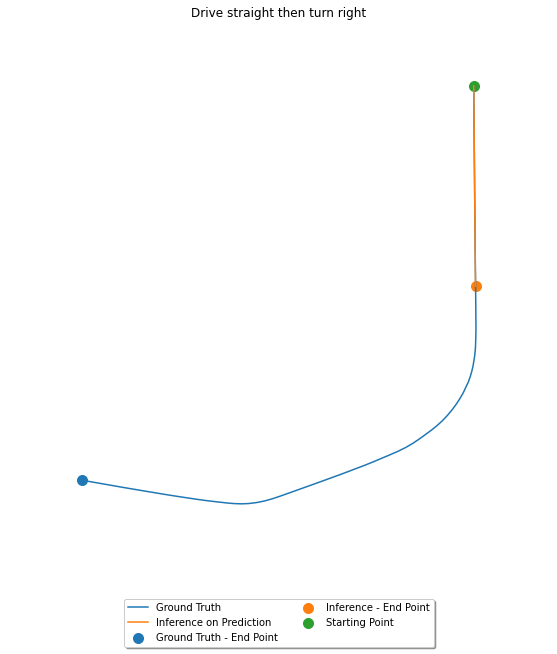

(36, 3) (36, 3)
Episode 21: Park near the hut visible on the right
Frechet Distance: 164.46993022835161
FDE Distance: 164.46993022835164
ADE Distance: 101.33245290117694
ADE Matched Distance: 93.30589033526114
nDTW Distance: 2.729707343472243e-208
TC Distance: False


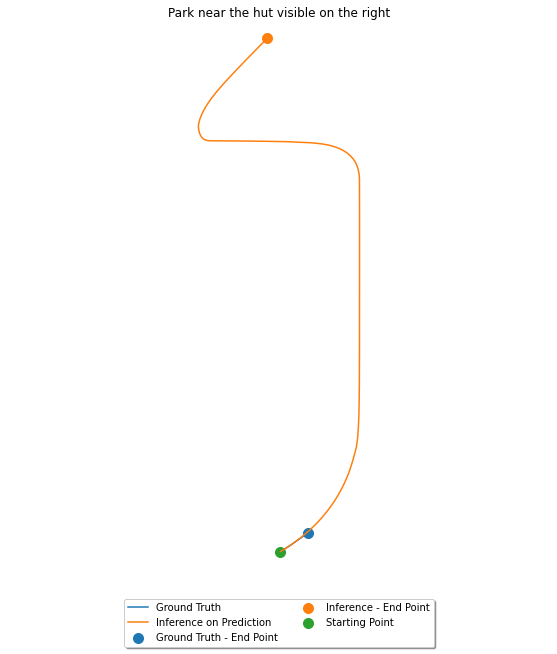

(133, 3) (133, 3)
Episode 22: Go straight and stop before the traffic light.
Frechet Distance: 82.14998139720842
FDE Distance: 82.14998139720842
ADE Distance: 39.49041942335368
ADE Matched Distance: 29.55549681860564
nDTW Distance: 0.0027092068458926246
TC Distance: False


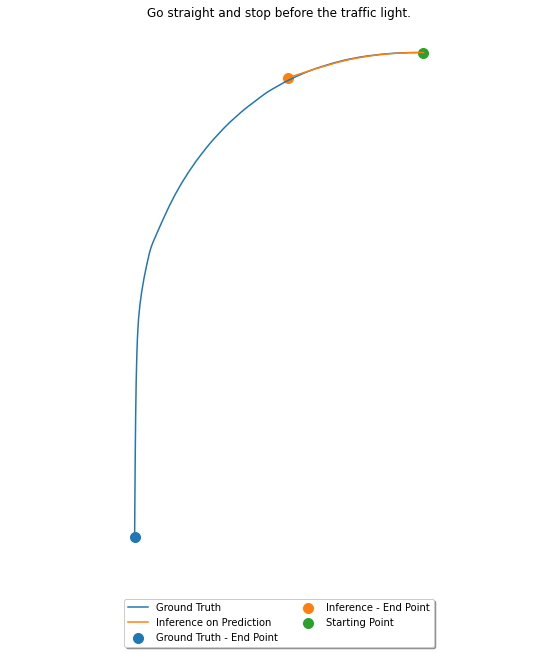

(136, 3) (136, 3)
Episode 23: stop at the bus stand in front
Frechet Distance: 35.39490805897128
FDE Distance: 35.39490805897128
ADE Distance: 10.550373049888064
ADE Matched Distance: 5.918999574792686
nDTW Distance: 0.3061133211717644
TC Distance: False


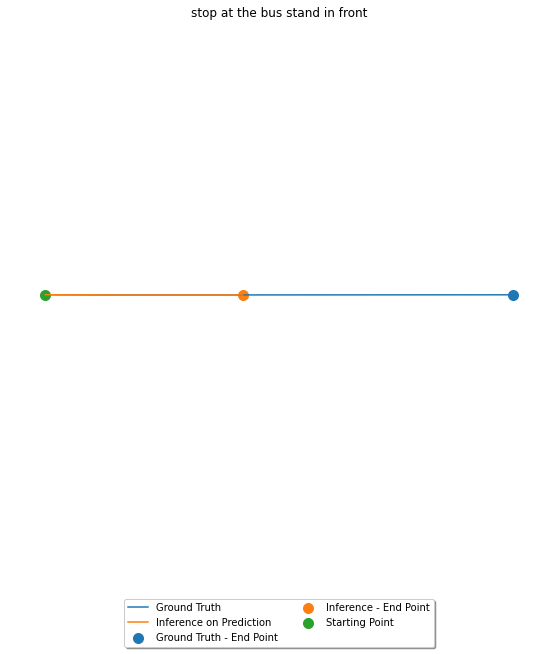

(66, 3) (66, 3)
Episode 24: Turn right from the intersection.
Frechet Distance: 8.378483828600391
FDE Distance: 8.378483828600391
ADE Distance: 2.601252516024666
ADE Matched Distance: 1.0179444272897331
nDTW Distance: 0.5412622666008176
TC Distance: False


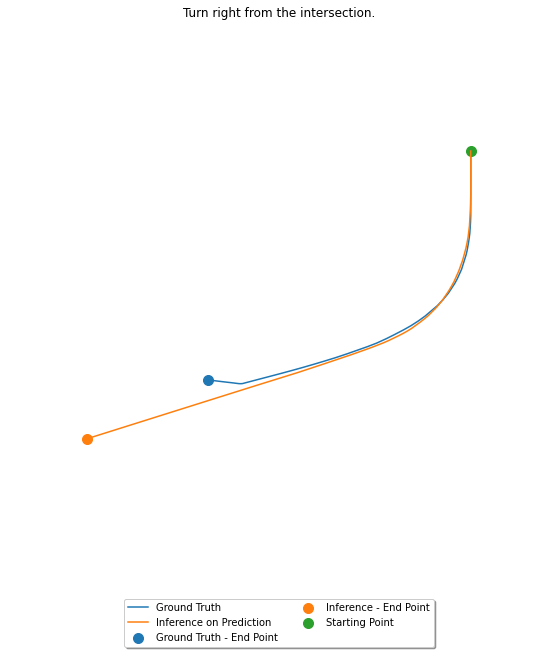

In [41]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/val/'
val_run_path = '/ssd_scratch/cvit/varunc/val_clip_6nomap/'
save_loc = '../trajectories_val_clip6/'

frechet_val_clip_6nomap,fde_val_clip_6nomap,ade_val_clip_6nomap, ade_matched_val_clip_6nomap, ndtw_val_clip_6nomap, tc_val_clip_6nomap = get_scores(val_data_path, val_run_path, save_loc,episodes=list(range(25)))

(58, 3) (58, 3)
Episode 0: Stop before the next right turn.
Frechet Distance: 29.027949405576813
FDE Distance: 29.027949405576813
ADE Distance: 15.043526358274995
ADE Matched Distance: 7.485487345932373
nDTW Distance: 0.003789968878295383
TC Distance: False


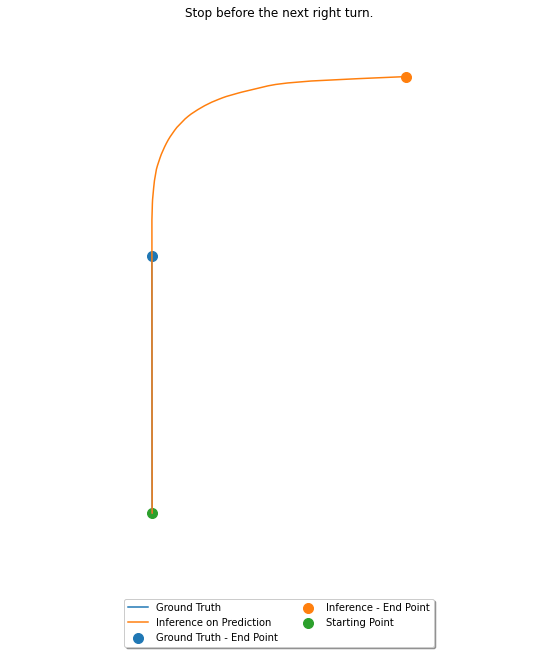

(45, 3) (45, 3)
Episode 1: After crossing the blue car come to a stop
Frechet Distance: 0.698790435802246
FDE Distance: 0.698790435802246
ADE Distance: 5.883726890697166
ADE Matched Distance: 0.45692558934416866
nDTW Distance: 0.6608164248969347
TC Distance: True


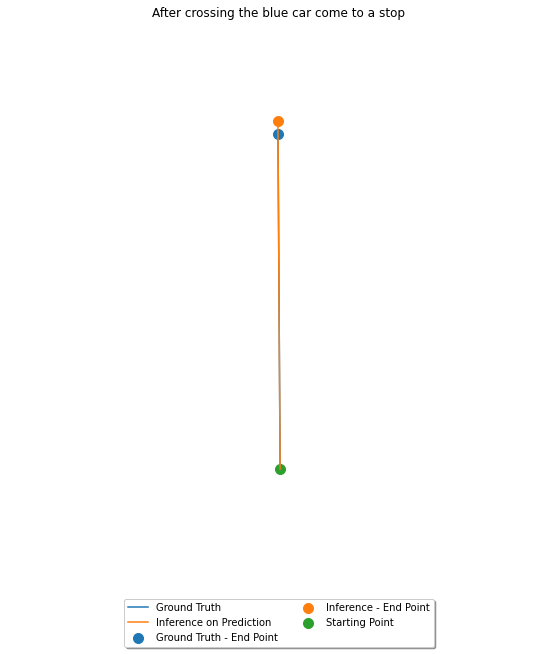

(109, 3) (109, 3)
Episode 2: stop beside the black suv
Frechet Distance: 7.405424343314014
FDE Distance: 7.405424343314013
ADE Distance: 8.34716288301912
ADE Matched Distance: 0.3971684494027911
nDTW Distance: 0.7188349517284133
TC Distance: False


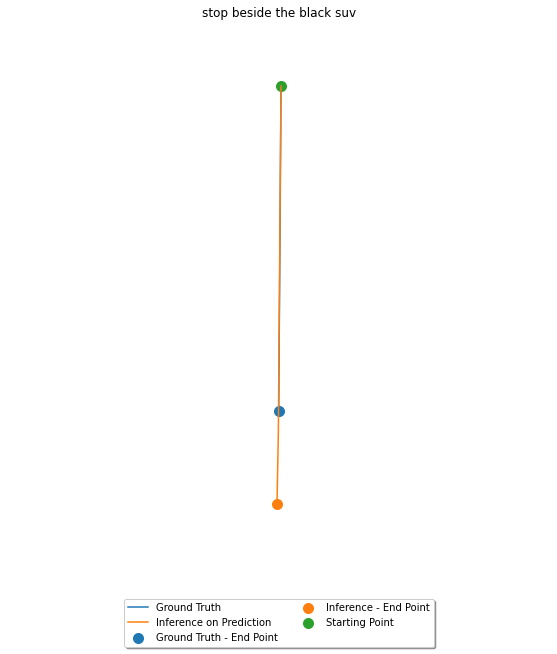

(38, 3) (38, 3)
Episode 3: Stop near the signboard
Frechet Distance: 5.473216733982369
FDE Distance: 5.473216733982369
ADE Distance: 2.9278109005629123
ADE Matched Distance: 0.9162293566469245
nDTW Distance: 0.6233909320957602
TC Distance: False


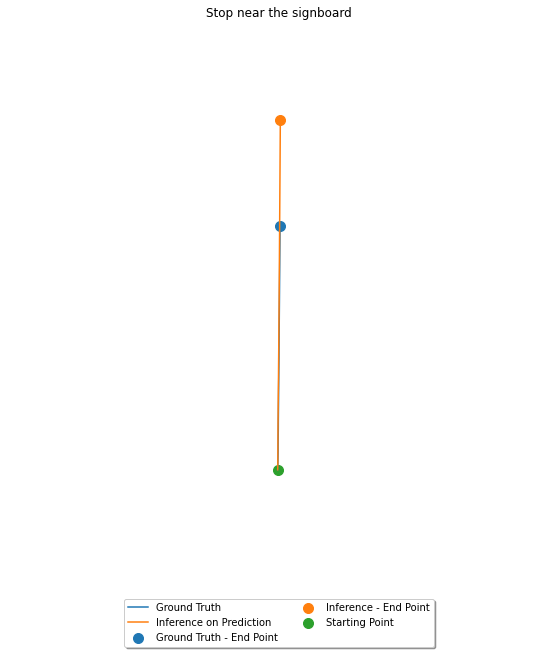

(82, 3) (82, 3)
Episode 4: Take a left at the traffic light
Frechet Distance: 7.625146383825327
FDE Distance: 7.625146383825327
ADE Distance: 3.7596059600933467
ADE Matched Distance: 0.8488103173252938
nDTW Distance: 0.7225040572332341
TC Distance: False


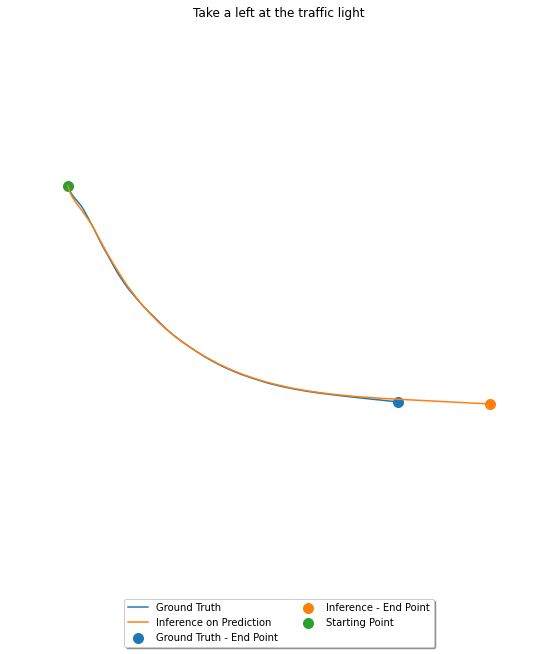

(57, 3) (57, 3)
Episode 5: Turn right from the intersection
Frechet Distance: 83.82215972961204
FDE Distance: 83.82215972961204
ADE Distance: 33.04833304091142
ADE Matched Distance: 23.82276788117448
nDTW Distance: 5.533070058270005e-10
TC Distance: False


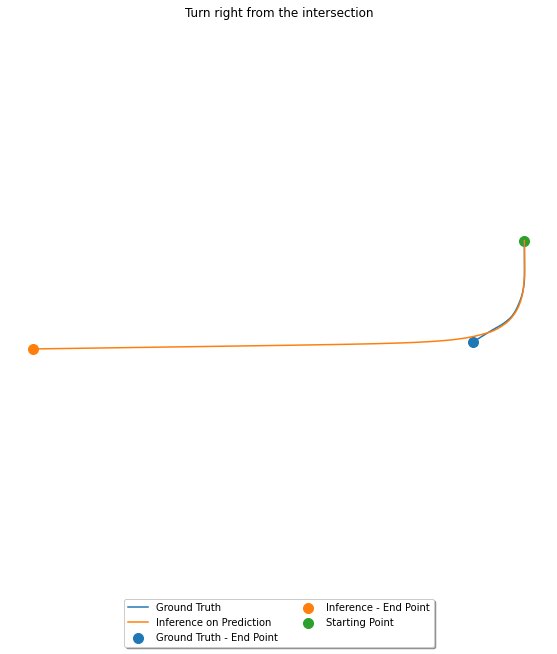

(91, 3) (91, 3)
Episode 6: Take a left from the intersection ahead
Frechet Distance: 6.484320213011279
FDE Distance: 6.484320213011279
ADE Distance: 6.670515335163557
ADE Matched Distance: 0.6773984711909341
nDTW Distance: 0.8401387868884662
TC Distance: False


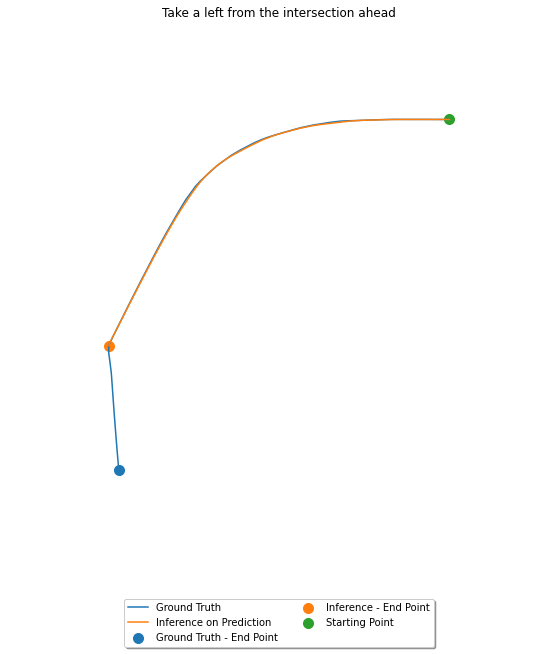

(61, 3) (61, 3)
Episode 7: Drive to the corner and go right
Frechet Distance: 11.45263124160675
FDE Distance: 11.45263124160675
ADE Distance: 4.238690552328551
ADE Matched Distance: 0.9569483369056311
nDTW Distance: 0.7014949944329797
TC Distance: False


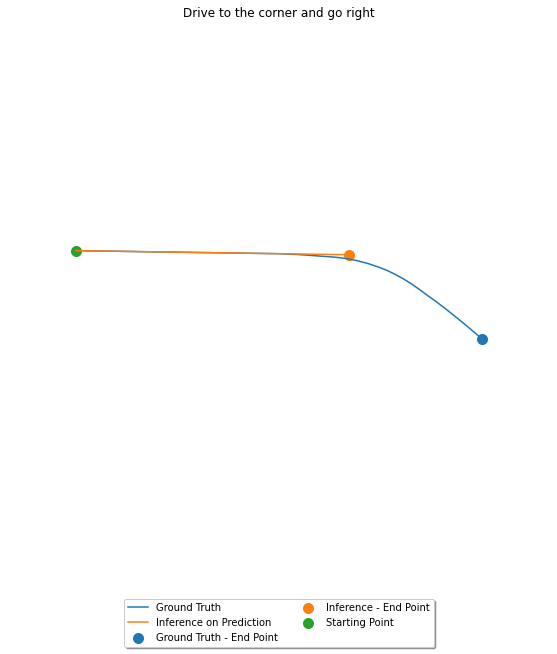

(83, 3) (83, 3)
Episode 8: Drive to the intersection and turn left
Frechet Distance: 105.2136104981642
FDE Distance: 38.36802957213709
ADE Distance: 59.931523417279216
ADE Matched Distance: 56.85820832517109
nDTW Distance: 7.075179780969687e-45
TC Distance: False


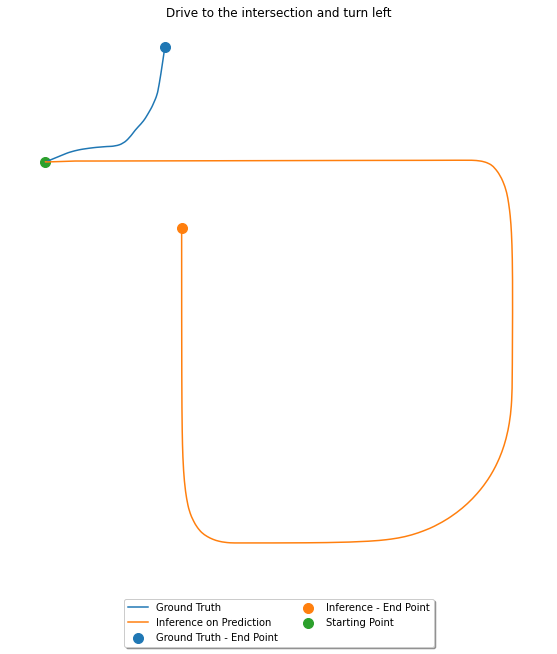

(91, 3) (91, 3)
Episode 9: Go straight and stop a few metres ahead of the bus stop
Frechet Distance: 30.03586694798363
FDE Distance: 30.03586694798363
ADE Distance: 15.512004362602283
ADE Matched Distance: 11.29058323192236
nDTW Distance: 0.10454719880041882
TC Distance: False


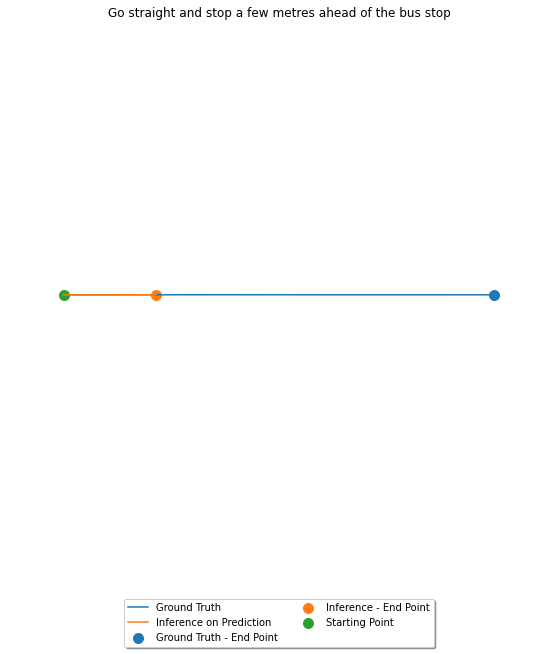

(80, 3) (80, 3)
Episode 10: Stop in front of the garbage dumpsters.
Frechet Distance: 2.0648804626601946
FDE Distance: 2.0648804626601946
ADE Distance: 4.399517098355691
ADE Matched Distance: 0.11381510336087074
nDTW Distance: 0.9489919646860903
TC Distance: True


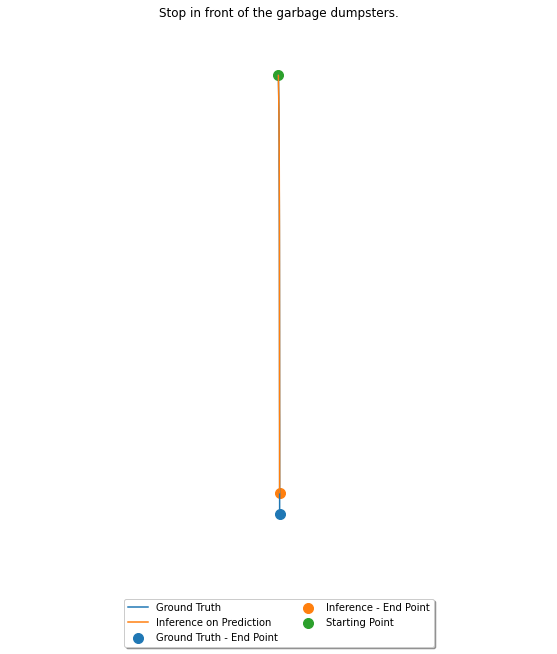

(107, 3) (107, 3)
Episode 11: Go straight and stop next to the grey arch.
Frechet Distance: 50.32873695590556
FDE Distance: 50.328736955905555
ADE Distance: 13.384910221421556
ADE Matched Distance: 9.189207607066809
nDTW Distance: 0.019917664282022567
TC Distance: False


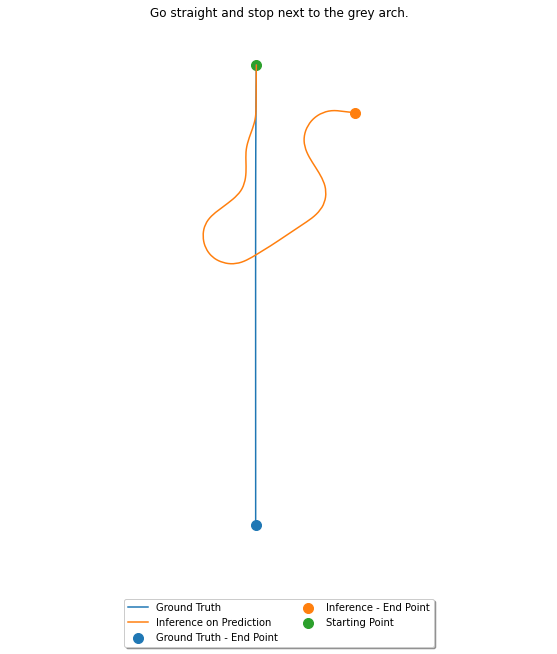

(66, 3) (66, 3)
Episode 12: Change lanes and stop at the junction.
Frechet Distance: 5.560833319253897
FDE Distance: 5.560833319253897
ADE Distance: 3.441247636856407
ADE Matched Distance: 1.56071462942459
nDTW Distance: 0.6350661743054596
TC Distance: False


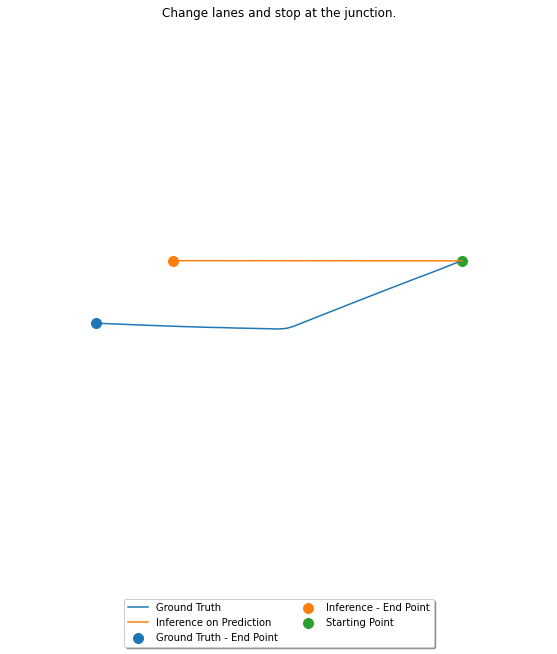

(60, 3) (60, 3)
Episode 13: Park on the roadside after you have crossed the bus stop
Frechet Distance: 8.509720783303937
FDE Distance: 8.509720783303937
ADE Distance: 3.9374777663519422
ADE Matched Distance: 0.61398099557492
nDTW Distance: 0.7822410027711779
TC Distance: False


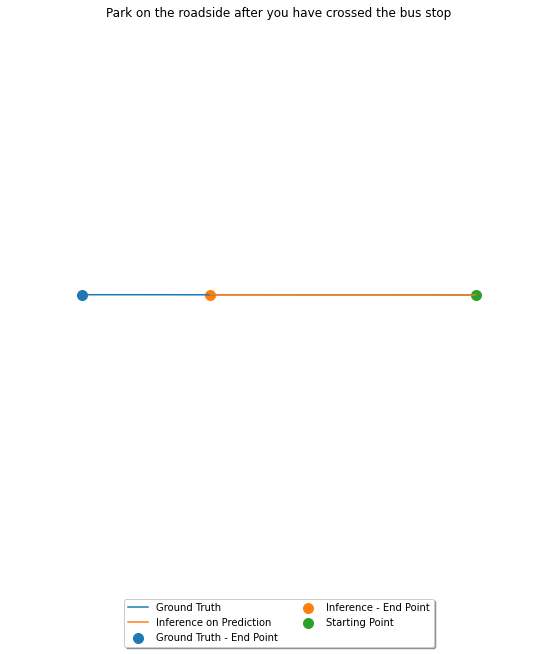

(452, 3) (452, 3)
Episode 14: Wait for the signal to turn green and continue straight
Frechet Distance: 251.46086461810592
FDE Distance: 39.32372789661791
ADE Distance: 84.08761467728526
ADE Matched Distance: 77.95646454863501
nDTW Distance: 3.757225421357746e-39
TC Distance: False


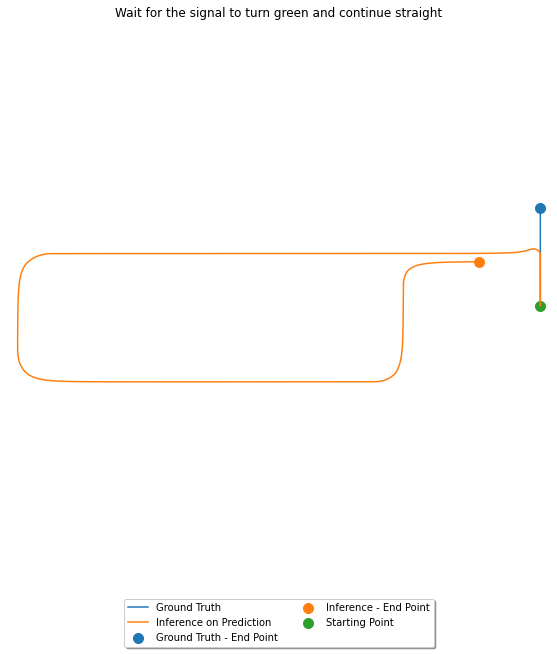

(63, 3) (63, 3)
Episode 15: Drive towards the bus stop and park after crossing it
Frechet Distance: 3.0628458209997507
FDE Distance: 3.062845820999751
ADE Distance: 4.249546495921356
ADE Matched Distance: 0.167367929308314
nDTW Distance: 0.9268349964299617
TC Distance: True


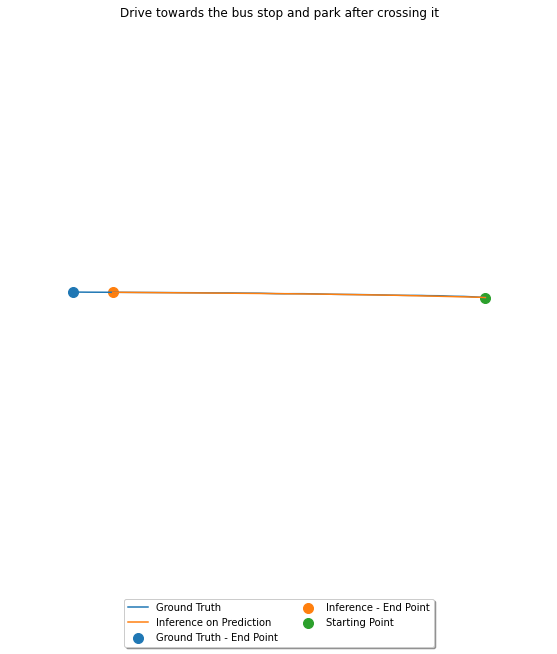

(81, 3) (81, 3)
Episode 16: take a right turn and stop across the bench on left
Frechet Distance: 116.69265587624413
FDE Distance: 15.261343073371249
ADE Distance: 80.55109989995711
ADE Matched Distance: 66.81893581824959
nDTW Distance: 2.385647594410936e-177
TC Distance: False


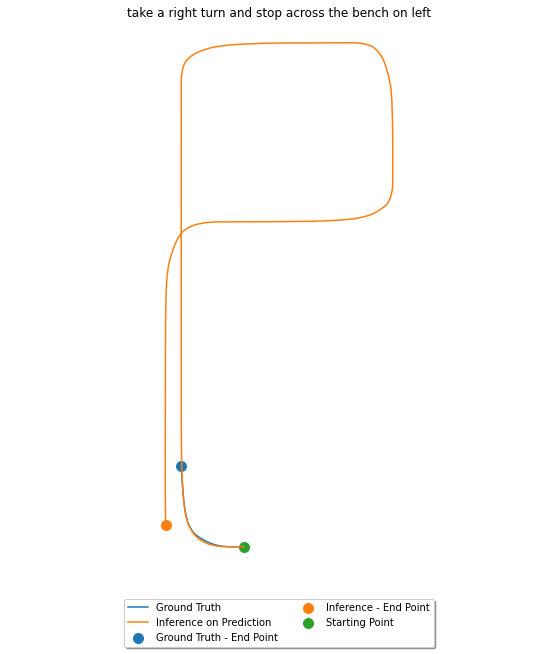

(61, 3) (61, 3)
Episode 17: Turn right from the crossroads ahead
Frechet Distance: 8.207580401746876
FDE Distance: 8.207580401746876
ADE Distance: 2.9512390572414056
ADE Matched Distance: 1.2824975264627325
nDTW Distance: 0.5788926120845048
TC Distance: False


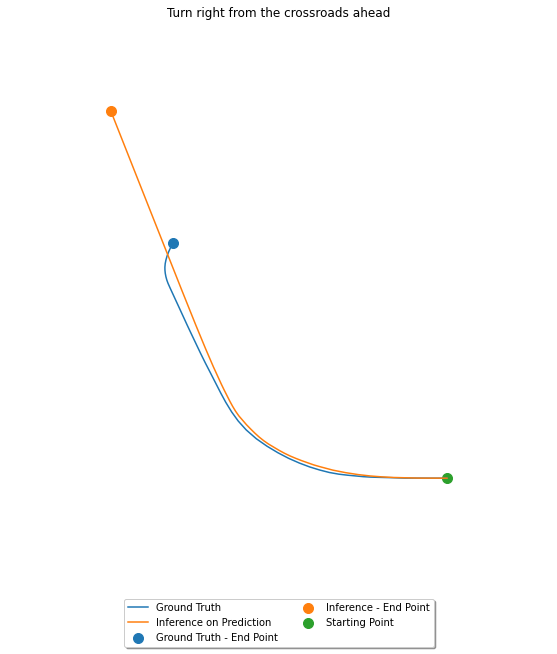

(76, 3) (76, 3)
Episode 18: Turn right and park near the sidewalk.
Frechet Distance: 30.60716166129232
FDE Distance: 30.60716166129232
ADE Distance: 9.036922251783523
ADE Matched Distance: 7.477616178545501
nDTW Distance: 0.2241313005443702
TC Distance: False


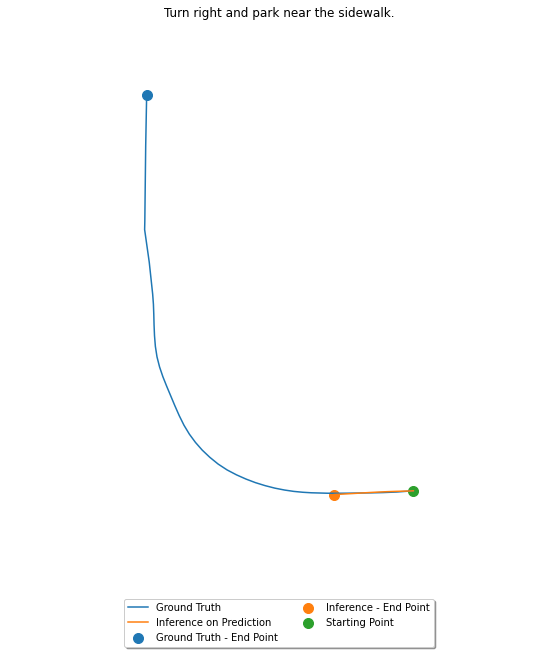

(103, 3) (103, 3)
Episode 19: go straight and take a right
Frechet Distance: 23.124830038253993
FDE Distance: 23.124830038253993
ADE Distance: 12.675799804910314
ADE Matched Distance: 5.571718300331182
nDTW Distance: 0.3281305734374942
TC Distance: False


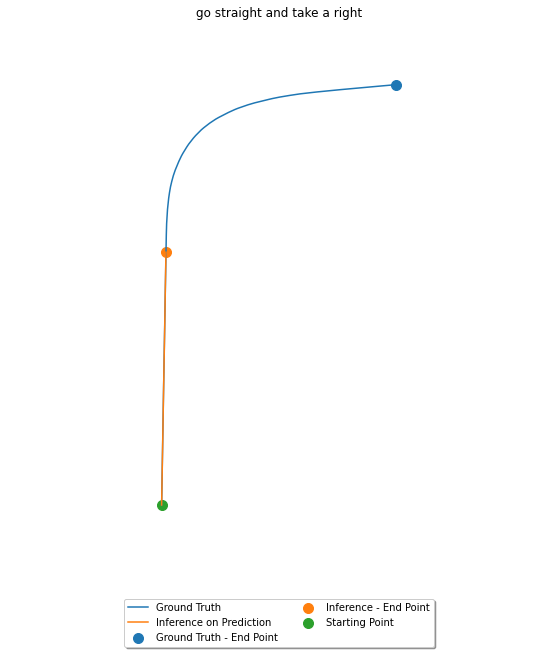

(42, 3) (42, 3)
Episode 20: park beside the red volkswagen
Frechet Distance: 12.022547526383223
FDE Distance: 12.022547526383223
ADE Distance: 5.020948377529645
ADE Matched Distance: 2.402746155638252
nDTW Distance: 0.26521055805800375
TC Distance: False


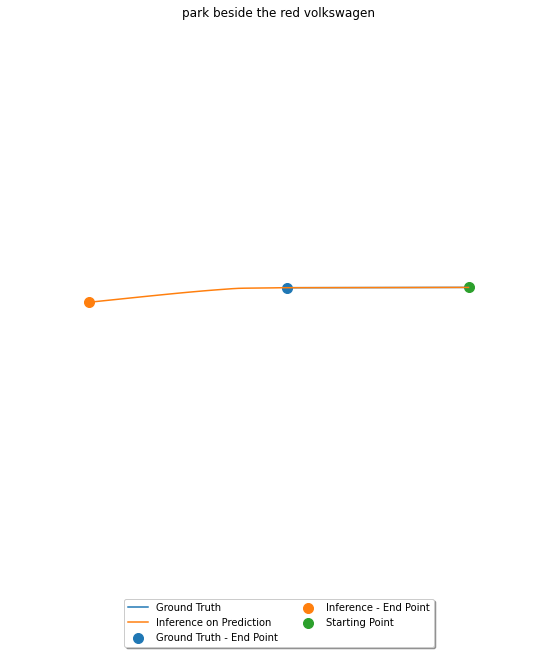

(147, 3) (147, 3)
Episode 21: Turn left from the next crossroads
Frechet Distance: 160.71985425548397
FDE Distance: 10.599583373132981
ADE Distance: 74.88599738421495
ADE Matched Distance: 66.41076499375112
nDTW Distance: 1.714162643615137e-64
TC Distance: False


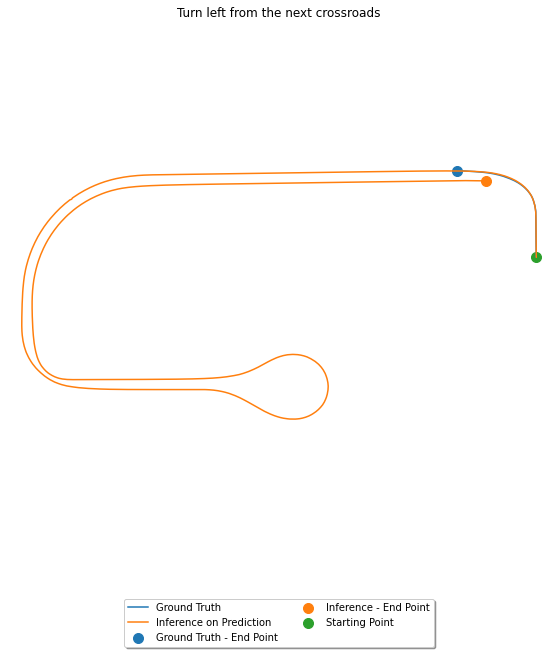

(66, 3) (66, 3)
Episode 22: Turn right from the crossroads.
Frechet Distance: 8.23208242186715
FDE Distance: 8.23208242186715
ADE Distance: 2.728143684764545
ADE Matched Distance: 1.0087211701866703
nDTW Distance: 0.5560526376393112
TC Distance: False


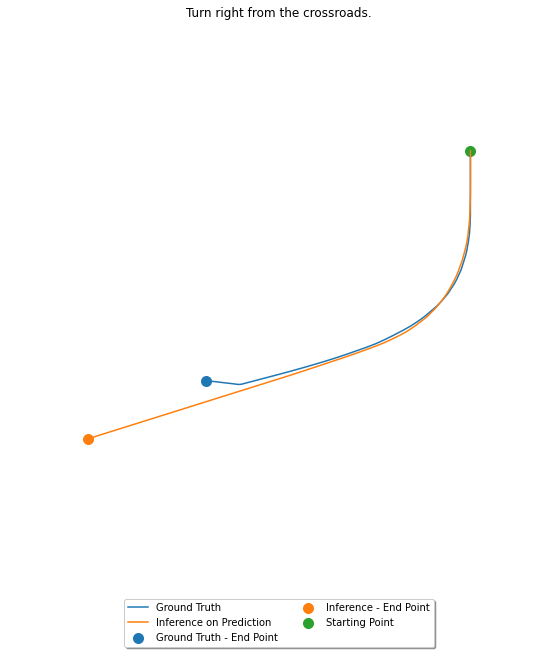

(71, 3) (71, 3)
Episode 23: stop by the lamp post
Frechet Distance: 90.79278150778984
FDE Distance: 90.79278150778984
ADE Distance: 50.4321376886164
ADE Matched Distance: 46.16420093477822
nDTW Distance: 2.417711221037763e-28
TC Distance: False


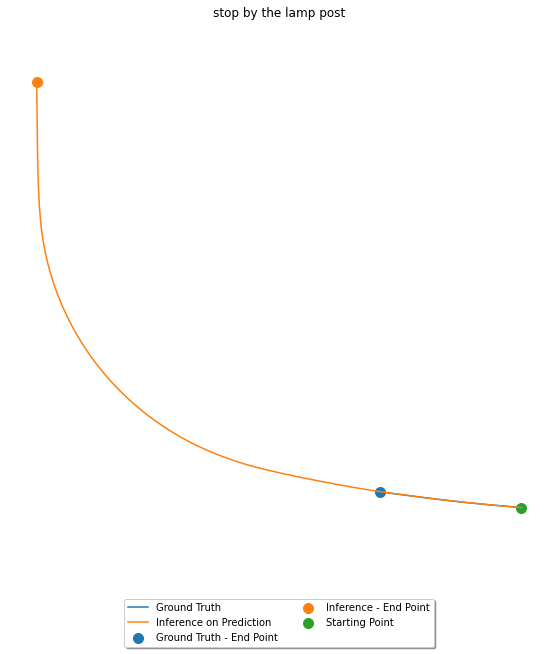

(50, 3) (50, 3)
Episode 24: park immediately after the signboard
Frechet Distance: 7.262300497796796
FDE Distance: 7.262300497796796
ADE Distance: 2.71613951183327
ADE Matched Distance: 1.030951447399075
nDTW Distance: 0.6197981170723504
TC Distance: False


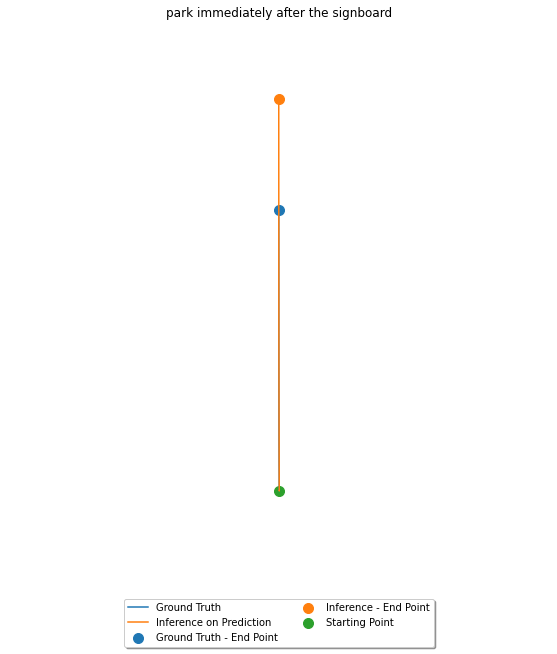

(176, 3) (176, 3)
Episode 25: Turn right and stop beside the traffic signal
Frechet Distance: 32.37060300580877
FDE Distance: 32.37060300580877
ADE Distance: 18.875199731959697
ADE Matched Distance: 8.127901932812698
nDTW Distance: 0.11624598627747695
TC Distance: False


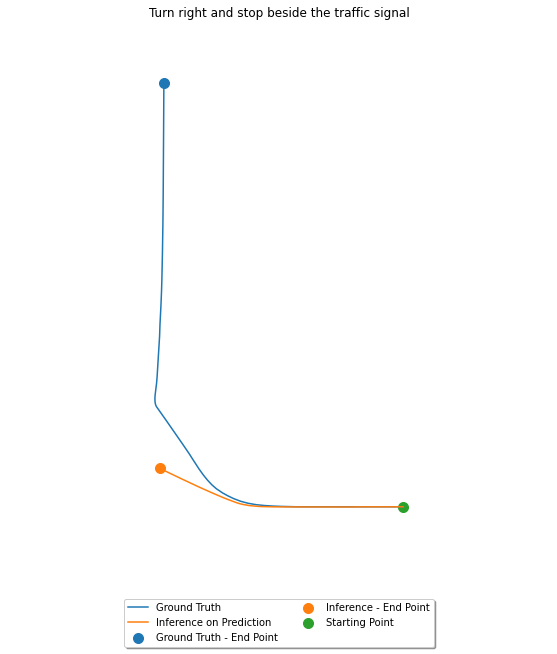

(167, 3) (167, 3)
Episode 26: Turn left and stop near the traffic signal
Frechet Distance: 23.217967151985647
FDE Distance: 23.217967151985647
ADE Distance: 32.36404891246313
ADE Matched Distance: 9.871440800353078
nDTW Distance: 0.13886012325030136
TC Distance: False


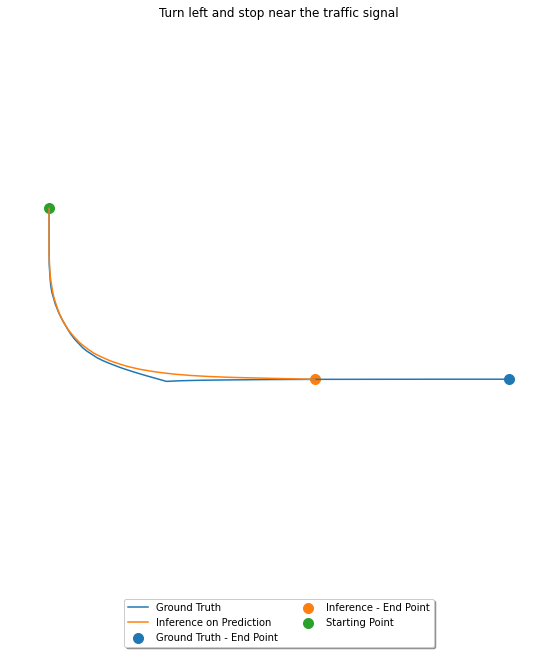

(358, 3) (358, 3)
Episode 27: Turn left and stop near the intersection
Frechet Distance: 169.1622068078016
FDE Distance: 36.138126282199
ADE Distance: 55.89636962943828
ADE Matched Distance: 54.868523417193195
nDTW Distance: 1.4743811031083133e-31
TC Distance: False


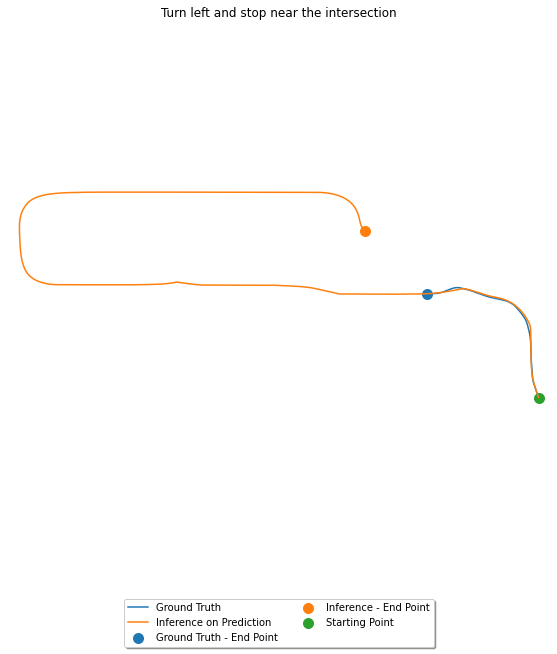

(143, 3) (143, 3)
Episode 28: Turn left and come to a halt at the intersection
Frechet Distance: 56.15855068305857
FDE Distance: 56.15855068305857
ADE Distance: 42.96517916038948
ADE Matched Distance: 29.139534572117626
nDTW Distance: 0.0029442330671343017
TC Distance: False


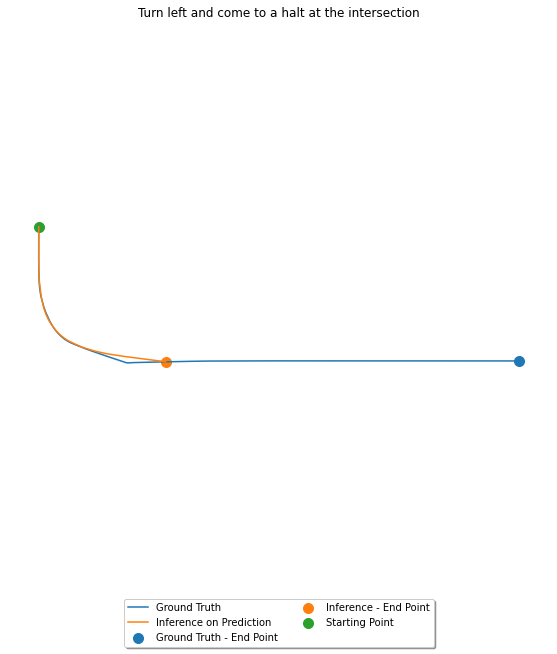

(194, 3) (194, 3)
Episode 29: Turn right and stop before the traffic signal
Frechet Distance: 159.87385849039768
FDE Distance: 40.70279387481685
ADE Distance: 83.4385173762321
ADE Matched Distance: 67.91606043026977
nDTW Distance: 1.5361319261898085e-78
TC Distance: False


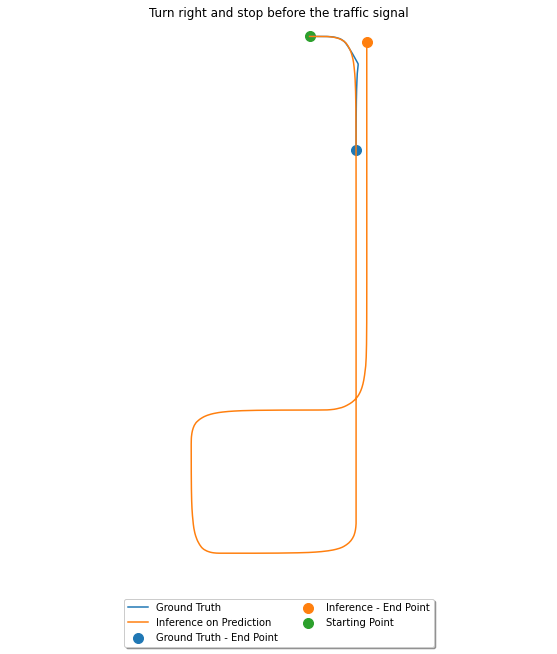

(153, 3) (153, 3)
Episode 30: Turn right and stop just before the traffic signal
Frechet Distance: 100.72922044668833
FDE Distance: 100.72922044668833
ADE Distance: 47.49019570656051
ADE Matched Distance: 45.61617139157099
nDTW Distance: 3.219894866209028e-27
TC Distance: False


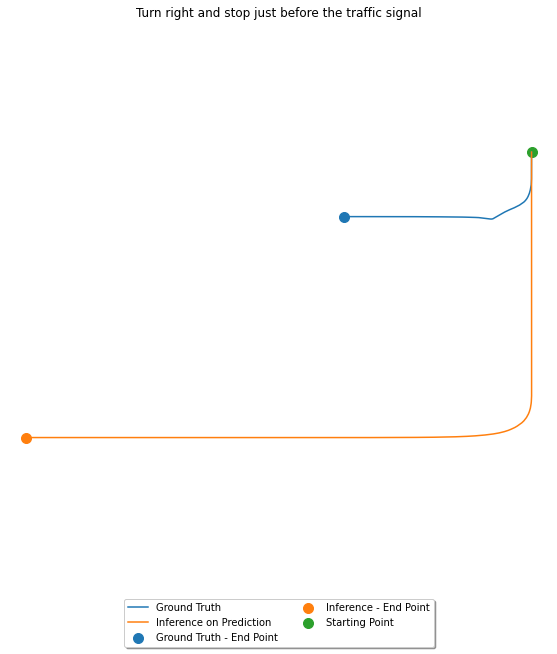

(144, 3) (144, 3)
Episode 31: Turn right and stop near the bus stop
Frechet Distance: 36.64777046295442
FDE Distance: 36.64777046295442
ADE Distance: 24.381887334602524
ADE Matched Distance: 12.529368967362585
nDTW Distance: 0.08160426155210371
TC Distance: False


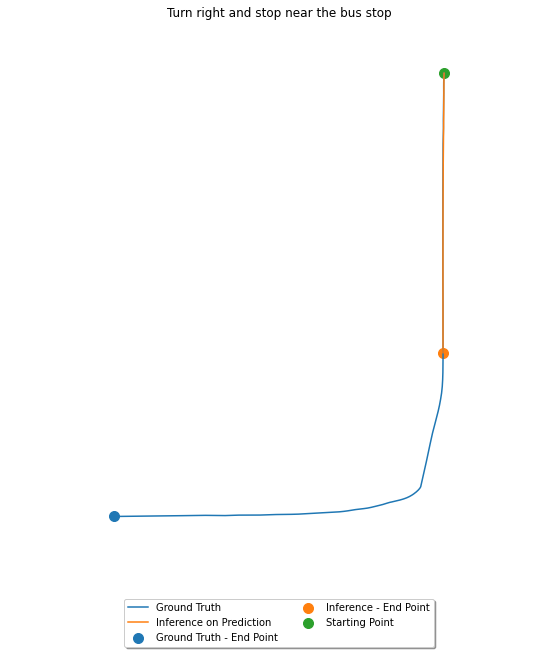

(188, 3) (188, 3)
Episode 32: Turn left and stop beside the traffic signal
Frechet Distance: 42.953336856303935
FDE Distance: 42.953336856303935
ADE Distance: 19.521274225099443
ADE Matched Distance: 3.7155014541184874
nDTW Distance: 0.09186755880506017
TC Distance: False


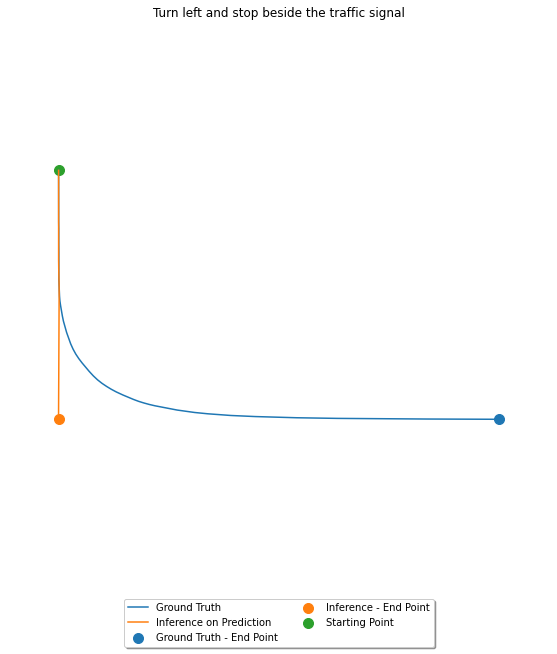

(166, 3) (166, 3)
Episode 33: Turn left and stop near the traffic signal
Frechet Distance: 43.52990341844897
FDE Distance: 43.52990341844897
ADE Distance: 29.30921870844198
ADE Matched Distance: 2.567861528701407
nDTW Distance: 0.13763753402509085
TC Distance: False


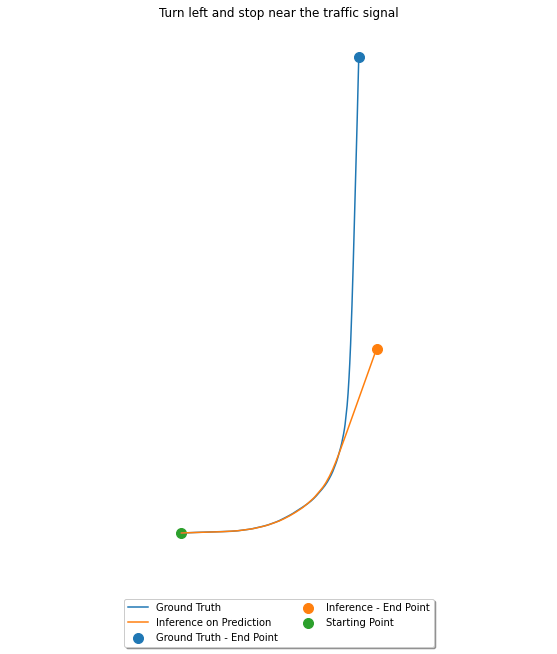

In [47]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/test/'
val_run_path = '/ssd_scratch/cvit/varunc/test_clip_6nomap/'
save_loc = '../trajectories_test_clip6/'

frechet_test_clip_6nomap,fde_test_clip_6nomap,ade_test_clip_6nomap, ade_matched_test_clip_6nomap, ndtw_test_clip_6nomap, tc_test_clip_6nomap = get_scores(val_data_path, val_run_path, save_loc,episodes=list(range(34)))

(364, 3) (364, 3)
Episode 0: Turn left and stop next to the bus stop.
Frechet Distance: 46.105773227392675
FDE Distance: 46.105773227392675
ADE Distance: 4.745712995220007
ADE Matched Distance: 3.1399772897539617
nDTW Distance: 0.5336604744096208
TC Distance: False


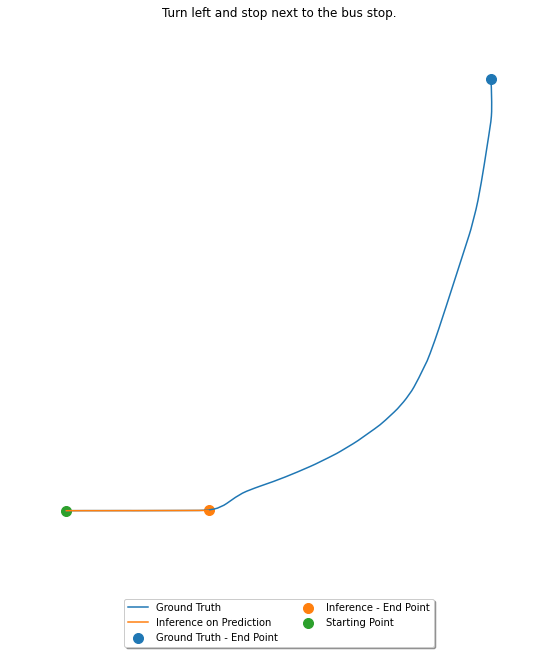

(94, 3) (94, 3)
Episode 1: Take a left from the interection.
Frechet Distance: 3.3662672020830233
FDE Distance: 3.3662672020830233
ADE Distance: 4.3549014889607305
ADE Matched Distance: 0.4192606491558427
nDTW Distance: 0.8639026369550553
TC Distance: True


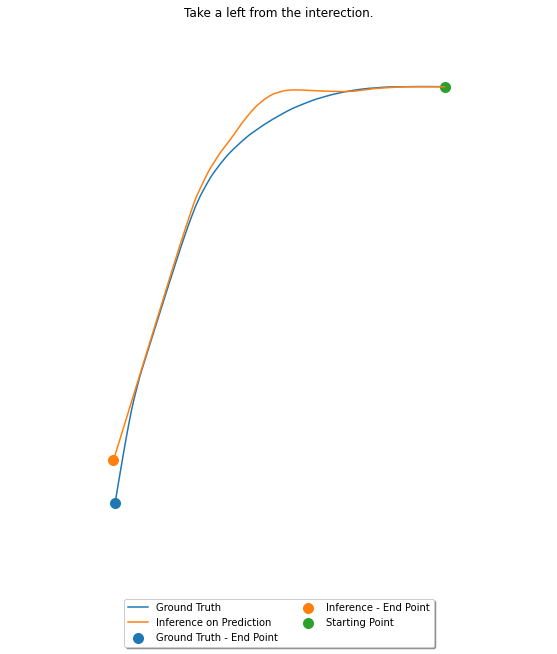

(55, 3) (55, 3)
Episode 2: Drive straight till you see a red coloured board
Frechet Distance: 2.8937378295845715
FDE Distance: 2.8937378295845715
ADE Distance: 5.550932340105299
ADE Matched Distance: 0.17742149680955022
nDTW Distance: 0.8648812689126012
TC Distance: True


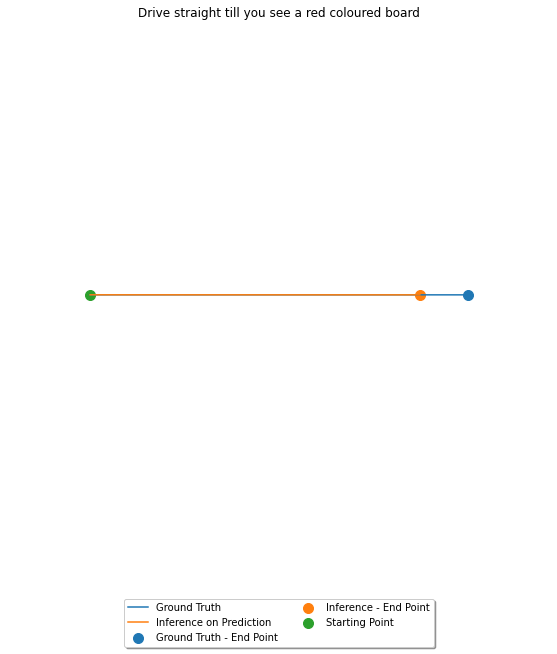

(38, 3) (38, 3)
Episode 3: Park just ahead of the speed signboard
Frechet Distance: 6.04358831626366
FDE Distance: 6.043588316263661
ADE Distance: 1.5353700816708218
ADE Matched Distance: 0.7434570874697337
nDTW Distance: 0.6376363231842228
TC Distance: False


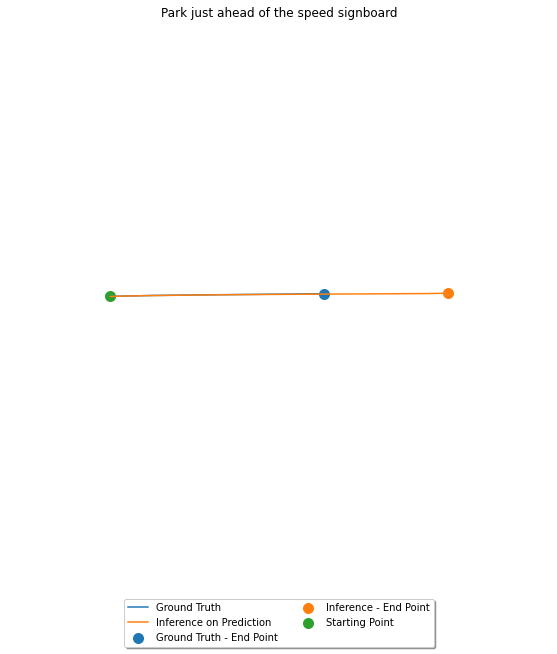

(332, 3) (332, 3)
Episode 4: Take the next right turn.
Frechet Distance: 35.33999393335193
FDE Distance: 35.33999393335193
ADE Distance: 10.256850327279574
ADE Matched Distance: 5.48240726277332
nDTW Distance: 0.30253415406583223
TC Distance: False


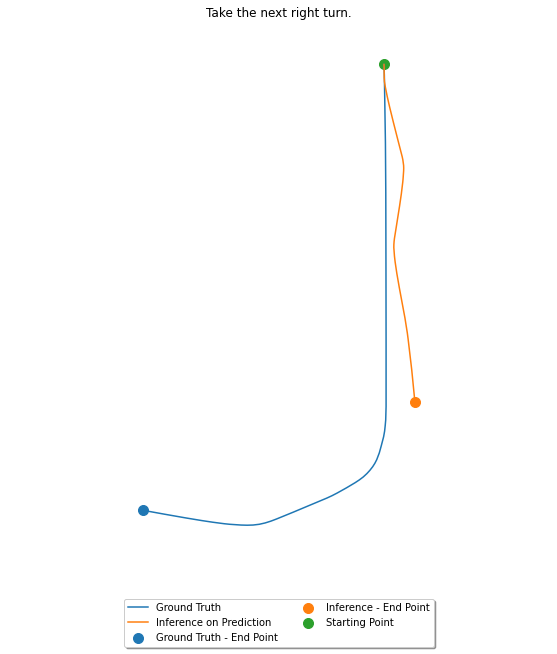

(150, 3) (150, 3)
Episode 5: Drive straight from the next crossroads.
Frechet Distance: 57.45680118027897
FDE Distance: 57.45680118027897
ADE Distance: 21.990350455346892
ADE Matched Distance: 9.659877731570653
nDTW Distance: 0.004771319704189018
TC Distance: False


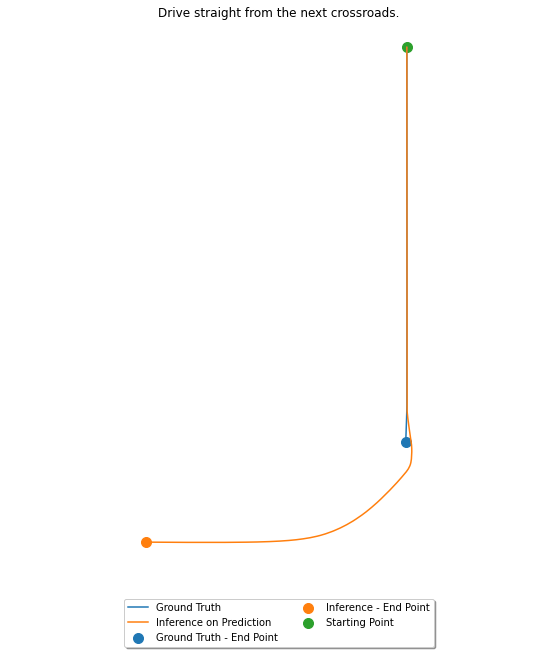

(70, 3) (70, 3)
Episode 6: change to left lane
Frechet Distance: 13.29313286677597
FDE Distance: 13.29313286677597
ADE Distance: 11.513462907543296
ADE Matched Distance: 2.9454703624541336
nDTW Distance: 0.4098120092969727
TC Distance: False


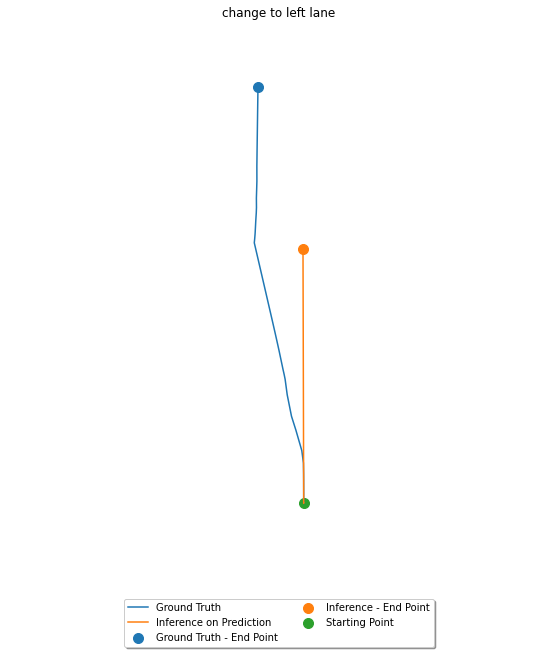

(42, 3) (42, 3)
Episode 7: Stop near the scooty
Frechet Distance: 5.891862617428335
FDE Distance: 5.891862617428334
ADE Distance: 5.151949144869806
ADE Matched Distance: 1.124448531568171
nDTW Distance: 0.5012087142238107
TC Distance: False


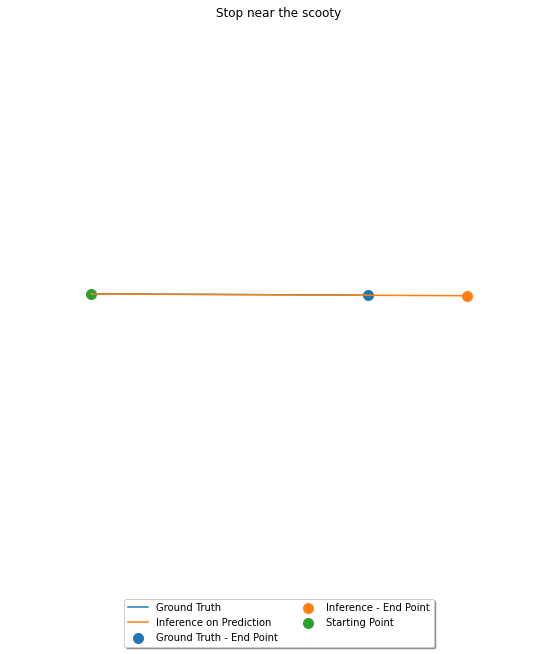

(142, 3) (142, 3)
Episode 8: take right and stop near the speed limit sign
Frechet Distance: 151.84545529267763
FDE Distance: 151.84545529267763
ADE Distance: 62.86428640159965
ADE Matched Distance: 51.12230594086132
nDTW Distance: 1.4874842080155179e-23
TC Distance: False


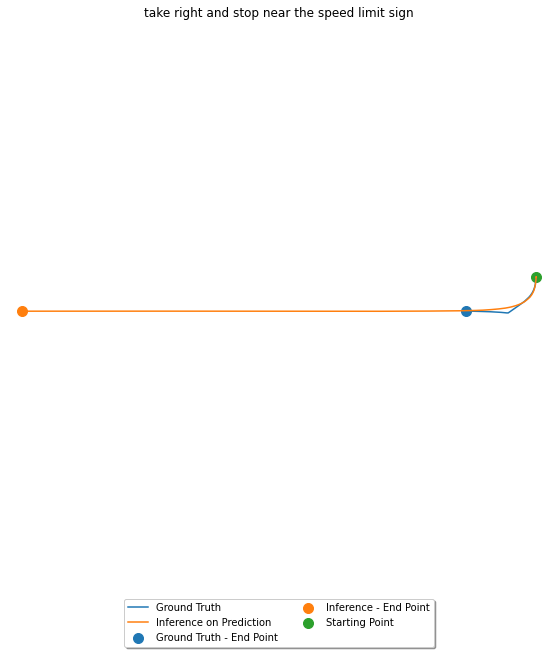

(59, 3) (59, 3)
Episode 9: Turn right and stop near the bus stop.
Frechet Distance: 9.583557818177573
FDE Distance: 9.583557818177573
ADE Distance: 3.7081924168714355
ADE Matched Distance: 1.4502017159647418
nDTW Distance: 0.5124420893472039
TC Distance: False


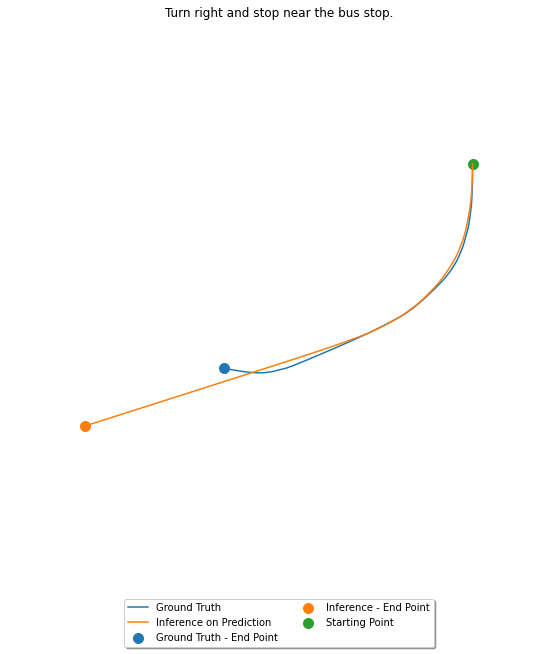

(66, 3) (66, 3)
Episode 10: Shift to the left lane and stop at the intersection.
Frechet Distance: 3.880837264304907
FDE Distance: 3.880837264304907
ADE Distance: 3.3792395702315488
ADE Matched Distance: 1.741111659695256
nDTW Distance: 0.5451190690150824
TC Distance: True


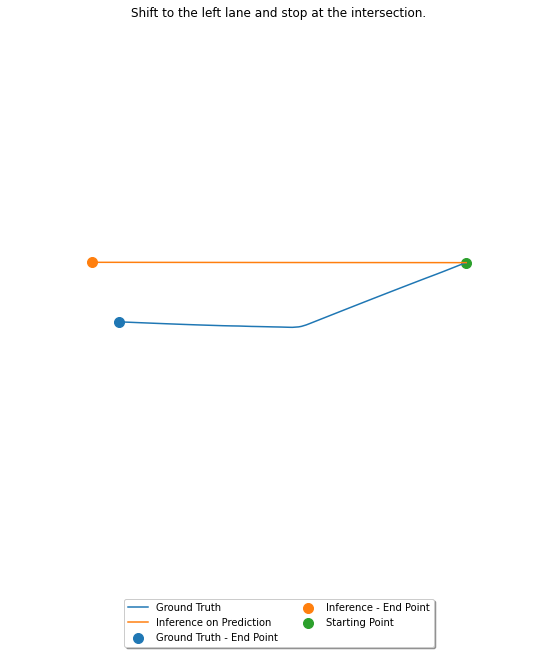

(45, 3) (45, 3)
Episode 11: Stop after crossing the stop signboard
Frechet Distance: 7.0899013942602
FDE Distance: 7.0899013942602
ADE Distance: 3.2280826700749867
ADE Matched Distance: 1.2131141138290178
nDTW Distance: 0.5321556063915531
TC Distance: False


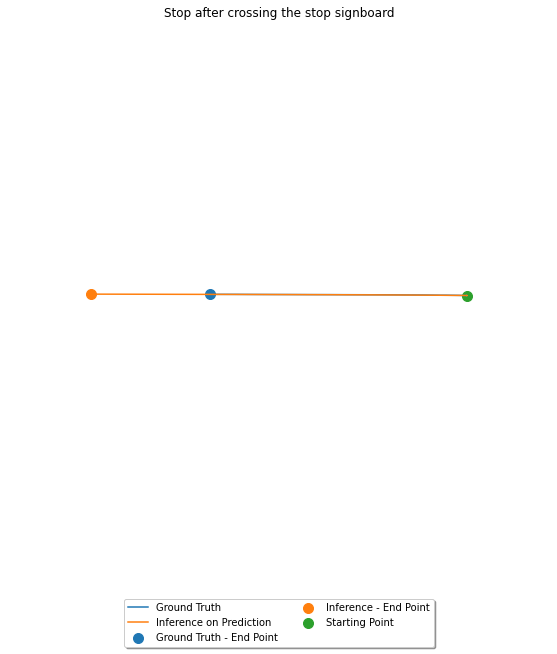

(45, 3) (45, 3)
Episode 12: Park near the red signboard
Frechet Distance: 13.971223052934956
FDE Distance: 13.971223052934956
ADE Distance: 3.5080788861189753
ADE Matched Distance: 2.0130877988958917
nDTW Distance: 0.018995632406097616
TC Distance: False


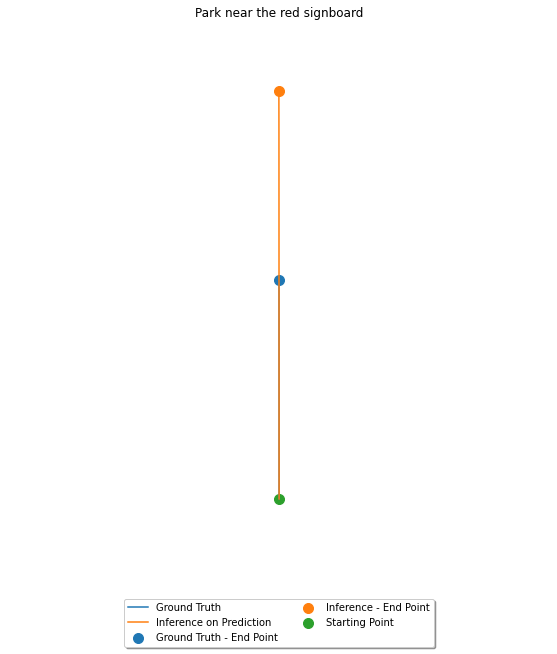

(340, 3) (340, 3)
Episode 13: Wait at the traffic light then go straight.
Frechet Distance: 83.95945581463386
FDE Distance: 83.95945581463386
ADE Distance: 17.837992421428375
ADE Matched Distance: 10.588216143322697
nDTW Distance: 0.03114200034304186
TC Distance: False


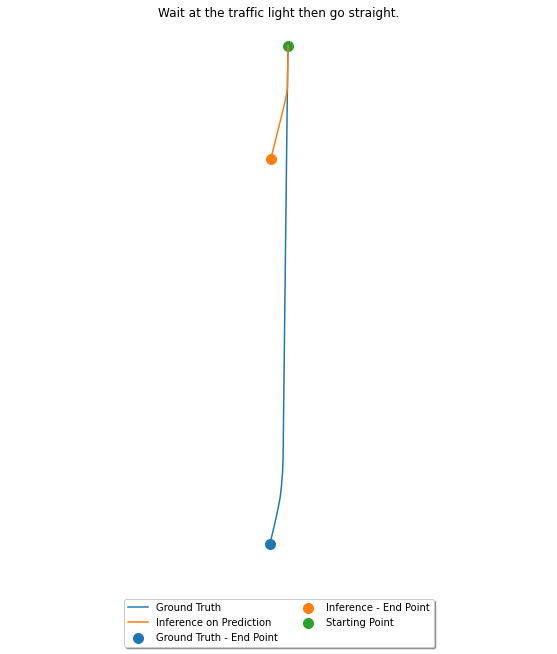

(73, 3) (73, 3)
Episode 14: Drive straight till the intersection and then turn left
Frechet Distance: 12.161433997846839
FDE Distance: 12.161433997846839
ADE Distance: 7.9096327125119865
ADE Matched Distance: 0.37920525211622913
nDTW Distance: 0.6703310245634408
TC Distance: False


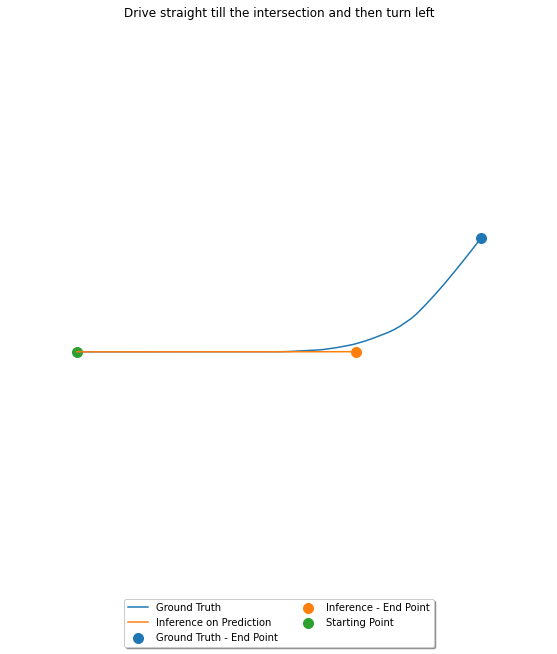

(239, 3) (239, 3)
Episode 15: go straight and take a left
Frechet Distance: 230.7500591056807
FDE Distance: 230.7500591056807
ADE Distance: 120.90243886859304
ADE Matched Distance: 89.24614849974472
nDTW Distance: 2.8617639532235375e-47
TC Distance: False


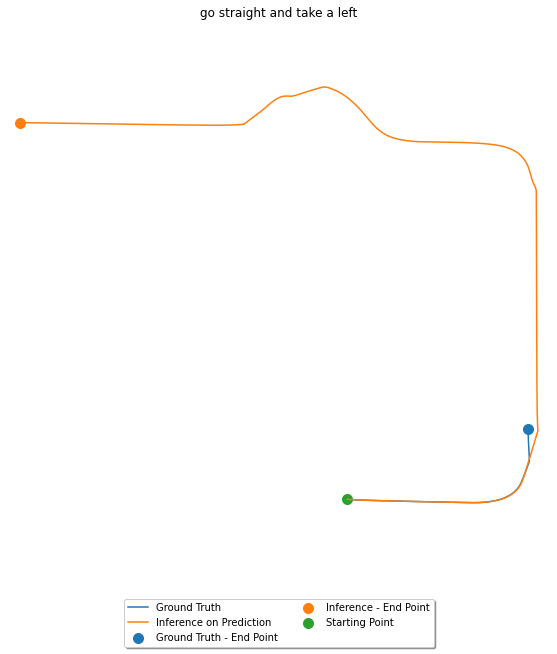

(47, 3) (47, 3)
Episode 16: Stop as soon as you encounter a white car
Frechet Distance: 1.7001118250845144
FDE Distance: 1.7001118250845144
ADE Distance: 1.0904727638278464
ADE Matched Distance: 0.1270835176872123
nDTW Distance: 0.937674007619559
TC Distance: True


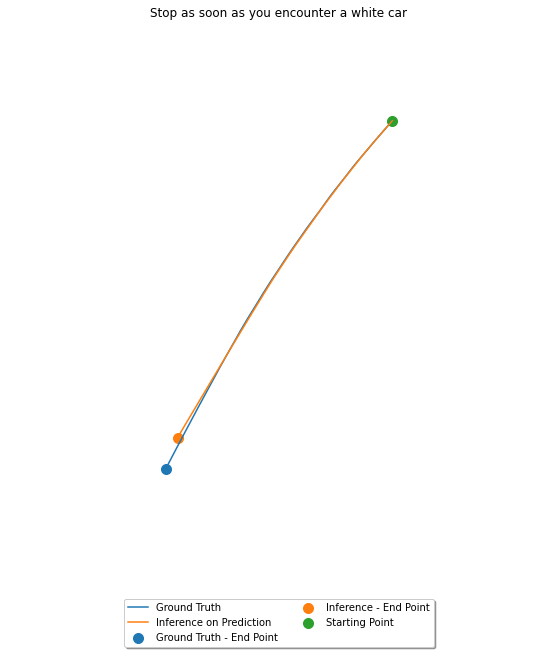

(105, 3) (105, 3)
Episode 17: take a right at the intersection
Frechet Distance: 42.79347740780253
FDE Distance: 42.79347740780253
ADE Distance: 16.584907555555336
ADE Matched Distance: 7.974036024780481
nDTW Distance: 0.00563179952706997
TC Distance: False


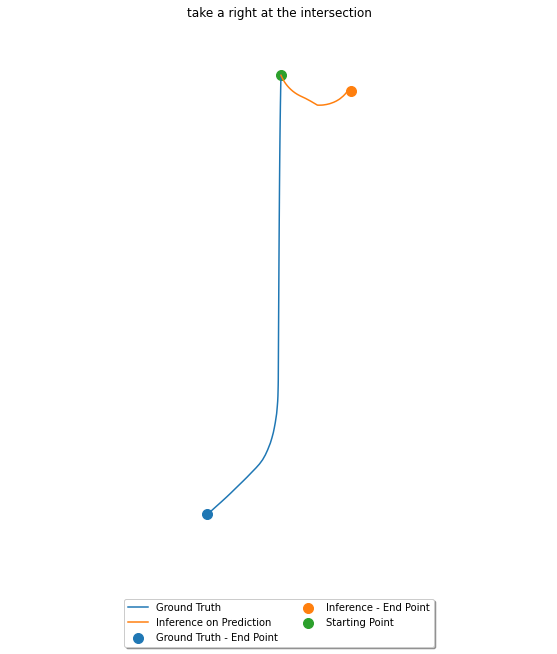

(44, 3) (44, 3)
Episode 18: Stop near the red shelters
Frechet Distance: 3.1737723331842367
FDE Distance: 3.1737723331842367
ADE Distance: 3.195673088020558
ADE Matched Distance: 0.4164830614053492
nDTW Distance: 0.8043610408415055
TC Distance: True


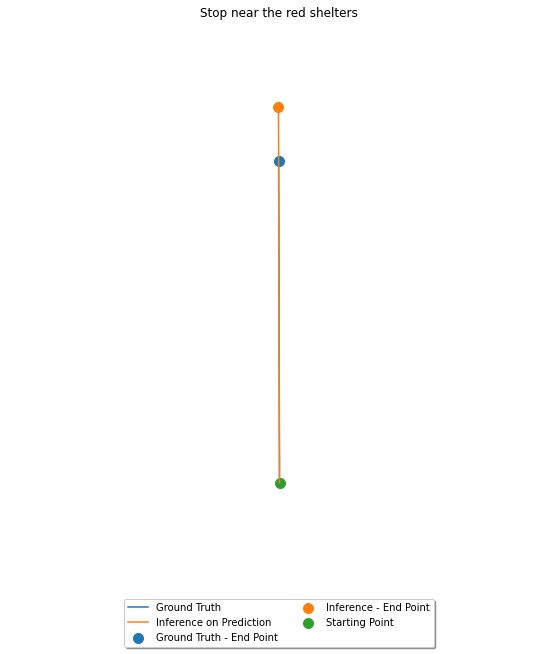

(127, 3) (127, 3)
Episode 19: Turn left from the intersection
Frechet Distance: 296.98877947658707
FDE Distance: 229.16116323646963
ADE Distance: 181.1461600187473
ADE Matched Distance: 155.94432155451702
nDTW Distance: 4.404612384653513e-274
TC Distance: False


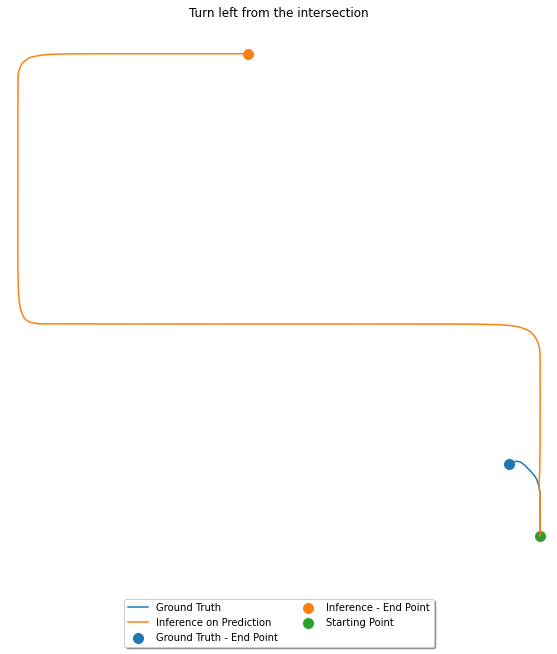

(127, 3) (127, 3)
Episode 20: Drive straight then turn right
Frechet Distance: 34.936026195592646
FDE Distance: 34.936026195592646
ADE Distance: 13.174582849370367
ADE Matched Distance: 8.596225178786847
nDTW Distance: 0.13855957201256341
TC Distance: False


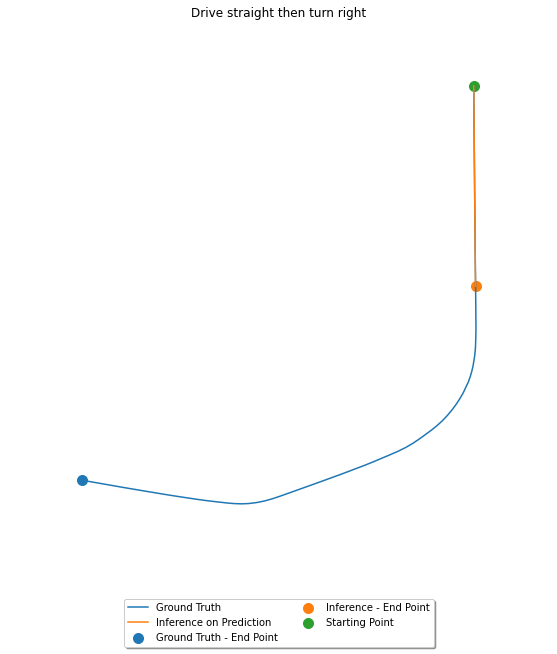

(36, 3) (36, 3)
Episode 21: Park near the hut visible on the right
Frechet Distance: 164.46993022835161
FDE Distance: 164.46993022835164
ADE Distance: 101.33245290117694
ADE Matched Distance: 93.30589033526114
nDTW Distance: 2.729707343472243e-208
TC Distance: False


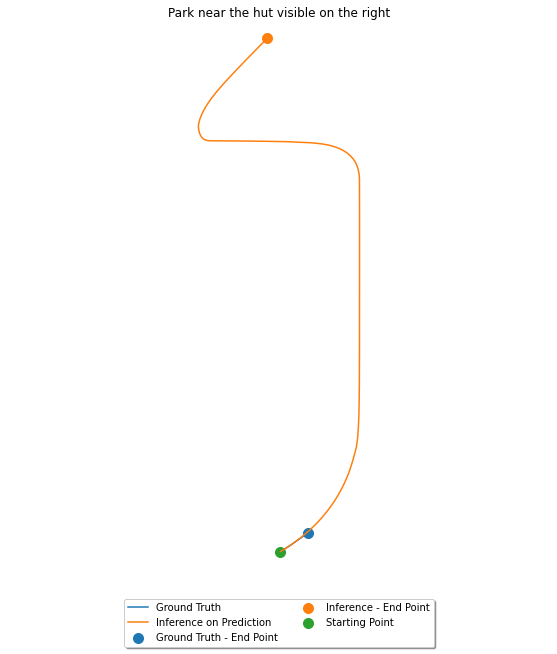

(133, 3) (133, 3)
Episode 22: Go straight and stop before the traffic light.
Frechet Distance: 82.14998139720842
FDE Distance: 82.14998139720842
ADE Distance: 39.49041942335368
ADE Matched Distance: 29.55549681860564
nDTW Distance: 0.0027092068458926246
TC Distance: False


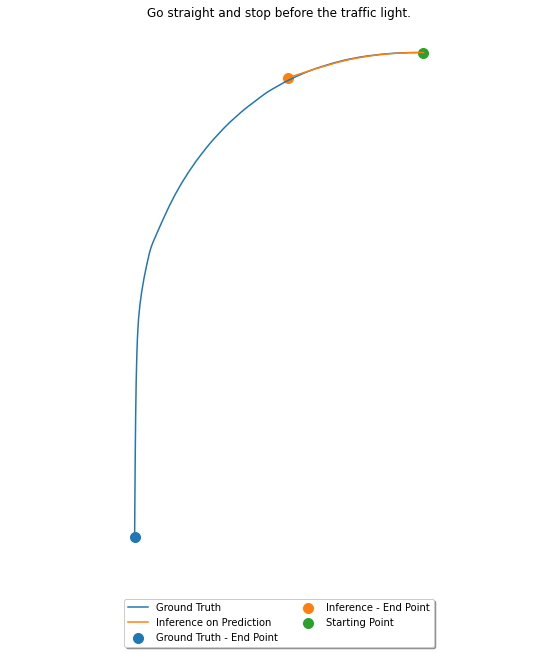

(136, 3) (136, 3)
Episode 23: stop at the bus stand in front
Frechet Distance: 35.39490805897128
FDE Distance: 35.39490805897128
ADE Distance: 10.550373049888064
ADE Matched Distance: 5.918999574792686
nDTW Distance: 0.3061133211717644
TC Distance: False


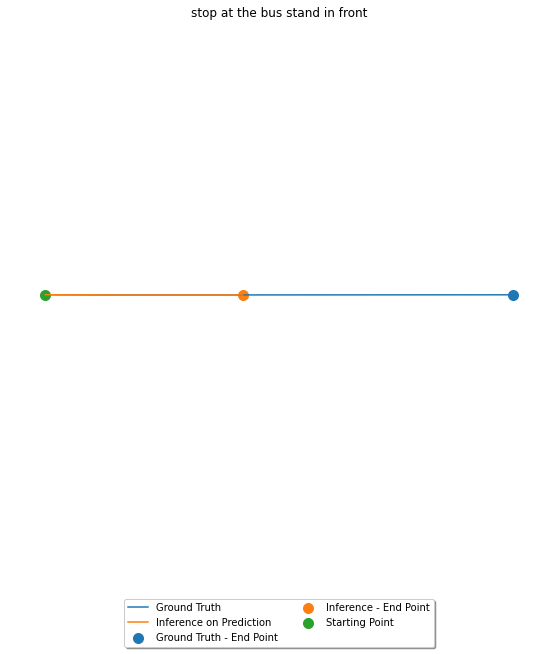

(66, 3) (66, 3)
Episode 24: Turn right from the intersection.
Frechet Distance: 8.378483828600391
FDE Distance: 8.378483828600391
ADE Distance: 2.601252516024666
ADE Matched Distance: 1.0179444272897331
nDTW Distance: 0.5412622666008176
TC Distance: False


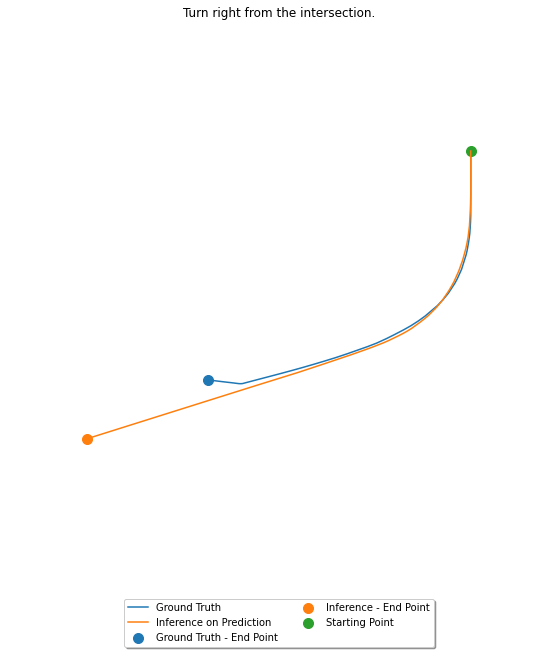

In [41]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/val/'
val_run_path = '/ssd_scratch/cvit/varunc/new_vals/val_conv3d/'
save_loc = '../trajectories_val_clip6/'

frechet_val_conv3d,fde_val_clip_conv3d,ade_val_clip_conv3d, ade_matched_val_clip_conv3d, ndtw_val_clip_conv3d, tc_val_clip_6nomap = get_scores(val_data_path, val_run_path, save_loc,episodes=list(range(25)))

(58, 3) (58, 3)
Episode 0: Stop before the next right turn.
Frechet Distance: 29.027949405576813
FDE Distance: 29.027949405576813
ADE Distance: 15.043526358274995
ADE Matched Distance: 7.485487345932373
nDTW Distance: 0.003789968878295383
TC Distance: False


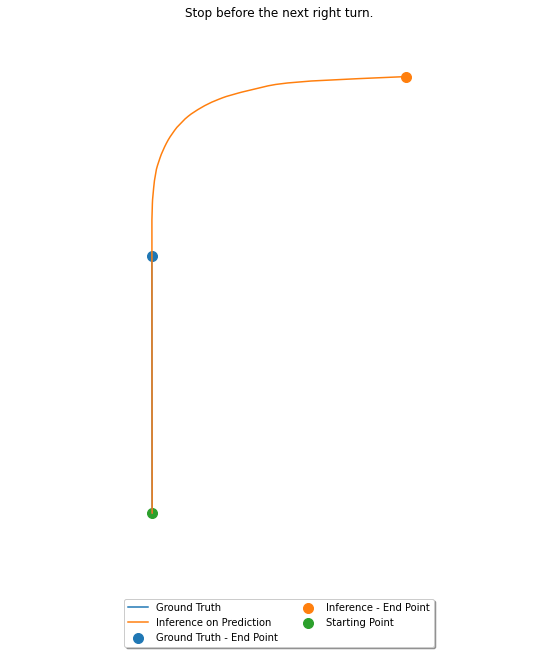

(45, 3) (45, 3)
Episode 1: After crossing the blue car come to a stop
Frechet Distance: 0.698790435802246
FDE Distance: 0.698790435802246
ADE Distance: 5.883726890697166
ADE Matched Distance: 0.45692558934416866
nDTW Distance: 0.6608164248969347
TC Distance: True


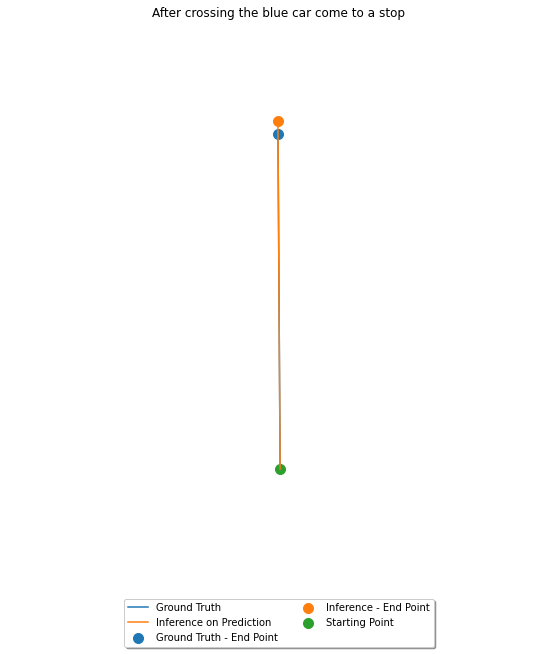

(109, 3) (109, 3)
Episode 2: stop beside the black suv
Frechet Distance: 7.405424343314014
FDE Distance: 7.405424343314013
ADE Distance: 8.34716288301912
ADE Matched Distance: 0.3971684494027911
nDTW Distance: 0.7188349517284133
TC Distance: False


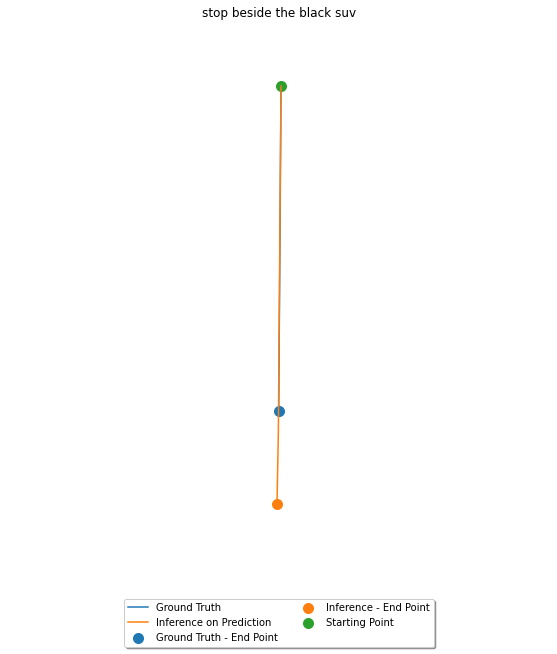

(38, 3) (38, 3)
Episode 3: Stop near the signboard
Frechet Distance: 5.473216733982369
FDE Distance: 5.473216733982369
ADE Distance: 2.9278109005629123
ADE Matched Distance: 0.9162293566469245
nDTW Distance: 0.6233909320957602
TC Distance: False


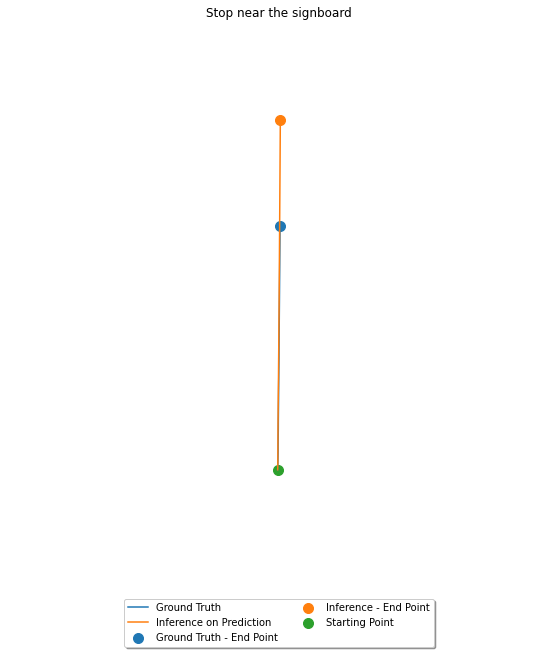

(82, 3) (82, 3)
Episode 4: Take a left at the traffic light
Frechet Distance: 7.625146383825327
FDE Distance: 7.625146383825327
ADE Distance: 3.7596059600933467
ADE Matched Distance: 0.8488103173252938
nDTW Distance: 0.7225040572332341
TC Distance: False


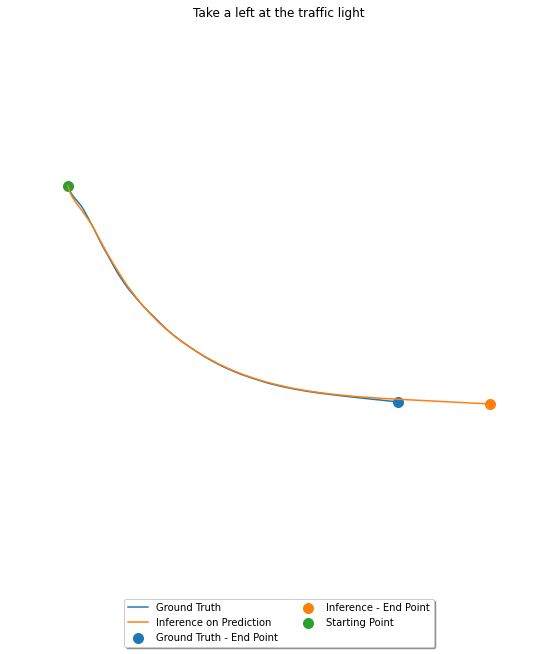

(57, 3) (57, 3)
Episode 5: Turn right from the intersection
Frechet Distance: 83.82215972961204
FDE Distance: 83.82215972961204
ADE Distance: 33.04833304091142
ADE Matched Distance: 23.82276788117448
nDTW Distance: 5.533070058270005e-10
TC Distance: False


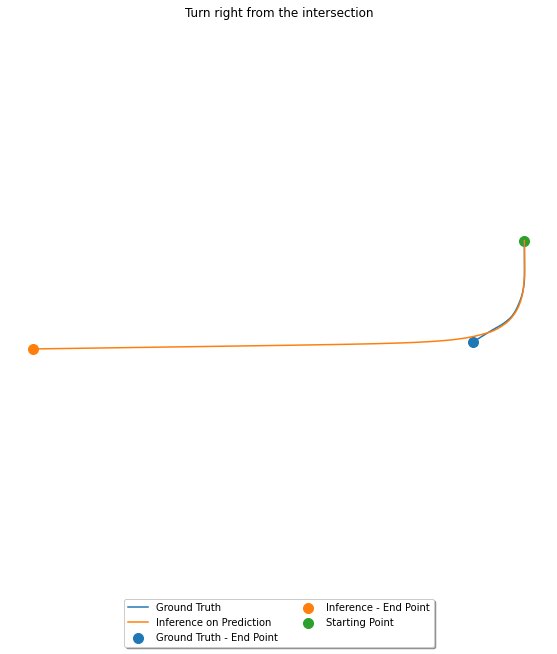

(91, 3) (91, 3)
Episode 6: Take a left from the intersection ahead
Frechet Distance: 6.484320213011279
FDE Distance: 6.484320213011279
ADE Distance: 6.670515335163557
ADE Matched Distance: 0.6773984711909341
nDTW Distance: 0.8401387868884662
TC Distance: False


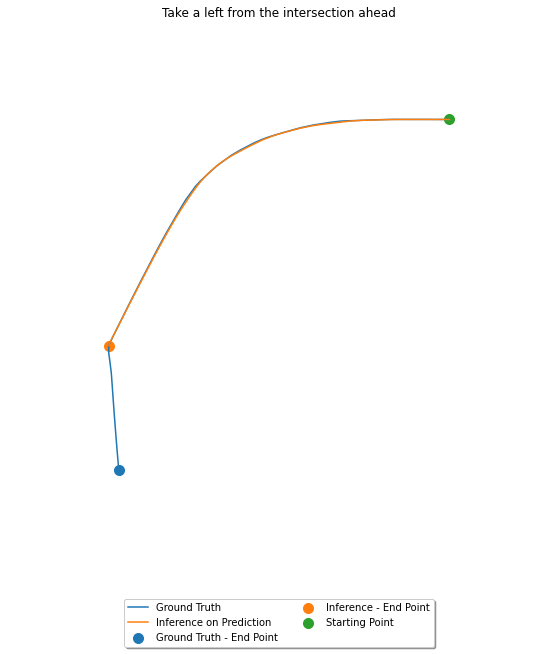

(61, 3) (61, 3)
Episode 7: Drive to the corner and go right
Frechet Distance: 11.45263124160675
FDE Distance: 11.45263124160675
ADE Distance: 4.238690552328551
ADE Matched Distance: 0.9569483369056311
nDTW Distance: 0.7014949944329797
TC Distance: False


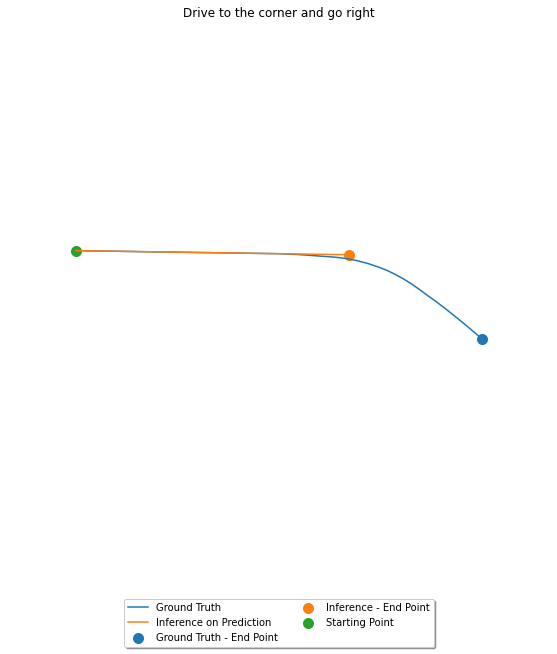

(83, 3) (83, 3)
Episode 8: Drive to the intersection and turn left
Frechet Distance: 105.2136104981642
FDE Distance: 38.36802957213709
ADE Distance: 59.931523417279216
ADE Matched Distance: 56.85820832517109
nDTW Distance: 7.075179780969687e-45
TC Distance: False


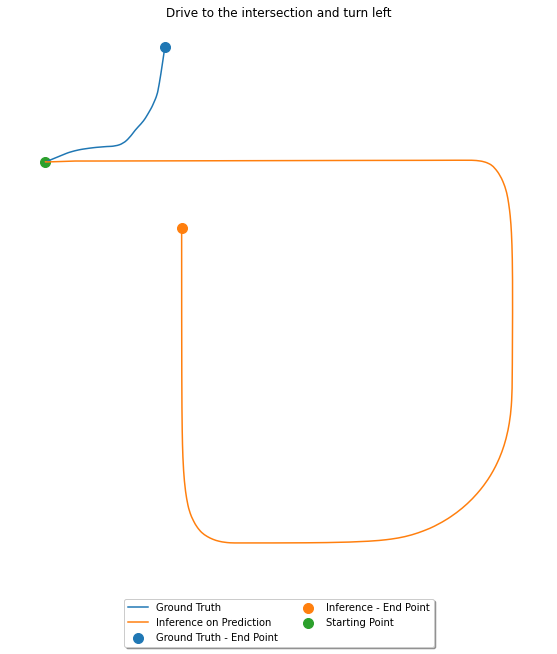

(91, 3) (91, 3)
Episode 9: Go straight and stop a few metres ahead of the bus stop
Frechet Distance: 30.03586694798363
FDE Distance: 30.03586694798363
ADE Distance: 15.512004362602283
ADE Matched Distance: 11.29058323192236
nDTW Distance: 0.10454719880041882
TC Distance: False


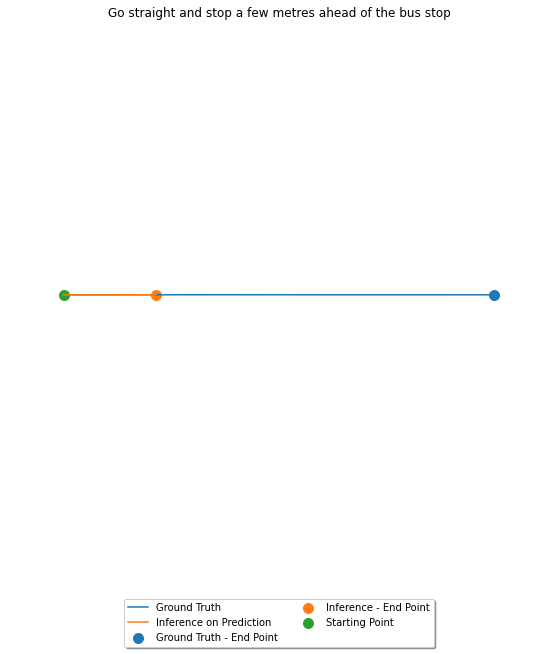

(80, 3) (80, 3)
Episode 10: Stop in front of the garbage dumpsters.
Frechet Distance: 2.0648804626601946
FDE Distance: 2.0648804626601946
ADE Distance: 4.399517098355691
ADE Matched Distance: 0.11381510336087074
nDTW Distance: 0.9489919646860903
TC Distance: True


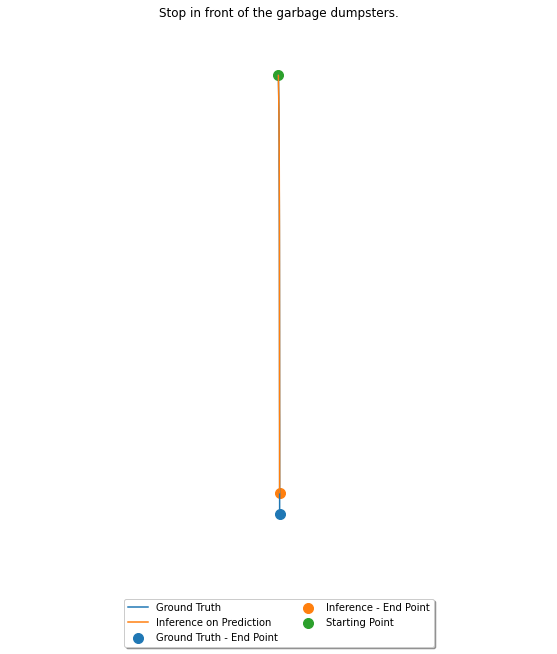

(107, 3) (107, 3)
Episode 11: Go straight and stop next to the grey arch.
Frechet Distance: 50.32873695590556
FDE Distance: 50.328736955905555
ADE Distance: 13.384910221421556
ADE Matched Distance: 9.189207607066809
nDTW Distance: 0.019917664282022567
TC Distance: False


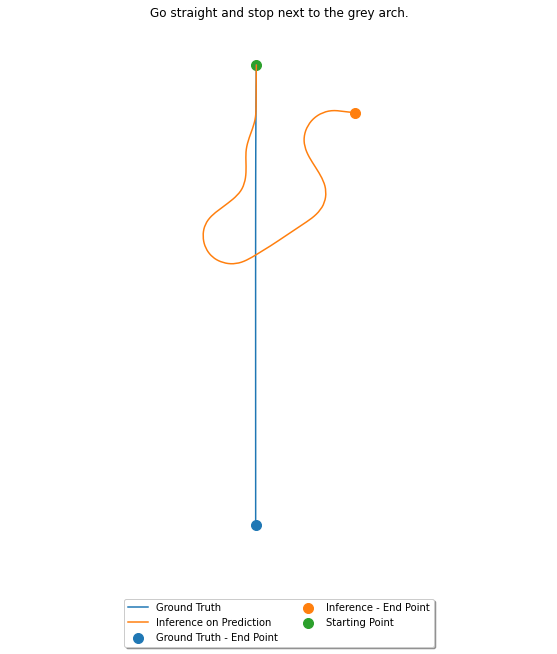

(66, 3) (66, 3)
Episode 12: Change lanes and stop at the junction.
Frechet Distance: 5.560833319253897
FDE Distance: 5.560833319253897
ADE Distance: 3.441247636856407
ADE Matched Distance: 1.56071462942459
nDTW Distance: 0.6350661743054596
TC Distance: False


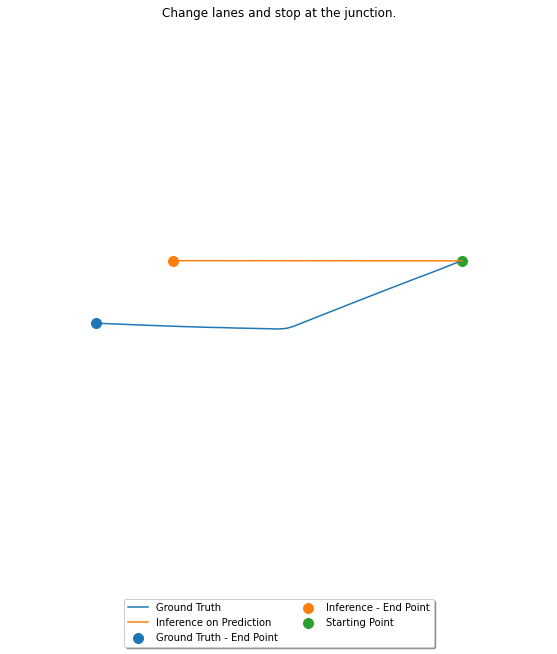

(60, 3) (60, 3)
Episode 13: Park on the roadside after you have crossed the bus stop
Frechet Distance: 8.509720783303937
FDE Distance: 8.509720783303937
ADE Distance: 3.9374777663519422
ADE Matched Distance: 0.61398099557492
nDTW Distance: 0.7822410027711779
TC Distance: False


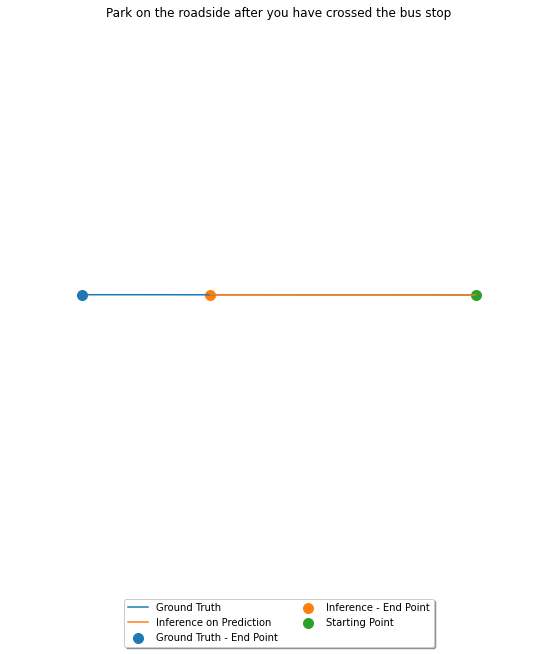

(452, 3) (452, 3)
Episode 14: Wait for the signal to turn green and continue straight
Frechet Distance: 251.46086461810592
FDE Distance: 39.32372789661791
ADE Distance: 84.08761467728526
ADE Matched Distance: 77.95646454863501
nDTW Distance: 3.757225421357746e-39
TC Distance: False


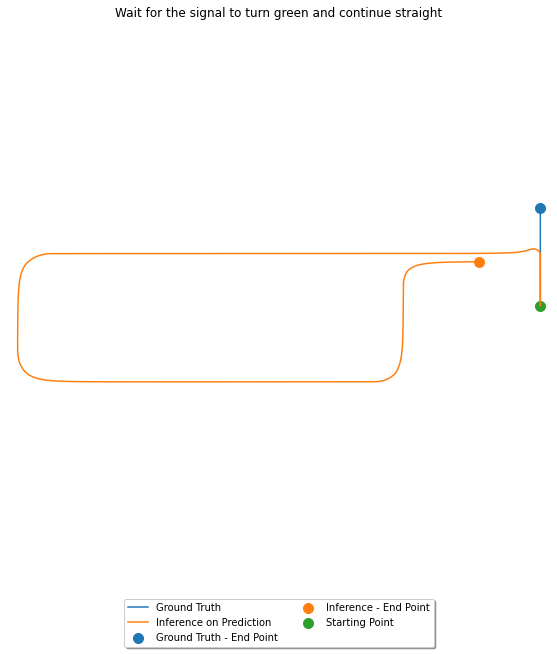

(63, 3) (63, 3)
Episode 15: Drive towards the bus stop and park after crossing it
Frechet Distance: 3.0628458209997507
FDE Distance: 3.062845820999751
ADE Distance: 4.249546495921356
ADE Matched Distance: 0.167367929308314
nDTW Distance: 0.9268349964299617
TC Distance: True


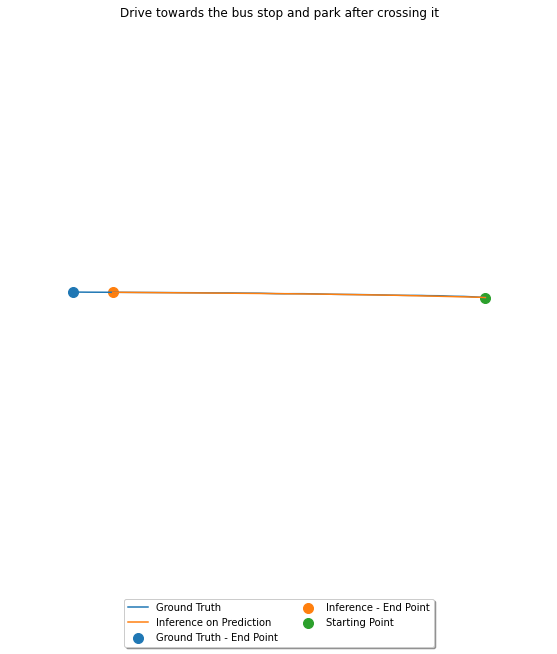

(81, 3) (81, 3)
Episode 16: take a right turn and stop across the bench on left
Frechet Distance: 116.69265587624413
FDE Distance: 15.261343073371249
ADE Distance: 80.55109989995711
ADE Matched Distance: 66.81893581824959
nDTW Distance: 2.385647594410936e-177
TC Distance: False


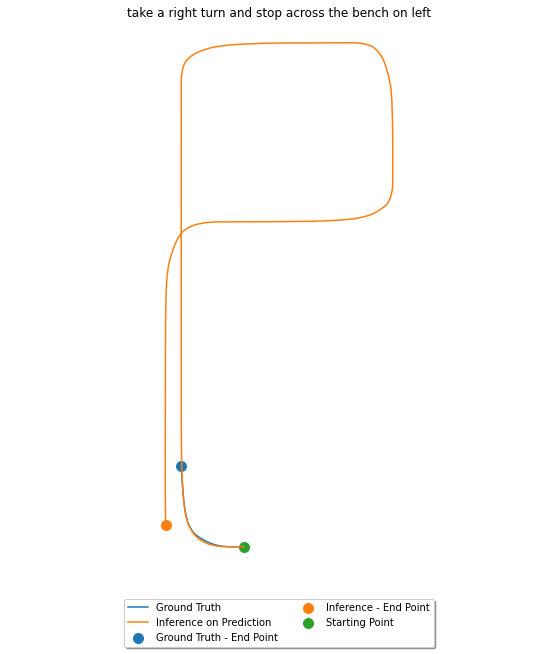

(61, 3) (61, 3)
Episode 17: Turn right from the crossroads ahead
Frechet Distance: 8.207580401746876
FDE Distance: 8.207580401746876
ADE Distance: 2.9512390572414056
ADE Matched Distance: 1.2824975264627325
nDTW Distance: 0.5788926120845048
TC Distance: False


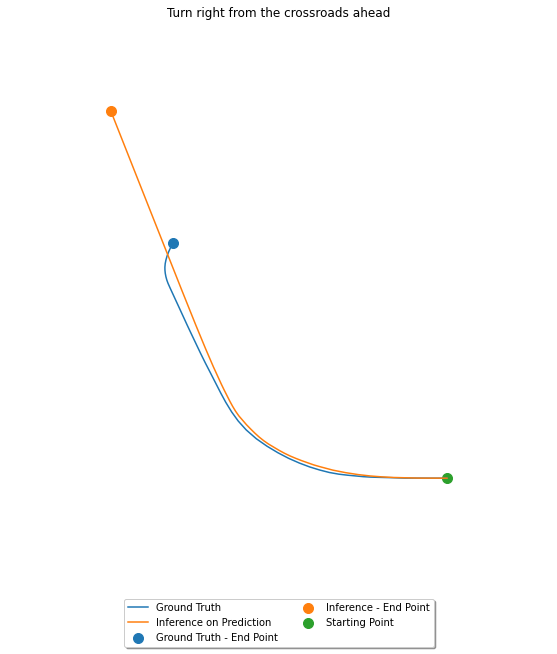

(76, 3) (76, 3)
Episode 18: Turn right and park near the sidewalk.
Frechet Distance: 30.60716166129232
FDE Distance: 30.60716166129232
ADE Distance: 9.036922251783523
ADE Matched Distance: 7.477616178545501
nDTW Distance: 0.2241313005443702
TC Distance: False


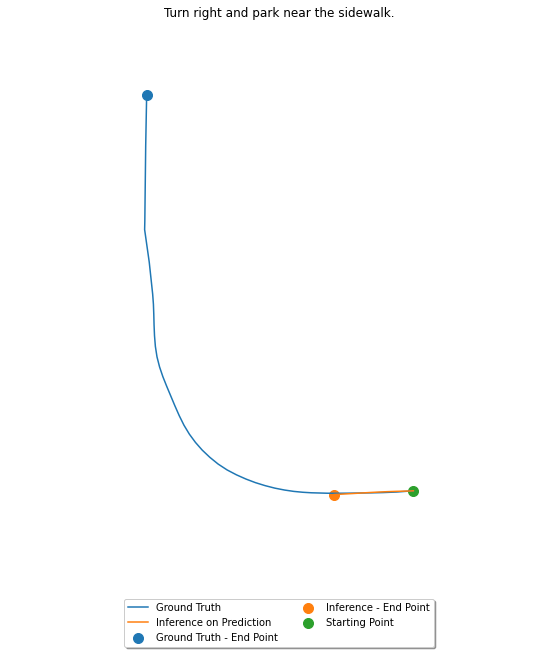

(103, 3) (103, 3)
Episode 19: go straight and take a right
Frechet Distance: 23.124830038253993
FDE Distance: 23.124830038253993
ADE Distance: 12.675799804910314
ADE Matched Distance: 5.571718300331182
nDTW Distance: 0.3281305734374942
TC Distance: False


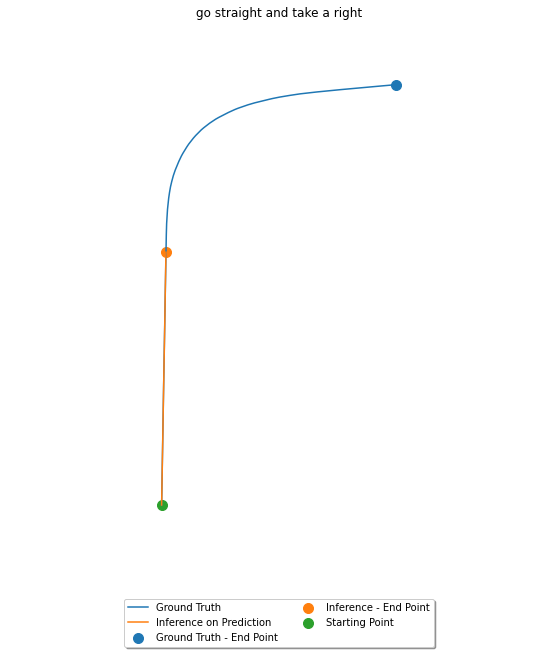

(42, 3) (42, 3)
Episode 20: park beside the red volkswagen
Frechet Distance: 12.022547526383223
FDE Distance: 12.022547526383223
ADE Distance: 5.020948377529645
ADE Matched Distance: 2.402746155638252
nDTW Distance: 0.26521055805800375
TC Distance: False


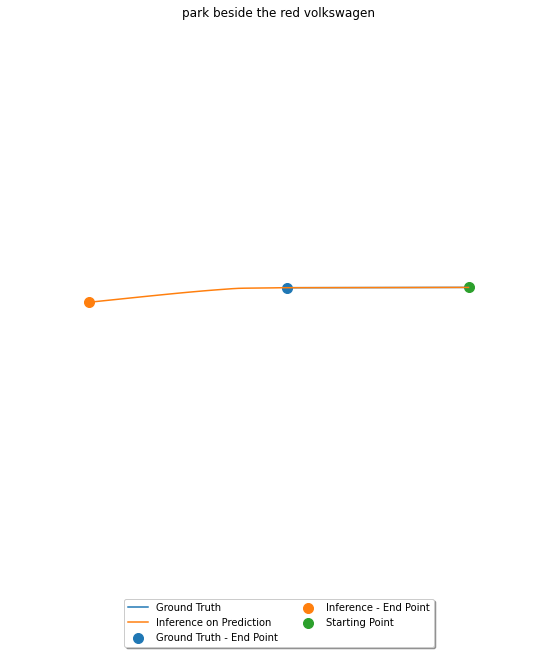

(147, 3) (147, 3)
Episode 21: Turn left from the next crossroads
Frechet Distance: 160.71985425548397
FDE Distance: 10.599583373132981
ADE Distance: 74.88599738421495
ADE Matched Distance: 66.41076499375112
nDTW Distance: 1.714162643615137e-64
TC Distance: False


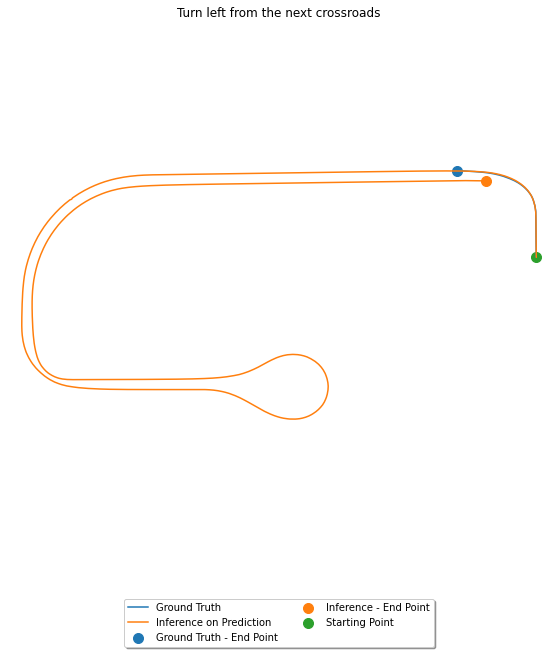

(66, 3) (66, 3)
Episode 22: Turn right from the crossroads.
Frechet Distance: 8.23208242186715
FDE Distance: 8.23208242186715
ADE Distance: 2.728143684764545
ADE Matched Distance: 1.0087211701866703
nDTW Distance: 0.5560526376393112
TC Distance: False


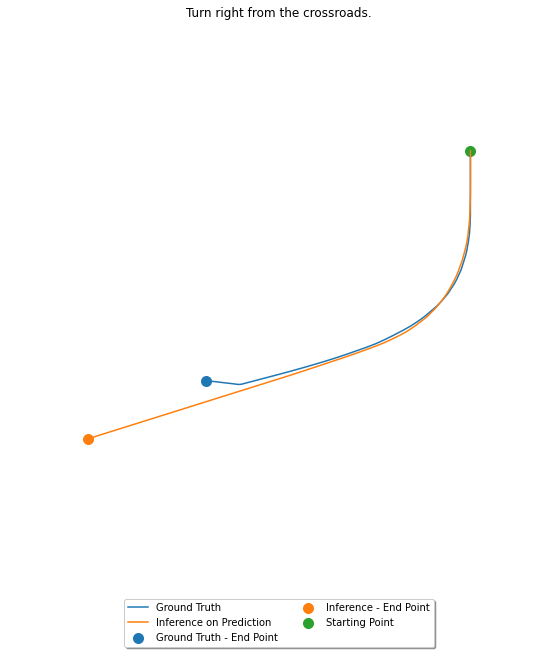

(71, 3) (71, 3)
Episode 23: stop by the lamp post
Frechet Distance: 90.79278150778984
FDE Distance: 90.79278150778984
ADE Distance: 50.4321376886164
ADE Matched Distance: 46.16420093477822
nDTW Distance: 2.417711221037763e-28
TC Distance: False


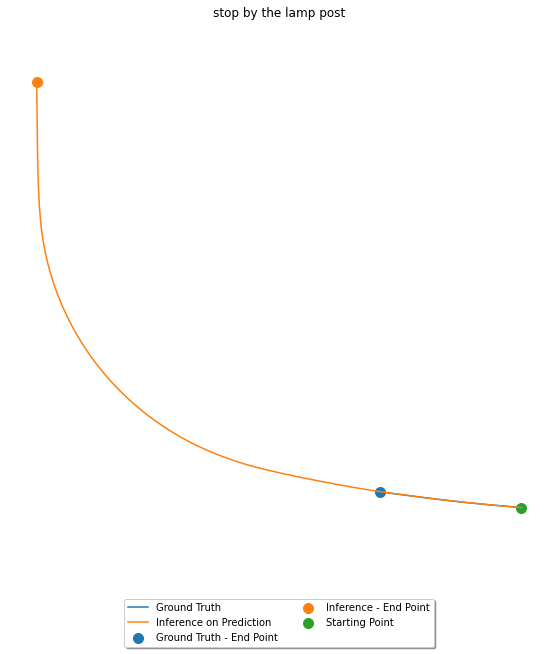

(50, 3) (50, 3)
Episode 24: park immediately after the signboard
Frechet Distance: 7.262300497796796
FDE Distance: 7.262300497796796
ADE Distance: 2.71613951183327
ADE Matched Distance: 1.030951447399075
nDTW Distance: 0.6197981170723504
TC Distance: False


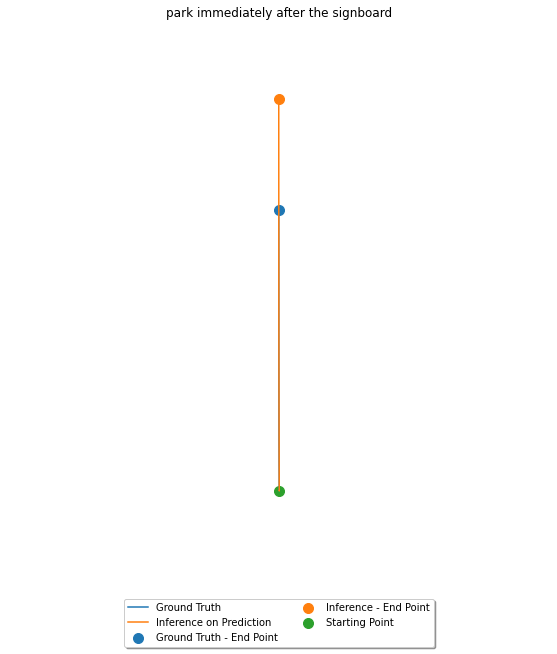

(176, 3) (176, 3)
Episode 25: Turn right and stop beside the traffic signal
Frechet Distance: 32.37060300580877
FDE Distance: 32.37060300580877
ADE Distance: 18.875199731959697
ADE Matched Distance: 8.127901932812698
nDTW Distance: 0.11624598627747695
TC Distance: False


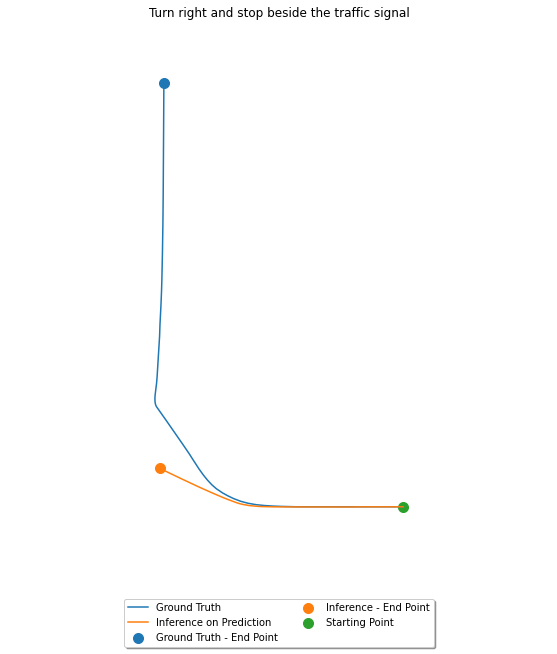

(167, 3) (167, 3)
Episode 26: Turn left and stop near the traffic signal
Frechet Distance: 23.217967151985647
FDE Distance: 23.217967151985647
ADE Distance: 32.36404891246313
ADE Matched Distance: 9.871440800353078
nDTW Distance: 0.13886012325030136
TC Distance: False


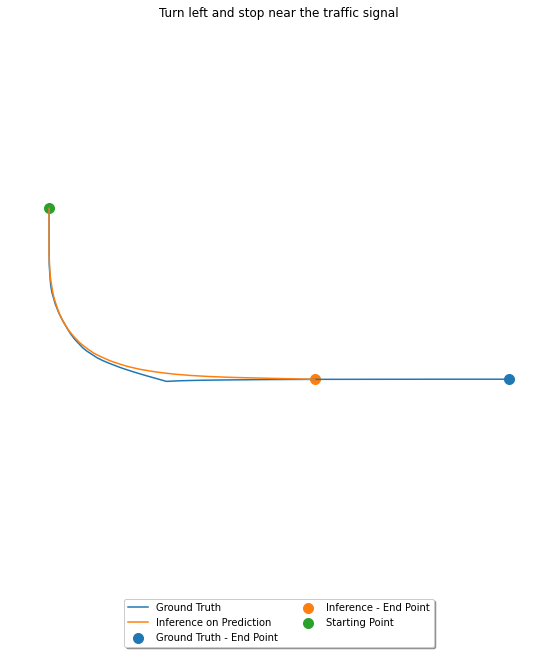

(358, 3) (358, 3)
Episode 27: Turn left and stop near the intersection
Frechet Distance: 169.1622068078016
FDE Distance: 36.138126282199
ADE Distance: 55.89636962943828
ADE Matched Distance: 54.868523417193195
nDTW Distance: 1.4743811031083133e-31
TC Distance: False


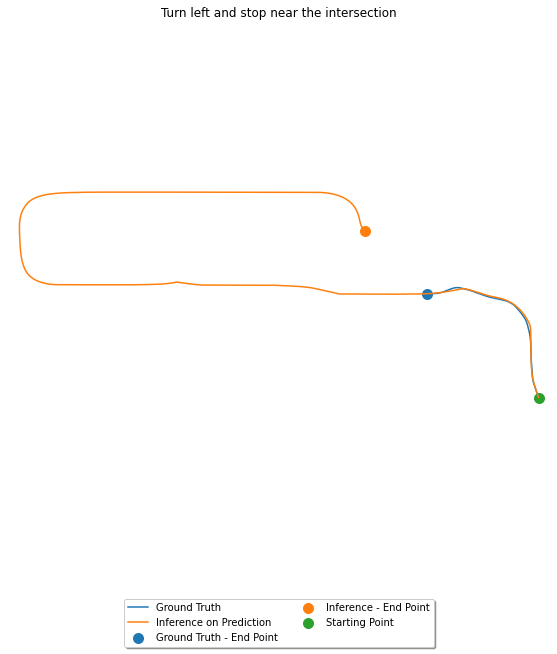

(143, 3) (143, 3)
Episode 28: Turn left and come to a halt at the intersection
Frechet Distance: 56.15855068305857
FDE Distance: 56.15855068305857
ADE Distance: 42.96517916038948
ADE Matched Distance: 29.139534572117626
nDTW Distance: 0.0029442330671343017
TC Distance: False


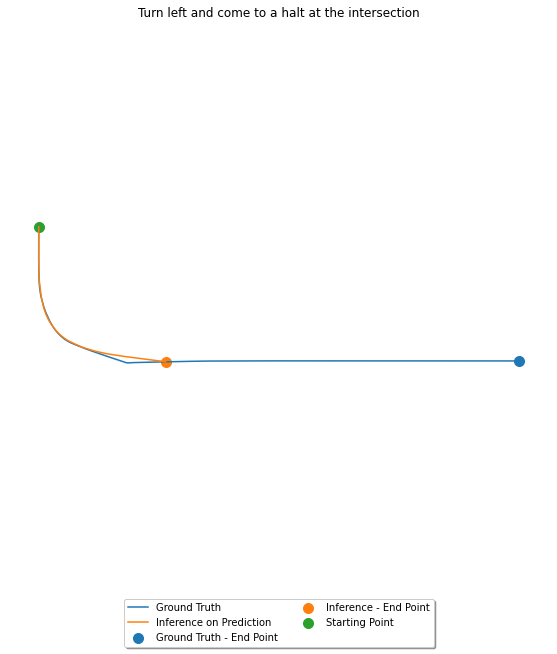

(194, 3) (194, 3)
Episode 29: Turn right and stop before the traffic signal
Frechet Distance: 159.87385849039768
FDE Distance: 40.70279387481685
ADE Distance: 83.4385173762321
ADE Matched Distance: 67.91606043026977
nDTW Distance: 1.5361319261898085e-78
TC Distance: False


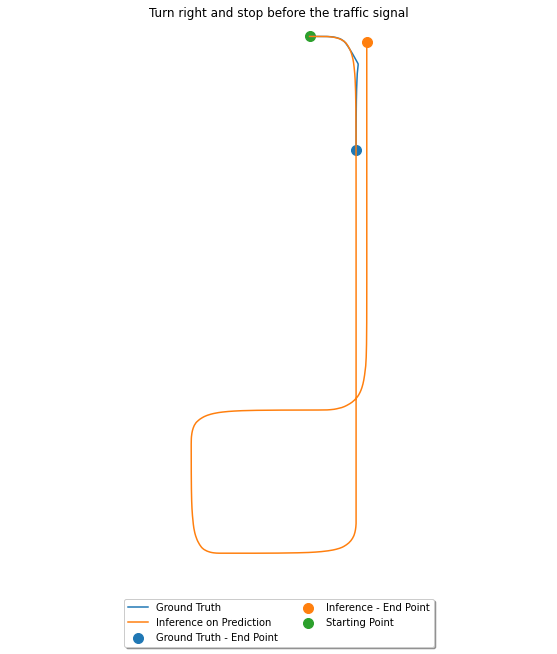

(153, 3) (153, 3)
Episode 30: Turn right and stop just before the traffic signal
Frechet Distance: 100.72922044668833
FDE Distance: 100.72922044668833
ADE Distance: 47.49019570656051
ADE Matched Distance: 45.61617139157099
nDTW Distance: 3.219894866209028e-27
TC Distance: False


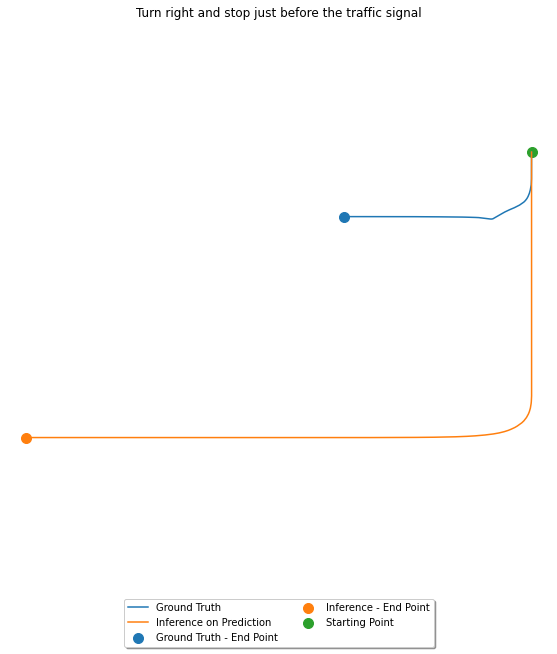

(144, 3) (144, 3)
Episode 31: Turn right and stop near the bus stop
Frechet Distance: 36.64777046295442
FDE Distance: 36.64777046295442
ADE Distance: 24.381887334602524
ADE Matched Distance: 12.529368967362585
nDTW Distance: 0.08160426155210371
TC Distance: False


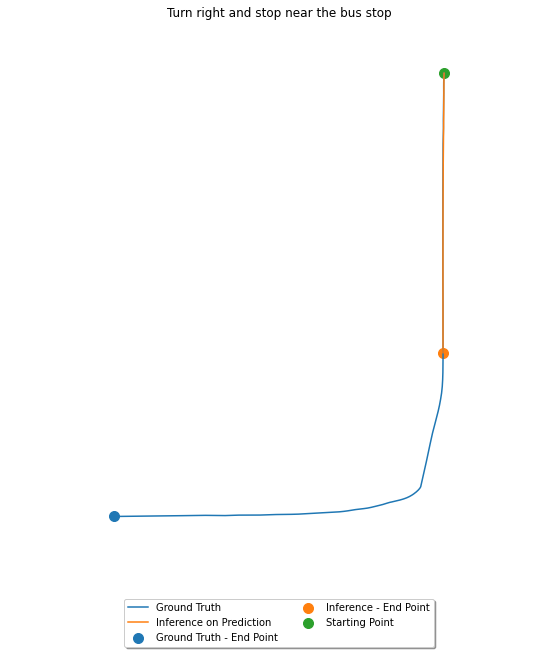

(188, 3) (188, 3)
Episode 32: Turn left and stop beside the traffic signal
Frechet Distance: 42.953336856303935
FDE Distance: 42.953336856303935
ADE Distance: 19.521274225099443
ADE Matched Distance: 3.7155014541184874
nDTW Distance: 0.09186755880506017
TC Distance: False


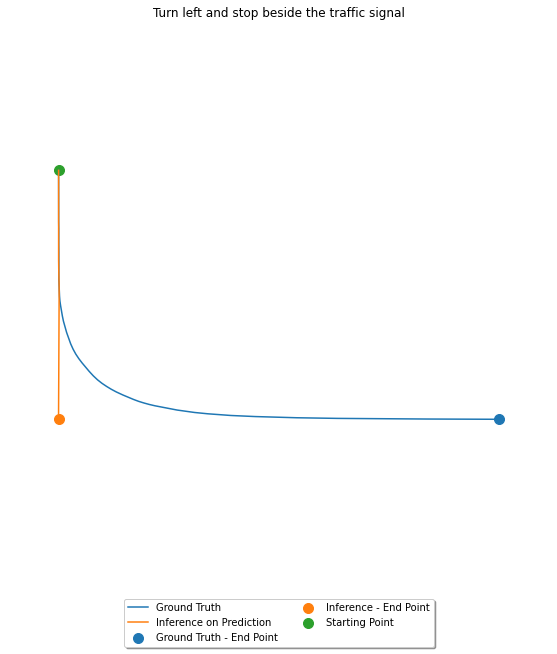

(166, 3) (166, 3)
Episode 33: Turn left and stop near the traffic signal
Frechet Distance: 43.52990341844897
FDE Distance: 43.52990341844897
ADE Distance: 29.30921870844198
ADE Matched Distance: 2.567861528701407
nDTW Distance: 0.13763753402509085
TC Distance: False


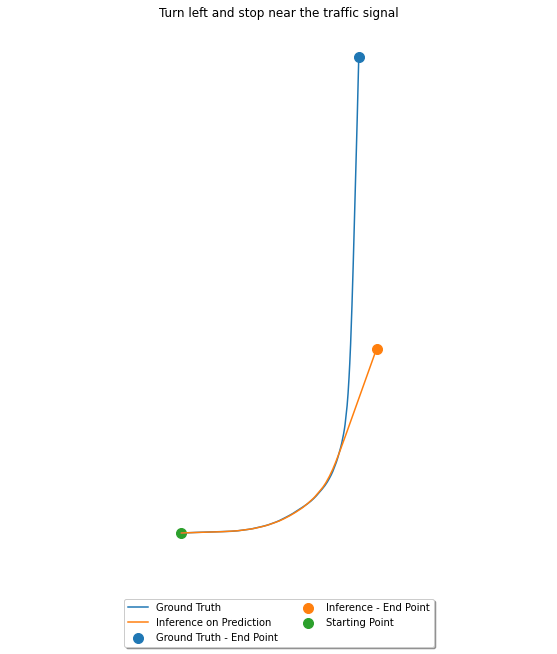

In [47]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/test/'
val_run_path = '/ssd_scratch/cvit/varunc/test_clip_6nomap/'
save_loc = '../trajectories_test_clip6/'

frechet_test_clip_6nomap,fde_test_clip_6nomap,ade_test_clip_6nomap, ade_matched_test_clip_6nomap, ndtw_test_clip_6nomap, tc_test_clip_6nomap = get_scores(val_data_path, val_run_path, save_loc,episodes=list(range(34)))

Episode 0: Turn left and stop next to the bus stop.
(371, 3) (371, 3)
1
Frechet Distance: 44.17995500476315
FDE Distance: 44.17995500476315
ADE Distance: 5.148983933687824
ADE Matched Distance: 2.7854756537517993
nDTW Distance: 0.5728707638356133
TC Distance: False
(297, 3) (297, 3)
2
Frechet Distance: 46.31812224549876
FDE Distance: 46.31812224549876
ADE Distance: 5.2069845012848255
ADE Matched Distance: 3.188633884788671
nDTW Distance: 0.5284924407674685
TC Distance: False
(407, 3) (407, 3)
3
Frechet Distance: 44.15361312554161
FDE Distance: 44.15361312554161
ADE Distance: 5.060001646252239
ADE Matched Distance: 2.81680261184487
nDTW Distance: 0.5692927247660196
TC Distance: False
(398, 3) (398, 3)
4
Frechet Distance: 41.5956349670449
FDE Distance: 41.5956349670449
ADE Distance: 4.934280668134676
ADE Matched Distance: 2.4303310473158675
nDTW Distance: 0.6150410844253938
TC Distance: False
(349, 3) (349, 3)
5
Frechet Distance: 44.221525619897164
FDE Distance: 44.221525619897164
ADE Di

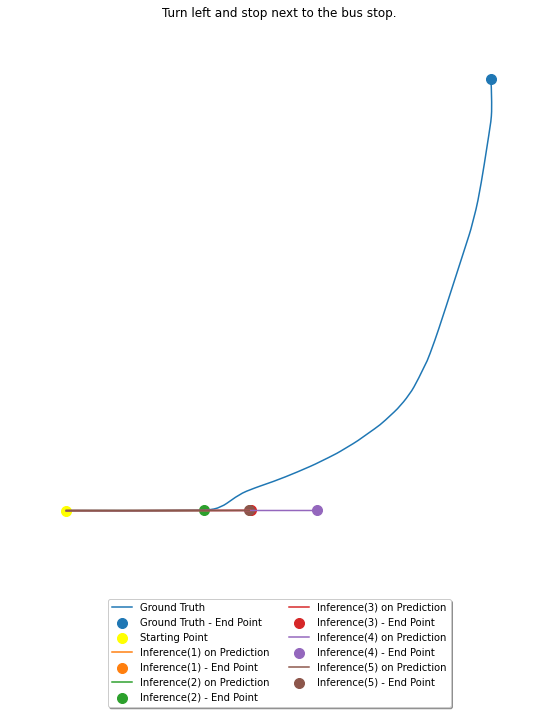

Episode 1: Take a left from the interection.
(94, 3) (94, 3)
1
Frechet Distance: 63.31882171073256
FDE Distance: 63.31882171073256
ADE Distance: 25.653595907514006
ADE Matched Distance: 21.555419222760264
nDTW Distance: 5.516732341820058e-06
TC Distance: False
(94, 3) (94, 3)
2
Frechet Distance: 17.663831595797717
FDE Distance: 17.663831595797717
ADE Distance: 20.767820305527877
ADE Matched Distance: 7.108579158233181
nDTW Distance: 0.005418156801605052
TC Distance: False
(94, 3) (94, 3)
3
Frechet Distance: 3.3097693666716346
FDE Distance: 3.309769366671635
ADE Distance: 7.924938307914782
ADE Matched Distance: 0.4227630501450469
nDTW Distance: 0.7766555502034854
TC Distance: True
(94, 3) (94, 3)
4
Frechet Distance: 39.61118426750048
FDE Distance: 39.61118426750048
ADE Distance: 16.595691222758756
ADE Matched Distance: 15.493466199796387
nDTW Distance: 8.592726603943902e-05
TC Distance: False
(94, 3) (94, 3)
5
Frechet Distance: 114.0020033738677
FDE Distance: 38.90323864841001
ADE Dista

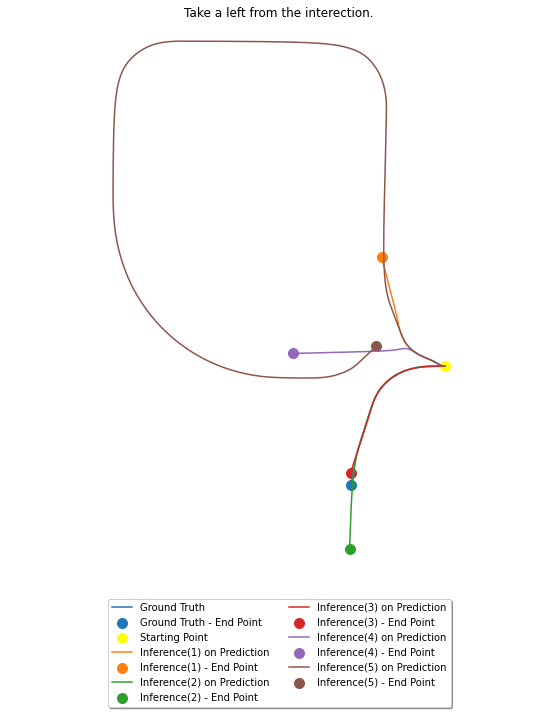

Episode 2: Drive straight till you see a red coloured board
(55, 3) (55, 3)
1
Frechet Distance: 10.376449658106484
FDE Distance: 10.376449658106484
ADE Distance: 4.990305952264928
ADE Matched Distance: 1.138171295354619
nDTW Distance: 0.7092687346121176
TC Distance: False
(55, 3) (55, 3)
2
Frechet Distance: 8.315765416277005
FDE Distance: 8.315765416277005
ADE Distance: 4.64083690707152
ADE Matched Distance: 0.7104859232081041
nDTW Distance: 0.7945820064865281
TC Distance: False
(55, 3) (55, 3)
3
Frechet Distance: 8.312683140882072
FDE Distance: 8.312683140882072
ADE Distance: 5.058295677113962
ADE Matched Distance: 0.7441153346054156
nDTW Distance: 0.7902459655917778
TC Distance: False
(55, 3) (55, 3)
4
Frechet Distance: 8.279617370929342
FDE Distance: 8.279617370929342
ADE Distance: 4.981029211686905
ADE Matched Distance: 0.714660839701216
nDTW Distance: 0.795573955106148
TC Distance: False
(55, 3) (55, 3)
5
Frechet Distance: 8.06117251866265
FDE Distance: 8.06117251866265
ADE Distan

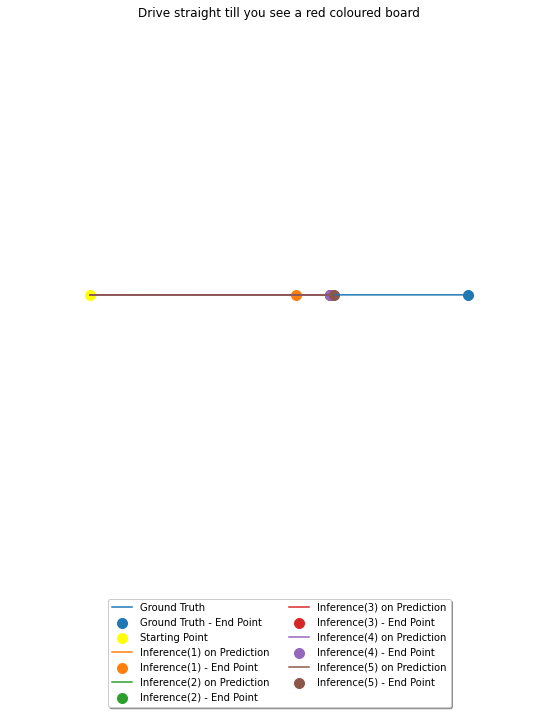

Episode 3: Park just ahead of the speed signboard
(38, 3) (38, 3)
1
Frechet Distance: 7.75610509127101
FDE Distance: 7.75610509127101
ADE Distance: 1.2218821588950701
ADE Matched Distance: 0.5535875419001
nDTW Distance: 0.7111347245917277
TC Distance: False
(38, 3) (38, 3)
2
Frechet Distance: 23.939199831129454
FDE Distance: 23.939199831129454
ADE Distance: 8.782038991391
ADE Matched Distance: 3.925589778146266
nDTW Distance: 0.03743688560935684
TC Distance: False
(38, 3) (38, 3)
3
Frechet Distance: 15.932239724756883
FDE Distance: 15.932239724756883
ADE Distance: 4.649293361496621
ADE Matched Distance: 2.071166598514908
nDTW Distance: 0.22460316921375284
TC Distance: False
(38, 3) (38, 3)
4
Frechet Distance: 14.058460053736688
FDE Distance: 14.058460053736688
ADE Distance: 2.2545749492079907
ADE Matched Distance: 1.7181594759860415
nDTW Distance: 0.28970752145555495
TC Distance: False
(38, 3) (38, 3)
5
Frechet Distance: 13.747547210397094
FDE Distance: 13.747547210397094
ADE Distance:

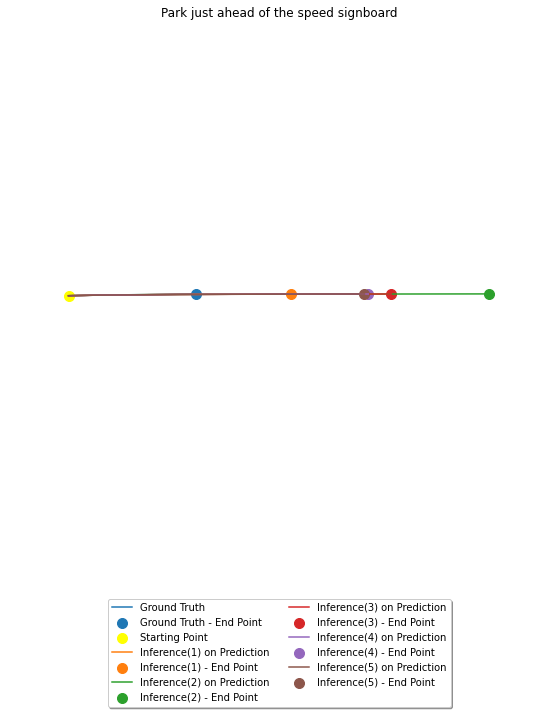

Episode 4: Take the next right turn.
(332, 3) (332, 3)
1
Frechet Distance: 91.78208805137204
FDE Distance: 39.25272751995633
ADE Distance: 47.79602642500563
ADE Matched Distance: 37.18810479230015
nDTW Distance: 2.8217024407096204e-17
TC Distance: False
(332, 3) (332, 3)
2
Frechet Distance: 141.62615454259821
FDE Distance: 47.947885078632844
ADE Distance: 78.28749072214156
ADE Matched Distance: 66.14054096776516
nDTW Distance: 4.6885381969821e-44
TC Distance: False
(147, 3) (147, 3)
3
Frechet Distance: 40.0883148279998
FDE Distance: 40.0883148279998
ADE Distance: 26.16867641570403
ADE Matched Distance: 10.001668578001265
nDTW Distance: 0.1352901272763752
TC Distance: False
(170, 3) (170, 3)
4
Frechet Distance: 43.92716583199189
FDE Distance: 43.92716583199189
ADE Distance: 29.272331086701183
ADE Matched Distance: 14.724026099834038
nDTW Distance: 0.05261230664513727
TC Distance: False
(332, 3) (332, 3)
5
Frechet Distance: 91.74121634904832
FDE Distance: 44.171461220701794
ADE Distance:

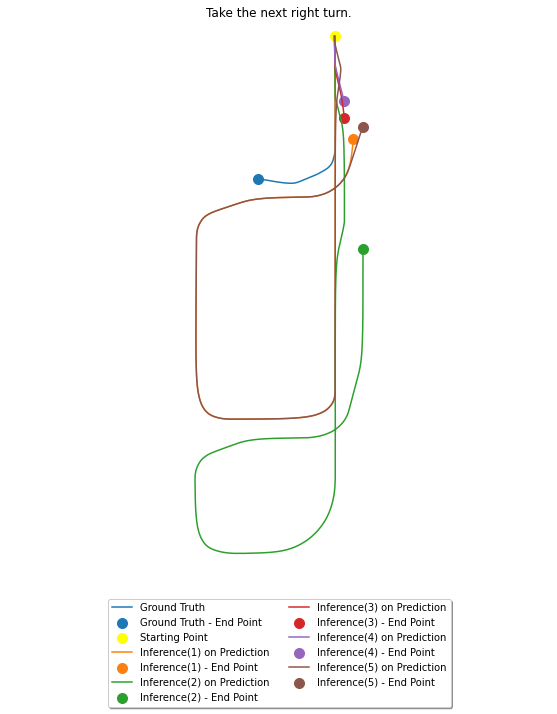

Episode 5: Drive straight from the next crossroads.
(48, 3) (48, 3)
1
Frechet Distance: 81.56893091917576
FDE Distance: 81.56893091917576
ADE Distance: 37.26924575023307
ADE Matched Distance: 35.44026398571048
nDTW Distance: 0.0008350217403190686
TC Distance: False
(92, 3) (92, 3)
2
Frechet Distance: 65.5918049877876
FDE Distance: 65.5918049877876
ADE Distance: 31.469806741525048
ADE Matched Distance: 22.86889409474364
nDTW Distance: 0.010318892723199993
TC Distance: False
(104, 3) (104, 3)
3
Frechet Distance: 59.51840704601527
FDE Distance: 59.51840704601527
ADE Distance: 29.178790973001657
ADE Matched Distance: 18.892404488548035
nDTW Distance: 0.02285738777488967
TC Distance: False
(106, 3) (106, 3)
4
Frechet Distance: 59.51840704601527
FDE Distance: 59.51840704601527
ADE Distance: 27.538745796404335
ADE Matched Distance: 18.88892288155377
nDTW Distance: 0.022873309405762026
TC Distance: False
(102, 3) (102, 3)
5
Frechet Distance: 61.66297987335753
FDE Distance: 61.66297987335753
AD

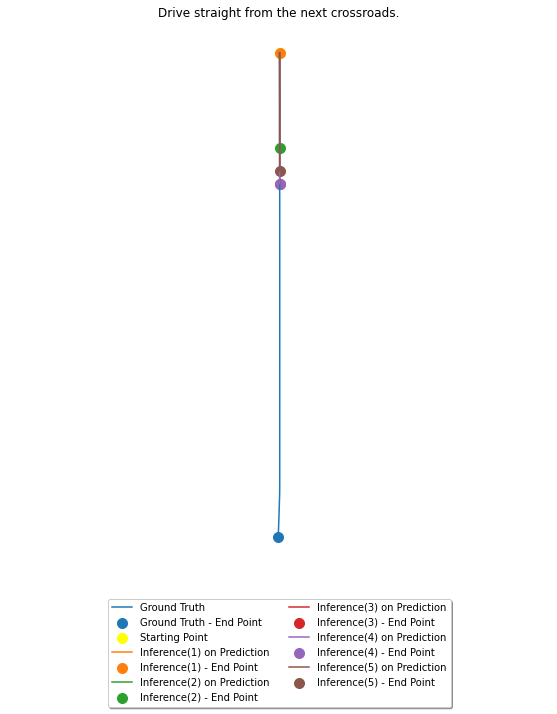

Episode 6: change to left lane
(70, 3) (70, 3)
1
Frechet Distance: 12.659098386295607
FDE Distance: 12.659098386295607
ADE Distance: 12.232247287261739
ADE Matched Distance: 2.850361561969004
nDTW Distance: 0.41160792161594856
TC Distance: False
(70, 3) (70, 3)
2
Frechet Distance: 14.919584340781723
FDE Distance: 14.919584340781723
ADE Distance: 13.489415204974915
ADE Matched Distance: 3.727395924607095
nDTW Distance: 0.3635924247325344
TC Distance: False
(70, 3) (70, 3)
3
Frechet Distance: 15.013826025641713
FDE Distance: 15.013826025641713
ADE Distance: 13.42131487350369
ADE Matched Distance: 3.701277539553946
nDTW Distance: 0.3585157695256402
TC Distance: False
(70, 3) (70, 3)
4
Frechet Distance: 14.692765490284746
FDE Distance: 14.692765490284746
ADE Distance: 13.50369544744794
ADE Matched Distance: 3.5965574513372545
nDTW Distance: 0.3653000945420154
TC Distance: False
(70, 3) (70, 3)
5
Frechet Distance: 3.8361882069720683
FDE Distance: 3.507939449981044
ADE Distance: 7.8016207586

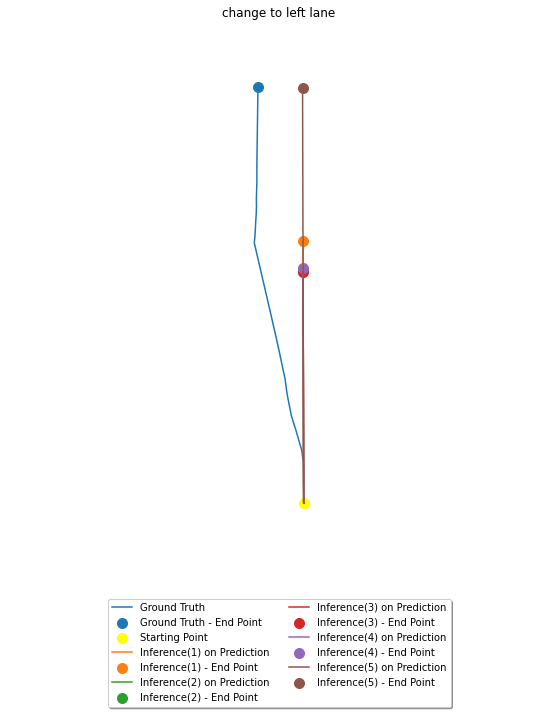

Episode 7: Stop near the scooty
(42, 3) (42, 3)
1
Frechet Distance: 18.142950483677396
FDE Distance: 18.142950483677396
ADE Distance: 7.873495328818592
ADE Matched Distance: 3.1702408762131706
nDTW Distance: 0.10869944253410495
TC Distance: False
(42, 3) (42, 3)
2
Frechet Distance: 18.150077693159293
FDE Distance: 18.150077693159293
ADE Distance: 5.526557067069631
ADE Matched Distance: 3.1718927889200286
nDTW Distance: 0.1085738217849362
TC Distance: False
(42, 3) (42, 3)
3
Frechet Distance: 18.14184508104654
FDE Distance: 18.14184508104654
ADE Distance: 5.09008298786575
ADE Matched Distance: 3.1695842703638624
nDTW Distance: 0.10874941490032607
TC Distance: False
(42, 3) (42, 3)
4
Frechet Distance: 22.20162920694164
FDE Distance: 22.20162920694164
ADE Distance: 7.429637419911302
ADE Matched Distance: 4.364284675453299
nDTW Distance: 0.03749286388257348
TC Distance: False
(42, 3) (42, 3)
5
Frechet Distance: 12.254973500098702
FDE Distance: 12.254973500098702
ADE Distance: 3.60513953329

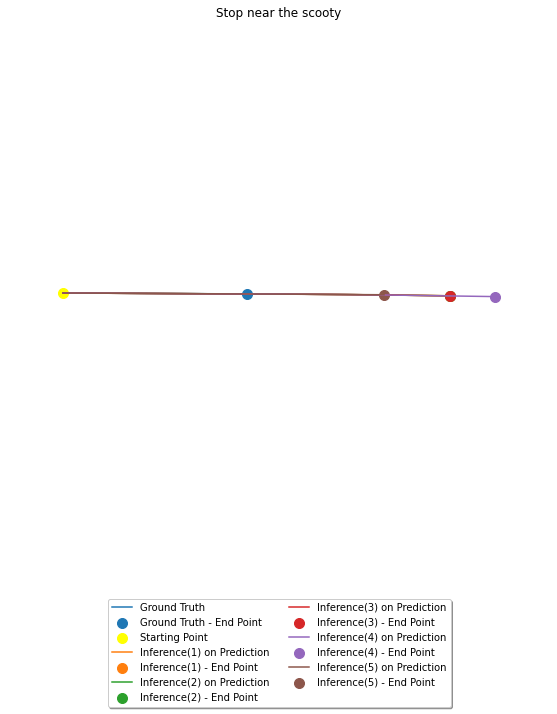

Episode 8: take right and stop near the speed limit sign
(142, 3) (142, 3)
1
Frechet Distance: 208.2671637542054
FDE Distance: 181.23388597849058
ADE Distance: 151.09276682259207
ADE Matched Distance: 128.15809604974694
nDTW Distance: 2.3587859399311084e-157
TC Distance: False
(142, 3) (142, 3)
2
Frechet Distance: 173.20511230908005
FDE Distance: 173.20511230908005
ADE Distance: 99.35859052532906
ADE Matched Distance: 97.94291036515047
nDTW Distance: 2.2524750113566636e-62
TC Distance: False
(142, 3) (142, 3)
3
Frechet Distance: 180.21059351526367
FDE Distance: 180.21059351526367
ADE Distance: 136.94912084420216
ADE Matched Distance: 117.90695139694162
nDTW Distance: 6.743959104451333e-145
TC Distance: False
(142, 3) (142, 3)
4
Frechet Distance: 208.3182857409169
FDE Distance: 202.56044914359603
ADE Distance: 145.34077403754955
ADE Matched Distance: 124.92571587641757
nDTW Distance: 1.7648151192488496e-153
TC Distance: False
(142, 3) (142, 3)
5
Frechet Distance: 6.215066209149426
FDE D

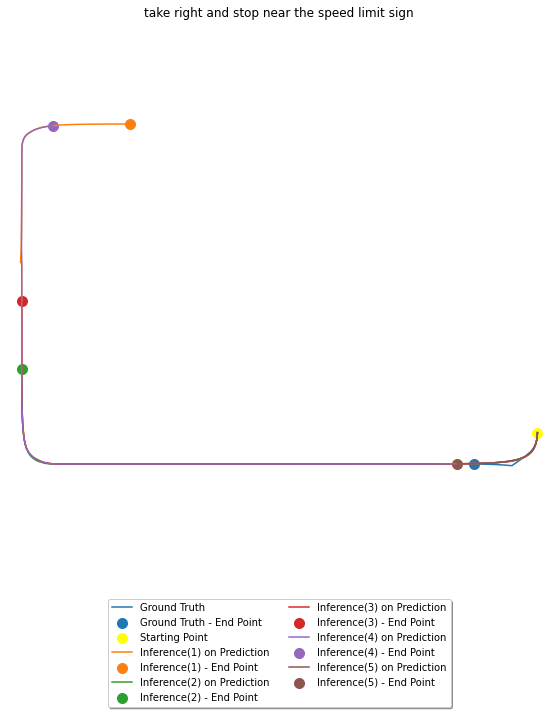

Episode 9: Turn right and stop near the bus stop.
(59, 3) (59, 3)
1
Frechet Distance: 8.623481410034039
FDE Distance: 8.623481410034039
ADE Distance: 5.148396144294297
ADE Matched Distance: 0.9448316818384606
nDTW Distance: 0.7543882712394276
TC Distance: False
(59, 3) (59, 3)
2
Frechet Distance: 4.46476888142253
FDE Distance: 4.46476888142253
ADE Distance: 3.2239909346622984
ADE Matched Distance: 0.3319957190060533
nDTW Distance: 0.8925557244544011
TC Distance: True
(59, 3) (59, 3)
3
Frechet Distance: 67.38865733813763
FDE Distance: 8.4204057937385
ADE Distance: 44.18917072999894
ADE Matched Distance: 42.538010144019125
nDTW Distance: 4.130648386817039e-100
TC Distance: False
(59, 3) (59, 3)
4
Frechet Distance: 8.322200116359905
FDE Distance: 8.322200116359905
ADE Distance: 2.008573750488552
ADE Matched Distance: 0.8228770490986171
nDTW Distance: 0.6958481732345239
TC Distance: False
(59, 3) (59, 3)
5
Frechet Distance: 9.62488313100445
FDE Distance: 9.62488313100445
ADE Distance: 2.85

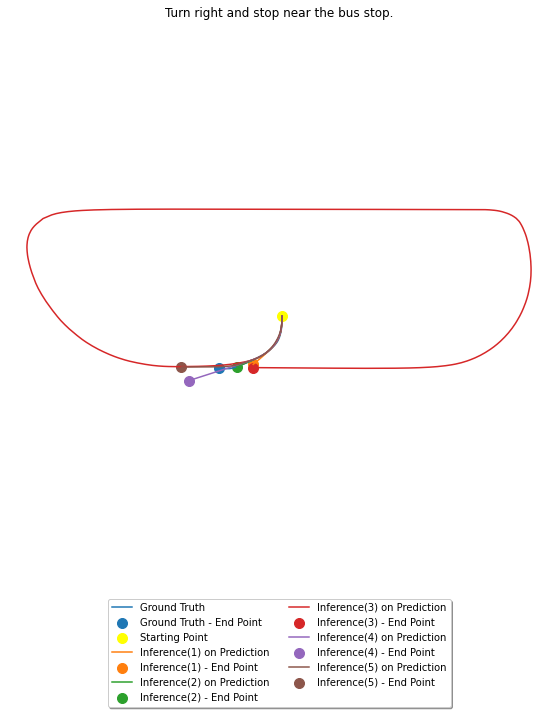

Episode 10: Shift to the left lane and stop at the intersection.
(66, 3) (66, 3)
1
Frechet Distance: 10.675502026389774
FDE Distance: 10.675502026389774
ADE Distance: 5.322766042313457
ADE Matched Distance: 2.395544204598015
nDTW Distance: 0.5594853201640169
TC Distance: False
(66, 3) (66, 3)
2
Frechet Distance: 6.521560232867296
FDE Distance: 6.521560232867296
ADE Distance: 3.2778895952386207
ADE Matched Distance: 1.8535740309359503
nDTW Distance: 0.5183128573449114
TC Distance: False
(66, 3) (66, 3)
3
Frechet Distance: 10.87847224308837
FDE Distance: 10.87847224308837
ADE Distance: 3.808995995887737
ADE Matched Distance: 2.402304546181281
nDTW Distance: 0.39384298060960754
TC Distance: False
(66, 3) (66, 3)
4
Frechet Distance: 6.963665418844309
FDE Distance: 6.963665418844309
ADE Distance: 4.512070647904273
ADE Matched Distance: 1.750923959005894
nDTW Distance: 0.6236169970013974
TC Distance: False
(66, 3) (66, 3)
5
Frechet Distance: 3.837838011091674
FDE Distance: 3.530894632129926


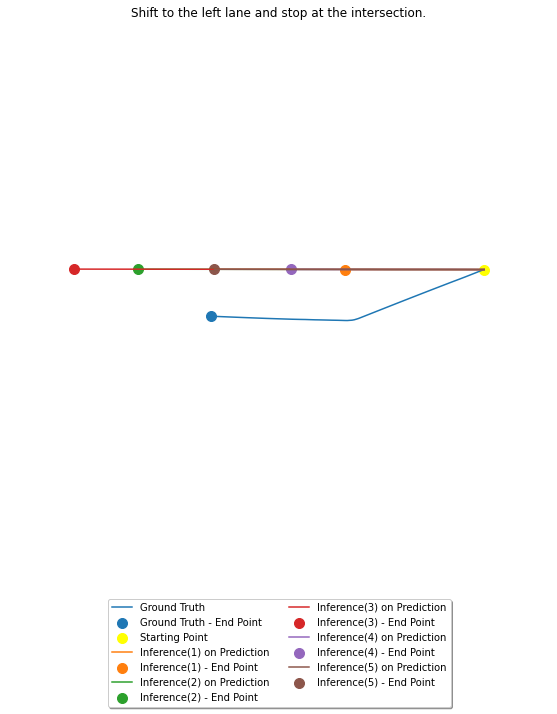

Episode 11: Stop after crossing the stop signboard
(45, 3) (45, 3)
1
Frechet Distance: 9.362956814914993
FDE Distance: 9.362956814914993
ADE Distance: 2.1817035108907983
ADE Matched Distance: 1.1152020171083854
nDTW Distance: 0.55168700738588
TC Distance: False
(45, 3) (45, 3)
2
Frechet Distance: 3.1515558272243913
FDE Distance: 3.1515558272243913
ADE Distance: 1.0318598134014598
ADE Matched Distance: 0.21811620820013303
nDTW Distance: 0.9049742822519329
TC Distance: True
(45, 3) (45, 3)
3
Frechet Distance: 11.119881717746543
FDE Distance: 11.119881717746544
ADE Distance: 2.653602648312506
ADE Matched Distance: 1.484138848564124
nDTW Distance: 0.4384447018991729
TC Distance: False
(45, 3) (45, 3)
4
Frechet Distance: 11.176835278530453
FDE Distance: 11.17683527853045
ADE Distance: 2.6696084561123397
ADE Matched Distance: 1.498638038386327
nDTW Distance: 0.43492716965448663
TC Distance: False
(45, 3) (45, 3)
5
Frechet Distance: 3.142041988913738
FDE Distance: 3.142041988913738
ADE Distan

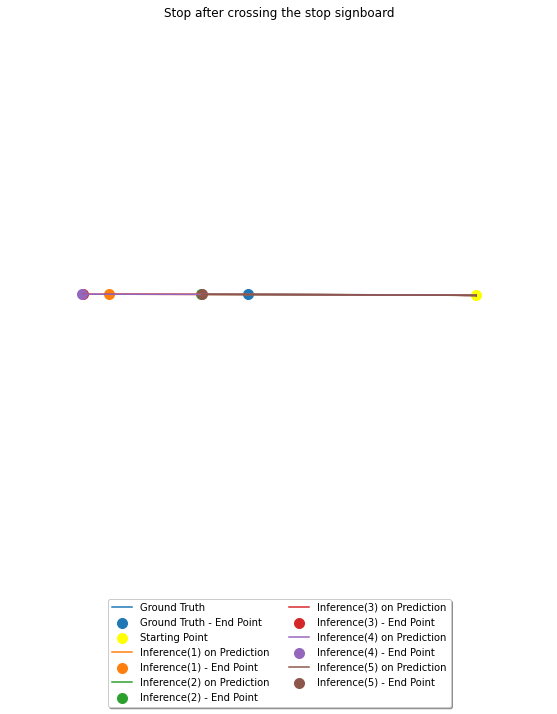

Episode 12: Park near the red signboard
(45, 3) (45, 3)
1
Frechet Distance: 5.411316218190828
FDE Distance: 5.411316218190828
ADE Distance: 4.098225656105861
ADE Matched Distance: 0.5493532564628262
nDTW Distance: 0.424437260628403
TC Distance: False
(45, 3) (45, 3)
2
Frechet Distance: 5.240143098719512
FDE Distance: 5.240143098719512
ADE Distance: 2.259959295781142
ADE Matched Distance: 0.5229167096088231
nDTW Distance: 0.4569355039404409
TC Distance: False
(45, 3) (45, 3)
3
Frechet Distance: 311.4813913807042
FDE Distance: 311.4813913807042
ADE Distance: 171.4408277215904
ADE Matched Distance: 156.44341931701288
nDTW Distance: 0.0
TC Distance: False
(45, 3) (45, 3)
4
Frechet Distance: 7.2917192685143934
FDE Distance: 7.2917192685143934
ADE Distance: 1.954754950849925
ADE Matched Distance: 0.9159926247856756
nDTW Distance: 0.2163786378375595
TC Distance: False
(45, 3) (45, 3)
5
Frechet Distance: 18.956061011527975
FDE Distance: 18.95606101152797
ADE Distance: 6.398081333771132
ADE Mat

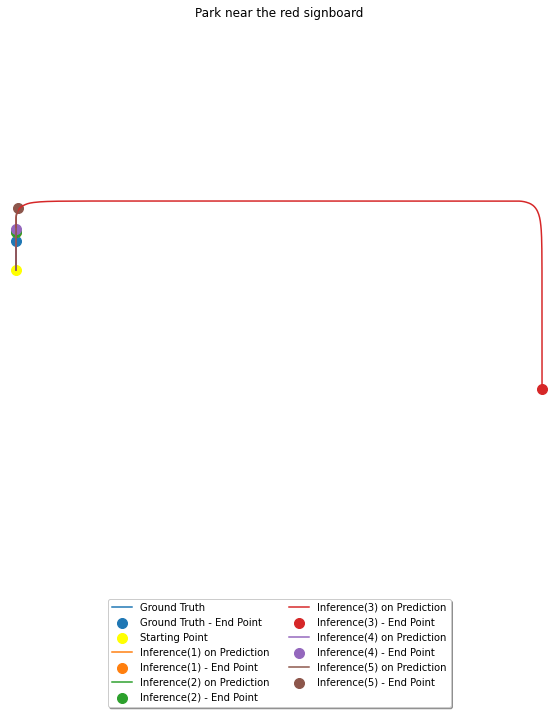

Episode 13: Wait at the traffic light then go straight.
(340, 3) (340, 3)
1
Frechet Distance: 147.58429389899817
FDE Distance: 58.070620447602906
ADE Distance: 59.366476543184056
ADE Matched Distance: 50.349128047691174
nDTW Distance: 4.343144210266821e-33
TC Distance: False
(340, 3) (340, 3)
2
Frechet Distance: 86.51546423476377
FDE Distance: 86.51546423476375
ADE Distance: 18.87131584422031
ADE Matched Distance: 12.7655538614831
nDTW Distance: 0.021074262795234815
TC Distance: False
(340, 3) (340, 3)
3
Frechet Distance: 86.51546423476377
FDE Distance: 86.51546423476375
ADE Distance: 19.180206760685486
ADE Matched Distance: 12.765785832545301
nDTW Distance: 0.021072784758697102
TC Distance: False
(340, 3) (340, 3)
4
Frechet Distance: 63.15497546449513
FDE Distance: 63.15497546449513
ADE Distance: 44.1253940356557
ADE Matched Distance: 26.380085823516566
nDTW Distance: 1.741973690378531e-15
TC Distance: False
(340, 3) (340, 3)
5
Frechet Distance: 72.61420564373228
FDE Distance: 72.6142

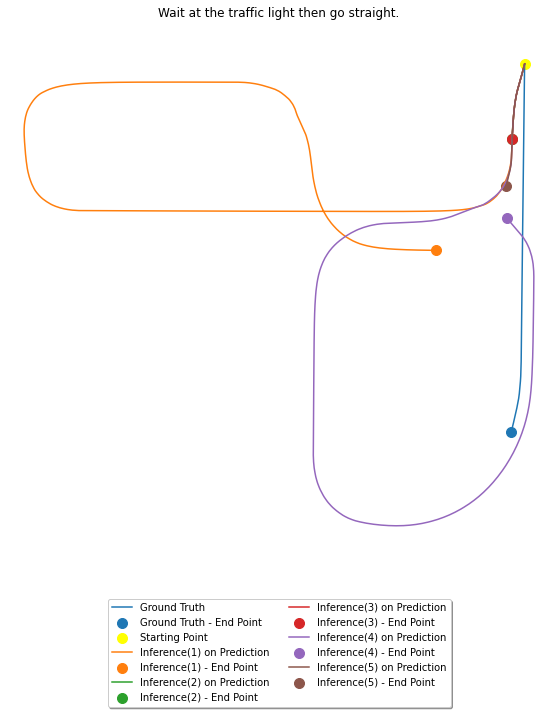

Episode 14: Drive straight till the intersection and then turn left
(73, 3) (73, 3)
1
Frechet Distance: 13.21919053811617
FDE Distance: 13.21919053811617
ADE Distance: 8.150564161103544
ADE Matched Distance: 0.4403606386947712
nDTW Distance: 0.5320687842942871
TC Distance: False
(73, 3) (73, 3)
2
Frechet Distance: 13.316353584537666
FDE Distance: 13.316353584537664
ADE Distance: 8.267701209776511
ADE Matched Distance: 0.4257884923900661
nDTW Distance: 0.5587208169621376
TC Distance: False
(73, 3) (73, 3)
3
Frechet Distance: 13.322868375132023
FDE Distance: 13.322868375132023
ADE Distance: 8.5203643313422
ADE Matched Distance: 0.4437251978073292
nDTW Distance: 0.5531982594275056
TC Distance: False
(73, 3) (73, 3)
4
Frechet Distance: 13.30800372967378
FDE Distance: 13.30800372967378
ADE Distance: 8.596456407891985
ADE Matched Distance: 0.4433051427391466
nDTW Distance: 0.5508258909876493
TC Distance: False
(73, 3) (73, 3)
5
Frechet Distance: 8.867907622246808
FDE Distance: 8.867907622246

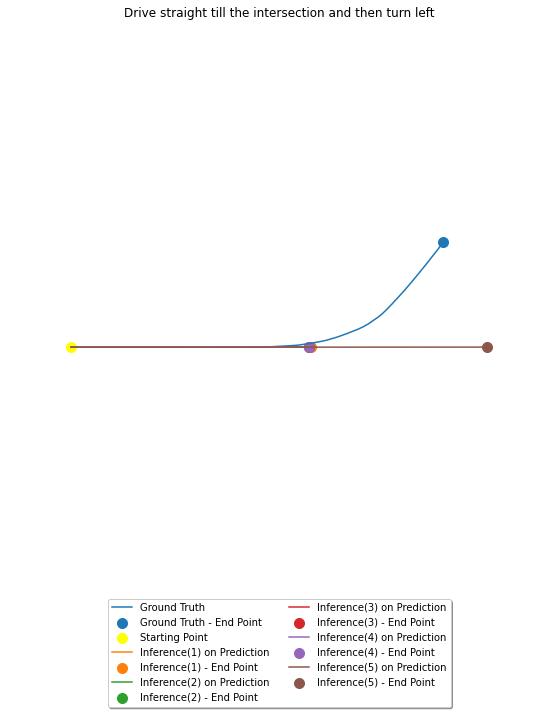

Episode 15: go straight and take a left
(239, 3) (239, 3)
1
Frechet Distance: 120.96963886622589
FDE Distance: 120.96963865862774
ADE Distance: 92.10795845136616
ADE Matched Distance: 64.48599017383569
nDTW Distance: 2.0988876869133245e-25
TC Distance: False
(239, 3) (239, 3)
2
Frechet Distance: 97.1273562199121
FDE Distance: 97.1273562199121
ADE Distance: 57.420578595595174
ADE Matched Distance: 33.14963248908483
nDTW Distance: 2.003278227296984e-09
TC Distance: False
(239, 3) (239, 3)
3
Frechet Distance: 39.046770573608924
FDE Distance: 39.046770573608924
ADE Distance: 12.883016521727637
ADE Matched Distance: 9.432068031745587
nDTW Distance: 0.11144340217430498
TC Distance: False
(239, 3) (239, 3)
4
Frechet Distance: 39.17109108526588
FDE Distance: 39.17109108526588
ADE Distance: 13.614967784053382
ADE Matched Distance: 9.567955934270332
nDTW Distance: 0.10971847399107364
TC Distance: False
(239, 3) (239, 3)
5
Frechet Distance: 8.23409936364932
FDE Distance: 8.23409936364932
ADE Dist

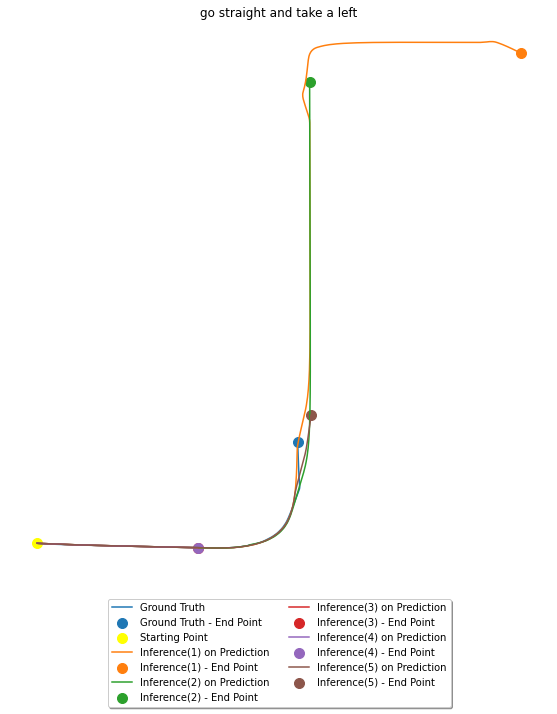

Episode 16: Stop as soon as you encounter a white car
(47, 3) (47, 3)
1
Frechet Distance: 5.393465318306387
FDE Distance: 5.393465318306387
ADE Distance: 2.6778339724265865
ADE Matched Distance: 0.31193642623688167
nDTW Distance: 0.8803556120020216
TC Distance: False
(47, 3) (47, 3)
2
Frechet Distance: 5.126009366085624
FDE Distance: 5.126009366085624
ADE Distance: 3.686073807204531
ADE Matched Distance: 0.28649640436563967
nDTW Distance: 0.8884686087250464
TC Distance: False
(47, 3) (47, 3)
3
Frechet Distance: 5.393465318306387
FDE Distance: 5.393465318306387
ADE Distance: 3.7088957053156544
ADE Matched Distance: 0.3119364192476223
nDTW Distance: 0.8803556145156013
TC Distance: False
(47, 3) (47, 3)
4
Frechet Distance: 5.126009996906627
FDE Distance: 5.126009996906627
ADE Distance: 3.2957398203729293
ADE Matched Distance: 0.29064334249163376
nDTW Distance: 0.8869491046316011
TC Distance: False
(47, 3) (47, 3)
5
Frechet Distance: 1.2388421381757018
FDE Distance: 1.2388421381757018
ADE 

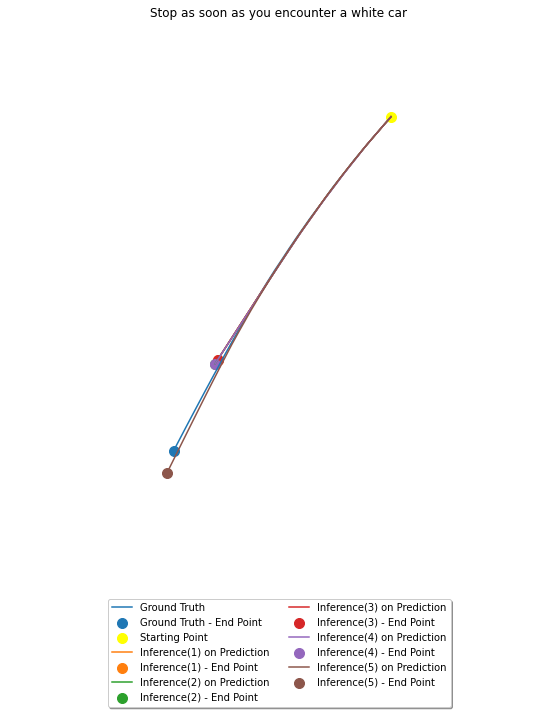

Episode 17: take a right at the intersection
(100, 3) (100, 3)
1
Frechet Distance: 25.51073426802616
FDE Distance: 25.51073426802616
ADE Distance: 12.275410499991038
ADE Matched Distance: 6.340823644667925
nDTW Distance: 0.28134749716915486
TC Distance: False
(103, 3) (103, 3)
2
Frechet Distance: 25.2466184835969
FDE Distance: 25.2466184835969
ADE Distance: 12.170028572534664
ADE Matched Distance: 6.228020413003945
nDTW Distance: 0.2877670205646276
TC Distance: False
(105, 3) (105, 3)
3
Frechet Distance: 21.62352821116384
FDE Distance: 21.62352821116384
ADE Distance: 10.924063000951726
ADE Matched Distance: 4.399667458858743
nDTW Distance: 0.39778839472990707
TC Distance: False
(105, 3) (105, 3)
4
Frechet Distance: 21.36935317627761
FDE Distance: 21.36935317627761
ADE Distance: 10.87597701513231
ADE Matched Distance: 4.258872852523135
nDTW Distance: 0.40638779989783924
TC Distance: False
(105, 3) (105, 3)
5
Frechet Distance: 21.46696537250461
FDE Distance: 21.46696537250461
ADE Distanc

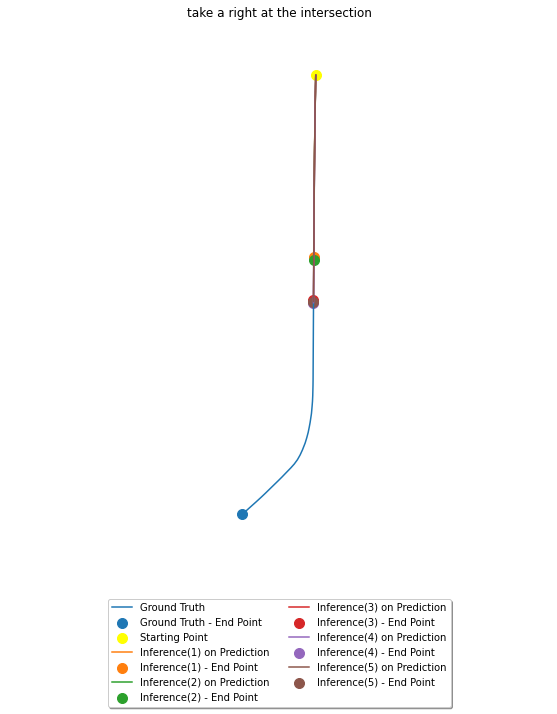

Episode 18: Stop near the red shelters
(44, 3) (44, 3)
1
Frechet Distance: 20.053008744501867
FDE Distance: 20.053008744501867
ADE Distance: 22.560807812133174
ADE Matched Distance: 10.487311630165008
nDTW Distance: 2.4523565355860727e-06
TC Distance: False
(44, 3) (44, 3)
2
Frechet Distance: 2.399335649611436
FDE Distance: 2.399335649611436
ADE Distance: 1.5835184461529037
ADE Matched Distance: 0.13793712761026306
nDTW Distance: 0.9427663758393221
TC Distance: True
(44, 3) (44, 3)
3
Frechet Distance: 6.447316583321964
FDE Distance: 6.447316583321964
ADE Distance: 3.313167309903608
ADE Matched Distance: 0.45126178677105533
nDTW Distance: 0.8417266552224937
TC Distance: False
(44, 3) (44, 3)
4
Frechet Distance: 6.452176908966485
FDE Distance: 6.452176908966485
ADE Distance: 3.8118738978315183
ADE Matched Distance: 0.45567499527726163
nDTW Distance: 0.8403095037216993
TC Distance: False
(44, 3) (44, 3)
5
Frechet Distance: 15.661075814973668
FDE Distance: 15.661075814973668
ADE Distance: 

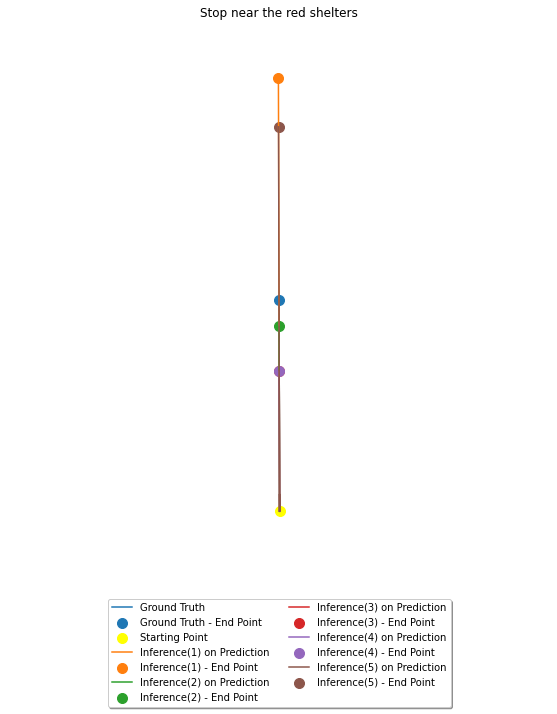

Episode 19: Turn left from the intersection
(127, 3) (127, 3)
1
Frechet Distance: 30.7977496091593
FDE Distance: 30.797749609159297
ADE Distance: 8.908196128426935
ADE Matched Distance: 5.992933833774036
nDTW Distance: 0.1712127692417674
TC Distance: False
(127, 3) (127, 3)
2
Frechet Distance: 18.954160593860387
FDE Distance: 18.954160593860387
ADE Distance: 9.76409189728453
ADE Matched Distance: 0.8791947580117837
nDTW Distance: 0.4676090422273249
TC Distance: False
(127, 3) (127, 3)
3
Frechet Distance: 20.379615352589493
FDE Distance: 20.379615352589493
ADE Distance: 9.807187829790676
ADE Matched Distance: 1.181036658855215
nDTW Distance: 0.46387562914617736
TC Distance: False
(127, 3) (127, 3)
4
Frechet Distance: 19.123030424191825
FDE Distance: 19.123030424191825
ADE Distance: 9.240861125973378
ADE Matched Distance: 0.9450468175305714
nDTW Distance: 0.5141432123771789
TC Distance: False
(127, 3) (127, 3)
5
Frechet Distance: 29.918031007256555
FDE Distance: 29.918031007256555
ADE Di

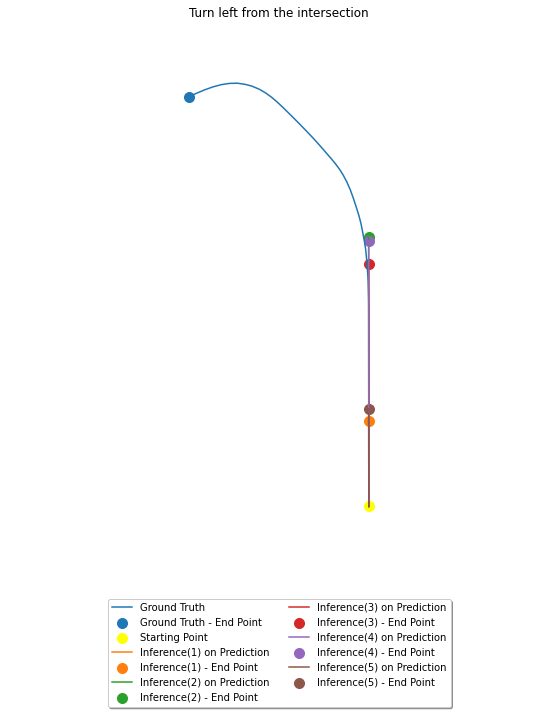

Episode 20: Drive straight then turn right
(127, 3) (127, 3)
1
Frechet Distance: 37.02920534799059
FDE Distance: 37.02920534799059
ADE Distance: 13.2473233249949
ADE Matched Distance: 8.899208511887378
nDTW Distance: 0.08728965895530191
TC Distance: False
(127, 3) (127, 3)
2
Frechet Distance: 36.27983804208147
FDE Distance: 36.27983804208147
ADE Distance: 10.261474696950534
ADE Matched Distance: 5.108825203925431
nDTW Distance: 0.15465918134248144
TC Distance: False
(127, 3) (127, 3)
3
Frechet Distance: 35.494928850874494
FDE Distance: 35.494928850874494
ADE Distance: 11.510844410219764
ADE Matched Distance: 6.10405623815659
nDTW Distance: 0.11065861908027542
TC Distance: False
(127, 3) (127, 3)
4
Frechet Distance: 35.05487033893656
FDE Distance: 35.05487033893656
ADE Distance: 13.028806565956716
ADE Matched Distance: 8.58423891533605
nDTW Distance: 0.13523571322738048
TC Distance: False
(127, 3) (127, 3)
5
Frechet Distance: 119.27514371602142
FDE Distance: 107.33843236461284
ADE Dista

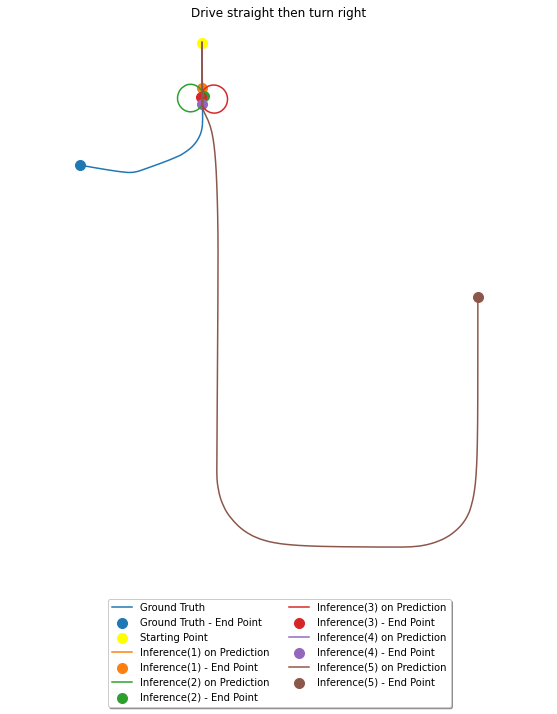

Episode 21: Park near the hut visible on the right
(36, 3) (36, 3)
1
Frechet Distance: 24.440175241740008
FDE Distance: 24.440175241740008
ADE Distance: 6.960650594967502
ADE Matched Distance: 5.642625611699877
nDTW Distance: 0.0096626033453257
TC Distance: False
(36, 3) (36, 3)
2
Frechet Distance: 14.205028481165563
FDE Distance: 14.205028481165563
ADE Distance: 3.370377089194995
ADE Matched Distance: 2.0138683116520975
nDTW Distance: 0.2986983770982537
TC Distance: False
(36, 3) (36, 3)
3
Frechet Distance: 7.935800011821752
FDE Distance: 7.935800011821752
ADE Distance: 2.237157475245626
ADE Matched Distance: 0.7225789380734019
nDTW Distance: 0.6801952200948769
TC Distance: False
(36, 3) (36, 3)
4
Frechet Distance: 18.374524376119727
FDE Distance: 18.37452437611973
ADE Distance: 5.777723099320231
ADE Matched Distance: 3.5161834927455287
nDTW Distance: 0.07738206770638416
TC Distance: False
(36, 3) (36, 3)
5
Frechet Distance: 14.208929721826795
FDE Distance: 14.208929721826795
ADE Dist

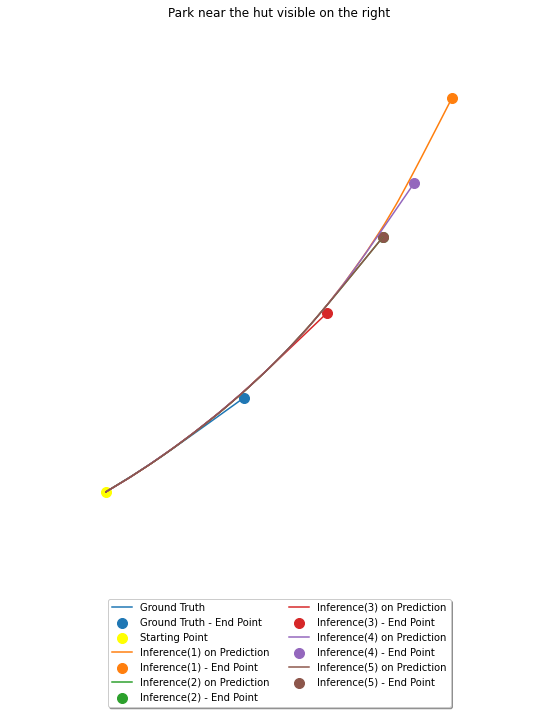

Episode 22: Go straight and stop before the traffic light.
(146, 3) (146, 3)
1
Frechet Distance: 75.67002473569039
FDE Distance: 75.67002473569039
ADE Distance: 37.750132153633984
ADE Matched Distance: 24.47278079424949
nDTW Distance: 0.007487231628031098
TC Distance: False
(139, 3) (139, 3)
2
Frechet Distance: 77.60794817144466
FDE Distance: 77.60794817144466
ADE Distance: 36.81502494431845
ADE Matched Distance: 25.913013575763078
nDTW Distance: 0.0056133773627157785
TC Distance: False
(170, 3) (170, 3)
3
Frechet Distance: 73.83491864195499
FDE Distance: 73.83491864195499
ADE Distance: 34.42578076344599
ADE Matched Distance: 18.55715449401097
nDTW Distance: 0.009559645858121637
TC Distance: False
(152, 3) (152, 3)
4
Frechet Distance: 73.87094610335353
FDE Distance: 73.87094610335352
ADE Distance: 36.07417992823499
ADE Matched Distance: 23.209796654472235
nDTW Distance: 0.009638793527947793
TC Distance: False
(148, 3) (148, 3)
5
Frechet Distance: 74.03644697160013
FDE Distance: 74.0364

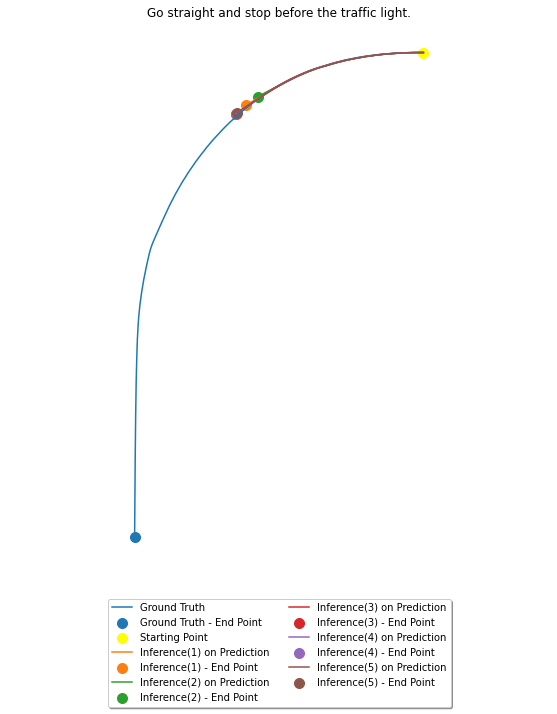

Episode 23: stop at the bus stand in front
(136, 3) (136, 3)
1
Frechet Distance: 28.56362184514969
FDE Distance: 28.56362184514969
ADE Distance: 5.32104631376902
ADE Matched Distance: 2.485486161303976
nDTW Distance: 0.44747801287434463
TC Distance: False
(136, 3) (136, 3)
2
Frechet Distance: 32.539576814859
FDE Distance: 32.539576814859
ADE Distance: 11.407340722200496
ADE Matched Distance: 2.937543448155824
nDTW Distance: 0.1879070571332606
TC Distance: False
(136, 3) (136, 3)
3
Frechet Distance: 30.4400568657933
FDE Distance: 30.4400568657933
ADE Distance: 6.277953999132916
ADE Matched Distance: 3.7206764092324773
nDTW Distance: 0.41667311029703935
TC Distance: False
(136, 3) (136, 3)
4
Frechet Distance: 30.055440366709764
FDE Distance: 30.055440366709764
ADE Distance: 15.012532658678959
ADE Matched Distance: 3.9658078956540606
nDTW Distance: 0.0525917734601142
TC Distance: False
(136, 3) (136, 3)
5
Frechet Distance: 28.680595560393225
FDE Distance: 28.680595560393222
ADE Distance: 

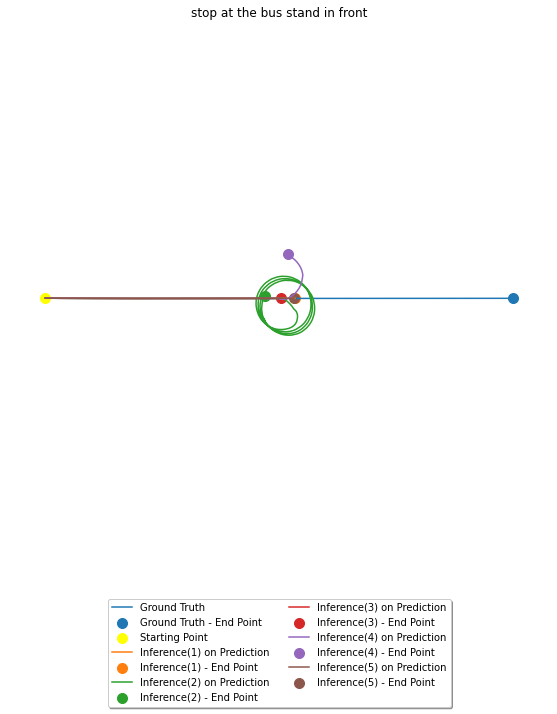

Episode 24: Turn right from the intersection.
(66, 3) (66, 3)
1
Frechet Distance: 6.553643158059587
FDE Distance: 6.553643158059587
ADE Distance: 1.894307930838724
ADE Matched Distance: 0.49628838957690335
nDTW Distance: 0.755990716064423
TC Distance: False
(66, 3) (66, 3)
2
Frechet Distance: 6.495861615552723
FDE Distance: 6.495861615552723
ADE Distance: 2.913698340431701
ADE Matched Distance: 0.8864342788606601
nDTW Distance: 0.6958423137722961
TC Distance: False
(66, 3) (66, 3)
3
Frechet Distance: 6.900023128023264
FDE Distance: 6.900023128023263
ADE Distance: 3.999896441127448
ADE Matched Distance: 0.6102520932442209
nDTW Distance: 0.7877668638199034
TC Distance: False
(66, 3) (66, 3)
4
Frechet Distance: 6.866867093449346
FDE Distance: 6.866867093449346
ADE Distance: 3.095597057108878
ADE Matched Distance: 0.6184129606752464
nDTW Distance: 0.7837875896315982
TC Distance: False
(66, 3) (66, 3)
5
Frechet Distance: 2.102365858294813
FDE Distance: 2.102365858294813
ADE Distance: 4.6234

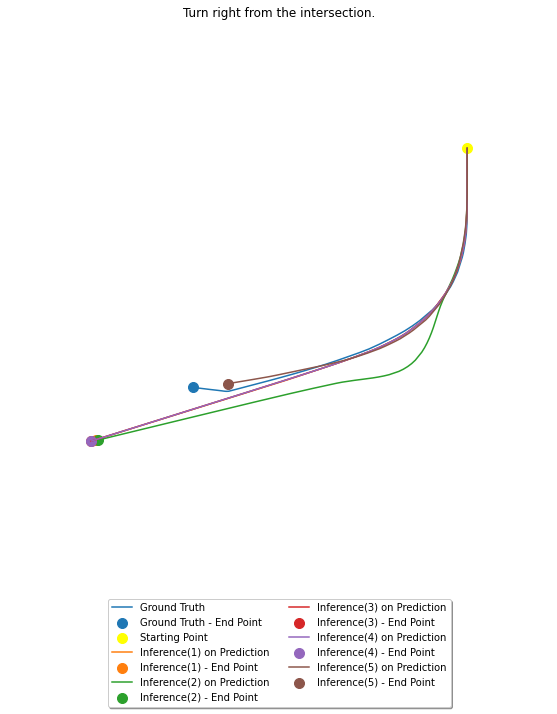

In [15]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/val/'
val_run_paths = ['/ssd_scratch/cvit/varunc/icra/val/clipMC/1/','/ssd_scratch/cvit/varunc/icra/val/clipMC/2',
                '/ssd_scratch/cvit/varunc/icra/val/clipMC/3','/ssd_scratch/cvit/varunc/icra/val/clipMC/4',
                '/ssd_scratch/cvit/varunc/icra/val/clipMC/5',]
names = ['1','2','3','4','5']
save_loc = '../trajectories_clip/'


frechet_val_all,fde_val_all,ade_val_all, ade_matched_val_all, ndtw_val_all, tc_val_clip_all = get_scores_comp(val_data_path, val_run_paths,names, save_loc,episodes=list(range(0,25)))

1    24.440175
2    18.150078
3    20.379615
4    19.123030
5    14.208930
dtype: float64
1    44.316383
2    37.796849
3    45.315378
4    32.715394
5    31.504324
dtype: float64


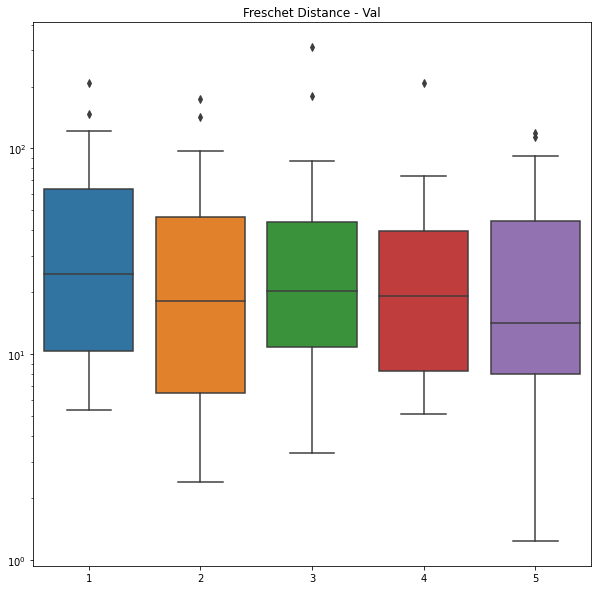

In [34]:
plt.figure(figsize=(10,10))
names = ['1','2','3','4','5']
f_df = deinterlace(frechet_val_all,names)

# g = sns.boxplot(data=f_df[['CLIP-con','CLIP-nocon','CLIP-single-nocon','RNR-con','RNR']])
g = sns.boxplot(data=f_df)

g.set_yscale("log")

plt.title('Freschet Distance - Val')
print(f_df.median())
print(f_df.mean())

1    0.281347
2    0.298698
3    0.393843
4    0.289708
5    0.350730
dtype: float64
1    0.319093
2    0.365213
3    0.363712
4    0.340657
5    0.367677
dtype: float64


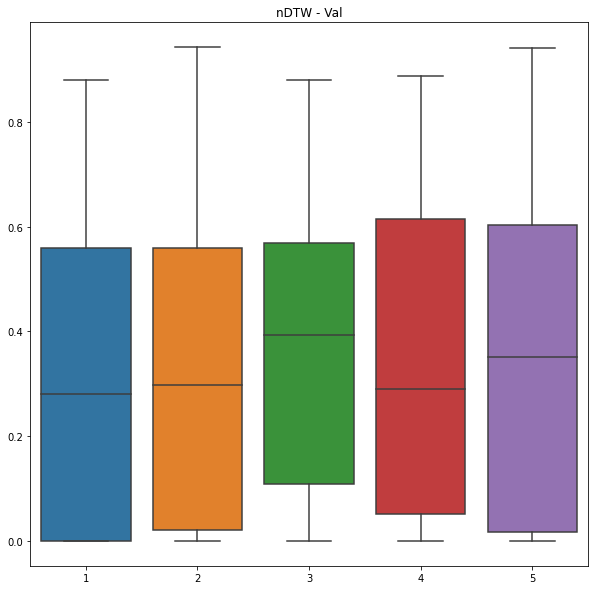

In [35]:
plt.figure(figsize=(10,10))
names = ['1','2','3','4','5']
n_df = deinterlace(ndtw_val_all,names)

# g = sns.boxplot(data=f_df[['CLIP-con','CLIP-nocon','CLIP-single-nocon','RNR-con','RNR']])
g = sns.boxplot(data=n_df)

# g.set_yscale("log")

plt.title('nDTW - Val')
print(n_df.median())
print(n_df.mean())

In [36]:
print(f_df.median(),n_df.median())

1    24.440175
2    18.150078
3    20.379615
4    19.123030
5    14.208930
dtype: float64 1    0.281347
2    0.298698
3    0.393843
4    0.289708
5    0.350730
dtype: float64


In [37]:
print(f_df.mean().std(),n_df.mean().std())

6.384163629444481 0.021014389031894103


Episode 0: Stop before the next right turn.
(58, 3) (58, 3)
1
Frechet Distance: 7.367407969420504
FDE Distance: 7.367407969420504
ADE Distance: 2.6518957795977216
ADE Matched Distance: 0.5670214036236102
nDTW Distance: 0.7755506323763202
TC Distance: False
(58, 3) (58, 3)
2
Frechet Distance: 4.079278808849314
FDE Distance: 4.079278808849314
ADE Distance: 3.1308217465655286
ADE Matched Distance: 0.2507751535708118
nDTW Distance: 0.9179526685747638
TC Distance: True
(58, 3) (58, 3)
3
Frechet Distance: 34.384055116720035
FDE Distance: 34.384055116720035
ADE Distance: 14.970209195324927
ADE Matched Distance: 7.764065590175756
nDTW Distance: 0.0033373696480442825
TC Distance: False
(58, 3) (58, 3)
4
Frechet Distance: 1.8510846182034235
FDE Distance: 1.8510846182034235
ADE Distance: 2.9070815339533893
ADE Matched Distance: 0.16497070187209087
nDTW Distance: 0.9420181176963004
TC Distance: True
(58, 3) (58, 3)
5
Frechet Distance: 1.9651803411386102
FDE Distance: 1.9651803411386104
ADE Distanc

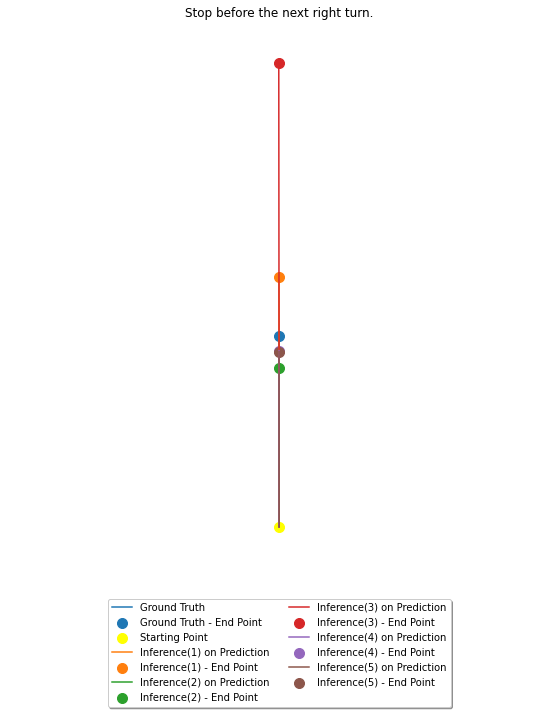

Episode 1: After crossing the blue car come to a stop
(45, 3) (45, 3)
1
Frechet Distance: 5.018804450639381
FDE Distance: 5.018804450639381
ADE Distance: 1.6494622354936483
ADE Matched Distance: 0.3287372607794599
nDTW Distance: 0.8552744814049456
TC Distance: False
(45, 3) (45, 3)
2
Frechet Distance: 4.980193293758945
FDE Distance: 4.980193293758945
ADE Distance: 2.2331937457238125
ADE Matched Distance: 0.3487738065425636
nDTW Distance: 0.852432801538467
TC Distance: True
(45, 3) (45, 3)
3
Frechet Distance: 4.9233768827664255
FDE Distance: 4.9233768827664255
ADE Distance: 2.009356116308589
ADE Matched Distance: 0.4105350786479463
nDTW Distance: 0.8136867301102244
TC Distance: True
(45, 3) (45, 3)
4
Frechet Distance: 7.6033014253695255
FDE Distance: 7.6033014253695255
ADE Distance: 2.020765033085946
ADE Matched Distance: 0.6176595480211413
nDTW Distance: 0.7312883010300646
TC Distance: False
(45, 3) (45, 3)
5
Frechet Distance: 11.598453078626
FDE Distance: 11.598453078626001
ADE Distan

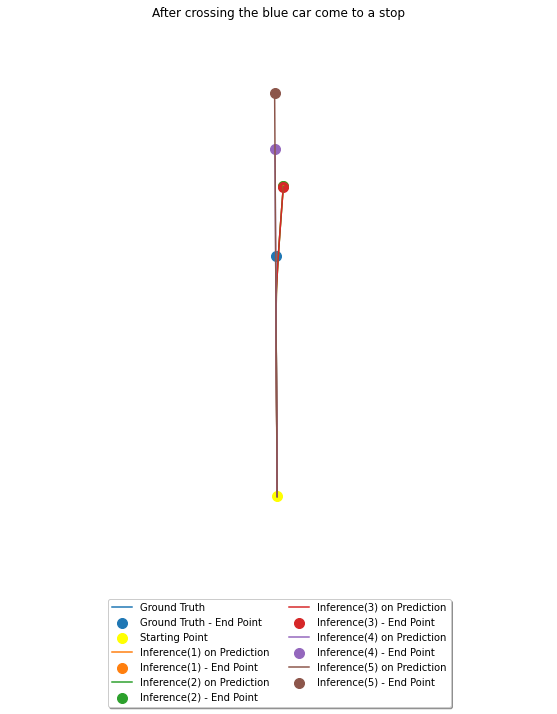

Episode 2: stop beside the black suv
(109, 3) (109, 3)
1
Frechet Distance: 0.941804222123681
FDE Distance: 0.941804222123681
ADE Distance: 1.0542412845007656
ADE Matched Distance: 0.10245185259758095
nDTW Distance: 0.9683657291814074
TC Distance: True
(109, 3) (109, 3)
2
Frechet Distance: 0.9739382726508774
FDE Distance: 0.9739382726508774
ADE Distance: 3.509204632252239
ADE Matched Distance: 0.09939550165886443
nDTW Distance: 0.9610217854906457
TC Distance: True
(109, 3) (109, 3)
3
Frechet Distance: 3.855561217089926
FDE Distance: 3.855561217089926
ADE Distance: 10.446862607894142
ADE Matched Distance: 0.12922237881280618
nDTW Distance: 0.8800295899610484
TC Distance: True
(109, 3) (109, 3)
4
Frechet Distance: 9.248420742791714
FDE Distance: 9.248420742791714
ADE Distance: 9.801125207511857
ADE Matched Distance: 0.3848778748533262
nDTW Distance: 0.6738386112337359
TC Distance: False
(109, 3) (109, 3)
5
Frechet Distance: 3.800191585770536
FDE Distance: 3.800191585770536
ADE Distance: 9

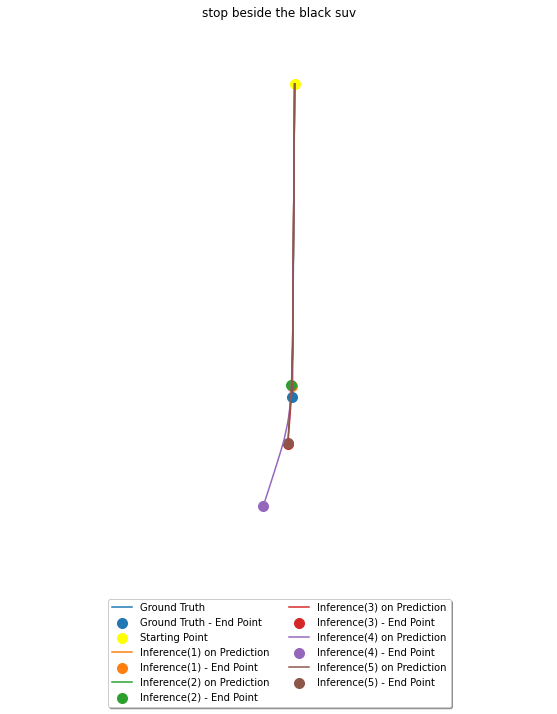

Episode 3: Stop near the signboard
(38, 3) (38, 3)
1
Frechet Distance: 11.672795495548366
FDE Distance: 11.672795495548366
ADE Distance: 3.5683389227109337
ADE Matched Distance: 1.3666216635895485
nDTW Distance: 0.4565718171078321
TC Distance: False
(38, 3) (38, 3)
2
Frechet Distance: 17.799334553418532
FDE Distance: 17.799334553418532
ADE Distance: 6.246848254026283
ADE Matched Distance: 3.0876276832496763
nDTW Distance: 0.11897545897483512
TC Distance: False
(38, 3) (38, 3)
3
Frechet Distance: 15.802460761762612
FDE Distance: 15.802460761762612
ADE Distance: 4.874510438088218
ADE Matched Distance: 2.6255685729813925
nDTW Distance: 0.17053681338696108
TC Distance: False
(38, 3) (38, 3)
4
Frechet Distance: 12.045149332673885
FDE Distance: 12.045149332673885
ADE Distance: 2.236656317100694
ADE Matched Distance: 1.4294056614317547
nDTW Distance: 0.4371186344163908
TC Distance: False
(38, 3) (38, 3)
5
Frechet Distance: 11.879915700951122
FDE Distance: 11.879915700951122
ADE Distance: 2.41

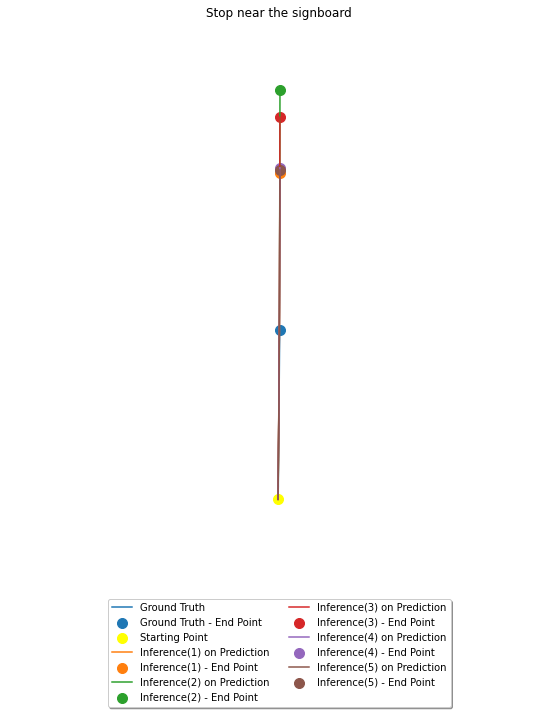

Episode 4: Take a left at the traffic light
(82, 3) (82, 3)
1
Frechet Distance: 50.696061144297495
FDE Distance: 50.696061144297495
ADE Distance: 14.748864091489414
ADE Matched Distance: 11.381022002897593
nDTW Distance: 0.038861351406010144
TC Distance: False
(82, 3) (82, 3)
2
Frechet Distance: 62.52877846208602
FDE Distance: 54.819419075457155
ADE Distance: 38.34591238476798
ADE Matched Distance: 30.672017707158975
nDTW Distance: 1.0355578213045919e-16
TC Distance: False
(82, 3) (82, 3)
3
Frechet Distance: 55.17100171966437
FDE Distance: 55.17100171966437
ADE Distance: 16.0346866996978
ADE Matched Distance: 13.261034886931679
nDTW Distance: 0.010124002097357152
TC Distance: False
(82, 3) (82, 3)
4
Frechet Distance: 39.21516338839961
FDE Distance: 39.21516338839961
ADE Distance: 12.438350063298872
ADE Matched Distance: 10.697985180566743
nDTW Distance: 0.09067047451290541
TC Distance: False
(82, 3) (82, 3)
5
Frechet Distance: 41.364247775568344
FDE Distance: 41.364247775568344
ADE Dis

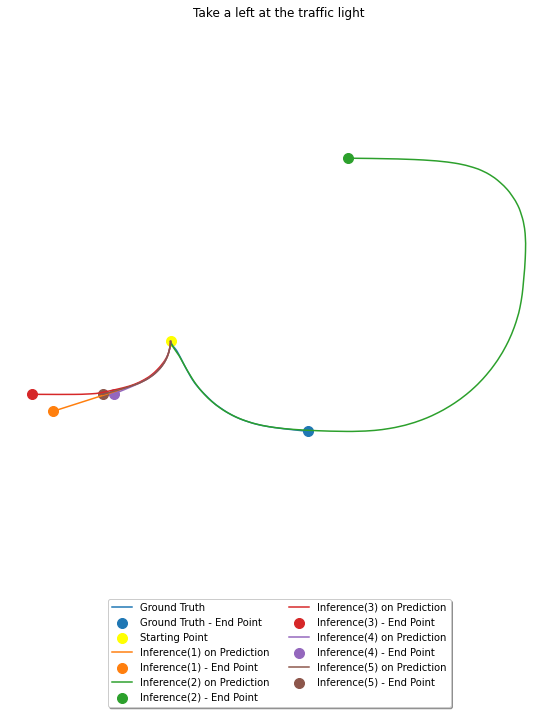

Episode 5: Turn right from the intersection
(57, 3) (57, 3)
1
Frechet Distance: 2.65469236116612
FDE Distance: 2.65469236116612
ADE Distance: 0.8596472668663576
ADE Matched Distance: 0.43099323577893167
nDTW Distance: 0.8353048097301168
TC Distance: True
(57, 3) (57, 3)
2
Frechet Distance: 5.466003152629253
FDE Distance: 5.466003152629253
ADE Distance: 2.3304103477681664
ADE Matched Distance: 0.4983223197502157
nDTW Distance: 0.7925097932582187
TC Distance: False
(57, 3) (57, 3)
3
Frechet Distance: 5.194799100407464
FDE Distance: 5.194799100407464
ADE Distance: 1.1418386702301004
ADE Matched Distance: 0.4575116428974111
nDTW Distance: 0.8090454934376792
TC Distance: False
(57, 3) (57, 3)
4
Frechet Distance: 7.424091870458207
FDE Distance: 7.424091870458207
ADE Distance: 3.1013475893368407
ADE Matched Distance: 0.6103011543713972
nDTW Distance: 0.7521592526037991
TC Distance: False
(57, 3) (57, 3)
5
Frechet Distance: 5.274121185154684
FDE Distance: 5.274121185154684
ADE Distance: 1.6145

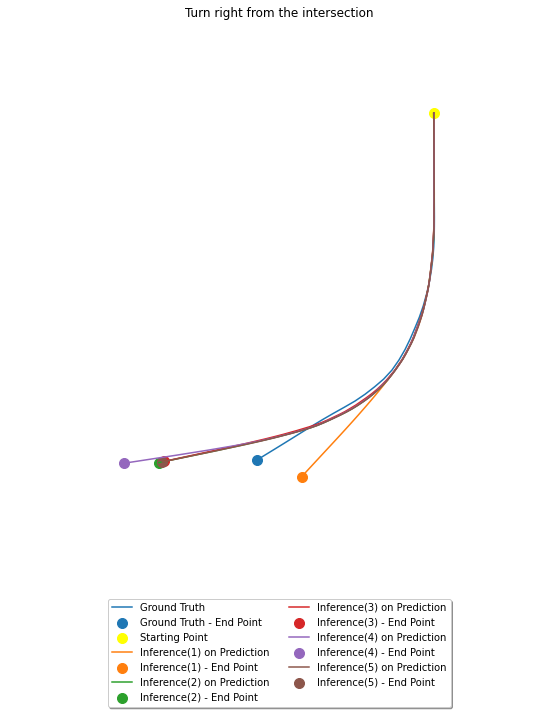

Episode 6: Take a left from the intersection ahead
(91, 3) (91, 3)
1
Frechet Distance: 46.83396541130965
FDE Distance: 46.83396541130965
ADE Distance: 29.152628479216784
ADE Matched Distance: 17.42777293842331
nDTW Distance: 1.4884450356430958e-12
TC Distance: False
(91, 3) (91, 3)
2
Frechet Distance: 4.062883077049833
FDE Distance: 4.062883077049833
ADE Distance: 5.051807122294634
ADE Matched Distance: 2.1606064322041196
nDTW Distance: 0.2683781725331902
TC Distance: True
(91, 3) (91, 3)
3
Frechet Distance: 18.598499238644475
FDE Distance: 18.598499238644475
ADE Distance: 16.768016460729363
ADE Matched Distance: 8.970694835977435
nDTW Distance: 3.583190484865295e-06
TC Distance: False
(91, 3) (91, 3)
4
Frechet Distance: 17.813458151721566
FDE Distance: 17.813458151721566
ADE Distance: 13.58912705181379
ADE Matched Distance: 3.954118064044996
nDTW Distance: 0.012969112816068287
TC Distance: False
(91, 3) (91, 3)
5
Frechet Distance: 24.506935314759815
FDE Distance: 24.506935314759815
AD

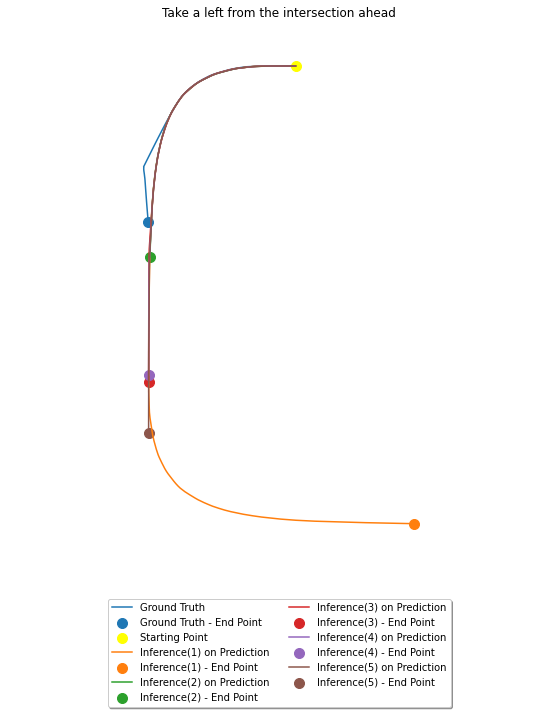

Episode 7: Drive to the corner and go right
(61, 3) (61, 3)
1
Frechet Distance: 125.91165634350816
FDE Distance: 125.91165634350816
ADE Distance: 79.50457102402666
ADE Matched Distance: 74.93148583921659
nDTW Distance: 3.4036550492319613e-102
TC Distance: False
(61, 3) (61, 3)
2
Frechet Distance: 65.97226741349428
FDE Distance: 65.97226741349428
ADE Distance: 24.43601123542197
ADE Matched Distance: 19.037893668482187
nDTW Distance: 2.550629742247939e-09
TC Distance: False
(61, 3) (61, 3)
3
Frechet Distance: 128.20876527360966
FDE Distance: 70.84898248738122
ADE Distance: 97.53635075912447
ADE Matched Distance: 96.2334715675757
nDTW Distance: 1.2028301509387365e-274
TC Distance: False
(61, 3) (61, 3)
4
Frechet Distance: 110.3432337233661
FDE Distance: 110.3432337233661
ADE Distance: 66.20151398058995
ADE Matched Distance: 62.720337437086165
nDTW Distance: 2.1163315799656583e-54
TC Distance: False
(61, 3) (61, 3)
5
Frechet Distance: 18.103860356683334
FDE Distance: 18.103860356683334
ADE

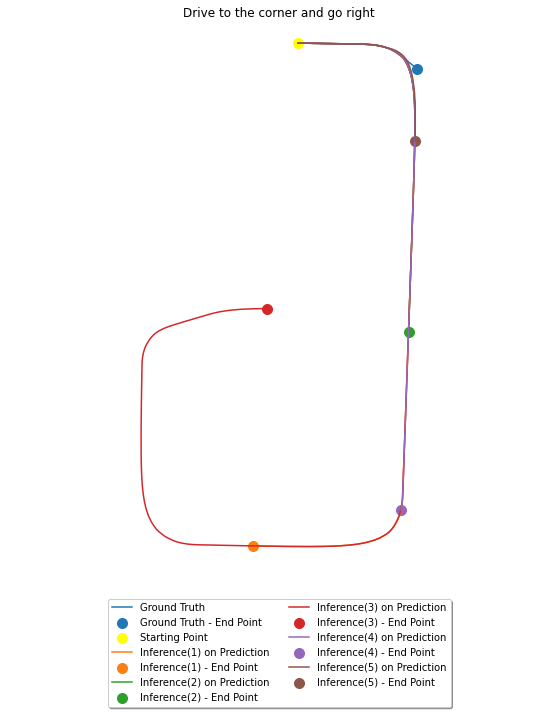

Episode 8: Drive to the intersection and turn left
(83, 3) (83, 3)
1
Frechet Distance: 89.58488699442016
FDE Distance: 84.1292413758537
ADE Distance: 56.515964736098546
ADE Matched Distance: 40.93014581905959
nDTW Distance: 1.8640718000234376e-24
TC Distance: False
(83, 3) (83, 3)
2
Frechet Distance: 89.5619264288197
FDE Distance: 73.99993607420052
ADE Distance: 58.34434393543493
ADE Matched Distance: 47.4857110725698
nDTW Distance: 2.8636528889537665e-34
TC Distance: False
(83, 3) (83, 3)
3
Frechet Distance: 89.57518743635941
FDE Distance: 17.17134235621659
ADE Distance: 51.551105145423996
ADE Matched Distance: 38.41839799223219
nDTW Distance: 9.543006527398568e-60
TC Distance: False
(83, 3) (83, 3)
4
Frechet Distance: 112.31306295346165
FDE Distance: 99.03167616625237
ADE Distance: 69.19259826292341
ADE Matched Distance: 66.45596895816217
nDTW Distance: 2.104078541101533e-36
TC Distance: False
(83, 3) (83, 3)
5
Frechet Distance: 96.84986863890417
FDE Distance: 13.94525013036926
ADE D

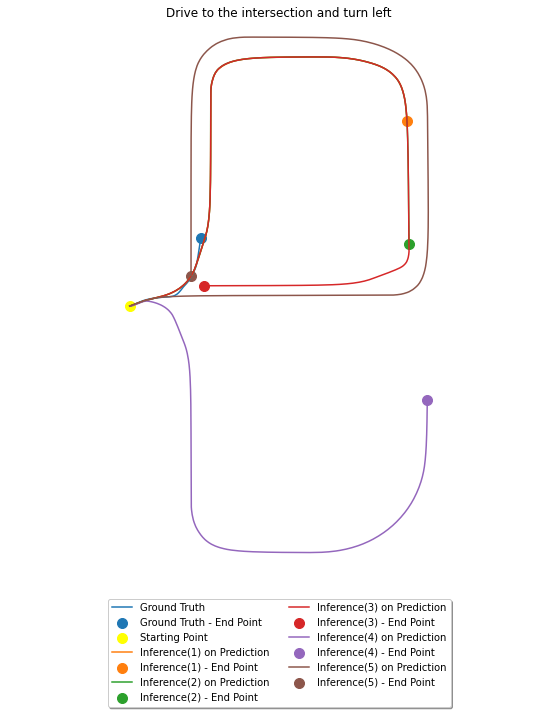

Episode 9: Go straight and stop a few metres ahead of the bus stop
(188, 3) (188, 3)
1
Frechet Distance: 30.067498565259644
FDE Distance: 30.067498565259644
ADE Distance: 12.771462686926155
ADE Matched Distance: 11.314663835077315
nDTW Distance: 0.10404489742228601
TC Distance: False
(117, 3) (117, 3)
2
Frechet Distance: 18.874604219292532
FDE Distance: 18.874604219292532
ADE Distance: 13.964567548201394
ADE Matched Distance: 2.8704800088148845
nDTW Distance: 0.5632137830104352
TC Distance: False
(137, 3) (137, 3)
3
Frechet Distance: 13.001374033978026
FDE Distance: 13.001374033978024
ADE Distance: 11.390446316704447
ADE Matched Distance: 0.8500067353054894
nDTW Distance: 0.843663680129095
TC Distance: False
(176, 3) (176, 3)
4
Frechet Distance: 32.2511067200615
FDE Distance: 32.2511067200615
ADE Distance: 13.881433751848617
ADE Matched Distance: 13.08311820795724
nDTW Distance: 0.07304908682182802
TC Distance: False
(133, 3) (133, 3)
5
Frechet Distance: 12.98676364435234
FDE Distance:

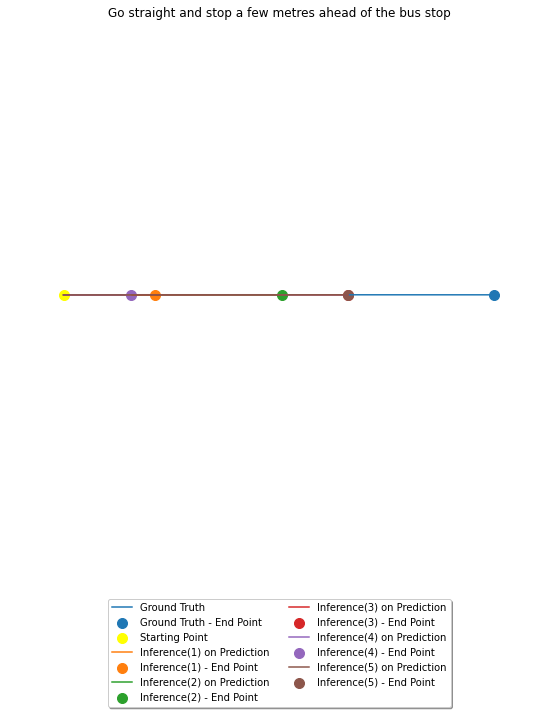

Episode 10: Stop in front of the garbage dumpsters.
(80, 3) (80, 3)
1
Frechet Distance: 14.08509898192499
FDE Distance: 14.08509898192499
ADE Distance: 9.734305910435
ADE Matched Distance: 1.4579351992848273
nDTW Distance: 0.6624125738710719
TC Distance: False
(80, 3) (80, 3)
2
Frechet Distance: 10.103119390259918
FDE Distance: 10.103119390259918
ADE Distance: 6.242575011014526
ADE Matched Distance: 0.7474789100102925
nDTW Distance: 0.785792946203238
TC Distance: False
(80, 3) (80, 3)
3
Frechet Distance: 3.9077762398816946
FDE Distance: 3.9077762398816946
ADE Distance: 3.8036019362104896
ADE Matched Distance: 0.20867411497530644
nDTW Distance: 0.921359861329505
TC Distance: True
(80, 3) (80, 3)
4
Frechet Distance: 11.781578757924075
FDE Distance: 11.781578757924077
ADE Distance: 9.920225392965467
ADE Matched Distance: 0.6865133617633101
nDTW Distance: 0.7267093222688464
TC Distance: False
(80, 3) (80, 3)
5
Frechet Distance: 41.902913197015145
FDE Distance: 41.902913197015145
ADE Distan

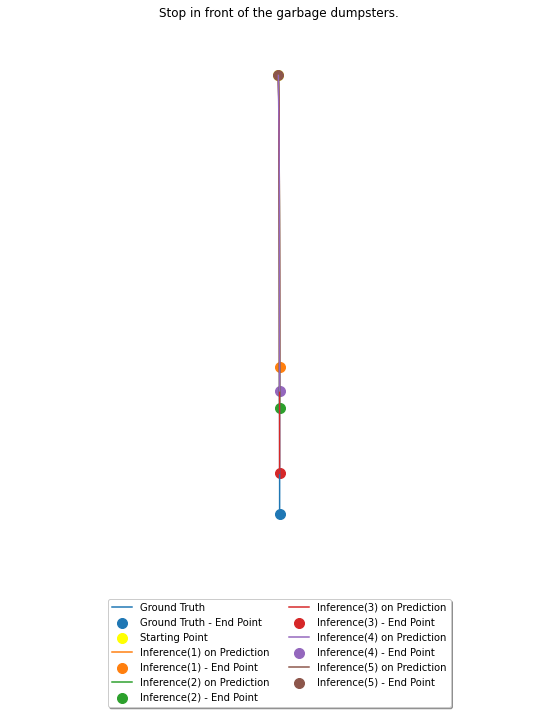

Episode 11: Go straight and stop next to the grey arch.
(107, 3) (107, 3)
1
Frechet Distance: 11.673878077502318
FDE Distance: 11.673878077502318
ADE Distance: 4.089875470334089
ADE Matched Distance: 0.8202260404356528
nDTW Distance: 0.6964081713443194
TC Distance: False
(107, 3) (107, 3)
2
Frechet Distance: 3.6033898527893067
FDE Distance: 3.6033898527893067
ADE Distance: 1.7266230657691104
ADE Matched Distance: 0.21706956701673583
nDTW Distance: 0.9175792270348248
TC Distance: True
(107, 3) (107, 3)
3
Frechet Distance: 3.609588721841171
FDE Distance: 3.609588721841171
ADE Distance: 3.0885131547755544
ADE Matched Distance: 0.2153648514769761
nDTW Distance: 0.9148786929920278
TC Distance: True
(107, 3) (107, 3)
4
Frechet Distance: 25.484715203841176
FDE Distance: 25.484715203841176
ADE Distance: 9.599934596406879
ADE Matched Distance: 2.940219073395341
nDTW Distance: 0.22801288429093944
TC Distance: False
(107, 3) (107, 3)
5
Frechet Distance: 35.995853963471944
FDE Distance: 35.9958539

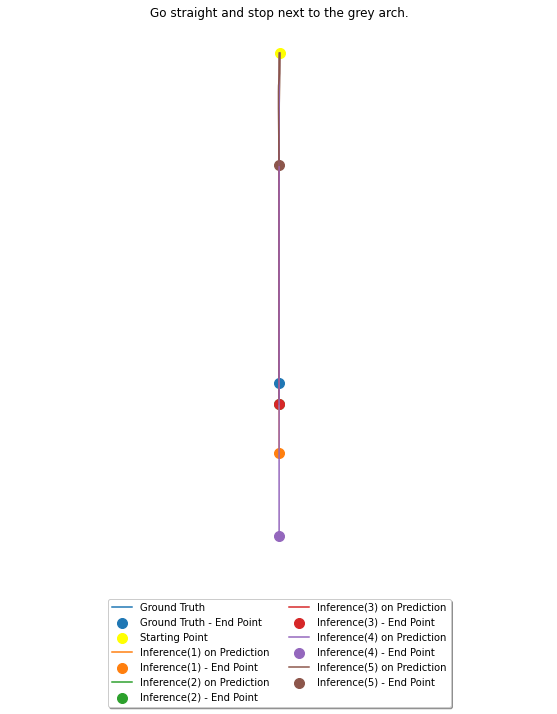

Episode 12: Change lanes and stop at the junction.
(66, 3) (66, 3)
1
Frechet Distance: 8.591177655229725
FDE Distance: 8.591177655229725
ADE Distance: 4.7042178837954065
ADE Matched Distance: 1.9389162294703433
nDTW Distance: 0.6068838745526395
TC Distance: False
(66, 3) (66, 3)
2
Frechet Distance: 6.820335557030394
FDE Distance: 6.820335557030394
ADE Distance: 3.2769056222083766
ADE Matched Distance: 2.0014313511243396
nDTW Distance: 0.46854743393689324
TC Distance: False
(66, 3) (66, 3)
3
Frechet Distance: 5.381382293335298
FDE Distance: 5.381382293335298
ADE Distance: 3.244624867645424
ADE Matched Distance: 1.8157277684960278
nDTW Distance: 0.513879309022095
TC Distance: False
(66, 3) (66, 3)
4
Frechet Distance: 3.860596544544871
FDE Distance: 3.5213859229156697
ADE Distance: 3.195534599710442
ADE Matched Distance: 1.5203286579798145
nDTW Distance: 0.6221793874573083
TC Distance: True
(66, 3) (66, 3)
5
Frechet Distance: 4.07485270022195
FDE Distance: 4.07485270022195
ADE Distance: 3

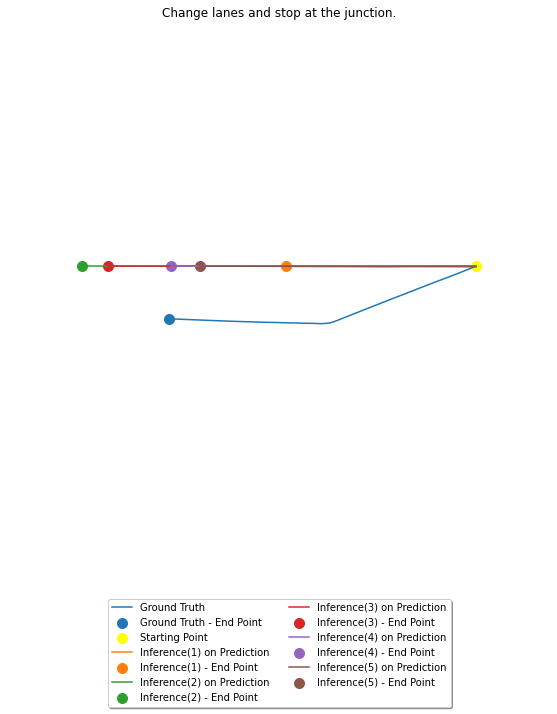

Episode 13: Park on the roadside after you have crossed the bus stop
(60, 3) (60, 3)
1
Frechet Distance: 4.005768221201098
FDE Distance: 4.005768221201098
ADE Distance: 4.875101460377618
ADE Matched Distance: 0.21005644649326236
nDTW Distance: 0.9129953786248968
TC Distance: True
(60, 3) (60, 3)
2
Frechet Distance: 4.019394311655778
FDE Distance: 4.019394311655779
ADE Distance: 3.7360765257745236
ADE Matched Distance: 0.20380290838058318
nDTW Distance: 0.9154728294947403
TC Distance: True
(60, 3) (60, 3)
3
Frechet Distance: 4.178955453754227
FDE Distance: 4.178955453754227
ADE Distance: 4.2842501671545925
ADE Matched Distance: 0.2154446327036614
nDTW Distance: 0.9121753448603708
TC Distance: True
(60, 3) (60, 3)
4
Frechet Distance: 3.951599532066431
FDE Distance: 3.951599532066431
ADE Distance: 2.7242562328638376
ADE Matched Distance: 0.25344328339235883
nDTW Distance: 0.8839609443521373
TC Distance: True
(60, 3) (60, 3)
5
Frechet Distance: 4.338899254237771
FDE Distance: 4.33889925423

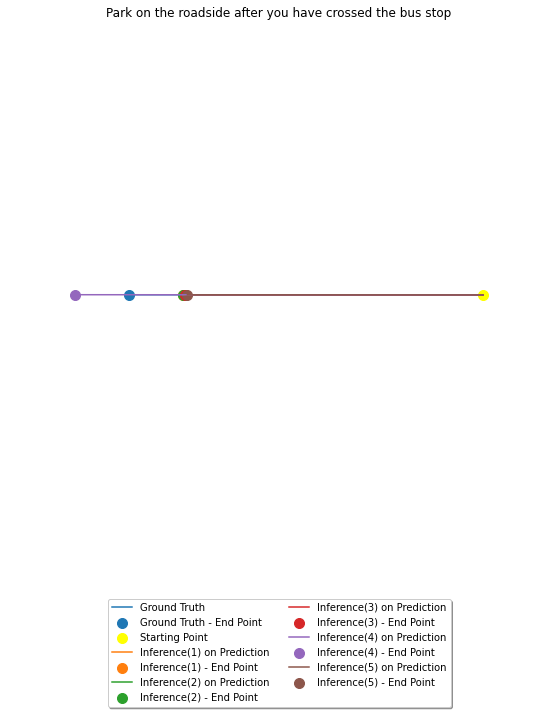

Episode 14: Wait for the signal to turn green and continue straight
(452, 3) (452, 3)
1
Frechet Distance: 27.821178751586412
FDE Distance: 27.821178751586412
ADE Distance: 2.8361587293553887
ADE Matched Distance: 1.1903524663330465
nDTW Distance: 0.7045058952440729
TC Distance: False
(452, 3) (452, 3)
2
Frechet Distance: 37.524658566019845
FDE Distance: 37.524658566019845
ADE Distance: 25.98758188861395
ADE Matched Distance: 7.425352026640875
nDTW Distance: 0.007027663588776099
TC Distance: False
(452, 3) (452, 3)
3
Frechet Distance: 19.65615865884444
FDE Distance: 19.656158658844436
ADE Distance: 2.5635379667816807
ADE Matched Distance: 0.6711584637063741
nDTW Distance: 0.8330694603610106
TC Distance: False
(452, 3) (452, 3)
4
Frechet Distance: 27.779728262050778
FDE Distance: 27.779728262050774
ADE Distance: 2.9606118812926625
ADE Matched Distance: 1.5267850840403696
nDTW Distance: 0.7033003403926203
TC Distance: False
(452, 3) (452, 3)
5
Frechet Distance: 27.779728262050778
FDE Dist

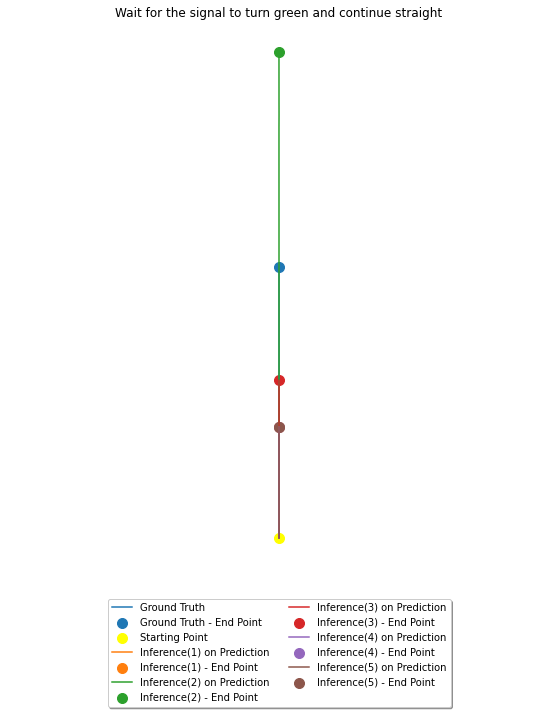

Episode 15: Drive towards the bus stop and park after crossing it
(63, 3) (63, 3)
1
Frechet Distance: 1.5374805943450571
FDE Distance: 1.5374805943450571
ADE Distance: 1.7985810983930985
ADE Matched Distance: 0.130372061298822
nDTW Distance: 0.9425325946885151
TC Distance: True
(63, 3) (63, 3)
2
Frechet Distance: 6.656229788336157
FDE Distance: 6.656229788336157
ADE Distance: 5.96766615295273
ADE Matched Distance: 0.39971503392367014
nDTW Distance: 0.8576653157373988
TC Distance: False
(63, 3) (63, 3)
3
Frechet Distance: 6.654986217458138
FDE Distance: 6.654986217458138
ADE Distance: 4.9427737737598045
ADE Matched Distance: 0.39988108000912753
nDTW Distance: 0.8576106132020666
TC Distance: False
(63, 3) (63, 3)
4
Frechet Distance: 1.5374805943450571
FDE Distance: 1.5374805943450571
ADE Distance: 1.3809510887904228
ADE Matched Distance: 0.13158399016091293
nDTW Distance: 0.9420141773406833
TC Distance: True
(63, 3) (63, 3)
5
Frechet Distance: 6.656229788336157
FDE Distance: 6.6562297883

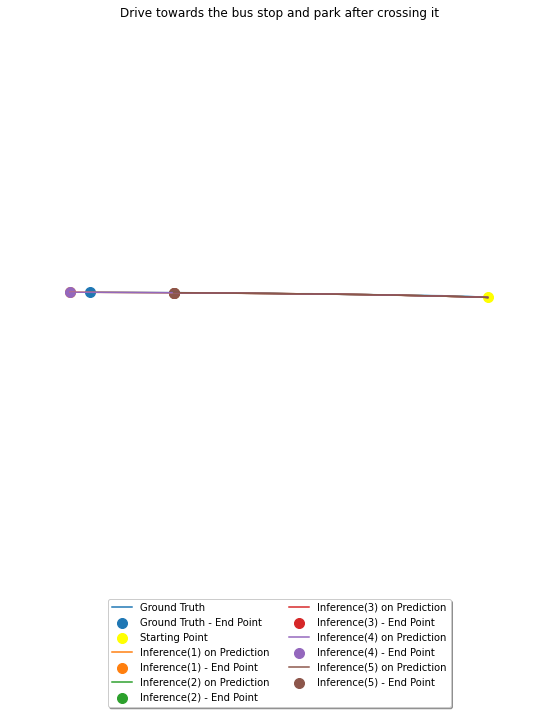

Episode 16: take a right turn and stop across the bench on left
(81, 3) (81, 3)
1
Frechet Distance: 4.086721734614607
FDE Distance: 4.086721734614607
ADE Distance: 2.8931166454115362
ADE Matched Distance: 0.2955447462219166
nDTW Distance: 0.8591721722418924
TC Distance: True
(81, 3) (81, 3)
2
Frechet Distance: 1.9999724402169354
FDE Distance: 1.9999724402169354
ADE Distance: 3.51276910432903
ADE Matched Distance: 0.19189041407852891
nDTW Distance: 0.9139104727226058
TC Distance: True
(81, 3) (81, 3)
3
Frechet Distance: 15.80462500145414
FDE Distance: 15.80462500145414
ADE Distance: 6.551099369555779
ADE Matched Distance: 1.5526148421819757
nDTW Distance: 0.5394461467257966
TC Distance: False
(81, 3) (81, 3)
4
Frechet Distance: 11.99629408799422
FDE Distance: 11.99629408799422
ADE Distance: 6.336156668207544
ADE Matched Distance: 0.8968484877376898
nDTW Distance: 0.6787332238170384
TC Distance: False
(81, 3) (81, 3)
5
Frechet Distance: 15.175492476060322
FDE Distance: 15.175492476060322

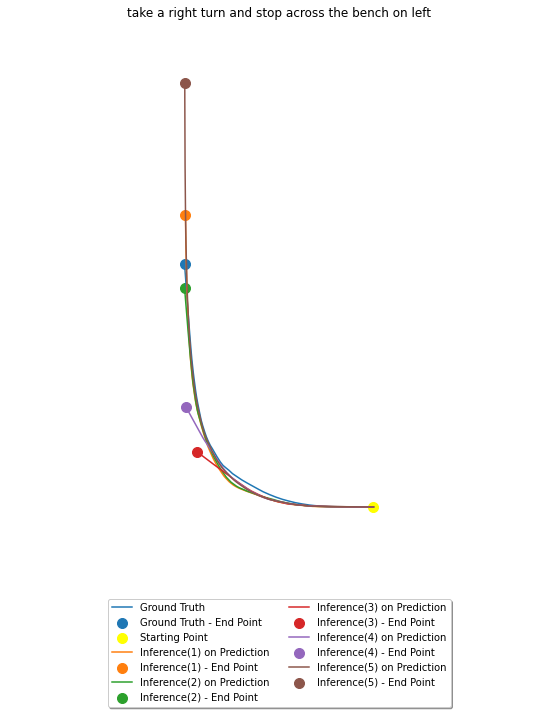

Episode 17: Turn right from the crossroads ahead
(61, 3) (61, 3)
1
Frechet Distance: 6.6600342438630475
FDE Distance: 6.660034243863048
ADE Distance: 4.331315638999681
ADE Matched Distance: 0.5962658284655235
nDTW Distance: 0.7786168902309145
TC Distance: False
(61, 3) (61, 3)
2
Frechet Distance: 3.9459115197674604
FDE Distance: 3.9459115197674604
ADE Distance: 2.2375596869142838
ADE Matched Distance: 0.4908328991274617
nDTW Distance: 0.8138421189837214
TC Distance: True
(61, 3) (61, 3)
3
Frechet Distance: 6.682472887801335
FDE Distance: 6.682472887801335
ADE Distance: 2.4843756408912214
ADE Matched Distance: 0.5601749871664806
nDTW Distance: 0.7963286722912911
TC Distance: False
(61, 3) (61, 3)
4
Frechet Distance: 97.32141744400948
FDE Distance: 73.86577599043575
ADE Distance: 78.41382821787624
ADE Matched Distance: 68.79984215329169
nDTW Distance: 1.842860178450113e-196
TC Distance: False
(61, 3) (61, 3)
5
Frechet Distance: 97.3176175639095
FDE Distance: 72.85158081131615
ADE Distanc

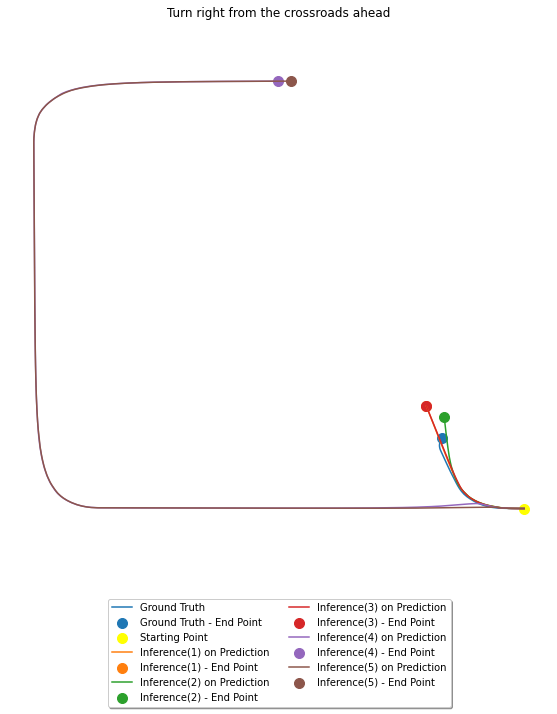

Episode 18: Turn right and park near the sidewalk.
(116, 3) (116, 3)
1
Frechet Distance: 28.28040673957754
FDE Distance: 28.28040673957754
ADE Distance: 6.122453370099754
ADE Matched Distance: 5.645599527201262
nDTW Distance: 0.3233176813759161
TC Distance: False
(156, 3) (156, 3)
2
Frechet Distance: 85.5945944071197
FDE Distance: 85.5945944071197
ADE Distance: 76.6983835218591
ADE Matched Distance: 65.21510156819785
nDTW Distance: 2.3881109103931414e-73
TC Distance: False
(156, 3) (156, 3)
3
Frechet Distance: 90.05739198305321
FDE Distance: 29.93783997400971
ADE Distance: 61.11993204730159
ADE Matched Distance: 52.81596260628334
nDTW Distance: 6.767255456643155e-46
TC Distance: False
(102, 3) (102, 3)
4
Frechet Distance: 24.11612382949215
FDE Distance: 24.11612382949215
ADE Distance: 5.754047048062422
ADE Matched Distance: 4.467688344418679
nDTW Distance: 0.40920555534547415
TC Distance: False
(156, 3) (156, 3)
5
Frechet Distance: 90.05447650032247
FDE Distance: 60.94648496179827
ADE 

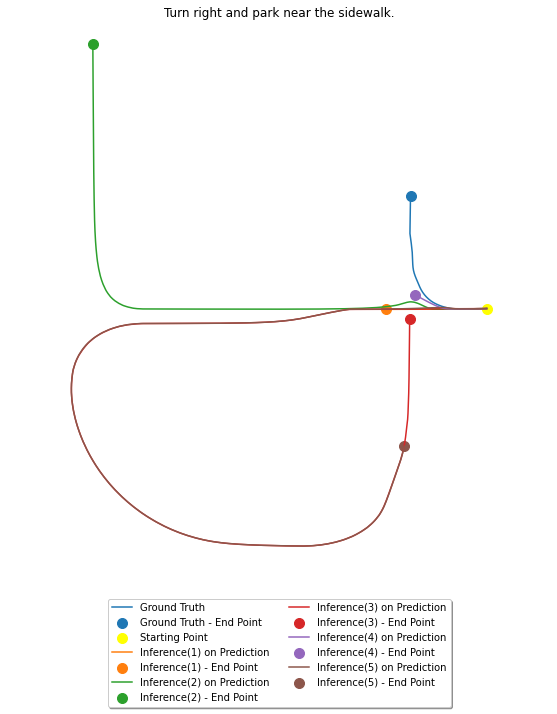

Episode 19: go straight and take a right
(97, 3) (97, 3)
1
Frechet Distance: 24.22500305107384
FDE Distance: 24.22500305107384
ADE Distance: 12.565869244572514
ADE Matched Distance: 6.306190234800717
nDTW Distance: 0.28330306679165795
TC Distance: False
(133, 3) (133, 3)
2
Frechet Distance: 19.268712851137266
FDE Distance: 19.268712851137266
ADE Distance: 9.735945581621408
ADE Matched Distance: 3.3075971824567127
nDTW Distance: 0.5160666080354541
TC Distance: False
(136, 3) (136, 3)
3
Frechet Distance: 22.872937836852717
FDE Distance: 22.872937836852717
ADE Distance: 14.046538016560916
ADE Matched Distance: 4.661243040991055
nDTW Distance: 0.3385601420732229
TC Distance: False
(91, 3) (91, 3)
4
Frechet Distance: 25.5748722678676
FDE Distance: 25.5748722678676
ADE Distance: 14.95372757630786
ADE Matched Distance: 7.20480672256171
nDTW Distance: 0.2367000989287518
TC Distance: False
(126, 3) (126, 3)
5
Frechet Distance: 20.020617893725873
FDE Distance: 20.020617893725873
ADE Distance: 9.

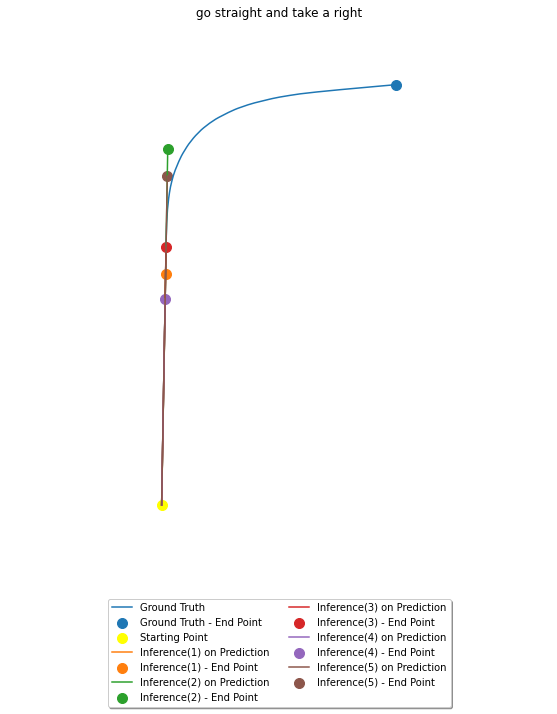

Episode 20: park beside the red volkswagen
(42, 3) (42, 3)
1
Frechet Distance: 12.516177971018523
FDE Distance: 12.516177971018523
ADE Distance: 13.775734083001014
ADE Matched Distance: 7.142253891551199
nDTW Distance: 0.00021720656633993755
TC Distance: False
(42, 3) (42, 3)
2
Frechet Distance: 74.77546311490032
FDE Distance: 36.05745363414679
ADE Distance: 40.257565357018066
ADE Matched Distance: 42.398318875720236
nDTW Distance: 4.701900833195466e-140
TC Distance: False
(42, 3) (42, 3)
3
Frechet Distance: 13.374993722416352
FDE Distance: 13.374993722416352
ADE Distance: 11.385375580321739
ADE Matched Distance: 5.795429065128531
nDTW Distance: 0.0077728257820586155
TC Distance: False
(42, 3) (42, 3)
4
Frechet Distance: 78.47497502167774
FDE Distance: 40.252620365712225
ADE Distance: 45.84526490044412
ADE Matched Distance: 45.19034776233334
nDTW Distance: 4.532720267015123e-170
TC Distance: False
(42, 3) (42, 3)
5
Frechet Distance: 10.684810736956324
FDE Distance: 10.684810736956324
A

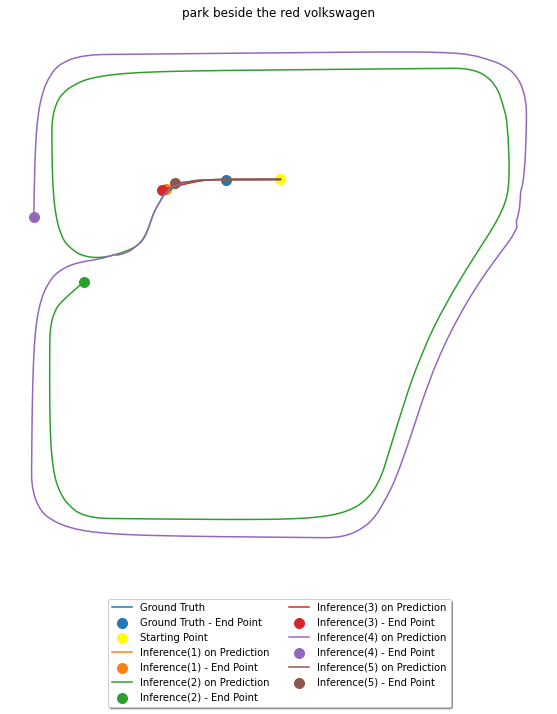

Episode 21: Turn left from the next crossroads
(147, 3) (147, 3)
1
Frechet Distance: 42.99407248121755
FDE Distance: 42.99407248121755
ADE Distance: 12.443995115248125
ADE Matched Distance: 5.9088987765036505
nDTW Distance: 0.0017170631712347846
TC Distance: False
(147, 3) (147, 3)
2
Frechet Distance: 55.122423454230706
FDE Distance: 55.122423454230706
ADE Distance: 13.193761378563241
ADE Matched Distance: 5.561201663550946
nDTW Distance: 0.00037104906980692937
TC Distance: False
(147, 3) (147, 3)
3
Frechet Distance: 34.59442798071333
FDE Distance: 34.59442798071333
ADE Distance: 11.235823071333906
ADE Matched Distance: 3.6058126169379943
nDTW Distance: 0.009888119201398593
TC Distance: False
(147, 3) (147, 3)
4
Frechet Distance: 29.75043214800033
FDE Distance: 29.75043214800033
ADE Distance: 9.430002066715346
ADE Matched Distance: 1.663711660185184
nDTW Distance: 0.29057310255989677
TC Distance: False
(147, 3) (147, 3)
5
Frechet Distance: 29.274951238546112
FDE Distance: 29.2749512385

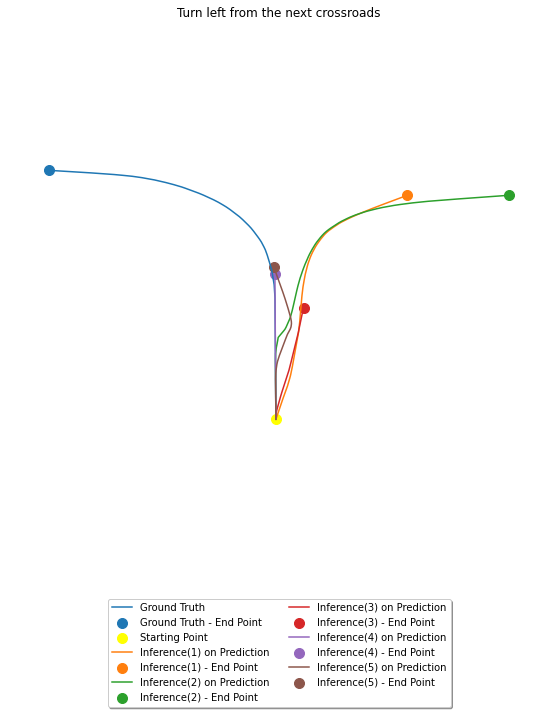

Episode 22: Turn right from the crossroads.
(66, 3) (66, 3)
1
Frechet Distance: 6.9713960988912085
FDE Distance: 6.971396098891208
ADE Distance: 2.5713784425630575
ADE Matched Distance: 0.5144782906414164
nDTW Distance: 0.7344106233865502
TC Distance: False
(66, 3) (66, 3)
2
Frechet Distance: 4.014918997190656
FDE Distance: 4.014918997190656
ADE Distance: 4.930963544179078
ADE Matched Distance: 0.4761718171720816
nDTW Distance: 0.8446570826331252
TC Distance: True
(66, 3) (66, 3)
3
Frechet Distance: 7.047186382744879
FDE Distance: 7.047186382744879
ADE Distance: 2.5876522709735466
ADE Matched Distance: 0.5425953071286871
nDTW Distance: 0.7316863366854046
TC Distance: False
(66, 3) (66, 3)
4
Frechet Distance: 5.917658522696951
FDE Distance: 5.91765852269695
ADE Distance: 6.433432637652348
ADE Matched Distance: 0.8593438385972498
nDTW Distance: 0.766733980991774
TC Distance: False
(66, 3) (66, 3)
5
Frechet Distance: 6.898474790764927
FDE Distance: 6.898474790764927
ADE Distance: 2.337074

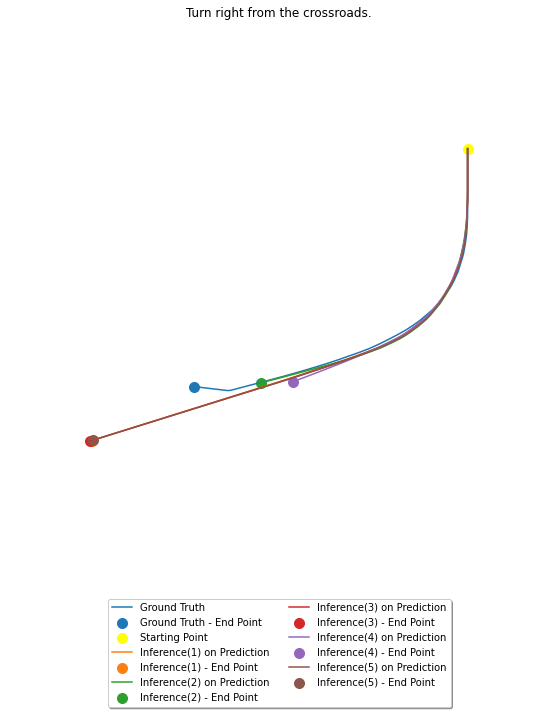

Episode 23: stop by the lamp post
(71, 3) (71, 3)
1
Frechet Distance: 7.744299026379881
FDE Distance: 7.744299026379881
ADE Distance: 4.285877438789389
ADE Matched Distance: 0.7073675311764308
nDTW Distance: 0.8291924928745799
TC Distance: False
(71, 3) (71, 3)
2
Frechet Distance: 2.1856940871738124
FDE Distance: 2.1856940871738124
ADE Distance: 1.1656262647097066
ADE Matched Distance: 0.16090821941987443
nDTW Distance: 0.9449173423379854
TC Distance: True
(71, 3) (71, 3)
3
Frechet Distance: 5.7623765034567995
FDE Distance: 5.7623765034567995
ADE Distance: 3.4589160050516736
ADE Matched Distance: 0.43445350365764496
nDTW Distance: 0.8869792918158008
TC Distance: False
(71, 3) (71, 3)
4
Frechet Distance: 3.92466703116928
FDE Distance: 3.92466703116928
ADE Distance: 3.1599298973140213
ADE Matched Distance: 0.24951644447684973
nDTW Distance: 0.9301634904899018
TC Distance: True
(71, 3) (71, 3)
5
Frechet Distance: 8.021079773892213
FDE Distance: 8.021079773892211
ADE Distance: 3.7762385823

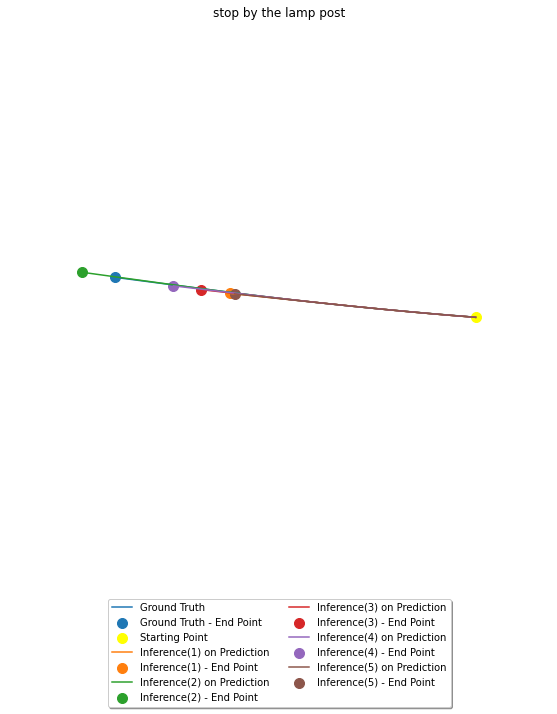

Episode 24: park immediately after the signboard
(50, 3) (50, 3)
1
Frechet Distance: 9.50080001169465
FDE Distance: 9.500800011694652
ADE Distance: 3.3739214588478443
ADE Matched Distance: 0.8635711196852549
nDTW Distance: 0.6583830185631546
TC Distance: False
(50, 3) (50, 3)
2
Frechet Distance: 9.659598159575998
FDE Distance: 9.659598159575998
ADE Distance: 2.3029448972882975
ADE Matched Distance: 0.9233893831869804
nDTW Distance: 0.637236755999244
TC Distance: False
(50, 3) (50, 3)
3
Frechet Distance: 9.506735621645356
FDE Distance: 9.506735621645356
ADE Distance: 2.5268453999964033
ADE Matched Distance: 0.8666009343521774
nDTW Distance: 0.6574182533099111
TC Distance: False
(50, 3) (50, 3)
4
Frechet Distance: 9.579089005376046
FDE Distance: 9.579089005376046
ADE Distance: 3.171538742043192
ADE Matched Distance: 0.8699233706174286
nDTW Distance: 0.6563619354091911
TC Distance: False
(50, 3) (50, 3)
5
Frechet Distance: 9.577082462911498
FDE Distance: 9.577082462911498
ADE Distance: 2.

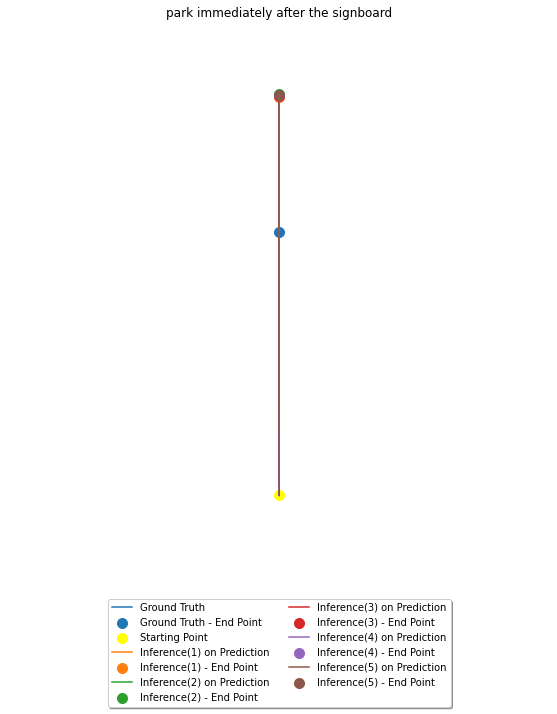

Episode 25: Turn right and stop beside the traffic signal
(176, 3) (176, 3)
1
Frechet Distance: 31.557503642693987
FDE Distance: 31.557503642693987
ADE Distance: 18.758162428352264
ADE Matched Distance: 7.0006638792240965
nDTW Distance: 0.13047720199133095
TC Distance: False
(176, 3) (176, 3)
2
Frechet Distance: 28.45720746666874
FDE Distance: 28.45720746666874
ADE Distance: 18.31178718109037
ADE Matched Distance: 5.291970881351715
nDTW Distance: 0.20319181031056155
TC Distance: False
(120, 3) (120, 3)
3
Frechet Distance: 40.85033445117401
FDE Distance: 40.85033445117401
ADE Distance: 22.962146207962075
ADE Matched Distance: 21.943949114201114
nDTW Distance: 0.012415745383987008
TC Distance: False
(176, 3) (176, 3)
4
Frechet Distance: 57.54779908128454
FDE Distance: 5.528820615501982
ADE Distance: 36.806754008327424
ADE Matched Distance: 28.367072449862686
nDTW Distance: 1.068476731557784e-28
TC Distance: False
(176, 3) (176, 3)
5
Frechet Distance: 36.02289993223516
FDE Distance: 36.02

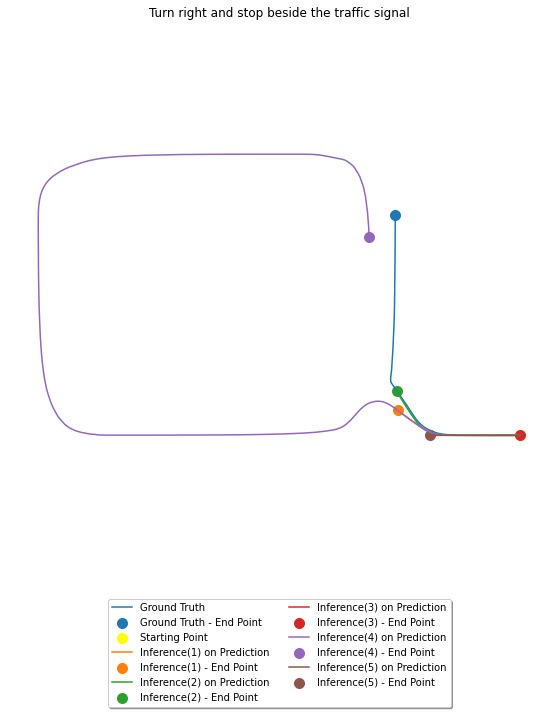

Episode 26: Turn left and stop near the traffic signal
(406, 3) (406, 3)
1
Frechet Distance: 42.617846672039434
FDE Distance: 42.617846672039434
ADE Distance: 22.194798030518896
ADE Matched Distance: 17.41430390931331
nDTW Distance: 0.00013120221812910573
TC Distance: False
(406, 3) (406, 3)
2
Frechet Distance: 101.92735452051652
FDE Distance: 101.92735452051652
ADE Distance: 33.08686072901633
ADE Matched Distance: 28.02979827127688
nDTW Distance: 2.183576159094209e-06
TC Distance: False
(98, 3) (98, 3)
3
Frechet Distance: 60.75960771232967
FDE Distance: 60.75960771232967
ADE Distance: 40.73265045834833
ADE Matched Distance: 38.254842536815325
nDTW Distance: 0.0004755832999723536
TC Distance: False
(406, 3) (406, 3)
4
Frechet Distance: 178.7392553316776
FDE Distance: 91.60739036597272
ADE Distance: 156.84502366120148
ADE Matched Distance: 126.08407986202572
nDTW Distance: 1.275129131441967e-54
TC Distance: False
(100, 3) (100, 3)
5
Frechet Distance: 60.92488267282442
FDE Distance: 60.9

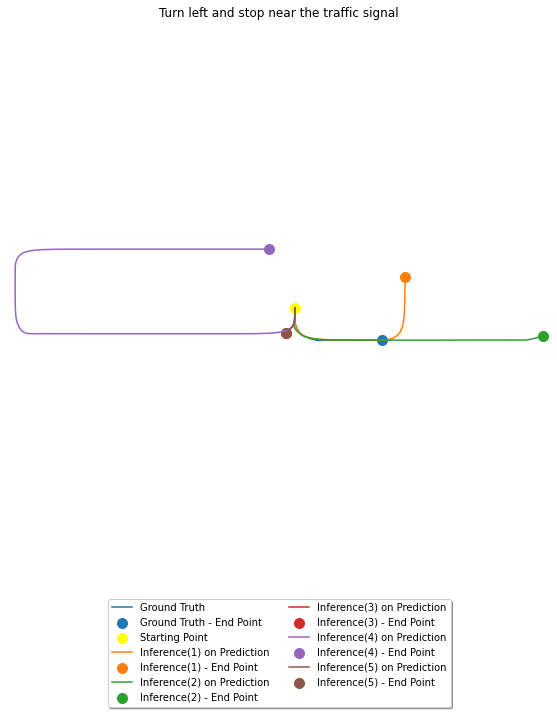

Episode 27: Turn left and stop near the intersection
(264, 3) (264, 3)
1
Frechet Distance: 49.222047736684345
FDE Distance: 49.222047736684345
ADE Distance: 42.805889469519535
ADE Matched Distance: 35.23644283884829
nDTW Distance: 0.0008697640693311842
TC Distance: False
(264, 3) (264, 3)
2
Frechet Distance: 49.222047736684345
FDE Distance: 49.222047736684345
ADE Distance: 42.31512014263563
ADE Matched Distance: 35.23705170787553
nDTW Distance: 0.0008696581612991634
TC Distance: False
(358, 3) (358, 3)
3
Frechet Distance: 50.20691951230159
FDE Distance: 50.20691951230159
ADE Distance: 39.9780381801462
ADE Matched Distance: 33.91673946596731
nDTW Distance: 0.0007051885304892613
TC Distance: False
(358, 3) (358, 3)
4
Frechet Distance: 46.79111980798386
FDE Distance: 46.79111980798386
ADE Distance: 38.331025953730915
ADE Matched Distance: 28.824784619544275
nDTW Distance: 0.0014243848056235198
TC Distance: False
(358, 3) (358, 3)
5
Frechet Distance: 53.297350931904454
FDE Distance: 53.297

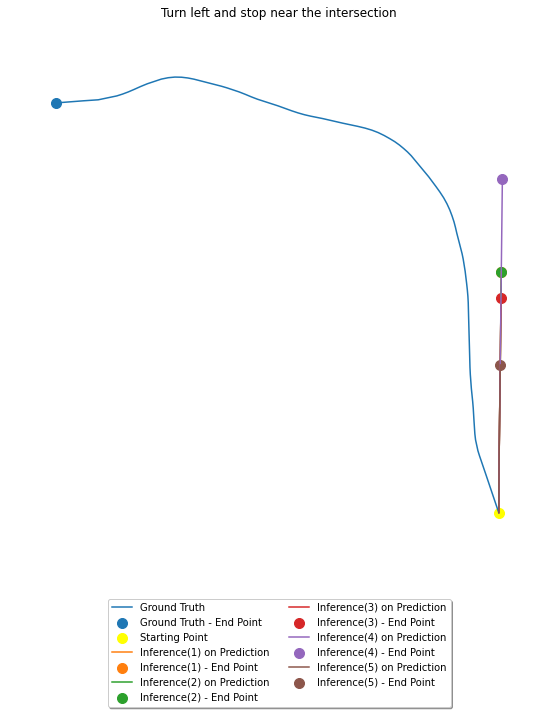

Episode 28: Turn left and come to a halt at the intersection
(625, 3) (625, 3)
1
Frechet Distance: 22.082017389923355
FDE Distance: 22.082017389923355
ADE Distance: 8.794666597002582
ADE Matched Distance: 1.489343622692572
nDTW Distance: 0.7423987920951222
TC Distance: False
(679, 3) (679, 3)
2
Frechet Distance: 35.87056060801501
FDE Distance: 35.87056060795957
ADE Distance: 38.04622722760904
ADE Matched Distance: 20.58095593503691
nDTW Distance: 5.459177908002941e-06
TC Distance: False
(679, 3) (679, 3)
3
Frechet Distance: 87.45317516179104
FDE Distance: 87.45317516179104
ADE Distance: 45.161373208777995
ADE Matched Distance: 27.597571961468834
nDTW Distance: 8.767356010032061e-08
TC Distance: False
(679, 3) (679, 3)
4
Frechet Distance: 32.83451205488923
FDE Distance: 32.83451205488923
ADE Distance: 25.361624430256306
ADE Matched Distance: 13.937780614774532
nDTW Distance: 0.004323284175793337
TC Distance: False
(679, 3) (679, 3)
5
Frechet Distance: 68.4728398934444
FDE Distance: 68.4

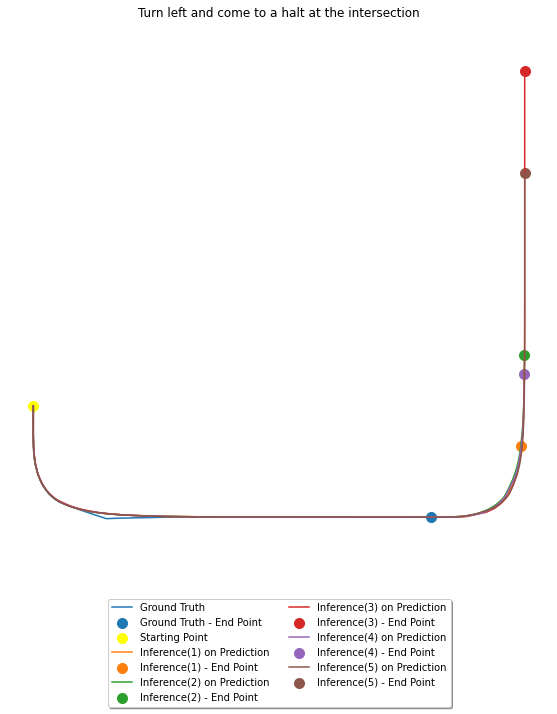

Episode 29: Turn right and stop before the traffic signal
(106, 3) (106, 3)
1
Frechet Distance: 34.04173754472386
FDE Distance: 34.04173754472386
ADE Distance: 26.22999065174527
ADE Matched Distance: 18.450074380393485
nDTW Distance: 0.024971630559571655
TC Distance: False
(194, 3) (194, 3)
2
Frechet Distance: 159.88618187026864
FDE Distance: 100.83557177736822
ADE Distance: 94.9877298598757
ADE Matched Distance: 80.39619785486323
nDTW Distance: 2.7248218608160894e-59
TC Distance: False
(103, 3) (103, 3)
3
Frechet Distance: 34.228127971400916
FDE Distance: 34.228127971400916
ADE Distance: 27.55905051951551
ADE Matched Distance: 18.602089452646343
nDTW Distance: 0.0242238428157662
TC Distance: False
(105, 3) (105, 3)
4
Frechet Distance: 34.10612302788047
FDE Distance: 34.10612302788048
ADE Distance: 27.926337851912123
ADE Matched Distance: 18.50422998733917
nDTW Distance: 0.024702619274513886
TC Distance: False
(194, 3) (194, 3)
5
Frechet Distance: 159.91201795149652
FDE Distance: 132.1

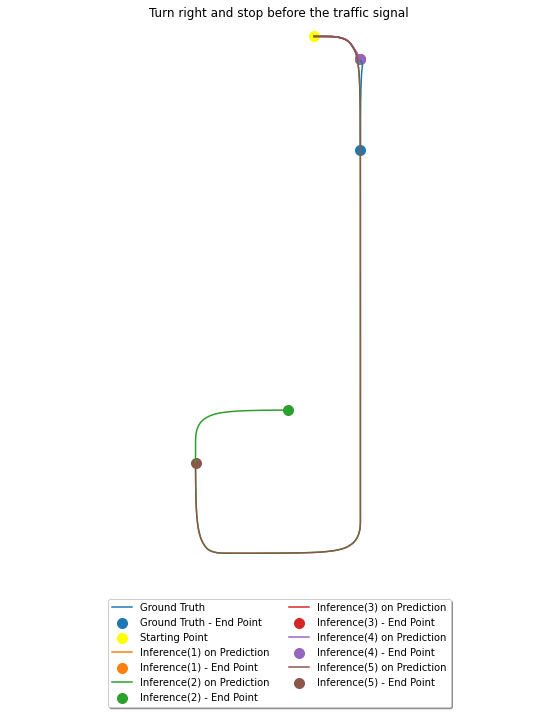

Episode 30: Turn right and stop just before the traffic signal
(153, 3) (153, 3)
1
Frechet Distance: 57.58284885432744
FDE Distance: 34.08396682939286
ADE Distance: 34.85921271122906
ADE Matched Distance: 29.398916560684754
nDTW Distance: 3.764216931268287e-30
TC Distance: False
(153, 3) (153, 3)
2
Frechet Distance: 57.582165474001656
FDE Distance: 39.45489415758481
ADE Distance: 45.824651299304655
ADE Matched Distance: 38.074066353159665
nDTW Distance: 3.248130247621197e-29
TC Distance: False
(153, 3) (153, 3)
3
Frechet Distance: 40.24421522957824
FDE Distance: 40.24421522957824
ADE Distance: 24.668565036690005
ADE Matched Distance: 8.296083519184284
nDTW Distance: 0.04214624618440981
TC Distance: False
(153, 3) (153, 3)
4
Frechet Distance: 61.761226788515366
FDE Distance: 61.761226788515366
ADE Distance: 28.12942851530644
ADE Matched Distance: 15.79532021666728
nDTW Distance: 2.1966913881877514e-06
TC Distance: False
(153, 3) (153, 3)
5
Frechet Distance: 57.58071217725406
FDE Distanc

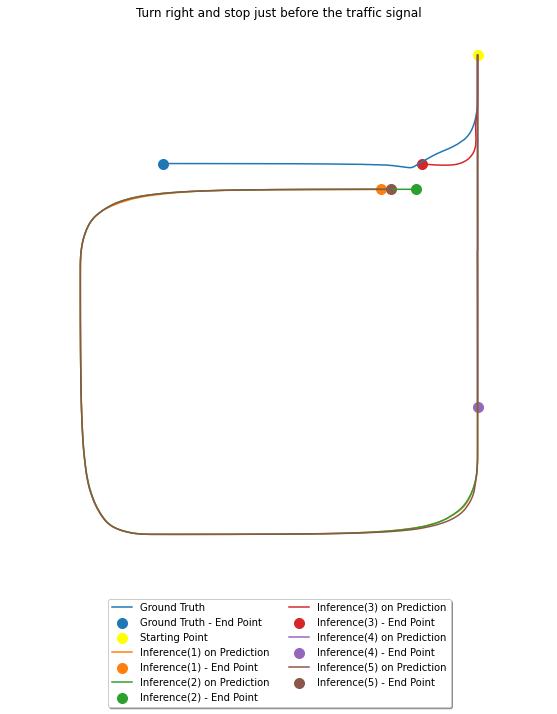

Episode 31: Turn right and stop near the bus stop
(92, 3) (92, 3)
1
Frechet Distance: 44.21930427961417
FDE Distance: 44.21930427961417
ADE Distance: 34.313105327887385
ADE Matched Distance: 22.09434602458069
nDTW Distance: 0.01204784823240185
TC Distance: False
(156, 3) (156, 3)
2
Frechet Distance: 32.50926523669436
FDE Distance: 32.50926523669437
ADE Distance: 24.444657694098094
ADE Matched Distance: 6.642325653231706
nDTW Distance: 0.26488351103331126
TC Distance: False
(125, 3) (125, 3)
3
Frechet Distance: 37.2845800814839
FDE Distance: 37.2845800814839
ADE Distance: 27.830652743726457
ADE Matched Distance: 13.434525148755258
nDTW Distance: 0.0680913543056069
TC Distance: False
(119, 3) (119, 3)
4
Frechet Distance: 38.337456059506536
FDE Distance: 38.33745605950653
ADE Distance: 27.875133975008723
ADE Matched Distance: 14.870153930566882
nDTW Distance: 0.05109693387017157
TC Distance: False
(119, 3) (119, 3)
5
Frechet Distance: 38.321082278164205
FDE Distance: 38.321082278164205
AD

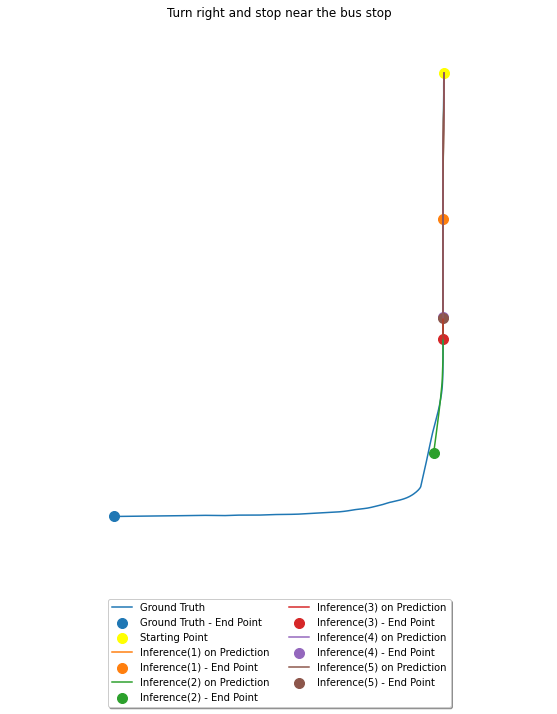

Episode 32: Turn left and stop beside the traffic signal
(188, 3) (188, 3)
1
Frechet Distance: 42.94562156843627
FDE Distance: 42.94562156843627
ADE Distance: 19.103774857898447
ADE Matched Distance: 3.3201767562420215
nDTW Distance: 0.09055209179938323
TC Distance: False
(188, 3) (188, 3)
2
Frechet Distance: 43.37029670562074
FDE Distance: 43.37029670562074
ADE Distance: 18.969924605028417
ADE Matched Distance: 3.2509794659584337
nDTW Distance: 0.09101483771478618
TC Distance: False
(188, 3) (188, 3)
3
Frechet Distance: 43.357327740309096
FDE Distance: 43.357327740309096
ADE Distance: 18.95050230174619
ADE Matched Distance: 3.9332848267861693
nDTW Distance: 0.08504459312308069
TC Distance: False
(188, 3) (188, 3)
4
Frechet Distance: 47.44804591399875
FDE Distance: 47.44804591399875
ADE Distance: 19.161530872840867
ADE Matched Distance: 3.1980586807735114
nDTW Distance: 0.08147866327401258
TC Distance: False
(188, 3) (188, 3)
5
Frechet Distance: 43.68706077803497
FDE Distance: 43.68706

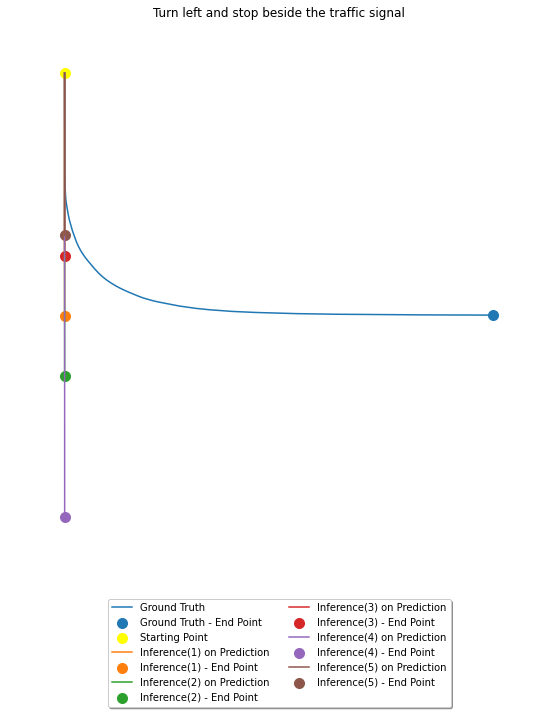

Episode 33: Turn left and stop near the traffic signal
(166, 3) (166, 3)
1
Frechet Distance: 79.74707651709517
FDE Distance: 79.74707651709517
ADE Distance: 24.495453077872625
ADE Matched Distance: 11.17087930270568
nDTW Distance: 9.286116372624158e-07
TC Distance: False
(166, 3) (166, 3)
2
Frechet Distance: 73.10423178509171
FDE Distance: 73.10423178509171
ADE Distance: 31.897851870795996
ADE Matched Distance: 7.014102650081037
nDTW Distance: 0.003534847840016565
TC Distance: False
(166, 3) (166, 3)
3
Frechet Distance: 73.75373905540516
FDE Distance: 73.75373905540516
ADE Distance: 31.982417383305375
ADE Matched Distance: 9.396603028787512
nDTW Distance: 0.0028387655504415084
TC Distance: False
(166, 3) (166, 3)
4
Frechet Distance: 73.68994119757865
FDE Distance: 73.68994119757865
ADE Distance: 31.83225611156988
ADE Matched Distance: 9.32711998124669
nDTW Distance: 0.002898688586787241
TC Distance: False
(166, 3) (166, 3)
5
Frechet Distance: 73.17342853860835
FDE Distance: 73.17342853

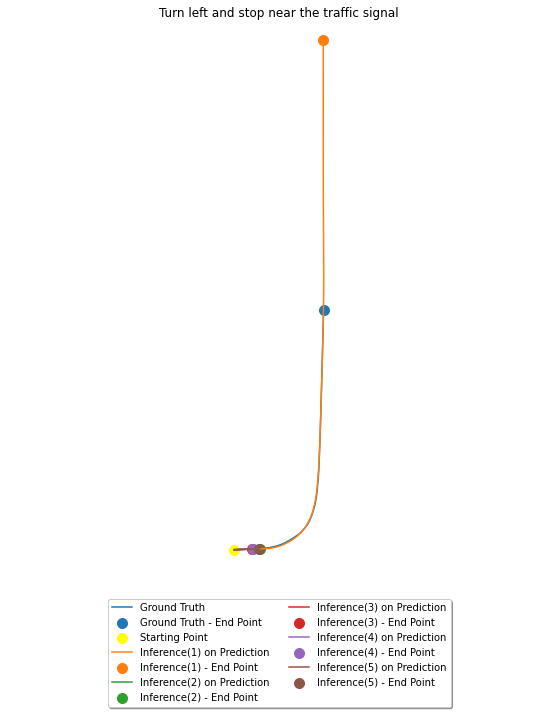

In [18]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/test'
val_run_paths = ['/ssd_scratch/cvit/varunc/icra/test/clipMC/1/','/ssd_scratch/cvit/varunc/icra/test/clipMC/2',
                '/ssd_scratch/cvit/varunc/icra/test/clipMC/3','/ssd_scratch/cvit/varunc/icra/test/clipMC/4',
                '/ssd_scratch/cvit/varunc/icra/test/clipMC/5',]
names = ['1','2','3','4','5']
save_loc = '../trajectories_test/'

frechet_test_all,fde_test_all,ade_test_all, ade_matched_test_all, ndtw_test_all, tc_test_clip_all = get_scores_comp(val_data_path, val_run_paths,names, save_loc,episodes=list(range(34)))

Median:
1    23.153510
2    19.071659
3    19.127329
4    26.677300
5    26.143332
dtype: float64
1    28.984090
2    34.750675
3    31.939562
4    37.718082
5    36.102791
dtype: float64


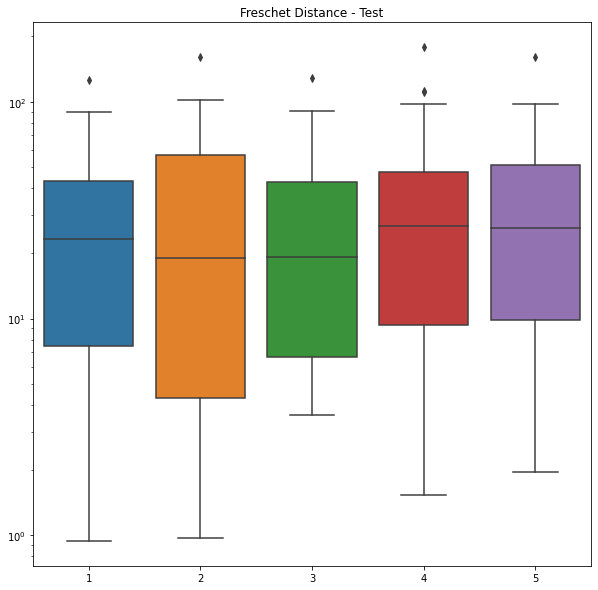

In [44]:
plt.figure(figsize=(10,10))
names = ['1','2','3','4','5']


f_df = deinterlace(frechet_test_all,names)
g = sns.boxplot(data=f_df)
g.set_yscale("log")
# g.set_ylim([-5,60])
plt.title('Freschet Distance - Test')
print('Median:')
print(f_df.median())
print(f_df.mean())

In [45]:
f_df.mean().mean()

33.89903990240926

In [47]:
f_df.std(axis=0)

1    28.293291
2    37.395509
3    31.548770
4    39.675702
5    35.522337
dtype: float64

Median:
1    0.389945
2    0.266631
3    0.127791
4    0.232356
5    0.173133
dtype: float64
1    0.412632
2    0.401796
3    0.373159
4    0.351579
5    0.348490
dtype: float64


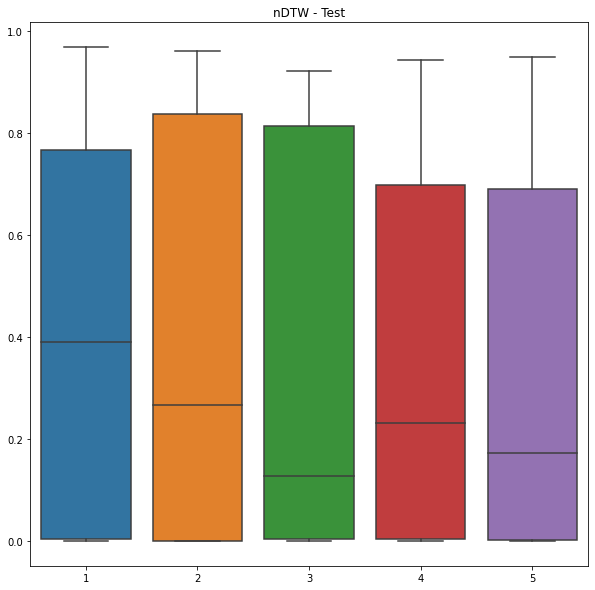

In [41]:
plt.figure(figsize=(10,10))
names = ['1','2','3','4','5']


n_df = deinterlace(ndtw_test_all,names)
g = sns.boxplot(data=n_df)
# g.set_yscale("log")
# g.set_ylim([-5,60])
plt.title('nDTW - Test')
print('Median:')
print(n_df.median())
print(n_df.mean())

In [42]:
n_df.mean().mean()

0.37753128321195983

In [32]:
print(f_df.mean().std(),n_df.mean().std())

3.469984326515927 0.028969442623763927


In [27]:
tc_val = pd.read_csv('task_completion_val.csv',header=None)

tc_val_interlaced = tc_val.values.flatten()

In [28]:
tc_test = pd.read_csv('task_completion_test.csv',header=None)

tc_test_interlaced = tc_test.values.flatten()

In [29]:
names = ['CLIP-VC','CLIP-V',
         'CLIP','CLIP-C',
         'RNR-C','RNR']
results = {
    'val':{
        'frechet': deinterlace(frechet_val_all,names,df=False),
        'fde': deinterlace(fde_val_all,names,df=False),
        'ade':deinterlace(ade_val_all,names,df=False),
        'ade_match':deinterlace(ade_matched_val_all,names,df=False),
        'tc':deinterlace(tc_val_interlaced,names,df=False),
        'nDTW':deinterlace(ndtw_val_all,names,df=False),
    },
    'test':
    {
        'frechet': deinterlace(frechet_test_all,names,df=False),
        'fde': deinterlace(fde_test_all,names,df=False),
        'ade':deinterlace(ade_test_all,names,df=False),
        'ade_match':deinterlace(ade_matched_test_all,names,df=False),
        'tc':deinterlace(tc_test_interlaced,names,df=False),
        'nDTW':deinterlace(ndtw_test_all,names,df=False),
    },
}

In [196]:
names = ['CLIP-VC','CLIP-V',
         'CLIP','CLIP-C',
         'RNR-C','RNR']
results = {
    'val':{
        'frechet': deinterlace(frechet_val_all,names,df=False,tc_scores=tc_val_interlaced),
        'fde': deinterlace(fde_val_all,names,df=False,tc_scores=tc_val_interlaced),
        'ade':deinterlace(ade_val_all,names,df=False,tc_scores=tc_val_interlaced),
        'ade_match':deinterlace(ade_matched_val_all,names,df=False,tc_scores=tc_val_interlaced),
        'tc':deinterlace(tc_val_interlaced,names,df=False,tc_scores=tc_val_interlaced),
        'nDTW':deinterlace(ndtw_val_all,names,df=False,tc_scores=tc_val_interlaced),
    },
    'test':
    {
        'frechet': deinterlace(frechet_test_all,names,df=False,tc_scores=tc_test_interlaced),
        'fde': deinterlace(fde_test_all,names,df=False,tc_scores=tc_test_interlaced),
        'ade':deinterlace(ade_test_all,names,df=False,tc_scores=tc_test_interlaced),
        'ade_match':deinterlace(ade_matched_test_all,names,df=False,tc_scores=tc_test_interlaced),
        'tc':deinterlace(tc_test_interlaced,names,df=False,tc_scores=tc_test_interlaced),
        'nDTW':deinterlace(ndtw_test_all,names,df=False,tc_scores=tc_test_interlaced),
    },
}

Median:
CLIP-VC    0.594053
CLIP-V     0.513309
CLIP       0.056152
CLIP-C     0.413312
RNR-C      0.535384
RNR        0.043633
dtype: float64
CLIP-VC    0.544586
CLIP-V     0.391472
CLIP       0.234323
CLIP-C     0.364007
RNR-C      0.456151
RNR        0.354813
dtype: float64


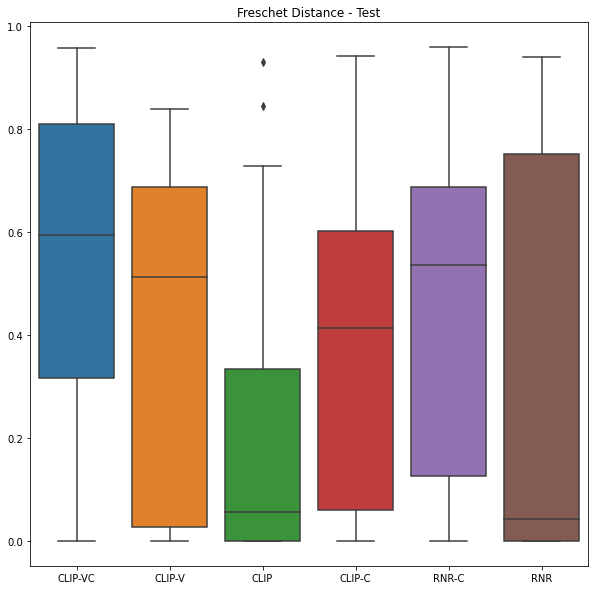

In [30]:
plt.figure(figsize=(10,10))
f_df = pd.DataFrame(results['val']['nDTW'])
g = sns.boxplot(data=f_df)
# g.set_yscale("log")
# g.set_ylim([-5,60])
plt.title('Freschet Distance - Test')
print('Median:')
print(f_df.median())
print(f_df.mean())


In [49]:
results_val_df = pd.DataFrame.from_dict({(i,j): results['val'][i][j] 
                           for i in results['val'].keys() 
                           for j in results['val'][i].keys()},
                       orient='index')
results_val_df.index = pd.MultiIndex.from_tuples(results_val_df.index)
results_val_df.index.names = ['Meteric', 'Model']

results_test_df = pd.DataFrame.from_dict({(i,j): results['test'][i][j] 
                           for i in results['test'].keys() 
                           for j in results['test'][i].keys()},
                       orient='index')
results_test_df.index = pd.MultiIndex.from_tuples(results_test_df.index)
results_test_df.index.names = ['Meteric', 'Model']

In [50]:
results_val_df.quantile(q=0.75,axis=1)-results_val_df.quantile(q=0.25,axis=1)

Meteric    Model  
frechet    CLIP-VC    14.197309
           CLIP-V     33.593829
           CLIP       27.657398
           CLIP-C     36.285574
           RNR-C      32.685383
           RNR        41.805231
fde        CLIP-VC    14.197309
           CLIP-V     33.593829
           CLIP       27.232069
           CLIP-C     30.643589
           RNR-C      32.685383
           RNR        41.805231
ade        CLIP-VC     5.271020
           CLIP-V     10.155182
           CLIP       14.221720
           CLIP-C     13.267404
           RNR-C       7.606991
           RNR        13.704834
ade_match  CLIP-VC     2.229447
           CLIP-V      8.721920
           CLIP        7.923658
           CLIP-C      6.880892
           RNR-C       2.950179
           RNR        12.413291
tc         CLIP-VC     0.000000
           CLIP-V      1.000000
           CLIP        1.000000
           CLIP-C      1.000000
           RNR-C       1.000000
           RNR         1.000000
nDTW       CLIP-VC   

In [205]:
val_summary = pd.DataFrame({
    'mean':results_val_df.mean(axis=1),
    'median':results_val_df.median(axis=1),
    'std':results_val_df.std(axis=1),
    'IQR':results_val_df.quantile(q=0.75,axis=1)-results_val_df.quantile(q=0.25,axis=1),
}).T
test_summary = pd.DataFrame({
    'mean':results_test_df.mean(axis=1),
    'median':results_test_df.median(axis=1),
    'std':results_test_df.std(axis=1),
    'IQR':results_test_df.quantile(q=0.75,axis=1)-results_val_df.quantile(q=0.25,axis=1),
}).T


In [212]:
val_summary.to_csv('val_results.csv')
test_summary.to_csv('test_results.csv')


In [211]:
test_summary['tc']

Model    CLIP-VC    CLIP-V      CLIP    CLIP-C     RNR-C       RNR
mean    0.735294  0.529412  0.470588  0.500000  0.323529  0.294118
median  1.000000  1.000000  0.000000  0.500000  0.000000  0.000000
std     0.447811  0.506640  0.506640  0.507519  0.474858  0.462497
IQR     0.000000  1.000000  1.000000  1.000000  1.000000  1.000000

CLIP-context         0.276173
CLIP no context      0.062172
CLIP-single-nocon    0.515694
CLIP-single-con      0.040471
RNR-Context          0.150810
RNR                  0.517124
dtype: float64
CLIP-context         0.363549
CLIP no context      0.204092
CLIP-single-nocon    0.431974
CLIP-single-con      0.334550
RNR-Context          0.372392
RNR                  0.456953
dtype: float64


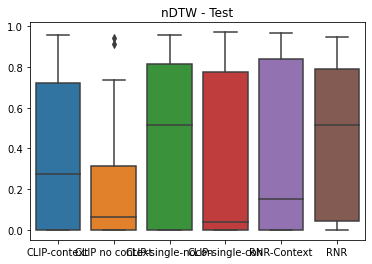

In [128]:
names = ['CLIP-context','CLIP no context',
         'CLIP-single-nocon','CLIP-single-con',
         'RNR-Context','RNR']
n_df = deinterlace(ndtw_test_all,names)
g = sns.boxplot(data=n_df)
# g.set_yscale("log")
# g.set_ylim([-5,60])
plt.title('nDTW - Test')
print(n_df.median())
print(n_df.mean())

CLIP-context         0.654810
CLIP no context      0.138249
CLIP-single-nocon    0.093973
RNR-Context          0.224645
RNR                  0.000362
dtype: float64
CLIP-context         0.562131
CLIP no context      0.318528
CLIP-single-nocon    0.242909
RNR-Context          0.333578
RNR                  0.162495
dtype: float64


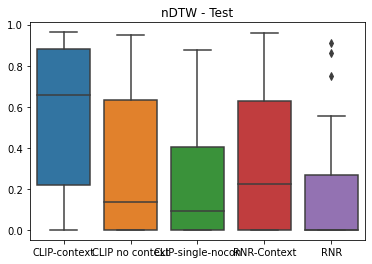

In [36]:
names = ['CLIP-context','CLIP no context',
         'CLIP-single-nocon',
         'RNR-Context','RNR']
n_df = deinterlace(ndtw_test_all,names)
g = sns.boxplot(data=n_df)
# g.set_yscale("log")
# g.set_ylim([-5,60])
plt.title('nDTW - Test')
print(n_df.median())
print(n_df.mean())

In [104]:
print(f_df.median(),n_df.median())

CLIP-con              8.523169
CLIP-nocon           13.971223
CLIP-single-nocon    29.240288
Conv3D               37.757654
RNR-con              12.294415
RNR                  14.640022
dtype: float64 CLIP-con             0.654810
CLIP-nocon           0.138249
CLIP-single-nocon    0.093973
Conv3D               0.000216
RNR-con              0.224645
RNR                  0.000362
dtype: float64


In [105]:
np.log(n_df).median()

CLIP-con            -0.424346
CLIP-nocon          -1.978710
CLIP-single-nocon   -2.367700
Conv3D              -8.534804
RNR-con             -1.521231
RNR                 -7.996281
dtype: float64

subplotting
(45, 3) (45, 3)
Episode 11: Stop after crossing the stop signboard
Frechet Distance: 4.292999998566482
FDE Distance: 4.292999998566482
ADE Distance: 1.41057447310484
ADE Matched Distance: 0.32901731512846294
nDTW Distance: 0.8564119977013522
TC Distance: True
subplotting
(73, 3) (73, 3)
Episode 14: Drive straight till the intersection and then turn left
Frechet Distance: 10.80607305872367
FDE Distance: 10.80607305872367
ADE Distance: 8.74487304027145
ADE Matched Distance: 0.3058122732603196
nDTW Distance: 0.6297145243847043
TC Distance: False
[<matplotlib.lines.Line2D object at 0x7f93d24d2a50>, <matplotlib.lines.Line2D object at 0x7f93d24d2650>, <matplotlib.collections.PathCollection object at 0x7f93d24d2590>, <matplotlib.collections.PathCollection object at 0x7f93b57ae0d0>, <matplotlib.collections.PathCollection object at 0x7f93d24d2f50>] ['Ground Truth', 'Inference on Prediction', 'Ground Truth - End Point', 'Inference - End Point', 'Starting Point']


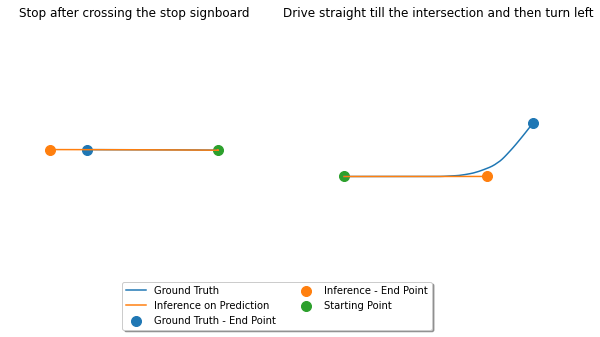

([4.292999998566482, 10.80607305872367],
 [4.292999998566482, 10.80607305872367],
 [1.41057447310484, 8.74487304027145],
 [0.32901731512846294, 0.3058122732603196],
 [0.8564119977013522, 0.6297145243847043],
 [True, False])

In [220]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/val/'
val_run_path = '/ssd_scratch/cvit/varunc/new_vals/val_clip_6frames/'
save_loc = '../trajectories_temp'

get_scores(val_data_path, val_run_path, save_loc,episodes = [11,14],subplots=[121,122])

subplotting
Episode 6: change to left lane
(70, 3) (70, 3)
CLIP-MC
Frechet Distance: 26.44121240187925
FDE Distance: 26.44121240187925
ADE Distance: 10.708122562952058
ADE Matched Distance: 7.227682048008699
nDTW Distance: 0.0004706748834911383
TC Distance: False
(70, 3) (70, 3)
RNR-S
Frechet Distance: 61.756485375176524
FDE Distance: 61.756485375176524
ADE Distance: 52.60483600902114
ADE Matched Distance: 40.09098402708359
nDTW Distance: 1.2684268900275567e-40
TC Distance: False
[<matplotlib.lines.Line2D object at 0x7f93ab4c4790>, <matplotlib.collections.PathCollection object at 0x7f93aaafa150>, <matplotlib.collections.PathCollection object at 0x7f93aaafad50>, <matplotlib.lines.Line2D object at 0x7f93abe51e10>, <matplotlib.collections.PathCollection object at 0x7f93ab4c4910>, <matplotlib.lines.Line2D object at 0x7f93abe514d0>, <matplotlib.collections.PathCollection object at 0x7f93abe51850>] ['Ground Truth', 'Ground Truth - End Point', 'Starting Point', 'Inference(CLIP-MC) on Predicti

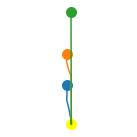

([26.44121240187925, 61.756485375176524],
 [26.44121240187925, 61.756485375176524],
 [10.708122562952058, 52.60483600902114],
 [7.227682048008699, 40.09098402708359],
 [0.0004706748834911383, 1.2684268900275567e-40],
 [False, False])

<Figure size 432x288 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

In [242]:
val_data_path = '/ssd_scratch/cvit/varunc/graphs/gt/'
val_run_path = ['/ssd_scratch/cvit/varunc/graphs/clip/','/ssd_scratch/cvit/varunc/graphs/iros/']
save_loc = '../trajectories_temp'

get_scores_comp(val_data_path, val_run_path, ['CLIP-MC','RNR-S'],save_loc,episodes = [6],subplots=[221,222,223,224])

Episode 22: Turn right from the crossroads.
(66, 3) (66, 3)
CLIP-MC
Frechet Distance: 5.369668918853363
FDE Distance: 5.369668918853363
ADE Distance: 2.749501788949054
ADE Matched Distance: 0.5624979669774022
nDTW Distance: 0.7704392193935654
TC Distance: False
(66, 3) (66, 3)
RNR-S
Frechet Distance: 18.959550090816215
FDE Distance: 18.95955009081621
ADE Distance: 21.63796384720802
ADE Matched Distance: 14.282628979282208
nDTW Distance: 1.8184856205732666e-14
TC Distance: False


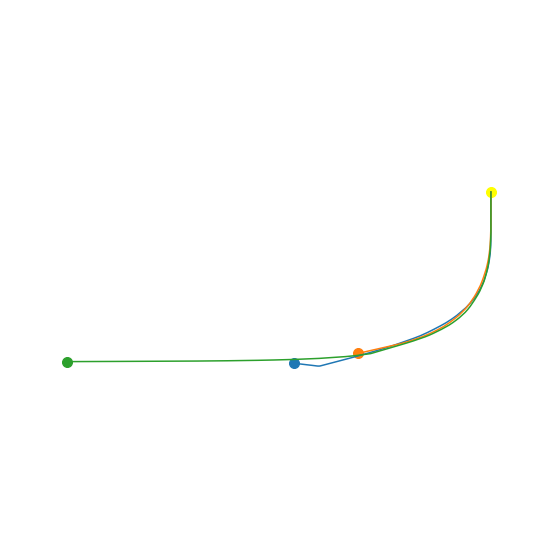

Episode 27: Turn left and stop near the intersection
(358, 3) (358, 3)
CLIP-MC
Frechet Distance: 8.325129479407924
FDE Distance: 8.325129479407924
ADE Distance: 30.88707620566361
ADE Matched Distance: 2.658515517855259
nDTW Distance: 0.5423172425770337
TC Distance: False
(358, 3) (358, 3)
RNR-S
Frechet Distance: 73.35725192977698
FDE Distance: 73.35725192977698
ADE Distance: 38.58528912648359
ADE Matched Distance: 17.58786631032158
nDTW Distance: 0.00022912176693153108
TC Distance: False


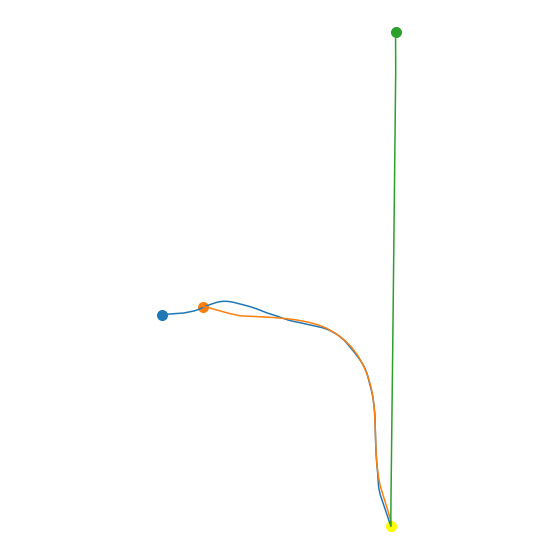

Episode 28: Turn left and come to a halt at the intersection
(501, 3) (501, 3)
CLIP-MC
Frechet Distance: 38.42952985929697
FDE Distance: 38.42952985929696
ADE Distance: 14.135117610423386
ADE Matched Distance: 2.822385533498976
nDTW Distance: 0.5686574161837058
TC Distance: False
(580, 3) (580, 3)
RNR-S
Frechet Distance: 23.797816447195597
FDE Distance: 23.797816447195597
ADE Distance: 15.035628404121178
ADE Matched Distance: 6.32898772206734
nDTW Distance: 0.2820142875057421
TC Distance: False


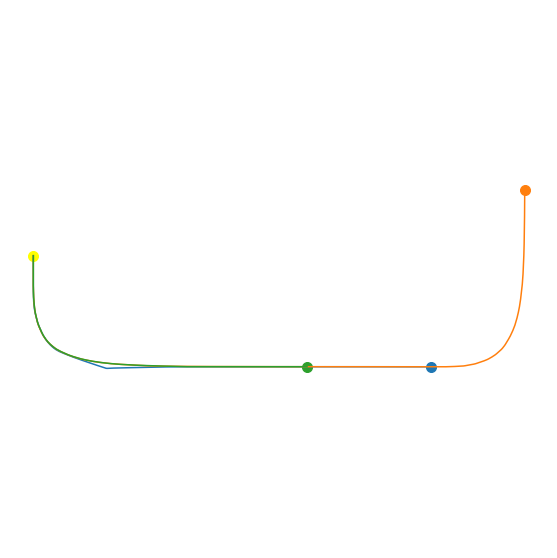

Episode 6: change to left lane
(70, 3) (70, 3)
CLIP-MC
Frechet Distance: 26.44121240187925
FDE Distance: 26.44121240187925
ADE Distance: 12.26191106015331
ADE Matched Distance: 7.227682048008699
nDTW Distance: 0.0004706748834911383
TC Distance: False
(70, 3) (70, 3)
RNR-S
Frechet Distance: 61.756485375176524
FDE Distance: 61.756485375176524
ADE Distance: 49.27043339098114
ADE Matched Distance: 40.09098402708359
nDTW Distance: 1.2684268900275567e-40
TC Distance: False


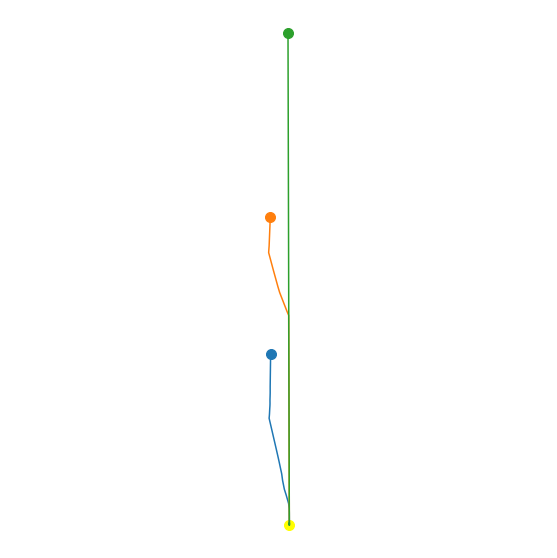

([5.369668918853363,
  18.959550090816215,
  8.325129479407924,
  73.35725192977698,
  38.42952985929697,
  23.797816447195597,
  26.44121240187925,
  61.756485375176524],
 [5.369668918853363,
  18.95955009081621,
  8.325129479407924,
  73.35725192977698,
  38.42952985929696,
  23.797816447195597,
  26.44121240187925,
  61.756485375176524],
 [2.749501788949054,
  21.63796384720802,
  30.88707620566361,
  38.58528912648359,
  14.135117610423386,
  15.035628404121178,
  12.26191106015331,
  49.27043339098114],
 [0.5624979669774022,
  14.282628979282208,
  2.658515517855259,
  17.58786631032158,
  2.822385533498976,
  6.32898772206734,
  7.227682048008699,
  40.09098402708359],
 [0.7704392193935654,
  1.8184856205732666e-14,
  0.5423172425770337,
  0.00022912176693153108,
  0.5686574161837058,
  0.2820142875057421,
  0.0004706748834911383,
  1.2684268900275567e-40],
 [False, False, False, False, False, False, False, False])

In [237]:
val_data_path = '/ssd_scratch/cvit/varunc/graphs/gt/'
val_run_path = ['/ssd_scratch/cvit/varunc/graphs/clip/','/ssd_scratch/cvit/varunc/graphs/iros/']
save_loc = '../trajectories_temp'

get_scores_comp(val_data_path, val_run_path, ['CLIP-MC','RNR-S'],save_loc,episodes = [22,27,28,6])

In [71]:
import math
trunc = lambda x: math.trunc(1000 * x) / 1000;

In [49]:
frechet_df = pd.DataFrame({'Val-Map':pd.Series(frechet_val_clip_6),'Test-Map':pd.Series(frechet_test_clip_6),'Val-NoMap':pd.Series(frechet_val_clip_6nomap),'Test-NoMap':pd.Series(frechet_test_clip_6nomap)})
fde_df = pd.DataFrame({'Val-Map':pd.Series(fde_val_clip_6),'Test-Map':pd.Series(fde_test_clip_6),'Val-NoMap':pd.Series(fde_val_clip_6nomap),'Test-NoMap':pd.Series(fde_test_clip_6nomap)})
ade_df = pd.DataFrame({'Val-Map':pd.Series(ade_val_clip_6),'Test-Map':pd.Series(ade_test_clip_6),'Val-NoMap':pd.Series(ade_val_clip_6nomap),'Test-NoMap':pd.Series(ade_test_clip_6nomap)})
ade_match_df = pd.DataFrame({'Val-Map':pd.Series(ade_matched_val_clip_6),'Test-Map':pd.Series(ade_matched_test_clip_6),'Val-NoMap':pd.Series(ade_matched_val_clip_6nomap),'Test-NoMap':pd.Series(ade_matched_test_clip_6nomap)})
ndtw_df = pd.DataFrame({'Val-Map':pd.Series(ndtw_val_clip_6),'Test-Map':pd.Series(ndtw_test_clip_6),'Val-NoMap':pd.Series(ndtw_val_clip_6nomap),'Test-NoMap':pd.Series(ndtw_test_clip_6nomap)})
tc_df = pd.DataFrame({'Val-Map':pd.Series(tc_val_clip_6),'Test-Map':pd.Series(tc_test_clip_6),'Val-NoMap':pd.Series(tc_val_clip_6nomap),'Test-NoMap':pd.Series(tc_test_clip_6nomap)})


In [63]:
frechet_metric = pd.DataFrame([frechet_df.mean(),frechet_df.std(),frechet_df.median()],index=['Mean','STD','Median'])
frechet_metric['Metric'] = 'Frechet'

fde_metric = pd.DataFrame([fde_df.mean(),fde_df.std(),fde_df.median()],index=['Mean','STD','Median'])
fde_metric['Metric'] = 'FDE'

ade_metric = pd.DataFrame([ade_df.mean(),ade_df.std(),ade_df.median()],index=['Mean','STD','Median'])
ade_metric['Metric'] = 'ADE'

ade_match_metric = pd.DataFrame([ade_match_df.mean(),ade_match_df.std(),ade_match_df.median()],index=['Mean','STD','Median'])
ade_match_metric['Metric'] = 'ADE Match'

ndtw_metric = pd.DataFrame([ndtw_df.mean(),ndtw_df.std(),ndtw_df.median()],index=['Mean','STD','Median'])
ndtw_metric['Metric'] = 'nDTW'

tc_metric = pd.DataFrame([tc_df.mean(),tc_df.std(),tc_df.median()],index=['Mean','STD','Median'])
tc_metric['Metric'] = 'Task Completion'

joined = pd.concat([frechet_metric,fde_metric,ade_metric,ade_match_metric,ndtw_metric,tc_metric])

joined['Measure'] = joined.index

joined = joined.set_index(['Metric','Measure'])

In [64]:
joined.T

Metric        Frechet                              FDE                        \
Measure          Mean        STD     Median       Mean        STD     Median   
Val-Map     13.537746  13.130894   8.523169  13.536816  13.131824   8.523169   
Test-Map    23.569764  49.973291   9.260606  22.144784  49.824289   8.764641   
Val-NoMap   54.144742  77.431001  13.971223  51.431637  69.332212  13.971223   
Test-NoMap  50.898006  60.703003  29.531908  27.876552  25.619447  23.171399   

Metric            ADE                        ADE Match                       \
Measure          Mean        STD     Median       Mean        STD    Median   
Val-Map      6.315672   4.663375   5.018031   1.812250   2.016621  0.662795   
Test-Map    17.416428  47.310492   5.079331  11.469604  46.840572  1.041967   
Val-NoMap   26.304151  44.601289   7.909633  19.372088  38.478973  2.945470   
Test-NoMap  25.414810  26.429363  14.214218  18.406841  25.002322  6.524667   

Metric          nDTW                     Task Completion                   
Measure         Mean       STD    Median            Mean       STD Median  
Val-Map     0.544586  0.312208  0.594053        0.280000  0.458258    0.0  
Test-Map    0.562131  0.346011  0.654810        0.323529  0.474858    0.0  
Val-NoMap   0.366596  0.326749  0.409812        0.200000  0.408248    0.0  
Test-NoMap  0.318528  0.335840  0.138249        0.088235  0.287902    0.0

In [52]:
# joined.applymap(trunc).to_csv('joined.csv')

Text(0.5, 1.0, 'Freschet Distance')

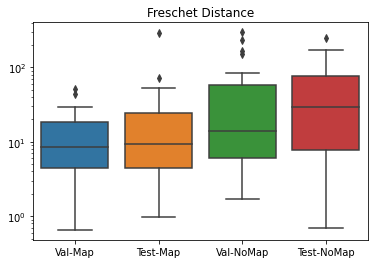

In [53]:
g = sns.boxplot(data=frechet_df)
g.set_yscale("log")
# g.set_ylim([-5,60])
plt.title('Freschet Distance')

Text(0.5, 1.0, 'FDE Distance')

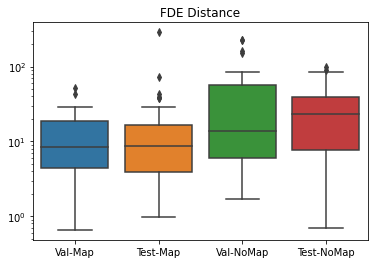

In [54]:
g = sns.boxplot(data=fde_df)
g.set_yscale("log")
plt.title('FDE Distance')

Text(0.5, 1.0, 'ADE Distance')

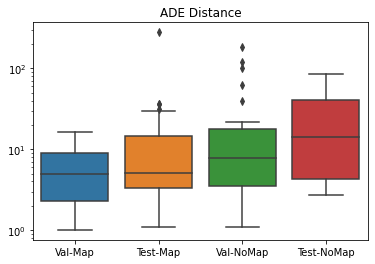

In [55]:
g = sns.boxplot(data=ade_df)
g.set_yscale("log")
plt.title('ADE Distance')

Text(0.5, 1.0, 'ADE Match Distance')

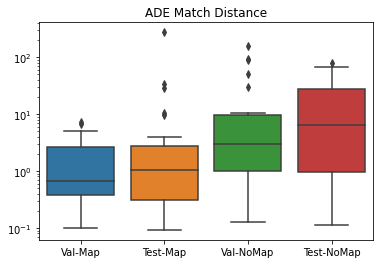

In [56]:
g = sns.boxplot(data=ade_match_df)
g.set_yscale("log")
plt.title('ADE Match Distance')

Text(0.5, 1.0, 'nDTW Distance')

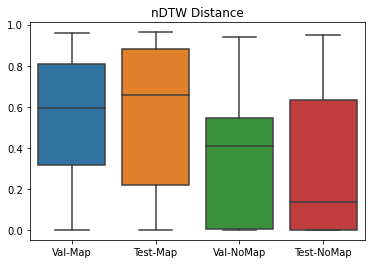

In [61]:
g = sns.boxplot(data=ndtw_df)
# g.set_yscale("log")
plt.title('nDTW Distance')

Text(0.5, 1.0, 'TC Distance')

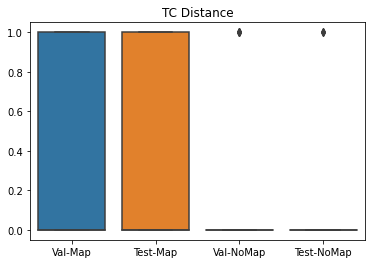

In [62]:
g = sns.boxplot(data=tc_df)
# g.set_yscale("log")
plt.title('TC Distance')

In [31]:
def get_ablations(commands):
    out = dict()
    for i,command in enumerate(commands):
        print(command)
        c_types = input('Type:')
        c_types = [ c.strip() for c in c_types.split(',')]
        for c_type in c_types:
            if c_type in out:
                out[c_type].append(i)
            else:
                out[c_type] = [i]
    return out

In [45]:
import re

In [82]:
def get_ablations_from_wordlist(commands,wordlist):
    out = dict()
    for word in wordlist:
        out[word.lower()] = []
    for i,command in enumerate(commands):
        print(command)
        command = re.sub(r'[^a-zA-Z]', ' ', command)
        command = command.lower().strip().split()
        for c in command:
            if c not in out.keys():
                continue
            out[c].append(i)
            print(c,end=' ')
        print('')
    for word in wordlist:
        out[word.lower()] = list(set(out[word.lower()]))
    return out

In [103]:
commands = get_commands('/ssd_scratch/cvit/varunc/carla_data/test/')

In [106]:
stop_turn = get_ablations_from_wordlist(commands,['stop','left','park','right','straight'])

Stop in front of the garbage dumpsters.
stop 
Turn left and stop near the traffic signal
left stop 
take a right turn and stop across the bench on left
right stop left 
stop by the lamp post
stop 
Turn left and stop near the traffic signal
left stop 
Go straight and stop next to the grey arch.
straight stop 
Turn right and park near the sidewalk.
right park 
Turn right and stop just before the traffic signal
right stop 
park immediately after the signboard
park 
Stop near the signboard
stop 
Wait for the signal to turn green and continue straight
straight 
Drive towards the bus stop and park after crossing it
stop park 
Turn left and stop beside the traffic signal
left stop 
Turn right from the intersection
right 
Turn right and stop before the traffic signal
right stop 
Take a left from the intersection ahead
left 
Turn right from the crossroads.
right 
After crossing the blue car come to a stop
stop 
Take a left at the traffic light
left 
Park on the roadside after you have crossed t

In [105]:
stop_turn

{'stop': [0,
  1,
  2,
  3,
  4,
  5,
  7,
  9,
  11,
  12,
  14,
  17,
  19,
  22,
  23,
  24,
  25,
  26,
  27,
  30],
 'left': [1, 2, 33, 4, 12, 15, 18, 25, 29, 31],
 'park': [32, 6, 8, 11, 19],
 'right': [2, 6, 7, 13, 14, 16, 20, 21, 23, 24, 28, 30],
 'straight': [27, 10, 21, 5]}

In [51]:
stop_turn = get_ablations(commands)

Shift to the left lane and stop at the intersection.


KeyboardInterrupt: Interrupted by user

In [18]:
stop_turn = {'stop': [0, 2, 4, 6, 9, 11, 12, 13, 15, 17, 18, 22, 24, 25, 29, 30, 31, 32, 33, 35, 36, 38, 39, 40, 41, 43, 44, 46, 47], 'left': [1, 3, 8, 10, 14, 15, 19, 26, 34, 42], 'right': [5, 7, 19, 21, 24, 27, 28, 32, 36, 37, 44, 45, 48, 49], 'straight': [16, 20, 23]}

In [55]:
results_val_df[stop_turn['stop']].mean(axis=1)

Meteric    Model  
frechet    CLIP-VC    12.994535
           CLIP-V     50.230631
           CLIP       31.570558
           CLIP-C     68.860764
           RNR-C      23.380336
           RNR        27.579007
fde        CLIP-VC    12.994535
           CLIP-V     45.739667
           CLIP       25.467835
           CLIP-C     62.023489
           RNR-C      23.380336
           RNR        27.541250
ade        CLIP-VC     6.072857
           CLIP-V     24.545058
           CLIP       18.816038
           CLIP-C     33.562296
           RNR-C      12.083113
           RNR        16.128997
ade_match  CLIP-VC     1.536927
           CLIP-V     17.931067
           CLIP       12.743140
           CLIP-C     27.362996
           RNR-C       5.893372
           RNR         9.890720
tc         CLIP-VC     0.769231
           CLIP-V      0.615385
           CLIP        0.615385
           CLIP-C      0.692308
           RNR-C       0.615385
           RNR         0.461538
nDTW       CLIP-VC   

In [108]:
command_specific = pd.DataFrame({
    f'{key}_mean':results_test_df[stop_turn[key]].mean(axis=1) for key in stop_turn.keys()}).T
command_specific

Meteric          frechet                                              \
Model            CLIP-VC     CLIP-V       CLIP     CLIP-C      RNR-C   
stop_mean      13.657662  62.557142  43.562818  32.777137  43.294869   
left_mean      17.433215  43.537352  27.242446  41.420843  38.422416   
park_mean      13.329254  15.709297  27.527645  26.923644  42.268309   
right_mean     18.398135  61.462298  62.665780  54.154242  52.025879   
straight_mean   7.213880  68.459381  93.834705  60.048579  38.574816   

Meteric                         fde                                   ...  \
Model                RNR    CLIP-VC     CLIP-V       CLIP     CLIP-C  ...   
stop_mean      43.519980  13.645838  54.726084  38.101392  23.476152  ...   
left_mean      34.524481  12.588283  41.701571  27.242446  35.492747  ...   
park_mean      80.496014  13.329254  15.709297  27.527645  14.385608  ...   
right_mean     31.320531  18.398135  48.870480  37.238124  27.514899  ...   
straight_mean  37.773847   7.213880  65.544875  44.739310  10.841997  ...   

Meteric         tc                                nDTW                      \
Model         CLIP    CLIP-C RNR-C       RNR   CLIP-VC    CLIP-V      CLIP   
stop_mean      0.5  0.450000  0.35  0.350000  0.615232  0.243601  0.215994   
left_mean      0.6  0.400000  0.20  0.300000  0.525587  0.259600  0.171930   
park_mean      0.4  0.600000  0.40  0.400000  0.603609  0.495750  0.384040   
right_mean     0.5  0.583333  0.50  0.333333  0.548770  0.226757  0.267557   
straight_mean  0.5  1.000000  0.50  0.500000  0.700431  0.115129  0.032691   

Meteric                                      
Model            CLIP-C     RNR-C       RNR  
stop_mean      0.391268  0.393159  0.169660  
left_mean      0.352972  0.295367  0.247524  
park_mean      0.501262  0.356773  0.038222  
right_mean     0.378558  0.451627  0.220440  
straight_mean  0.513606  0.306577  0.255812  

[5 rows x 36 columns]

In [109]:
command_specific.applymap(trunc).to_csv('command_specific.csv')

In [110]:
from copy import deepcopy

In [111]:
stopping_turning = dict()
stopping_turning['Stopping Based'] = list(set([*stop_turn['stop'],*stop_turn['park']]))
stopping_turning['Turning Based'] = list(set([*stop_turn['right'],*stop_turn['left']]))

In [112]:
type_joined = pd.DataFrame({
    f'{key}':results_test_df[stopping_turning[key]].mean(axis=1) for key in stopping_turning.keys()}).T
type_joined

Meteric           frechet                                              \
Model             CLIP-VC     CLIP-V       CLIP     CLIP-C      RNR-C   
Stopping Based  12.733693  56.866385  40.507940  30.227329  44.879173   
Turning Based   18.768086  55.094376  48.588746  50.655039  47.924547   

Meteric                          fde                                   ...  \
Model                 RNR    CLIP-VC     CLIP-V       CLIP     CLIP-C  ...   
Stopping Based  45.663746  12.723412  50.056769  35.758874  22.139516  ...   
Turning Based   34.225648  16.460976  47.024870  34.058657  32.620392  ...   

Meteric               tc                                    nDTW            \
Model               CLIP    CLIP-C     RNR-C       RNR   CLIP-VC    CLIP-V   
Stopping Based  0.478261  0.478261  0.347826  0.347826  0.633166  0.260248   
Turning Based   0.523810  0.476190  0.333333  0.285714  0.518078  0.237615   

Meteric                                                
Model               CLIP    CLIP-C    RNR-C       RNR  
Stopping Based  0.242929  0.417515  0.38480  0.148444  
Turning Based   0.233159  0.339831  0.35458  0.200453  

[2 rows x 36 columns]

In [113]:
type_joined.applymap(trunc).to_csv('type_joined.csv')

In [19]:
stop_frechet_df = frechet_df.iloc[stop_turn['stop']].reset_index().drop('index',axis=1)
stop_fde_df = fde_df.iloc[stop_turn['stop']].reset_index().drop('index',axis=1)
stop_ade_df = ade_df.iloc[stop_turn['stop']].reset_index().drop('index',axis=1)
stop_ade_match_df = ade_match_df.iloc[stop_turn['stop']].reset_index().drop('index',axis=1)


stop_frechet_metric = pd.DataFrame([stop_frechet_df.mean(),stop_frechet_df.std(),stop_frechet_df.median()],index=['Mean','STD','Median'])
stop_frechet_metric['Metric'] = 'Frechet'

stop_fde_metric = pd.DataFrame([stop_fde_df.mean(),stop_fde_df.std(),stop_fde_df.median()],index=['Mean','STD','Median'])
stop_fde_metric['Metric'] = 'FDE'

stop_ade_metric = pd.DataFrame([stop_ade_df.mean(),stop_ade_df.std(),stop_ade_df.median()],index=['Mean','STD','Median'])
stop_ade_metric['Metric'] = 'ADE'

stop_ade_match_metric = pd.DataFrame([stop_ade_match_df.mean(),stop_ade_match_df.std(),stop_ade_match_df.median()],index=['Mean','STD','Median'])
stop_ade_match_metric['Metric'] = 'ADE Match'

stop_joined = pd.concat([stop_frechet_metric,stop_fde_metric,stop_ade_metric,stop_ade_match_metric])

stop_joined['Measure'] = stop_joined.index
stop_joined['Command Type'] = 'Stopping Based'
stop_joined = stop_joined.set_index(['Metric','Measure'])
stop_joined

Conv3D        VIT    Command Type
Metric    Measure                                      
Frechet   Mean     17.326682  53.981311  Stopping Based
          STD      21.375390  72.795143  Stopping Based
          Median    9.665442  12.282180  Stopping Based
FDE       Mean     17.316695  47.667016  Stopping Based
          STD      21.383593  60.744939  Stopping Based
          Median    9.665442  12.282180  Stopping Based
ADE       Mean     10.724657  26.614002  Stopping Based
          STD      12.428624  39.105454  Stopping Based
          Median    7.157681   7.676123  Stopping Based
ADE Match Mean      4.444001  20.895273  Stopping Based
          STD       9.003296  37.588336  Stopping Based
          Median    1.366873   3.702058  Stopping Based

In [20]:
turn_frechet_df = frechet_df.iloc[[*stop_turn['left'],*stop_turn['right']]].reset_index().drop('index',axis=1)
turn_fde_df = fde_df.iloc[[*stop_turn['left'],*stop_turn['right']]].reset_index().drop('index',axis=1)
turn_ade_df = ade_df.iloc[[*stop_turn['left'],*stop_turn['right']]].reset_index().drop('index',axis=1)
turn_ade_match_df = ade_match_df.iloc[[*stop_turn['left'],*stop_turn['right']]].reset_index().drop('index',axis=1)


turn_frechet_metric = pd.DataFrame([turn_frechet_df.mean(),turn_frechet_df.std(),turn_frechet_df.median()],index=['Mean','STD','Median'])
turn_frechet_metric['Metric'] = 'Frechet'

turn_fde_metric = pd.DataFrame([turn_fde_df.mean(),turn_fde_df.std(),turn_fde_df.median()],index=['Mean','STD','Median'])
turn_fde_metric['Metric'] = 'FDE'

turn_ade_metric = pd.DataFrame([turn_ade_df.mean(),turn_ade_df.std(),turn_ade_df.median()],index=['Mean','STD','Median'])
turn_ade_metric['Metric'] = 'ADE'

turn_ade_match_metric = pd.DataFrame([turn_ade_match_df.mean(),turn_ade_match_df.std(),turn_ade_match_df.median()],index=['Mean','STD','Median'])
turn_ade_match_metric['Metric'] = 'ADE Match'

turn_joined = pd.concat([turn_frechet_metric,turn_fde_metric,turn_ade_metric,turn_ade_match_metric])

turn_joined['Measure'] = turn_joined.index

turn_joined['Command Type'] = 'Turning Based'

turn_joined = turn_joined.set_index(['Metric','Measure'])
turn_joined

Conv3D        VIT   Command Type
Metric    Measure                                     
Frechet   Mean     17.970466  36.416590  Turning Based
          STD      21.371984  40.996674  Turning Based
          Median    6.965737  16.678068  Turning Based
FDE       Mean     17.970466  35.569278  Turning Based
          STD      21.371984  39.775306  Turning Based
          Median    6.965737  16.678068  Turning Based
ADE       Mean     10.017345  17.524459  Turning Based
          STD       9.300756  21.721663  Turning Based
          Median    5.041168  10.150757  Turning Based
ADE Match Mean      5.033972  11.398932  Turning Based
          STD       7.565082  18.248139  Turning Based
          Median    1.321265   3.451181  Turning Based

In [21]:
type_joined = pd.concat([stop_joined.reset_index(),turn_joined.reset_index()])
type_joined = type_joined.pivot_table(index=['Command Type','Metric'],columns='Measure',sort=False)
type_joined

Conv3D                             VIT  \
Measure                        Mean    Median        STD       Mean   
Command Type   Metric                                                 
Stopping Based Frechet    17.326682  9.665442  21.375390  53.981311   
               FDE        17.316695  9.665442  21.383593  47.667016   
               ADE        10.724657  7.157681  12.428624  26.614002   
               ADE Match   4.444001  1.366873   9.003296  20.895273   
Turning Based  Frechet    17.970466  6.965737  21.371984  36.416590   
               FDE        17.970466  6.965737  21.371984  35.569278   
               ADE        10.017345  5.041168   9.300756  17.524459   
               ADE Match   5.033972  1.321265   7.565082  11.398932   

                                                
Measure                      Median        STD  
Command Type   Metric                           
Stopping Based Frechet    12.282180  72.795143  
               FDE        12.282180  60.744939  
               ADE         7.676123  39.105454  
               ADE Match   3.702058  37.588336  
Turning Based  Frechet    16.678068  40.996674  
               FDE        16.678068  39.775306  
               ADE        10.150757  21.721663  
               ADE Match   3.451181  18.248139

In [75]:
type_joined.applymap(trunc).to_csv('type_joined.csv')

In [114]:
len_commands = [len(s.split()) for s in commands]

In [115]:
len_commands
length_commands = dict()
for i,len_c in enumerate(len_commands):
    if len_c in length_commands:
        length_commands[len_c].append(i)
    else:
        length_commands[len_c] = [i]


In [116]:
length_commands

{7: [0, 6, 15, 18, 22, 25, 28, 31],
 8: [1, 4, 12, 14, 23, 24],
 11: [2, 19],
 5: [3, 8, 13, 16, 26, 32],
 9: [5, 7, 17],
 4: [9],
 10: [10, 11, 29],
 6: [20, 21, 30, 33],
 12: [27]}

In [117]:
length_based = pd.DataFrame({
    f'{key}':results_test_df[length_commands[key]].mean(axis=1) for key in length_commands.keys()}).T
length_based

Meteric    frechet                                                          \
Model      CLIP-VC      CLIP-V       CLIP     CLIP-C      RNR-C        RNR   
7        18.424109   24.635636  25.912596  22.345173  30.240475  27.176964   
8        11.110296   75.541047  68.935288  36.776408  77.585543  46.252518   
11        4.265137   18.521726   6.760580   6.377683  12.649948  15.051809   
5         7.406736   80.446469  22.363697  17.524540  49.818127  55.591369   
9        16.604884   21.212620  48.614667  43.364805  29.221933   1.926508   
4         3.098183   17.603349   6.267968  13.296441  13.231217  39.344859   
10       15.531327   27.817980  49.886434  84.800055  36.314921  93.159434   
6        34.358768  110.410025  77.744355  95.819494  51.593057  46.734869   
12        8.325129   29.161388  64.659091  10.244110  70.348061  73.357252   

Meteric        fde                                   ...        tc            \
Model      CLIP-VC     CLIP-V       CLIP     CLIP-C  ...      CLIP    CLIP-C   
7        12.338385  24.635636  25.912593  22.345160  ...  0.500000  0.500000   
8        11.110296  72.704841  68.698162  36.776408  ...  0.333333  0.333333   
11        4.265137  18.521726   6.760580   6.264939  ...  1.000000  1.000000   
5         7.406736  80.446469  22.363697  17.524540  ...  0.166667  0.666667   
9        16.604884  21.212620  12.679414   2.330164  ...  1.000000  0.666667   
4         3.098183  17.603349   6.267968  13.296441  ...  1.000000  0.000000   
10       15.531327  27.317745  49.886434  44.218170  ...  0.333333  0.333333   
6        34.358768  72.634573  28.648960  46.612911  ...  0.500000  0.250000   
12        8.325129  29.161388  64.659091  10.244110  ...  0.000000  1.000000   

Meteric                          nDTW                                          \
Model       RNR-C       RNR   CLIP-VC    CLIP-V      CLIP    CLIP-C     RNR-C   
7        0.125000  0.375000  0.593679  0.405090  0.251325  0.416514  0.277993   
8        0.333333  0.166667  0.631778  0.137795  0.047809  0.354296  0.341711   
11       1.000000  1.000000  0.825779  0.370731  0.343172  0.832392  0.626014   
5        0.500000  0.000000  0.748211  0.199594  0.291477  0.417071  0.371799   
9        0.333333  1.000000  0.312833  0.142963  0.334150  0.603250  0.589611   
4        0.000000  0.000000  0.962851  0.670164  0.851563  0.852882  0.860675   
10       0.000000  0.000000  0.588233  0.617082  0.249286  0.242128  0.167863   
6        0.500000  0.250000  0.294869  0.002031  0.230984  0.002926  0.112687   
12       0.000000  0.000000  0.542317  0.031627  0.000451  0.439675  0.000763   

Meteric                
Model             RNR  
7        1.292765e-01  
8        7.209277e-02  
11       5.405458e-01  
5        8.662181e-03  
9        5.397799e-01  
4        1.627499e-07  
10       1.856581e-01  
6        1.871141e-01  
12       2.291218e-04  

[9 rows x 36 columns]

In [118]:
length_based.applymap(trunc).to_csv('length_based.csv')

In [25]:
command_vals = dict()
for i,len_c in enumerate(len_commands):
    if len_c in command_vals:
        command_vals[len_c].append({'Conv3D':{
                                        'frechet':frechet_conv3d[i],
                                        'ade_match':ade_matched_conv3d[i],
                                        'ade':ade_conv3d[i],
                                        'fde':fde_conv3d[i]},
                                    'VIT':{
                                        'frechet':frechet_vit[i],
                                        'ade_match':ade_matched_vit[i],
                                        'ade':ade_vit[i],
                                        'fde':fde_vit[i]}
                                   })
    else:
        command_vals[len_c] = [{'Conv3D':{
                                        'frechet':frechet_conv3d[i],
                                        'ade_match':ade_conv3d[i],
                                        'ade':ade_conv3d[i],
                                        'fde':fde_conv3d[i]},
                                    'VIT':{
                                        'frechet':frechet_vit[i],
                                        'ade_match':ade_matched_vit[i],
                                        'ade':ade_vit[i],
                                        'fde':fde_vit[i]}
                                   }]


In [26]:
command_vals

{6: [{'Conv3D': {'frechet': 26.111845491426653,
    'ade_match': 41.2555774241194,
    'ade': 41.2555774241194,
    'fde': 26.111845491426653},
   'VIT': {'frechet': 90.59249842920809,
    'ade_match': 38.12549675972528,
    'ade': 44.33715923340456,
    'fde': 90.59249842920809}},
  {'Conv3D': {'frechet': 6.409774368995845,
    'ade_match': 1.5706127697530465,
    'ade': 4.132724146503285,
    'fde': 6.409774368995845},
   'VIT': {'frechet': 6.593041440555822,
    'ade_match': 0.4778890316451603,
    'ade': 3.5402183203237167,
    'fde': 6.593041440555822}},
  {'Conv3D': {'frechet': 7.521698756749053,
    'ade_match': 0.9440076470747767,
    'ade': 4.6012384977254674,
    'fde': 7.521698756749053},
   'VIT': {'frechet': 8.425640053997611,
    'ade_match': 1.1563228977490998,
    'ade': 3.154552474136442,
    'fde': 8.425640053997611}},
  {'Conv3D': {'frechet': 1.1752202891395593,
    'ade_match': 0.2761978171832063,
    'ade': 1.908408684043676,
    'fde': 1.1752004228828945},
   'VIT

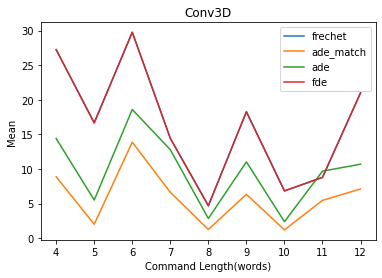

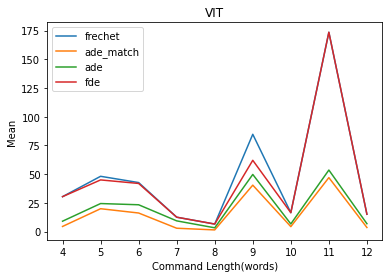

In [27]:
l_cv = sorted([(k,v) for k,v in command_vals.items()],key = lambda it: it[0])
for model in ['Conv3D','VIT']:
    plt.figure()
    for metric in ['frechet','ade_match','ade','fde']:
        x = [k for k,v in l_cv]
        y = [np.mean([t[model][metric] for t in v]) for k,v in l_cv]
        plt.plot(x,y,label = metric)
    plt.title(model)
    plt.legend()
    plt.ylabel('Mean')
    plt.xlabel('Command Length(words)')
    plt.show()

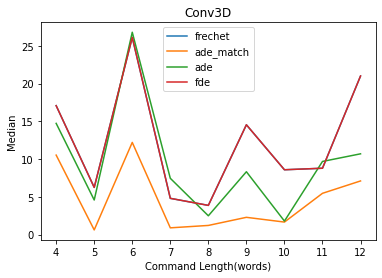

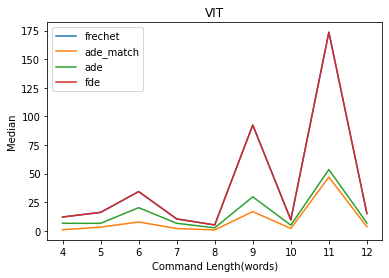

In [28]:
l_cv = sorted([(k,v) for k,v in command_vals.items()],key = lambda it: it[0])
for model in ['Conv3D','VIT']:
    plt.figure()
    for metric in ['frechet','ade_match','ade','fde']:
        x = [k for k,v in l_cv]
        y = [np.median([t[model][metric] for t in v]) for k,v in l_cv]
        plt.plot(x,y,label = metric)
    plt.title(model)
    plt.legend()
    plt.ylabel('Median')
    plt.xlabel('Command Length(words)')
    plt.show()

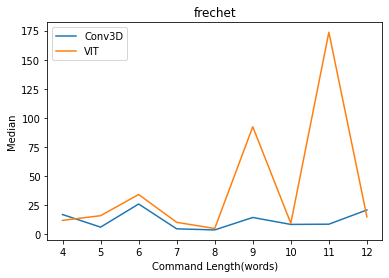

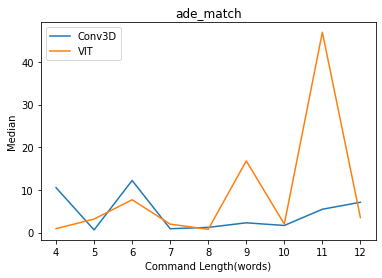

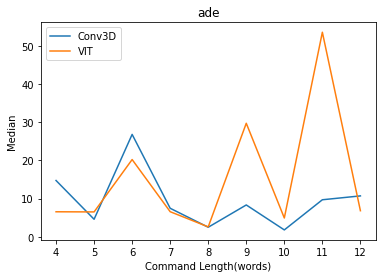

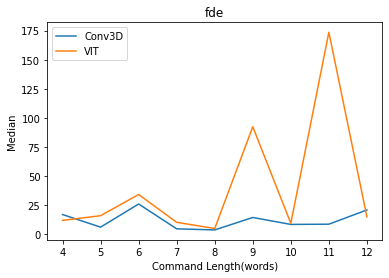

In [29]:
l_cv = sorted([(k,v) for k,v in command_vals.items()],key = lambda it: it[0])
for metric in ['frechet','ade_match','ade','fde']:
    plt.figure()
    for model in ['Conv3D','VIT']:
        x = [k for k,v in l_cv]
        y = [np.median([t[model][metric] for t in v]) for k,v in l_cv]
        plt.plot(x,y,label = model)
    plt.title(metric)
    plt.legend()
    plt.ylabel('Median')
    plt.xlabel('Command Length(words)')
    plt.show()

In [119]:
def get_subcommand_count_from_wordlist(commands,wordlist):
    out = dict()
    for i,word in enumerate(wordlist):
        wordlist[i] = word.lower()
        
    for i,command in enumerate(commands):
        print(command)
        command = re.sub(r'[^a-zA-Z]', ' ', command)
        command = command.lower().strip().split()
        count = 0
        for c in command:
            if c not in wordlist:
                continue
            count+=1
        print(count)
        if count in out.keys():
            out[count].append(i)
        else:
            out[count]=[i]
    return out

In [120]:
sub_command_count = get_subcommand_count_from_wordlist(commands,['stop','left','right','park','wait','straight'])

Stop in front of the garbage dumpsters.
1
Turn left and stop near the traffic signal
2
take a right turn and stop across the bench on left
3
stop by the lamp post
1
Turn left and stop near the traffic signal
2
Go straight and stop next to the grey arch.
2
Turn right and park near the sidewalk.
2
Turn right and stop just before the traffic signal
2
park immediately after the signboard
1
Stop near the signboard
1
Wait for the signal to turn green and continue straight
2
Drive towards the bus stop and park after crossing it
2
Turn left and stop beside the traffic signal
2
Turn right from the intersection
1
Turn right and stop before the traffic signal
2
Take a left from the intersection ahead
1
Turn right from the crossroads.
1
After crossing the blue car come to a stop
1
Take a left at the traffic light
1
Park on the roadside after you have crossed the bus stop
2
Turn right from the crossroads ahead
1
go straight and take a right
2
Change lanes and stop at the junction.
1
Turn right and 

In [30]:
sub_command_count = get_ablations(commands)

Stop after crossing the stop signboard
Type:1
go straight and take a left
Type:2
After crossing the blue car come to a stop
Type:1
Turn left from the intersection
Type:1
Change lanes and stop at the junction.
Type:2
Drive straight then turn right.
Type:1
Stop near the signboard
Type:1
Turn right from the crossroads.
Type:1
Drive to the intersection and turn left
Type:2
Go straight and stop a few metres ahead of the bus stop
Type:1
Take a left from the intersection ahead.
Type:1
Park near the hut visible on the right
Type:1
Park on the roadside after you have crossed the bus stop
Type:1
park immediately after the signboard
Type:1
Take a left from the interection.
Type:1
Turn left and stop next to the bus stop.
Type:2
Wait at the traffic light then go straight.
Type:2
Stop as soon as you encounter a white car
Type:1
stop beside the black suv
Type:1
take a right at the traffic lights and then take a left
Type:2
Wait for the signal to turn green and continue straight
Type:2
Take the next r

In [121]:
subcommands_based = pd.DataFrame({
    f'{key}':results_test_df[sub_command_count[key]].mean(axis=1) for key in sub_command_count.keys()}).T
subcommands_based

Meteric    frechet                                                         \
Model      CLIP-VC     CLIP-V       CLIP     CLIP-C      RNR-C        RNR   
1        15.248528  45.259646  24.143101  30.066307  43.752766  39.735091   
2        16.754152  70.329496  67.528456  55.968934  49.973891  44.349871   
3         6.169750  17.174447  30.064170   4.647751  24.925430  49.029109   

Meteric        fde                                   ...        tc            \
Model      CLIP-VC     CLIP-V       CLIP     CLIP-C  ...      CLIP    CLIP-C   
1        12.384658  45.180789  24.114967  26.564001  ...  0.411765  0.411765   
2        16.754152  58.309555  45.733325  28.673447  ...  0.571429  0.500000   
3         6.169750  17.174447  30.064170   4.572588  ...  0.333333  1.000000   

Meteric                          nDTW                                          \
Model       RNR-C       RNR   CLIP-VC    CLIP-V      CLIP    CLIP-C     RNR-C   
1        0.235294  0.176471  0.599443  0.305408  0.308862  0.393062  0.256690   
2        0.357143  0.428571  0.557333  0.187190  0.205214  0.324729  0.363723   
3        0.666667  0.333333  0.691857  0.394659  0.045089  0.745743  0.628597   

Meteric            
Model         RNR  
1        0.131329  
2        0.170072  
3        0.303743  

[3 rows x 36 columns]

In [122]:
subcommands_based.applymap(trunc).to_csv('subcommands_based.csv')

In [33]:
sub_command_count = {'1': [0, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 17, 18, 21, 22, 23, 25, 27, 29, 31, 33, 34, 35, 37, 38, 39, 42, 43, 45, 46, 47, 48, 49], '2': [1, 4, 8, 15, 16, 19, 20, 24, 26, 28, 30, 32, 36, 40, 41, 44]}

In [123]:
target_type = get_ablations(commands)

Stop in front of the garbage dumpsters.
Type:infra
Turn left and stop near the traffic signal
Type:road
take a right turn and stop across the bench on left
Type:infra
stop by the lamp post
Type:infra
Turn left and stop near the traffic signal
Type:road
Go straight and stop next to the grey arch.
Type:infra
Turn right and park near the sidewalk.
Type:road
Turn right and stop just before the traffic signal
Type:road
park immediately after the signboard
Type:road
Stop near the signboard
Type:road
Wait for the signal to turn green and continue straight
Type:road
Drive towards the bus stop and park after crossing it
Type:infra
Turn left and stop beside the traffic signal
Type:road
Turn right from the intersection
Type:road
Turn right and stop before the traffic signal
Type:road
Take a left from the intersection ahead
Type:road
Turn right from the crossroads.
Type:road
After crossing the blue car come to a stop
Type:auto
Take a left at the traffic light
Type:road
Park on the roadside after y

In [124]:
target_based = pd.DataFrame({
    f'{key}':results_test_df[target_type[key]].mean(axis=1) for key in target_type.keys()}).T
target_based

Meteric    frechet                                                          \
Model      CLIP-VC      CLIP-V       CLIP     CLIP-C      RNR-C        RNR   
infra     9.262961   10.977143  33.844036  18.384789  18.493099  53.105394   
road     17.578500   55.326045  49.163786  47.691763  49.679602  36.292154   
auto     11.294390  148.411369  14.834747  21.548891  75.877382  61.306457   

Meteric        fde                                    ...        tc            \
Model      CLIP-VC      CLIP-V       CLIP     CLIP-C  ...      CLIP    CLIP-C   
infra     9.233401   10.977143  33.844036  10.520316  ...  0.375000  0.750000   
road     15.472008   47.951273  35.897184  31.235150  ...  0.521739  0.478261   
auto     11.294390  148.411369  14.675328  21.387684  ...  0.333333  0.000000   

Meteric                          nDTW                                          \
Model       RNR-C       RNR   CLIP-VC    CLIP-V      CLIP    CLIP-C     RNR-C   
infra    0.625000  0.375000  0.679238  0.478773  0.114789  0.495973  0.532757   
road     0.217391  0.260870  0.553276  0.209228  0.247820  0.358311  0.286700   
auto     0.333333  0.333333  0.636508  0.118048  0.546919  0.418857  0.161828   

Meteric            
Model         RNR  
infra    0.170350  
road     0.143414  
auto     0.287838  

[3 rows x 36 columns]

In [125]:
target_based.applymap(trunc).to_csv('target_based.csv')

In [76]:
target_type = {'infrastructure': [0, 6, 9, 11, 12, 13, 15, 25, 31, 32, 33, 35, 36, 39, 40, 41, 43, 44, 46], 'road/traffic light': [1, 3, 4, 5, 7, 8, 10, 14, 15, 16, 19, 20, 21, 23, 24, 26, 27, 28, 30, 32, 34, 36, 37, 38, 40, 42, 44, 45, 47, 48, 49], 'automobile': [2, 17, 18, 22, 29]}

In [77]:
subcommands_frechet_df = dict()
subcommands_fde_df = dict()
subcommands_ade_df = dict()
subcommands_ade_match_df = dict()
subcommands_frechet_metric = dict()
subcommands_fde_metric = dict()
subcommands_ade_metric = dict()
subcommands_ade_match_metric = dict()
subcommands_joined = dict()


for k in sub_command_count.keys():
    subcommands_frechet_df[k] = frechet_df.iloc[sub_command_count[k]].reset_index().drop('index',axis=1)
    subcommands_fde_df[k] = fde_df.iloc[sub_command_count[k]].reset_index().drop('index',axis=1)
    subcommands_ade_df[k] = ade_df.iloc[sub_command_count[k]].reset_index().drop('index',axis=1)
    subcommands_ade_match_df[k] = ade_match_df.iloc[sub_command_count[k]].reset_index().drop('index',axis=1)


    subcommands_frechet_metric[k] = pd.DataFrame([subcommands_frechet_df[k].mean(),subcommands_frechet_df[k].std(),subcommands_frechet_df[k].median()],index=['Mean','STD','Median'])
    subcommands_frechet_metric[k]['Metric'] = 'Frechet'

    subcommands_fde_metric[k] = pd.DataFrame([subcommands_fde_df[k].mean(),subcommands_fde_df[k].std(),subcommands_fde_df[k].median()],index=['Mean','STD','Median'])
    subcommands_fde_metric[k]['Metric'] = 'FDE'

    subcommands_ade_metric[k] = pd.DataFrame([subcommands_ade_df[k].mean(),subcommands_ade_df[k].std(),subcommands_ade_df[k].median()],index=['Mean','STD','Median'])
    subcommands_ade_metric[k]['Metric'] = 'ADE'

    subcommands_ade_match_metric[k] = pd.DataFrame([subcommands_ade_match_df[k].mean(),subcommands_ade_match_df[k].std(),subcommands_ade_match_df[k].median()],index=['Mean','STD','Median'])
    subcommands_ade_match_metric[k]['Metric'] = 'ADE Match'

    subcommands_joined[k] = pd.concat([subcommands_frechet_metric[k],subcommands_fde_metric[k],subcommands_ade_metric[k],subcommands_ade_match_metric[k]])

    subcommands_joined[k]['Measure'] = subcommands_joined[k].index
    subcommands_joined[k]['Subcommand Counts'] = k
    subcommands_joined[k] = subcommands_joined[k].set_index(['Metric','Measure'])
subcommands_joined

{'1':                       Conv3D        VIT Subcommand Counts
 Metric    Measure                                        
 Frechet   Mean     21.695631  46.315727                 1
           STD      24.573625  58.768304                 1
           Median   10.576424  13.151570                 1
 FDE       Mean     21.687111  44.782756                 1
           STD      24.581240  55.701135                 1
           Median   10.576424  13.151570                 1
 ADE       Mean     12.133896  23.256242                 1
           STD      12.934812  30.824083                 1
           Median    7.221481   7.995976                 1
 ADE Match Mean      6.052525  17.297288                 1
           STD       9.954506  28.929336                 1
           Median    1.285317   3.817860                 1,
 '2':                      Conv3D        VIT Subcommand Counts
 Metric    Measure                                       
 Frechet   Mean     9.635227  38.908920        

In [78]:
subcommand = pd.concat([subcommands_joined[k] for k in subcommands_joined.keys()])
subcommand = subcommand.pivot_table(index=['Subcommand Counts','Metric'],columns='Measure',sort=False)
subcommand

Conv3D                              VIT  \
Measure                           Mean     Median        STD       Mean   
Subcommand Counts Metric                                                  
1                 ADE        12.133896   7.221481  12.934812  23.256242   
                  ADE Match   6.052525   1.285317   9.954506  17.297288   
                  FDE        21.687111  10.576424  24.581240  44.782756   
                  Frechet    21.695631  10.576424  24.573625  46.315727   
2                 ADE         6.427001   4.655100   5.132122  19.636344   
                  ADE Match   1.914478   1.193149   2.494732  14.598521   
                  FDE         9.635227   7.496407   8.652809  29.450858   
                  Frechet     9.635227   7.496407   8.652809  38.908920   

                                                   
Measure                         Median        STD  
Subcommand Counts Metric                           
1                 ADE         7.995976  30.824083  
                  ADE Match   3.817860  28.929336  
                  FDE        13.151570  55.701135  
                  Frechet    13.151570  58.768304  
2                 ADE         4.743729  38.485049  
                  ADE Match   1.260908  36.605499  
                  FDE         9.111187  40.339602  
                  Frechet     9.111187  65.895587

In [144]:
subcommand.applymap(trunc).to_csv('subcommand_joined.csv')

In [79]:
target_frechet_df = dict()
target_fde_df = dict()
target_ade_df = dict()
target_ade_match_df = dict()
target_frechet_metric = dict()
target_fde_metric = dict()
target_ade_metric = dict()
target_ade_match_metric = dict()
target_joined = dict()


for k in target_type.keys():
    target_frechet_df[k] = frechet_df.iloc[target_type[k]].reset_index().drop('index',axis=1)
    target_fde_df[k] = fde_df.iloc[target_type[k]].reset_index().drop('index',axis=1)
    target_ade_df[k] = ade_df.iloc[target_type[k]].reset_index().drop('index',axis=1)
    target_ade_match_df[k] = ade_match_df.iloc[target_type[k]].reset_index().drop('index',axis=1)


    target_frechet_metric[k] = pd.DataFrame([target_frechet_df[k].mean(),target_frechet_df[k].std(),target_frechet_df[k].median()],index=['Mean','STD','Median'])
    target_frechet_metric[k]['Metric'] = 'Frechet'

    target_fde_metric[k] = pd.DataFrame([target_fde_df[k].mean(),target_fde_df[k].std(),target_fde_df[k].median()],index=['Mean','STD','Median'])
    target_fde_metric[k]['Metric'] = 'FDE'

    target_ade_metric[k] = pd.DataFrame([target_ade_df[k].mean(),target_ade_df[k].std(),target_ade_df[k].median()],index=['Mean','STD','Median'])
    target_ade_metric[k]['Metric'] = 'ADE'

    target_ade_match_metric[k] = pd.DataFrame([target_ade_match_df[k].mean(),target_ade_match_df[k].std(),target_ade_match_df[k].median()],index=['Mean','STD','Median'])
    target_ade_match_metric[k]['Metric'] = 'ADE Match'

    target_joined[k] = pd.concat([target_frechet_metric[k],target_fde_metric[k],target_ade_metric[k],target_ade_match_metric[k]])

    target_joined[k]['Measure'] = target_joined[k].index
    target_joined[k]['Target Type'] = k
    target_joined[k] = target_joined[k].set_index(['Metric','Measure'])
target_joined

{'infrastructure':                       Conv3D        VIT     Target Type
 Metric    Measure                                      
 Frechet   Mean     16.807340  64.845518  infrastructure
           STD      19.259225  85.244439  infrastructure
           Median    9.440486  12.044129  infrastructure
 FDE       Mean     16.792096  55.207910  infrastructure
           STD      19.272948  70.361020  infrastructure
           Median    9.440486  12.044129  infrastructure
 ADE       Mean     11.621862  32.784353  infrastructure
           STD      14.301745  46.145592  infrastructure
           Median    7.285282   6.536296  infrastructure
 ADE Match Mean      4.837199  26.847398  infrastructure
           STD      10.656907  44.472381  infrastructure
           Median    1.129908   3.017199  infrastructure,
 'road/traffic light':                       Conv3D        VIT         Target Type
 Metric    Measure                                          
 Frechet   Mean     15.635038  38.84982

In [80]:
target_type_df = pd.concat([target_joined[k] for k in target_joined.keys()])
target_type_df = target_type_df.pivot_table(index=['Target Type','Metric'],columns='Measure',sort=False)
target_type_df

Conv3D                              VIT  \
Measure                            Mean     Median        STD       Mean   
Target Type        Metric                                                  
infrastructure     ADE        11.621862   7.285282  14.301745  32.784353   
                   ADE Match   4.837199   1.129908  10.656907  26.847398   
                   FDE        16.792096   9.440486  19.272948  55.207910   
                   Frechet    16.807340   9.440486  19.259225  64.845518   
road/traffic light ADE         8.858580   4.601238   9.154295  20.134793   
                   ADE Match   4.211691   1.071918   6.938210  14.289330   
                   FDE        15.635038   7.521699  19.475425  33.312262   
                   Frechet    15.635038   7.521699  19.475424  38.849826   
automobile         ADE        10.575444   8.320739   4.971648  19.241063   
                   ADE Match   4.154883   2.162487   5.291152  14.061753   
                   FDE        25.478048  13.310310  34.689315  47.479817   
                   Frechet    25.478048  13.310310  34.689315  47.479817   

                                                    
Measure                          Median        STD  
Target Type        Metric                           
infrastructure     ADE         6.536296  46.145592  
                   ADE Match   3.017199  44.472381  
                   FDE        12.044129  70.361020  
                   Frechet    12.044129  85.244439  
road/traffic light ADE         6.359792  32.036774  
                   ADE Match   1.716868  29.586389  
                   FDE        12.694986  37.973150  
                   Frechet    12.694986  53.439373  
automobile         ADE         8.505983  21.296766  
                   ADE Match   4.605110  20.666708  
                   FDE        22.171681  45.582768  
                   Frechet    22.171681  45.582768

In [145]:
target_type_df.applymap(trunc)

Conv3D                     VIT                
Measure                         Mean  Median     STD    Mean  Median     STD
Target Type        Metric                                                   
infrastructure     ADE        11.621   7.285  14.301  32.784   6.536  46.145
                   ADE Match   4.837   1.129  10.656  26.847   3.017  44.472
                   FDE        16.792   9.440  19.272  55.207  12.044  70.361
                   Frechet    16.807   9.440  19.259  64.845  12.044  85.244
road/traffic light ADE         8.858   4.601   9.154  20.134   6.359  32.036
                   ADE Match   4.211   1.071   6.938  14.289   1.716  29.586
                   FDE        15.635   7.521  19.475  33.312  12.694  37.973
                   Frechet    15.635   7.521  19.475  38.849  12.694  53.439
automobile         ADE        10.575   8.320   4.971  19.241   8.505  21.296
                   ADE Match   4.154   2.162   5.291  14.061   4.605  20.666
                   FDE        25.478  13.310  34.689  47.479  22.171  45.582
                   Frechet    25.478  13.310  34.689  47.479  22.171  45.582

In [146]:
target_type_df.applymap(trunc).to_csv('target_type_joined.csv')

In [53]:
command_actions = get_ablations(commands)

Stop after crossing the stop signboard
Type:stop
go straight and take a left
Type:go, take, turn
After crossing the blue car come to a stop
Type:stop
Turn left from the intersection
Type:turn
Change lanes and stop at the junction.
Type:change, stop
Drive straight then turn right.
Type:drive, turn
Stop near the signboard
Type:stop
Turn right from the crossroads.
Type:turn
Drive to the intersection and turn left
Type:drive, turn
Go straight and stop a few metres ahead of the bus stop
Type:go, stop
Take a left from the intersection ahead.
Type:take, turn
Park near the hut visible on the right
Type:park
Park on the roadside after you have crossed the bus stop
Type:park
park immediately after the signboard
Type:park
Take a left from the interection.
Type:take, turn
Turn left and stop next to the bus stop.
Type:turn, stop
Wait at the traffic light then go straight.
Type:wait, go
Stop as soon as you encounter a white car
Type:stop
stop beside the black suv
Type:stop
take a right at the traffi

In [133]:
command_actions = get_ablations_from_wordlist(commands,['stop', 'go', 'take', 'turn', 'change', 'drive', 'park', 'wait', 'continue'])

Stop in front of the garbage dumpsters.
stop 
Turn left and stop near the traffic signal
turn stop 
take a right turn and stop across the bench on left
take turn stop 
stop by the lamp post
stop 
Turn left and stop near the traffic signal
turn stop 
Go straight and stop next to the grey arch.
go stop 
Turn right and park near the sidewalk.
turn park 
Turn right and stop just before the traffic signal
turn stop 
park immediately after the signboard
park 
Stop near the signboard
stop 
Wait for the signal to turn green and continue straight
wait turn continue 
Drive towards the bus stop and park after crossing it
drive stop park 
Turn left and stop beside the traffic signal
turn stop 
Turn right from the intersection
turn 
Turn right and stop before the traffic signal
turn stop 
Take a left from the intersection ahead
take 
Turn right from the crossroads.
turn 
After crossing the blue car come to a stop
stop 
Take a left at the traffic light
take 
Park on the roadside after you have cross

In [56]:
command_actions = {'stop': [0, 2, 4, 6, 9, 15, 17, 18, 29, 30, 32, 33, 36, 38, 39, 40, 43, 44, 46, 47], 'go': [1, 9, 16, 20, 28, 37, 40, 47], 'take': [1, 10, 14, 19, 21, 32, 37, 44, 48], 'turn': [1, 3, 5, 7, 8, 10, 14, 15, 19, 21, 24, 26, 27, 28, 32, 34, 36, 37, 44, 45, 48, 49], 'change': [4, 30, 42], 'drive': [5, 8, 23, 26, 28, 31, 41], 'park': [11, 12, 13, 22, 24, 25, 35, 41], 'wait': [16, 20], 'continue': [20], 'shift': [30]}

In [134]:
action_based = pd.DataFrame({
    f'{key}':results_test_df[command_actions[key]].mean(axis=1) for key in command_actions.keys()}).T
action_based

Meteric     frechet                                                         \
Model       CLIP-VC     CLIP-V       CLIP     CLIP-C      RNR-C        RNR   
stop      13.657662  62.557142  43.562818  32.777137  43.294869  43.519980   
go        16.177536  64.713648  80.388777  71.612345  41.460128  26.534822   
take      16.783133  51.628931  66.174293  59.260297  17.652714  13.161921   
turn      16.229034  54.521573  45.194464  43.375727  51.465700  39.633311   
change     5.369669  16.086969  25.808815   3.128152  45.029118  18.959550   
drive     38.634164  34.144927  43.205196  59.152869  41.526914  92.226249   
park      13.329254  15.709297  27.527645  26.923644  42.268309  80.496014   
wait       2.574906  81.177825  77.017454  12.032765  54.664877  68.753917   
continue   2.574906  81.177825  77.017454  12.032765  54.664877  68.753917   

Meteric         fde                                   ...        tc            \
Model       CLIP-VC     CLIP-V       CLIP     CLIP-C  ...      CLIP    CLIP-C   
stop      13.645838  54.726084  38.101392  23.476152  ...  0.500000  0.450000   
go        16.177536  61.839175  31.293376  22.405763  ...  0.500000  0.750000   
take       4.670805  48.754457  17.078898   9.997342  ...  1.000000  1.000000   
turn      16.229034  45.737025  39.152783  33.270101  ...  0.444444  0.444444   
change     5.369669  16.086969  25.808815   3.128152  ...  1.000000  1.000000   
drive     38.634164  34.144927  43.205188  38.256142  ...  0.000000  0.000000   
park      13.329254  15.709297  27.527645  14.385608  ...  0.400000  0.600000   
wait       2.574906  81.017695  77.017454  12.032765  ...  0.000000  1.000000   
continue   2.574906  81.017695  77.017454  12.032765  ...  0.000000  1.000000   

Meteric                           nDTW                                         \
Model        RNR-C       RNR   CLIP-VC         CLIP-V          CLIP    CLIP-C   
stop      0.350000  0.350000  0.615232   2.436009e-01  2.159936e-01  0.391268   
go        0.500000  0.500000  0.606856   1.152547e-01  1.178702e-01  0.332521   
take      0.500000  0.750000  0.616594   3.860541e-01  1.316618e-01  0.614049   
turn      0.333333  0.222222  0.541613   2.095756e-01  2.257006e-01  0.352253   
change    0.000000  1.000000  0.770439   3.043136e-01  4.281633e-22  0.759033   
drive     0.000000  0.000000  0.224989   3.436293e-01  1.342560e-01  0.027542   
park      0.400000  0.400000  0.603609   4.957498e-01  3.840398e-01  0.501262   
wait      0.000000  0.000000  0.942956  1.762063e-114  1.096002e-14  0.726383   
continue  0.000000  0.000000  0.942956  1.762063e-114  1.096002e-14  0.726383   

Meteric                           
Model        RNR-C           RNR  
stop      0.393159  1.696599e-01  
go        0.306702  3.263157e-01  
take      0.555371  5.341802e-01  
turn      0.341734  1.500989e-01  
change    0.000046  1.818486e-14  
drive     0.185500  9.400476e-02  
park      0.356773  3.822242e-02  
wait      0.000002  3.900065e-14  
continue  0.000002  3.900065e-14  

[9 rows x 36 columns]

In [135]:
action_based.applymap(trunc).to_csv('action_based.csv')

In [59]:
{k:len(v) for k,v in command_actions.items()}

{'stop': 20,
 'go': 8,
 'take': 9,
 'turn': 22,
 'change': 3,
 'drive': 7,
 'park': 8,
 'wait': 2,
 'continue': 1,
 'shift': 1}

In [65]:
print(list(command_actions.keys()))

['stop', 'go', 'take', 'turn', 'change', 'drive', 'park', 'wait', 'continue', 'shift']


In [68]:
action_frechet_df = dict()
action_fde_df = dict()
action_ade_df = dict()
action_ade_match_df = dict()
action_frechet_metric = dict()
action_fde_metric = dict()
action_ade_metric = dict()
action_ade_match_metric = dict()
action_joined = dict()


command_actions['change'] = list(set(command_actions['change']+command_actions['shift']))
command_actions['go'] = list(set(command_actions['go']+command_actions['continue']))
for k in ['stop', 'go', 'take', 'turn', 'change', 'drive', 'park']:
    action_frechet_df[k] = frechet_df.iloc[command_actions[k]].reset_index().drop('index',axis=1)
    action_fde_df[k] = fde_df.iloc[command_actions[k]].reset_index().drop('index',axis=1)
    action_ade_df[k] = ade_df.iloc[command_actions[k]].reset_index().drop('index',axis=1)
    action_ade_match_df[k] = ade_match_df.iloc[command_actions[k]].reset_index().drop('index',axis=1)


    action_frechet_metric[k] = pd.DataFrame([action_frechet_df[k].mean(),action_frechet_df[k].std(),action_frechet_df[k].median()],index=['Mean','STD','Median'])
    action_frechet_metric[k]['Metric'] = 'Frechet'

    action_fde_metric[k] = pd.DataFrame([action_fde_df[k].mean(),action_fde_df[k].std(),action_fde_df[k].median()],index=['Mean','STD','Median'])
    action_fde_metric[k]['Metric'] = 'FDE'

    action_ade_metric[k] = pd.DataFrame([action_ade_df[k].mean(),action_ade_df[k].std(),action_ade_df[k].median()],index=['Mean','STD','Median'])
    action_ade_metric[k]['Metric'] = 'ADE'

    action_ade_match_metric[k] = pd.DataFrame([action_ade_match_df[k].mean(),action_ade_match_df[k].std(),action_ade_match_df[k].median()],index=['Mean','STD','Median'])
    action_ade_match_metric[k]['Metric'] = 'ADE Match'

    action_joined[k] = pd.concat([action_frechet_metric[k],action_fde_metric[k],action_ade_metric[k],action_ade_match_metric[k]])

    action_joined[k]['Measure'] = action_joined[k].index
    action_joined[k]['Action Type'] = k
    action_joined[k] = action_joined[k].set_index(['Metric','Measure'])
action_joined

{'stop':                       Conv3D        VIT Action Type
 Metric    Measure                                  
 Frechet   Mean     14.904109  55.343605        stop
           STD      16.820159  74.144557        stop
           Median   10.873851  16.654946        stop
 FDE       Mean     14.889627  46.552122        stop
           STD      16.833321  56.397639        stop
           Median   10.873851  16.654946        stop
 ADE       Mean     11.522367  28.152154        stop
           STD      13.581955  42.683422        stop
           Median    6.827363   7.995976        stop
 ADE Match Mean      4.391716  23.107888        stop
           STD       9.492827  42.202428        stop
           Median    1.829374   3.817860        stop,
 'go':                       Conv3D        VIT Action Type
 Metric    Measure                                  
 Frechet   Mean     13.715183  52.741256          go
           STD      16.600035  86.864932          go
           Median    8.672974  

In [69]:
action_type_df = pd.concat([action_joined[k] for k in action_joined.keys()])
action_type_df = action_type_df.pivot_table(index=['Action Type','Metric'],columns='Measure',sort=False)
action_type_df

Conv3D                              VIT             \
Measure                     Mean     Median        STD       Mean     Median   
Action Type Metric                                                             
stop        ADE        11.522367   6.827363  13.581955  28.152154   7.995976   
            ADE Match   4.391716   1.829374   9.492827  23.107888   3.817860   
            FDE        14.889627  10.873851  16.833321  46.552122  16.654946   
            Frechet    14.904109  10.873851  16.820159  55.343605  16.654946   
go          ADE         8.626665   4.904092   9.267007  31.516263   4.840591   
            ADE Match   3.648433   1.442496   6.964559  25.874540   1.436317   
            FDE        13.715183   8.672974  16.600035  33.825132  11.067736   
            Frechet    13.715183   8.672974  16.600035  52.741256  11.067736   
take        ADE         8.991268   4.601238   9.222277  19.638373   6.359792   
            ADE Match   4.027335   0.944008   6.935357  12.875993   1.487927   
            FDE        12.809828   5.769688  18.167669  45.523567   9.601379   
            Frechet    12.809828   5.769688  18.167669  45.523567   9.601379   
turn        ADE         9.173834   4.750141   9.225480  17.942513   8.030983   
            ADE Match   4.584984   1.007963   7.753575  11.679205   1.602397   
            FDE        15.790412   6.128330  20.787226  34.772229  11.276185   
            Frechet    15.790412   6.128330  20.787226  35.696569  11.276185   
change      ADE         9.231975   4.103861  11.114210  10.665915  12.164417   
            ADE Match   4.131912   1.654306   5.580808   7.337664   9.939220   
            FDE        21.448847   9.665442  26.084668  36.764701  33.608114   
            Frechet    21.448847   9.665442  26.084668  36.764701  33.608114   
drive       ADE        10.182636   4.899043  10.702309  19.475932   4.906519   
            ADE Match   4.725036   0.409002   8.654155  11.377884   1.464359   
            FDE        15.660191   9.918605  19.572126  26.559727   9.857384   
            Frechet    15.660194   9.918605  19.572124  27.600423   9.857384   
park        ADE         6.208517   5.316667   5.822862  14.431576   4.556008   
            ADE Match   2.163289   0.574941   4.530444   9.781371   1.509032   
            FDE        18.485411   7.026224  28.672159  41.970050   8.416550   
            Frechet    18.485411   7.026224  28.672159  41.970050   8.416550   

                                  
Measure                      STD  
Action Type Metric                
stop        ADE        42.683422  
            ADE Match  42.202428  
            FDE        56.397639  
            Frechet    74.144557  
go          ADE        54.592073  
            ADE Match  51.992333  
            FDE        46.058394  
            Frechet    86.864932  
take        ADE        23.421616  
            ADE Match  18.923828  
            FDE        54.310024  
            Frechet    54.310024  
turn        ADE        22.672765  
            ADE Match  19.046982  
            FDE        40.882488  
            Frechet    42.200648  
change      ADE         5.491274  
            ADE Match   5.859912  
            FDE        29.795158  
            Frechet    29.795158  
drive       ADE        32.909169  
            ADE Match  24.116753  
            FDE        40.010416  
            Frechet    42.714006  
park        ADE        18.973630  
            ADE Match  19.421588  
            FDE        73.673045  
            Frechet    73.673045

In [75]:
! jt -r

Reset css and font defaults in:
/home/varunc/.jupyter/custom &
/home/varunc/.local/share/jupyter/nbextensions


In [149]:
traj_conv3d = {
    'Mask Type':'traj',
    'IOU':0.1101,
    'Pointing Game': 0.1004,
    'Recall@k':{
        10:0.2259,
        100:0.3294,
        1000:0.4515,
    },
}

In [150]:
pd.DataFrame(traj_conv3d)

Mask Type     IOU  Pointing Game  Recall@k
10        traj  0.1101         0.1004    0.2259
100       traj  0.1101         0.1004    0.3294
1000      traj  0.1101         0.1004    0.4515

In [ ]:
Traj_IOU 0.1101 Traj_PG 0.1004 Traj RK 0.1004 (k = 1), 0.2259 (k = 10), 0.3294 (k = 100), 0.4515 (k = 1000)

Episode 0: Turn left and stop next to the bus stop.
(541, 3) (541, 3)
single1
Frechet Distance: 46.01240453200899
FDE Distance: 46.01240453200899
ADE Distance: 5.182162095257661
ADE Matched Distance: 3.342108489960864
nDTW Distance: 0.5125168461402826
TC Distance: False
(536, 3) (536, 3)
single2
Frechet Distance: 46.08043652591174
FDE Distance: 46.08043652591174
ADE Distance: 5.229178270250372
ADE Matched Distance: 3.115833231501314
nDTW Distance: 0.5362436521458326
TC Distance: False


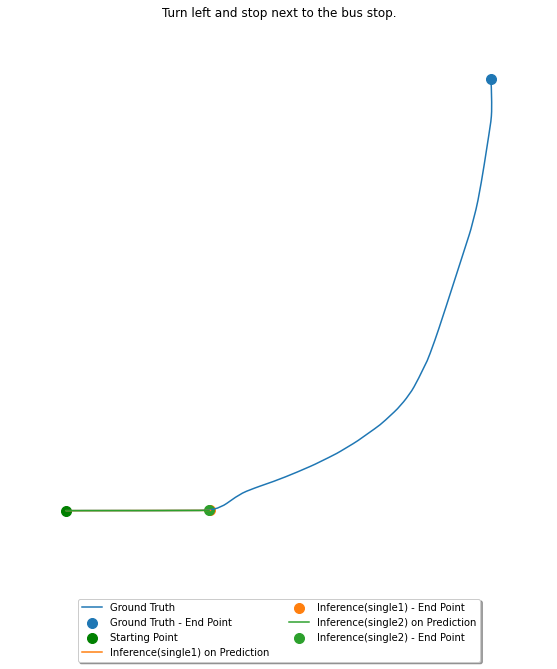

Episode 1: Take a left from the interection.
(94, 3) (94, 3)
single1
Frechet Distance: 3.3950793624897226
FDE Distance: 3.3950793624897226
ADE Distance: 3.9007252916866677
ADE Matched Distance: 0.216126517542188
nDTW Distance: 0.9299213210952745
TC Distance: True
(94, 3) (94, 3)
single2
Frechet Distance: 16.171223782579855
FDE Distance: 16.17122378257985
ADE Distance: 10.874007807195868
ADE Matched Distance: 2.116509917196106
nDTW Distance: 0.2733710563559246
TC Distance: False


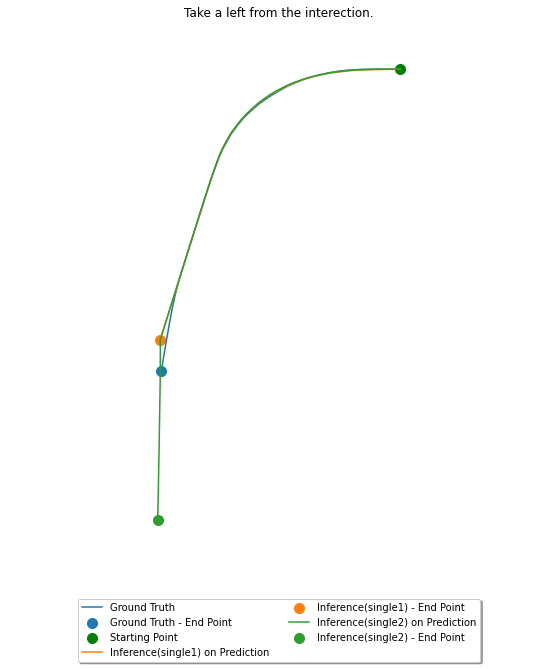

Episode 2: Drive straight till you see a red coloured board
(55, 3) (55, 3)
single1
Frechet Distance: 5.354095466204557
FDE Distance: 5.354095466204557
ADE Distance: 2.3301572422601997
ADE Matched Distance: 0.6973424614130732
nDTW Distance: 0.7228299981675352
TC Distance: False
(55, 3) (55, 3)
single2
Frechet Distance: 11.298828135695478
FDE Distance: 11.298828135695478
ADE Distance: 7.166501146363264
ADE Matched Distance: 1.6475988108095483
nDTW Distance: 0.3203500430351114
TC Distance: False


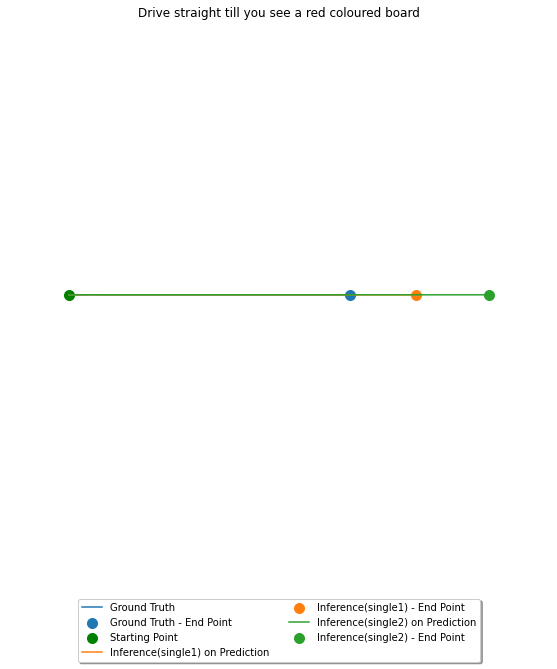

Episode 3: Park just ahead of the speed signboard
(38, 3) (38, 3)
single1
Frechet Distance: 30.313087524423736
FDE Distance: 30.313087524423736
ADE Distance: 31.830682472689574
ADE Matched Distance: 26.330173801129888
nDTW Distance: 8.180192822362128e-62
TC Distance: False
(38, 3) (38, 3)
single2
Frechet Distance: 29.153907403979158
FDE Distance: 29.153907403979158
ADE Distance: 9.463675398249578
ADE Matched Distance: 6.540627863225767
nDTW Distance: 0.0024193351557130318
TC Distance: False


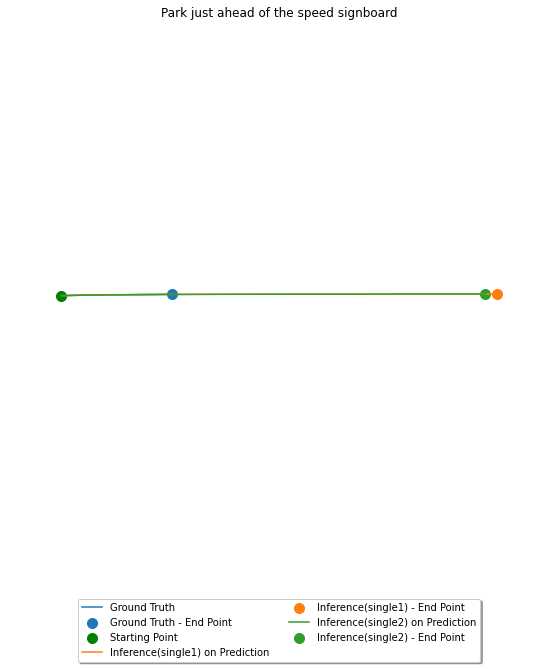

Episode 4: Take the next right turn.
(332, 3) (332, 3)
single1
Frechet Distance: 6.956138053006804
FDE Distance: 6.956138053006805
ADE Distance: 10.327366467942314
ADE Matched Distance: 1.901860948886671
nDTW Distance: 0.3344430745345118
TC Distance: False
(332, 3) (332, 3)
single2
Frechet Distance: 113.89763583955936
FDE Distance: 25.548743810457246
ADE Distance: 60.39944343983322
ADE Matched Distance: 44.12352294421359
nDTW Distance: 1.94610063708501e-24
TC Distance: False


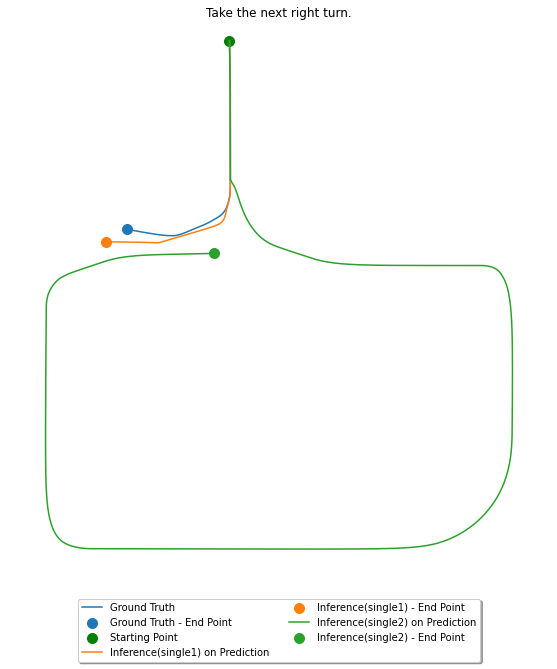

Episode 5: Drive straight from the next crossroads.
(150, 3) (150, 3)
single1
Frechet Distance: 38.896470075200746
FDE Distance: 38.896470075200746
ADE Distance: 21.41000810583244
ADE Matched Distance: 6.925657307028575
nDTW Distance: 0.024880176997677354
TC Distance: False
(150, 3) (150, 3)
single2
Frechet Distance: 40.14347682600247
FDE Distance: 40.14347682600247
ADE Distance: 19.369447292714504
ADE Matched Distance: 7.603552846970197
nDTW Distance: 0.15961497760360024
TC Distance: False


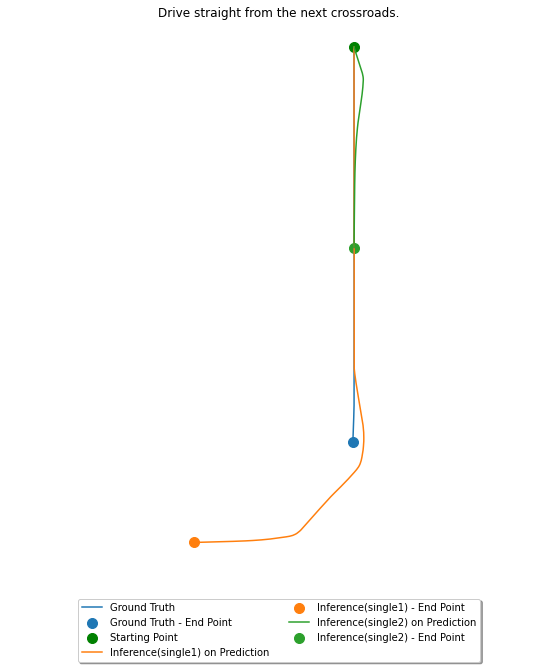

Episode 6: change to left lane
(70, 3) (70, 3)
single1
Frechet Distance: 8.1295453586907
FDE Distance: 8.1295453586907
ADE Distance: 6.0024510985196455
ADE Matched Distance: 2.6706243285569156
nDTW Distance: 0.1880499247633928
TC Distance: False
(70, 3) (70, 3)
single2
Frechet Distance: 3.8283031943167587
FDE Distance: 3.740088539897062
ADE Distance: 4.709255991568213
ADE Matched Distance: 2.0003361769594328
nDTW Distance: 0.359504324258018
TC Distance: True


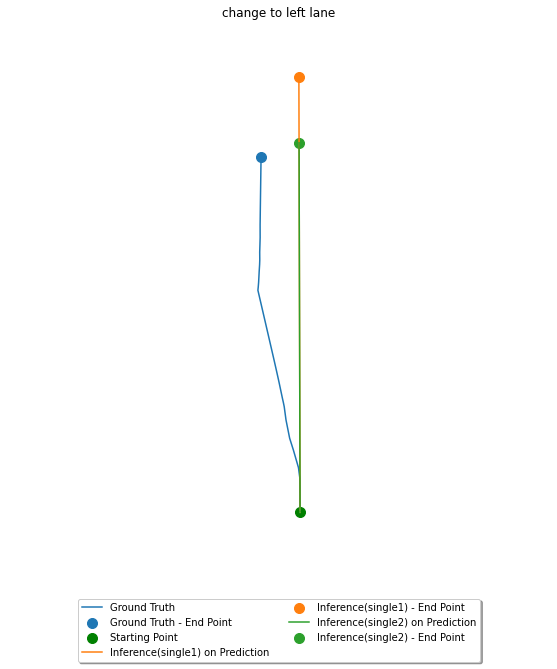

Episode 7: Stop near the scooty
(42, 3) (42, 3)
single1
Frechet Distance: 33.46100819481557
FDE Distance: 33.46100819481557
ADE Distance: 15.497107440656206
ADE Matched Distance: 9.947970150875705
nDTW Distance: 6.35462587976763e-05
TC Distance: False
(42, 3) (42, 3)
single2
Frechet Distance: 33.46754883676372
FDE Distance: 33.46754883676372
ADE Distance: 18.137983826919005
ADE Matched Distance: 10.090289679408507
nDTW Distance: 5.2744835952168824e-05
TC Distance: False


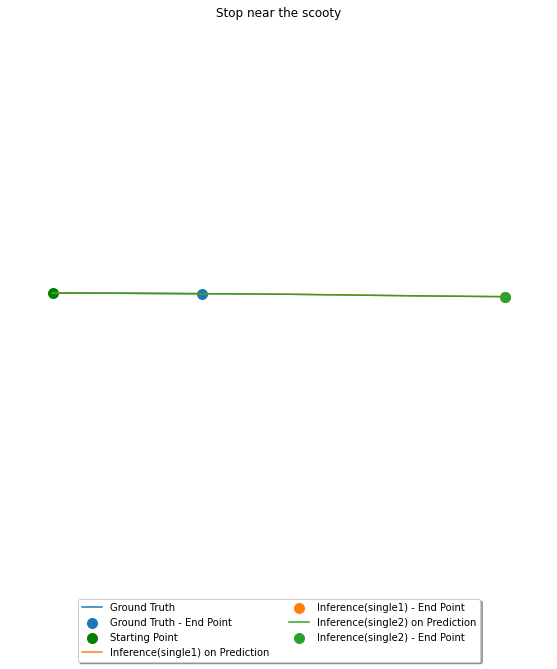

Episode 8: take right and stop near the speed limit sign
(142, 3) (142, 3)
single1
Frechet Distance: 11.239072208243467
FDE Distance: 11.239072208243467
ADE Distance: 5.976077621407588
ADE Matched Distance: 1.8148891499095627
nDTW Distance: 0.5655092852697089
TC Distance: False
(142, 3) (142, 3)
single2
Frechet Distance: 7.60482710413893
FDE Distance: 7.60482710413893
ADE Distance: 6.117020988703295
ADE Matched Distance: 0.7418417708812897
nDTW Distance: 0.825098957058976
TC Distance: False


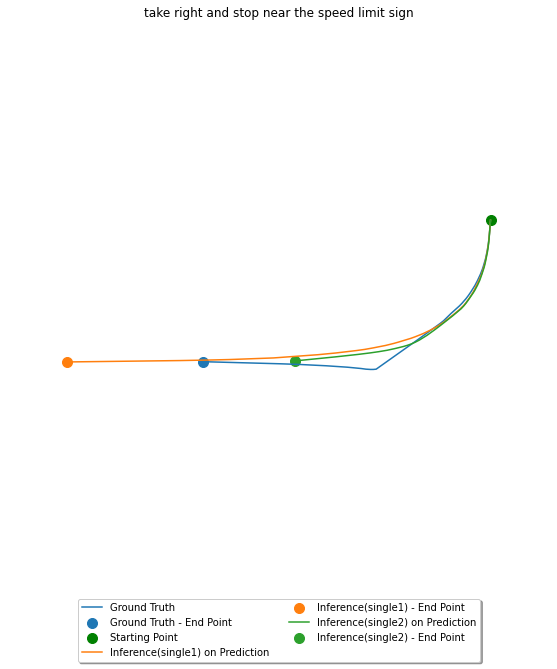

Episode 9: Turn right and stop near the bus stop.
(59, 3) (59, 3)
single1
Frechet Distance: 22.049531414404782
FDE Distance: 22.049531414404782
ADE Distance: 8.20908914016449
ADE Matched Distance: 4.591935619715742
nDTW Distance: 0.05615225493466028
TC Distance: False
(59, 3) (59, 3)
single2
Frechet Distance: 23.633294972027468
FDE Distance: 23.633294972027468
ADE Distance: 9.753023819113128
ADE Matched Distance: 5.424097136341733
nDTW Distance: 0.029840968099597114
TC Distance: False


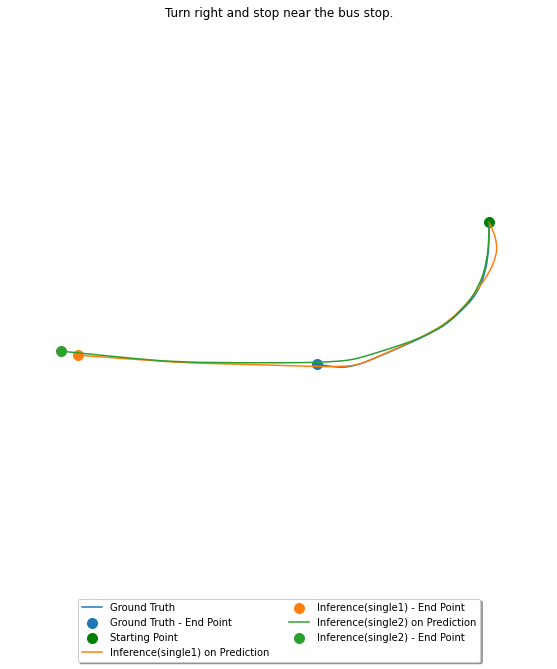

Episode 10: Shift to the left lane and stop at the intersection.
(66, 3) (66, 3)
single1
Frechet Distance: 11.803642747153846
FDE Distance: 11.803642747153846
ADE Distance: 4.501480008061647
ADE Matched Distance: 3.2122101695452008
nDTW Distance: 0.24858815692074698
TC Distance: False
(66, 3) (66, 3)
single2
Frechet Distance: 12.349465105152433
FDE Distance: 12.349465105152433
ADE Distance: 11.51900326282093
ADE Matched Distance: 3.633171534745142
nDTW Distance: 2.2303325438340255e-06
TC Distance: False


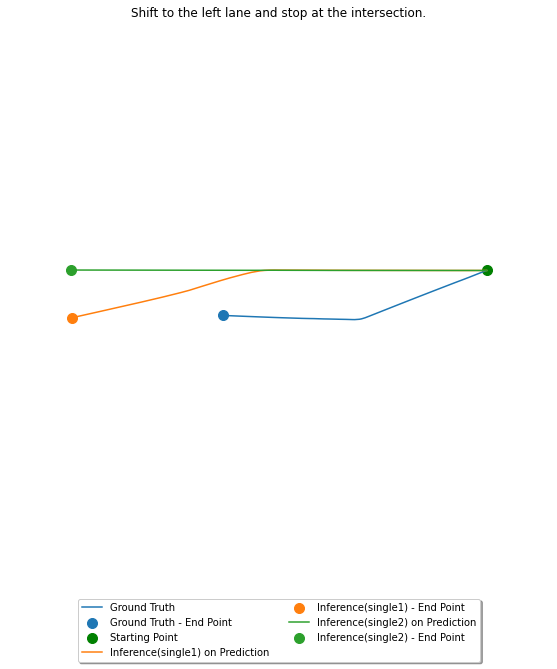

Episode 11: Stop after crossing the stop signboard
(45, 3) (45, 3)
single1
Frechet Distance: 39.66549849910885
FDE Distance: 39.66549849910885
ADE Distance: 15.553978768316703
ADE Matched Distance: 12.574456954661017
nDTW Distance: 5.409439083910247e-06
TC Distance: False
(45, 3) (45, 3)
single2
Frechet Distance: 39.43241260529062
FDE Distance: 39.43241260529062
ADE Distance: 18.532161598920343
ADE Matched Distance: 12.760524802394755
nDTW Distance: 1.8244493346040671e-06
TC Distance: False


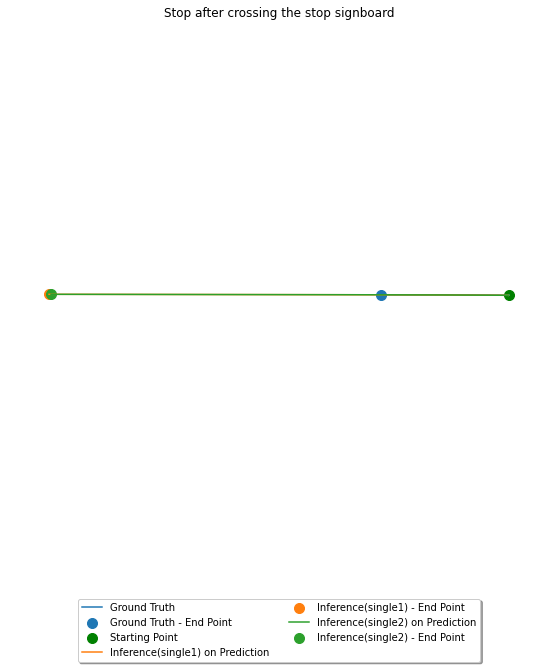

Episode 12: Park near the red signboard
(45, 3) (45, 3)
single1
Frechet Distance: 310.0880541231953
FDE Distance: 284.73696004535026
ADE Distance: 163.9007726834752
ADE Matched Distance: 189.61918416418308
nDTW Distance: 0.0
TC Distance: False
(45, 3) (45, 3)
single2
Frechet Distance: 310.07589040188236
FDE Distance: 89.91042109858485
ADE Distance: 150.6689871065197
ADE Matched Distance: 161.56291822828018
nDTW Distance: 0.0
TC Distance: False


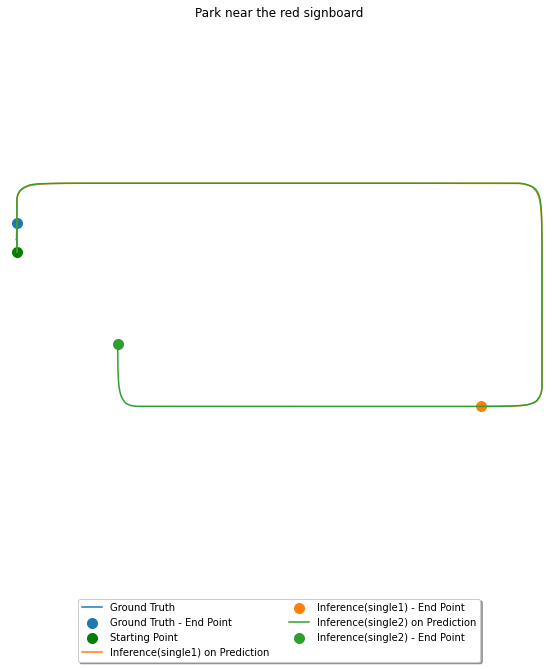

Episode 13: Wait at the traffic light then go straight.
(340, 3) (340, 3)
single1
Frechet Distance: 80.69740298161548
FDE Distance: 80.69740298161548
ADE Distance: 14.24745361213154
ADE Matched Distance: 9.724466675659217
nDTW Distance: 0.007303248111689081
TC Distance: False
(340, 3) (340, 3)
single2
Frechet Distance: 80.96703946660026
FDE Distance: 80.96703946660026
ADE Distance: 18.087100252147998
ADE Matched Distance: 10.237986067431224
nDTW Distance: 0.02223423903867471
TC Distance: False


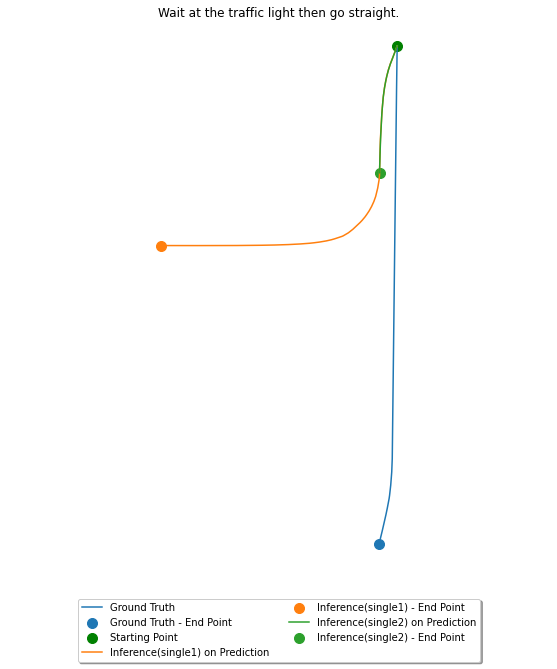

Episode 14: Drive straight till the intersection and then turn left
(73, 3) (73, 3)
single1
Frechet Distance: 10.580051566496694
FDE Distance: 10.580051566496694
ADE Distance: 8.05333815167504
ADE Matched Distance: 0.19848433130020052
nDTW Distance: 0.728704233469688
TC Distance: False
(73, 3) (73, 3)
single2
Frechet Distance: 22.195805230684616
FDE Distance: 22.195805230684616
ADE Distance: 7.680502065625596
ADE Matched Distance: 1.4676504241095067
nDTW Distance: 0.06520416805621106
TC Distance: False


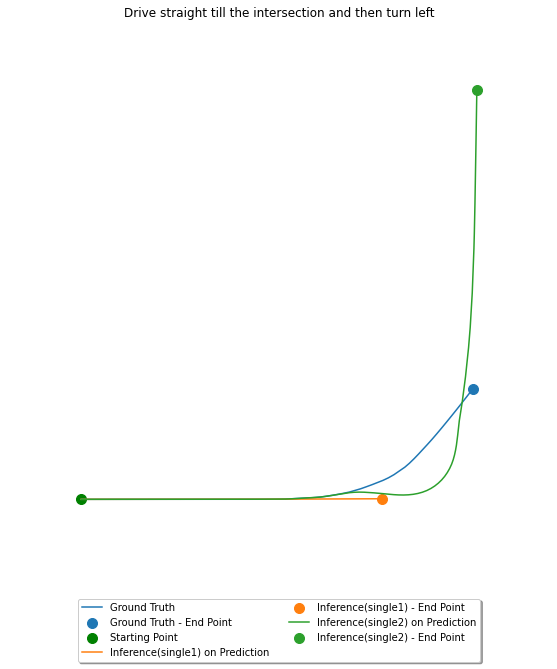

Episode 15: go straight and take a left
(218, 3) (218, 3)
single1
Frechet Distance: 32.33433189948215
FDE Distance: 32.33433189948215
ADE Distance: 17.670312377432143
ADE Matched Distance: 6.64224214938568
nDTW Distance: 0.26488793482863554
TC Distance: False
(213, 3) (213, 3)
single2
Frechet Distance: 32.352277946279045
FDE Distance: 32.352277946279045
ADE Distance: 19.505768532508117
ADE Matched Distance: 6.665514052701512
nDTW Distance: 0.26365791026865426
TC Distance: False


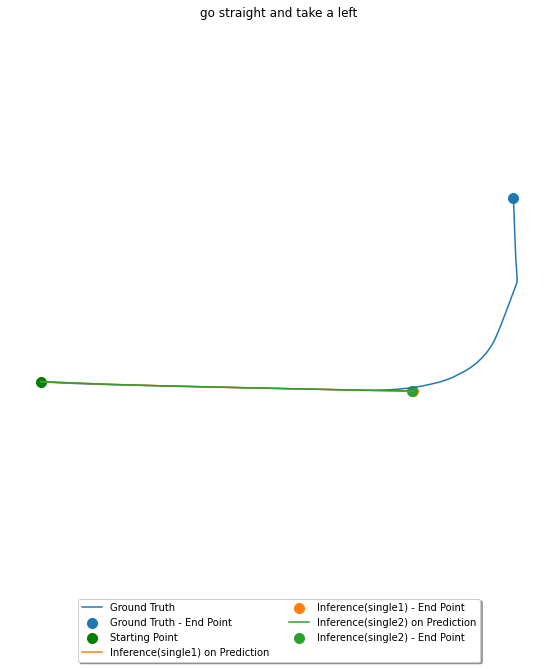

Episode 16: Stop as soon as you encounter a white car
(47, 3) (47, 3)
single1
Frechet Distance: 34.3534916190603
FDE Distance: 34.3534916190603
ADE Distance: 18.81537972884326
ADE Matched Distance: 9.139625211223766
nDTW Distance: 2.646366204587147e-05
TC Distance: False
(47, 3) (47, 3)
single2
Frechet Distance: 51.98011295782507
FDE Distance: 51.98011295782507
ADE Distance: 23.960073224916417
ADE Matched Distance: 16.01304714843384
nDTW Distance: 1.4179591422452443e-09
TC Distance: False


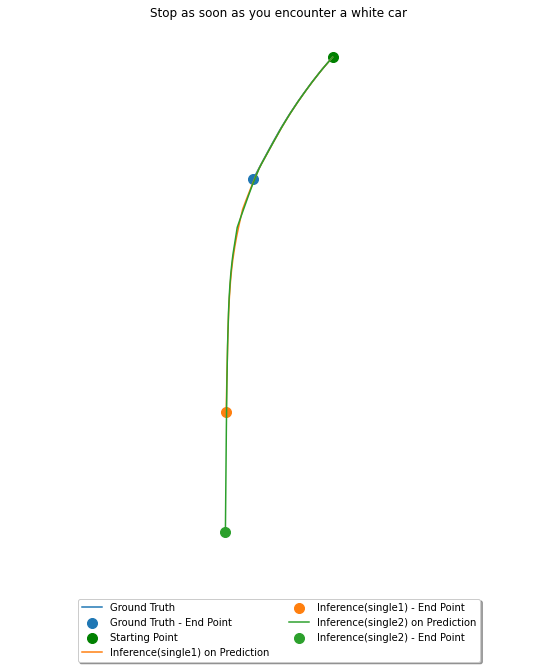

Episode 17: take a right at the intersection
(105, 3) (105, 3)
single1
Frechet Distance: 14.096172347447013
FDE Distance: 14.096172347447013
ADE Distance: 6.872877684472174
ADE Matched Distance: 2.4053858372432257
nDTW Distance: 0.3299651194361639
TC Distance: False
(105, 3) (105, 3)
single2
Frechet Distance: 13.97193151173686
FDE Distance: 13.97193151173686
ADE Distance: 7.004061380317631
ADE Matched Distance: 2.68735503394982
nDTW Distance: 0.34837808855770147
TC Distance: False


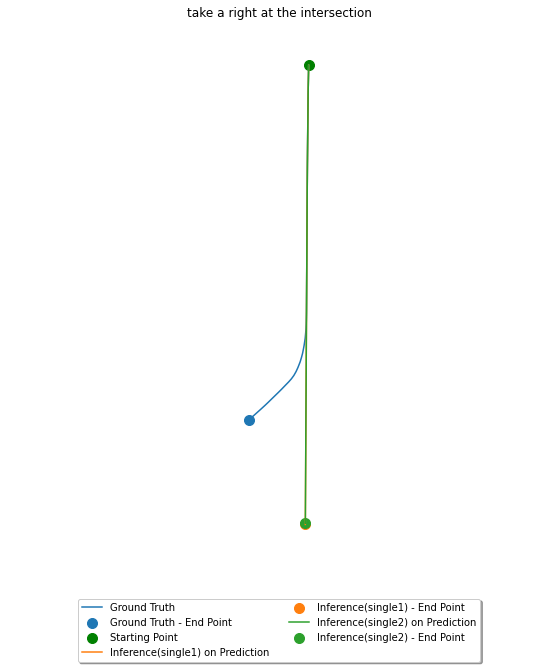

Episode 18: Stop near the red shelters
(44, 3) (44, 3)
single1
Frechet Distance: 15.461216808115623
FDE Distance: 15.461216808115621
ADE Distance: 18.493375679146375
ADE Matched Distance: 10.159883561145415
nDTW Distance: 3.2612197227249334e-10
TC Distance: False
(44, 3) (44, 3)
single2
Frechet Distance: 110.55743889514474
FDE Distance: 33.875854150324145
ADE Distance: 74.49148999135075
ADE Matched Distance: 68.82691454558483
nDTW Distance: 0.0
TC Distance: False


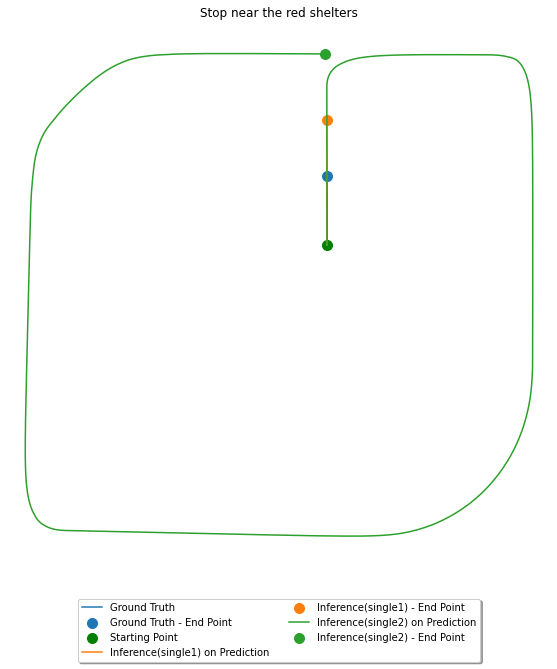

Episode 19: Turn left from the intersection
(127, 3) (127, 3)
single1
Frechet Distance: 29.240287603706424
FDE Distance: 29.240287603706424
ADE Distance: 8.984007728794248
ADE Matched Distance: 2.2362251336839787
nDTW Distance: 0.08176812127070594
TC Distance: False
(127, 3) (127, 3)
single2
Frechet Distance: 13.036656417593958
FDE Distance: 13.036656417593958
ADE Distance: 7.4667114768779435
ADE Matched Distance: 0.6352350707945732
nDTW Distance: 0.4680028120714772
TC Distance: False


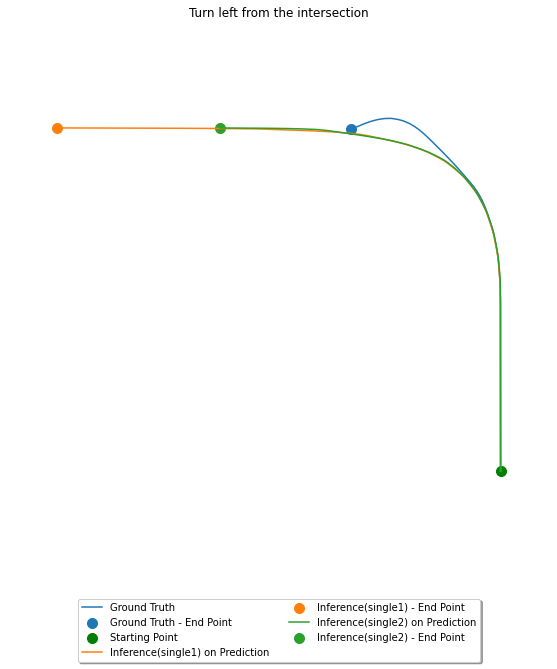

Episode 20: Drive straight then turn right
(127, 3) (127, 3)
single1
Frechet Distance: 94.08550201656539
FDE Distance: 14.75009654858232
ADE Distance: 75.5710420823729
ADE Matched Distance: 55.783715934599435
nDTW Distance: 3.819117649817487e-115
TC Distance: False
(127, 3) (127, 3)
single2
Frechet Distance: 1.4233958542039074
FDE Distance: 1.4233958542039071
ADE Distance: 3.681940281027851
ADE Matched Distance: 0.1673971136680656
nDTW Distance: 0.9099414104557649
TC Distance: True


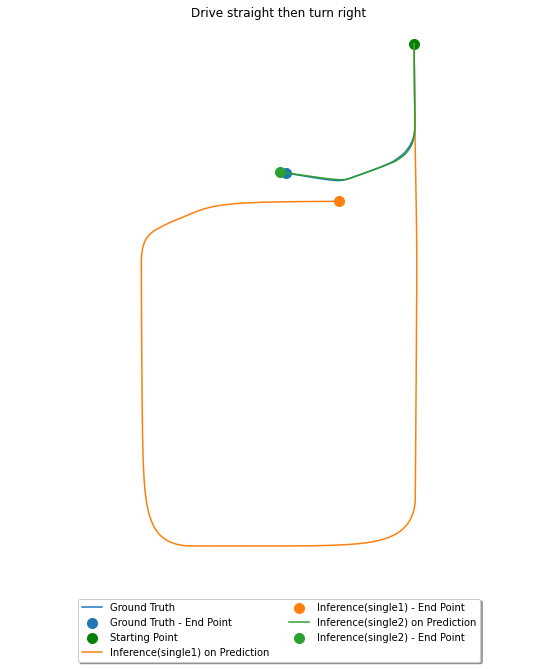

Episode 21: Park near the hut visible on the right
(36, 3) (36, 3)
single1
Frechet Distance: 13.464426404942342
FDE Distance: 13.464426404942342
ADE Distance: 12.788040759581014
ADE Matched Distance: 8.032874555282016
nDTW Distance: 3.0490059637283872e-05
TC Distance: False
(36, 3) (36, 3)
single2
Frechet Distance: 52.47992850941439
FDE Distance: 52.47992850941439
ADE Distance: 20.13581124546185
ADE Matched Distance: 17.996968590721387
nDTW Distance: 1.2961717501048646e-20
TC Distance: False


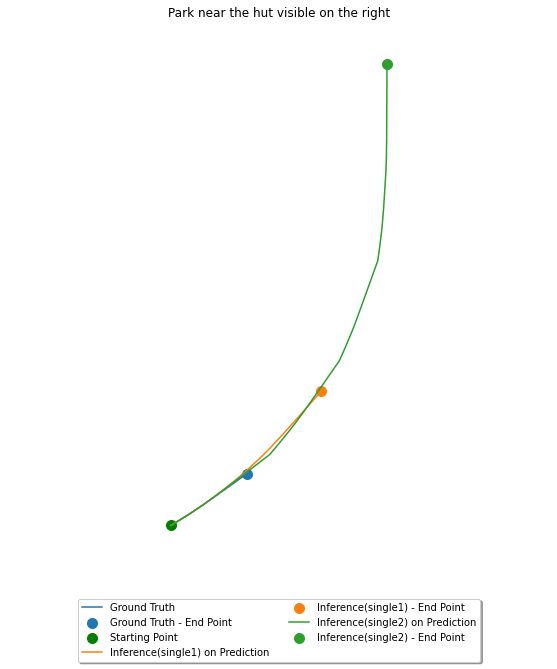

Episode 22: Go straight and stop before the traffic light.
(170, 3) (170, 3)
single1
Frechet Distance: 68.91293690028174
FDE Distance: 68.91293690028174
ADE Distance: 32.40032835776799
ADE Matched Distance: 17.94666277957374
nDTW Distance: 0.01810427873844903
TC Distance: False
(170, 3) (170, 3)
single2
Frechet Distance: 68.93315908659442
FDE Distance: 68.93315908659442
ADE Distance: 33.12448121708361
ADE Matched Distance: 18.765358282903776
nDTW Distance: 0.01839056588210507
TC Distance: False


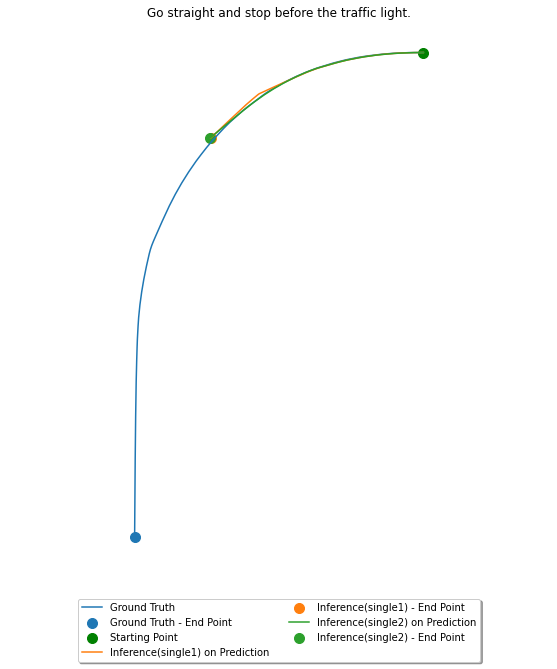

Episode 23: stop at the bus stand in front
(136, 3) (136, 3)
single1
Frechet Distance: 8.423905816993608
FDE Distance: 8.423905816993608
ADE Distance: 12.804575907852804
ADE Matched Distance: 0.22875294620035042
nDTW Distance: 0.8443316596456222
TC Distance: False
(136, 3) (136, 3)
single2
Frechet Distance: 8.42554513891993
FDE Distance: 8.425545138919928
ADE Distance: 9.535565746531688
ADE Matched Distance: 0.229865807242051
nDTW Distance: 0.8459214383535605
TC Distance: False


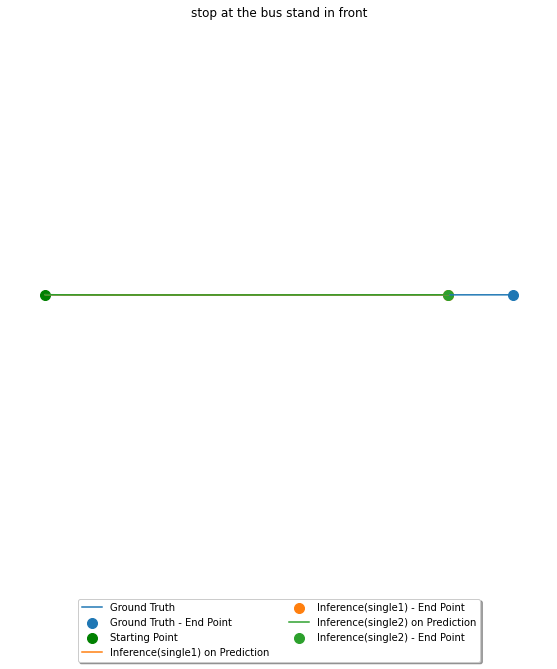

Episode 24: Turn right from the intersection.
(66, 3) (66, 3)
single1
Frechet Distance: 38.47114119139102
FDE Distance: 38.47114119139102
ADE Distance: 26.143395254286144
ADE Matched Distance: 16.273724421794803
nDTW Distance: 1.993780733248556e-26
TC Distance: False
(66, 3) (66, 3)
single2
Frechet Distance: 10.058122764656572
FDE Distance: 10.058122764656572
ADE Distance: 5.126848644348783
ADE Matched Distance: 1.1952035877509295
nDTW Distance: 0.40143850456201785
TC Distance: False


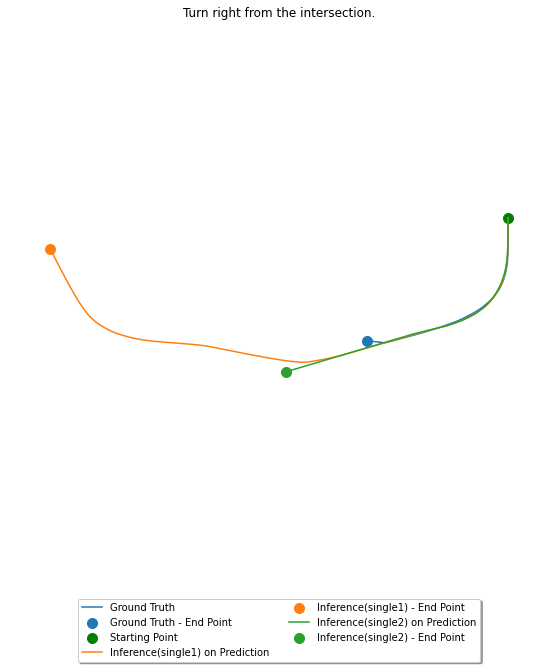

In [96]:
val_data_path = '/ssd_scratch/cvit/varunc/carla_data/val/'
val_run_paths = ['/ssd_scratch/cvit/varunc/new_vals/val_clipsingle/','/ssd_scratch/cvit/varunc/new_vals/val_clipsingle2/']
names = ['single1','single2']
save_loc = '../trajectories_temp/'

frechet_temp_all,fde_temp_all,ade_temp_all, ade_matched_temp_all, ndtw_temp_all, tc_temp_clip_all = get_scores_comp(val_data_path, val_run_paths,names, save_loc,episodes=list(range(25)))

CLIP-single1    0.056152
CLIP-single2    0.065204
RNR-con         0.535384
RNR             0.043633
dtype: float64


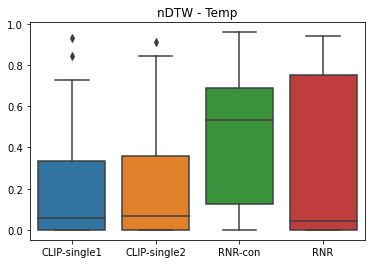

In [100]:
n_df = pd.DataFrame({
    'CLIP-single1':(ndtw_temp_all[0::2]),
    'CLIP-single2':(ndtw_temp_all[1::2]),
    
    'RNR-con':(ndtw_val_all[4::6]),
    'RNR':(ndtw_val_all[5::6]),
    })
g = sns.boxplot(data=n_df)
# g.set_yscale("log")
# g.set_ylim([-5,60])
plt.title('nDTW - Temp')
print(n_df.median())